# INTRO

## Notebook for applying Data Assimilation on seasonal data (Lutetian reconstructions)

### Assemble data in the proxy domain using offline (block update) assimilation instead of point-by-point
### Assemble data in SST (D47), SAT (D47), SSS (d18Oc) and precipitation domain

Author: **N.J. de Winter** (*n.j.de.winter@vu.nl*)<br>
Assistant Professor Vrije Universiteit Amsterdam

**References used in coding**

*Data assimiliation*
- Steiger, N.J., Hakim, G.J., Steig, E.J., Battisti, D.S., Roe, G.H., 2014. Assimilation of Time-Averaged Pseudoproxies for Climate Reconstruction. Journal of Climate 27, 426–441. https://doi.org/10.1175/JCLI-D-12-00693.1
- Hakim, G.J., Emile-Geay, J., Steig, E.J., Noone, D., Anderson, D.M., Tardif, R., Steiger, N., Perkins, W.A., 2016. The last millennium climate reanalysis project: Framework and first results. Journal of Geophysical Research: Atmospheres 121, 6745–6764. https://doi.org/10.1002/2016JD024751
- King, J., Tierney, J., Osman, M., Judd, E.J., Anchukaitis, K.J., 2023. DASH: a MATLAB toolbox for paleoclimate data assimilation. Geoscientific Model Development 16, 5653–5683. https://doi.org/10.5194/gmd-16-5653-2023
- Judd, E.J., Tierney, J.E., Lunt, D.J., Montañez, I.P., Huber, B.T., Wing, S.L., Valdes, P.J., 2024. A 485-million-year history of Earth’s surface temperature. Science 385, eadk3705. https://doi.org/10.1126/science.adk3705

*Data sources*
- Van Horebeek, N., de Winter, N. J., Baatsen, M., Ziegler, M., Speijer, R. P., Vellekoop, J.: A European Monsoon-like climate in a Warmhouse World, Nature Communications, *in review*, 2025.
- Baatsen, M., von der Heydt, A.S., Huber, M., Kliphuis, M.A., Bijl, P.K., Sluijs, A., Dijkstra, H.A., 2020. The middle to late Eocene greenhouse climate modelled using the CESM 1.0.5. Climate of the Past 16, 2573–2597. https://doi.org/10.5194/cp-16-2573-2020

*Calibration equations*
- Harwood, A. J. P., Dennis, P. F., Marca, A. D., Pilling, G. M., and Millner, R. S.: The oxygen isotope composition of water masses within the North Sea, Estuarine, Coastal and Shelf Science, 78, 353–359, https://doi.org/10.1016/j.ecss.2007.12.010, 2008.
- Daëron, M. and Vermeesch, P.: Omnivariant generalized least squares regression: Theory, geochronological applications, and making the case for reconciled Δ47 calibrations, Chemical Geology, 121881, https://doi.org/10.1016/j.chemgeo.2023.121881, 2023.
- Grossman, E. L. and Ku, T.-L.: Oxygen and carbon isotope fractionation in biogenic aragonite: temperature effects, Chemical Geology: Isotope Geoscience section, 59, 59–74, 1986.
- Gonfiantini, R., Stichler, W., and Rozanski, K.: Standards and intercomparison materials distributed by the International Atomic Energy Agency for stable isotope measurements, 1995.
- Dettman, D. L., Reische, A. K., and Lohmann, K. C.: Controls on the stable isotope composition of seasonal growth bands in aragonitic fresh-water bivalves (Unionidae), Geochimica et Cosmochimica Acta, 63, 1049–1057, 1999.

## Load packages

In [3]:
# Load packages
import numpy as np # The 'numpy' package is needed for matrix operations and calculations
import pandas as pd # The 'pandas' package helps us to import and manage data
import math as math # Math package for data cleaning
from scipy import stats # Import scipy.package for confidence intervals
from sklearn.preprocessing import StandardScaler # Import the package for standardizing data
import D47calib as D47c # Import the package for treating clumped isotope data by Daëron and Vermeesch (2023; https://github.com/mdaeron/D47calib)
import matplotlib.pyplot as plt # The 'matplotlib' package contains tools needed to plot our data and results
import seaborn as sns # The 'seaborn' package is used to make our plots look nicer (e.g. enable heatmaps)
import warnings # The 'warnings' package is used to suppress warnings that might occur during the calculations
%matplotlib inline

# PRIOR - MONTHLY
## Load monthly SAT model data

In [4]:
# Load model SAT data as prior and show data structure
Lutetian_SAT = pd.read_csv('Lutetian case/CESM_2PIC_SAT_Individual_values.csv') # Load the data for this assignment into Python and in the Jupyter environment.
Lutetian_SAT.head()

Month  Temperature
0      1     8.079706
1      1    18.723108
2      1    18.902612
3      1    19.552850
4      1    18.329370

## Load monthly SST model data

In [5]:
# Load model SST data as prior and show data structure
Lutetian_SST = pd.read_csv('Lutetian case/CESM_2PIC_SST_Individual_values.csv') # Load the data for this assignment into Python and in the Jupyter environment.
Lutetian_SST.head()

Month        SST
0      1  22.904200
1      1  22.584154
2      1  22.211651
3      1  14.667439
4      1  14.675111

## Load monthly SSS model data

In [6]:
# Load model SSS data as prior and show data structure
Lutetian_SSS = pd.read_csv('Lutetian case/CESM_2PIC_SSS_Individual_values.csv') # Load the data for this assignment into Python and in the Jupyter environment.
Lutetian_SSS.head()

Month        SSS
0      1  35.611739
1      1  35.605736
2      1  35.525519
3      1  28.101734
4      1  28.084953

## Load monthly precipitation model data

In [7]:
# Load model precipitation data as prior and show data structure
Lutetian_prec = pd.read_csv('Lutetian case/CESM_2PIC_Precipitation_Individual_values.csv') # Load the data for this assignment into Python and in the Jupyter environment.
Lutetian_prec.head()

Month  Precipitation
0      1       4.098786
1      1       1.263385
2      1       2.206109
3      1       2.211890
4      1       2.020240

### Combine SAT and precipitation data by modelname

In [8]:
# Add a column to number the rows within each month consecutively
Lutetian_SAT['Cell'] = Lutetian_SAT.groupby('Month').cumcount() + 1
Lutetian_SST['Cell'] = Lutetian_SST.groupby('Month').cumcount() + 1
Lutetian_SSS['Cell'] = Lutetian_SSS.groupby('Month').cumcount() + 1
Lutetian_prec['Cell'] = Lutetian_prec.groupby('Month').cumcount() + 1

# Pivot the datasets to create separate columns for each month with 2-letter abbreviations
month_abbreviations = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']
Lutetian_SAT_wide = Lutetian_SAT.pivot(index='Cell', columns='Month', values='Temperature')
Lutetian_SAT_wide.columns = [month_abbreviations[col - 1] for col in Lutetian_SAT_wide.columns]
Lutetian_SST_wide = Lutetian_SST.pivot(index='Cell', columns='Month', values='SST')
Lutetian_SST_wide.columns = [month_abbreviations[col - 1] for col in Lutetian_SST_wide.columns]
Lutetian_SSS_wide = Lutetian_SSS.pivot(index='Cell', columns='Month', values='SSS')
Lutetian_SSS_wide.columns = [month_abbreviations[col - 1] for col in Lutetian_SSS_wide.columns]
Lutetian_prec_wide = Lutetian_prec.pivot(index='Cell', columns='Month', values='Precipitation')
Lutetian_prec_wide.columns = [month_abbreviations[col - 1] for col in Lutetian_prec_wide.columns]

# Reset the index to make 'Cell' a column again
Lutetian_SAT_wide.reset_index(inplace = True)
Lutetian_SST_wide.reset_index(inplace = True)
Lutetian_SSS_wide.reset_index(inplace = True)
Lutetian_prec_wide.reset_index(inplace = True)

# Merge the datasets of SAT, SST, SSS and prec, force suffixes to be added to the column names
# Merge in two steps to circumvent different numbers of cells due to differing spatial resolution in air and ocean models
Lutetian_models = pd.merge(
    # Merge SAT and prec data
    pd.merge(
        Lutetian_SAT_wide.rename(columns = {c: c+'_SAT' for c in Lutetian_SAT_wide.columns if c != 'Cell'}),
        Lutetian_prec_wide.rename(columns = {c: c+'_precip' for c in Lutetian_prec_wide.columns if c != 'Cell'}),
        on = 'Cell',
        how = 'outer'
    ),
    # Merge SST and SSS data
    pd.merge(
        Lutetian_SST_wide.rename(columns = {c: c+'_SST' for c in Lutetian_SST_wide.columns if c != 'Cell'}),
        Lutetian_SSS_wide.rename(columns = {c: c+'_SSS' for c in Lutetian_SSS_wide.columns if c != 'Cell'}),
        on = 'Cell',
        how = 'outer'
    ),
    on = 'Cell',
    how = 'outer'
)

# Display the combined dataset
Lutetian_models.head()

Cell     ja_SAT     fb_SAT     mr_SAT     ar_SAT     my_SAT     jn_SAT  \
0     1   8.079706   8.682245  10.292291  13.623804  18.543329  22.827844   
1     2  18.723108  19.036798  20.318903  22.775720  26.905450  31.019128   
2     3  18.902612  19.163934  20.205408  22.355096  26.210016  30.252496   
3     4  19.552850  19.557764  20.425623  22.352350  25.905756  29.882379   
4     5  18.329370  18.452631  19.794916  22.507562  27.185938  31.563654   

      jl_SAT     ag_SAT     sp_SAT  ...     mr_SSS     ar_SSS     my_SSS  \
0  25.661005  25.911890  22.544611  ...  35.557816  35.549113  35.578386   
1  34.275934  34.816797  31.946375  ...  35.568414  35.559291  35.579439   
2  34.047083  34.686151  32.002588  ...  35.488143  35.475190  35.489032   
3  33.956262  34.617273  31.891870  ...  28.127362  28.017930  27.871013   
4  36.184412  36.466760  32.711786  ...  28.087784  27.952144  27.782063   

      jn_SSS     jl_SSS     ag_SSS     sp_SSS     ot_SSS     nv_SSS     dc_SSS  
0  35.604078  35.612619  35.590057  35.542811  35.520497  35.563135  35.608150  
1  35.598084  35.603424  35.595446  35.571139  35.549517  35.570238  35.601316  
2  35.499420  35.495488  35.490418  35.487392  35.482942  35.506846  35.529809  
3  27.769361  27.677441  27.601284  27.565443  27.592602  27.742316  27.963268  
4  27.661411  27.563237  27.489528  27.457962  27.502879  27.701501  27.951535  

[5 rows x 49 columns]

## Calculate the monthly prior for model SST, SAT, SSS and precipitation values

In [9]:
# Create list of month names
months = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']

# Prior SST, SAT, SSS & precipitation estimates from climate models (mean)
mu_prior_SAT_monthly = np.array(Lutetian_models[[f"{month}_SAT" for month in months]].mean(axis=0, skipna=True))
mu_prior_SST_monthly = np.array(Lutetian_models[[f"{month}_SST" for month in months]].mean(axis=0, skipna=True))
mu_prior_SSS_monthly = np.array(Lutetian_models[[f"{month}_SSS" for month in months]].mean(axis=0, skipna=True))
mu_prior_precip_monthly = np.array(Lutetian_models[[f"{month}_precip" for month in months]].mean(axis=0, skipna=True))

# Covariance between months in prior SST, SAT, SSS, and precip estimates from climate models (covariance matrix)
cov_prior_SAT_monthly = np.cov(Lutetian_models[[f"{month}_SAT" for month in months]].dropna(), rowvar=False)
cov_prior_SST_monthly = np.cov(Lutetian_models[[f"{month}_SST" for month in months]].dropna(), rowvar=False)
cov_prior_SSS_monthly = np.cov(Lutetian_models[[f"{month}_SSS" for month in months]].dropna(), rowvar=False)
cov_prior_precip_monthly = np.cov(Lutetian_models[[f"{month}_precip" for month in months]].dropna(), rowvar=False)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SAT_monthly_original, cov_prior_SAT_monthly_original = mu_prior_SAT_monthly.copy(), cov_prior_SAT_monthly.copy()
mu_prior_SST_monthly_original, cov_prior_SST_monthly_original = mu_prior_SST_monthly.copy(), cov_prior_SST_monthly.copy()
mu_prior_SSS_monthly_original, cov_prior_SSS_monthly_original = mu_prior_SSS_monthly.copy(), cov_prior_SSS_monthly.copy()
mu_prior_precip_monthly_original, cov_prior_precip_monthly_original = mu_prior_precip_monthly.copy(), cov_prior_precip_monthly.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SAT_monthly = np.sqrt(np.diag(cov_prior_SAT_monthly))
std_prior_SST_monthly = np.sqrt(np.diag(cov_prior_SST_monthly))
std_prior_SSS_monthly = np.sqrt(np.diag(cov_prior_SSS_monthly))
std_prior_precip_monthly = np.sqrt(np.diag(cov_prior_precip_monthly))

print("SAT Monthly Means:", mu_prior_SAT_monthly)
print("SAT Monthly Std Devs:", std_prior_SAT_monthly)
print("SST Monthly Means:", mu_prior_SST_monthly)
print("SST Monthly Std Devs:", std_prior_SST_monthly)
print("SSS Monthly Means:", mu_prior_SSS_monthly)
print("SSS Monthly Std Devs:", std_prior_SSS_monthly)
print("Precip Monthly Means:", mu_prior_precip_monthly)
print("Precip Monthly Std Devs:", std_prior_precip_monthly)

SAT Monthly Means: [13.07259888 13.64740356 15.16016968 18.37324585 23.23636963 27.22269897
 30.5027002  30.95843628 27.72623169 21.72160767 16.61921631 13.56875732]
SAT Monthly Std Devs: [3.54443863 3.25051999 2.97972364 2.6082818  2.44318742 2.633592
 2.9258649  2.76327261 2.72785837 3.26765855 3.74834864 3.87666334]
SST Monthly Means: [21.09214209 20.50165407 20.45381792 21.3438108  24.00107607 27.76274415
 31.12298921 32.43020732 31.14308296 28.27901287 25.30350554 22.60309048]
SST Monthly Std Devs: [3.12392276 3.24945387 3.19959003 2.96228485 2.63419216 2.44521968
 2.27340414 2.07587422 1.86449504 1.85875098 2.30023504 2.78693935]
SSS Monthly Means: [34.58157413 34.5569607  34.53000974 34.49177733 34.47721809 34.47541228
 34.46641887 34.48131349 34.52202742 34.56347591 34.58911597 34.59847409]
SSS Monthly Std Devs: [2.8600681  2.83254349 2.81830048 2.83097958 2.86959282 2.90697684
 2.94569794 2.98781149 3.02031307 3.02348573 2.98133699 2.91080858]
Precip Monthly Means: [2.02240836

## Plot the monthly priors for all model values

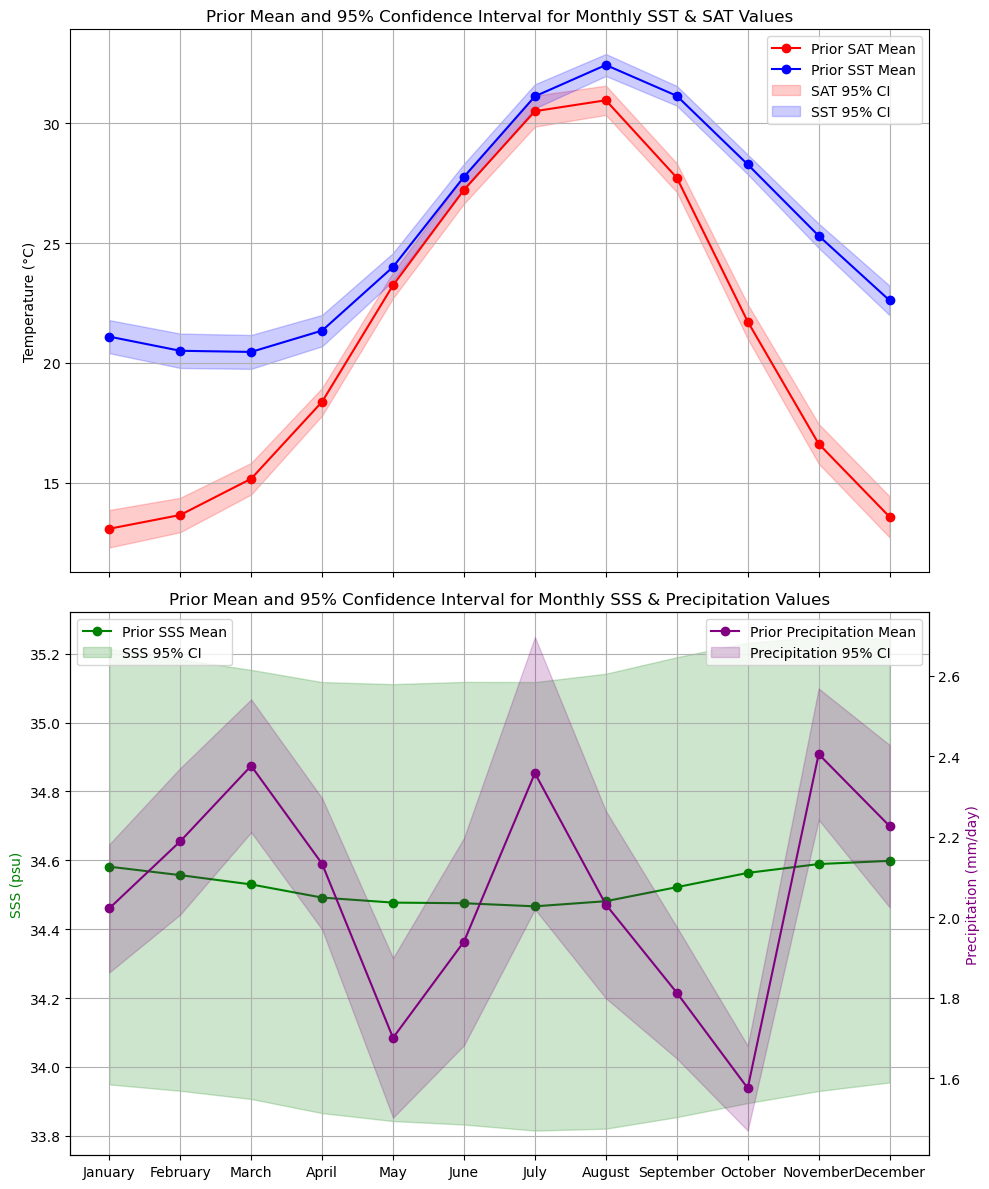

In [10]:
# Set dimensions of data
n_models_monthly = len(Lutetian_models["Cell"])  # Find the total number of models (use monthly data because monthly data has this column duplicated 3 times)

# Create a monthly scale for the x-axis
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']  # List full month names
months_scale = np.arange(len(months)) + 1  # Create monthly scale

# Create the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Panel 1: Plot the prior distribution for SST and SAT
axes[0].plot(months_scale, mu_prior_SAT_monthly, label='Prior SAT Mean', marker='o', color='r')
axes[0].plot(months_scale, mu_prior_SST_monthly, label='Prior SST Mean', marker='o', color='b')

# Add 95% confidence intervals for SAT
axes[0].fill_between(
    months_scale,
    mu_prior_SAT_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    mu_prior_SAT_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, color='r', label='SAT 95% CI'
)

# Add 95% confidence intervals for SST
axes[0].fill_between(
    months_scale,
    mu_prior_SST_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
    mu_prior_SST_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, color='b', label='SST 95% CI'
)

axes[0].set_title('Prior Mean and 95% Confidence Interval for Monthly SST & SAT Values')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()
axes[0].grid(True)

# Panel 2: Plot the prior distribution for SSS and precipitation
axes[1].plot(months_scale, mu_prior_SSS_monthly, label='Prior SSS Mean', marker='o', color='g')
ax2 = axes[1].twinx()  # Create a secondary y-axis for precipitation
ax2.plot(months_scale, mu_prior_precip_monthly, label='Prior Precipitation Mean', marker='o', color='purple')

# Add 95% confidence intervals for SSS
axes[1].fill_between(
    months_scale,
    mu_prior_SSS_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_monthly / np.sqrt(n_models_monthly),
    mu_prior_SSS_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, color='g', label='SSS 95% CI'
)

# Add 95% confidence intervals for precipitation
ax2.fill_between(
    months_scale,
    mu_prior_precip_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    mu_prior_precip_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, color='purple', label='Precipitation 95% CI'
)

axes[1].set_ylabel('SSS (psu)', color='g')
ax2.set_ylabel('Precipitation (mm/day)', color='purple')
axes[1].set_title('Prior Mean and 95% Confidence Interval for Monthly SSS & Precipitation Values')
axes[1].legend(loc='upper left')
ax2.legend(loc='upper right')
axes[1].grid(True)

# Update the x-axis with month names
plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.xlabel('Month')
plt.tight_layout()
plt.show()

### Convert SAT and SST model data to D47 domain using the regression by Daëron and Vermeesch (2023) and propagate uncertainty in the calibration

In [11]:
# Apply T47()-function from the D47calib package to all SAT columns
# Identify the SAT columns
SAT_columns = [col for col in Lutetian_models.columns if col.endswith('_SAT')]
SST_columns = [col for col in Lutetian_models.columns if col.endswith('_SST')]

# Apply the conversion function to the SAT columns and add new columns for D47 and D47_SE
for col in SAT_columns:
    base_col_name = col.replace('_SAT', '') # Remove the '_SAT' suffix from the column name
    Lutetian_models[f'{base_col_name}_SAT_D47'], Lutetian_models[f'{base_col_name}_SAT_D47_SE'] = zip(*Lutetian_models[col].apply(
        lambda x: D47c.OGLS23.T47(T = x) if not pd.isna(x) else (np.nan, np.nan)
    )) # Use zip() to unpack the tuple returned by the apply() method and apply the T47()-function to each value in the column
for col in SST_columns:
    base_col_name = col.replace('_SST', '') # Remove the '_SST' suffix from the column name
    Lutetian_models[f'{base_col_name}_SST_D47'], Lutetian_models[f'{base_col_name}_SST_D47_SE'] = zip(*Lutetian_models[col].apply(
        lambda x: D47c.OGLS23.T47(T = x) if not pd.isna(x) else (np.nan, np.nan)
    )) # Use zip() to unpack the tuple returned by the apply() method and apply the T47()-function to each value in the column

# Display the combined data with D47 and D47_SE columns
D47_columns = [col for col in Lutetian_models.columns if col.endswith('_D47')]
D47_se_columns = [col for col in Lutetian_models.columns if '_D47_SE' in col]
print("D47 values for all model outcomes:\n", Lutetian_models[D47_columns].head())
print("Calibration standard errors for all model outcomes:\n", Lutetian_models[D47_se_columns].head())

D47 values for all model outcomes:
    ja_SAT_D47  fb_SAT_D47  mr_SAT_D47  ar_SAT_D47  my_SAT_D47  jn_SAT_D47  \
0    0.649217    0.647051    0.641333    0.629812    0.613530    0.600021   
1    0.612951    0.611943    0.607858    0.600181    0.587709    0.575798   
2    0.612374    0.611535    0.608217    0.601482    0.589772    0.577980   
3    0.610292    0.610277    0.607520    0.601490    0.590680    0.579040   
4    0.614221    0.613823    0.609521    0.601010    0.586881    0.574258   

   jl_SAT_D47  ag_SAT_D47  sp_SAT_D47  ot_SAT_D47  ...  mr_SST_D47  \
0    0.591412    0.590661    0.600895    0.619948  ...    0.601218   
1    0.566713    0.565232    0.573181    0.587373  ...    0.602052   
2    0.567341    0.565589    0.573023    0.587203  ...    0.602959   
3    0.567591    0.565777    0.573334    0.586829  ...    0.629461   
4    0.561525    0.560765    0.571039    0.588141  ...    0.629846   

   ar_SST_D47  my_SST_D47  jn_SST_D47  jl_SST_D47  ag_SST_D47  sp_SST_D47  \
0  

### Estimate seawater oxygen isotope value from salinity based on modern North Sea d18Ow-salinity relationship by Harwood et al. (2007)

In [12]:
# Apply the d18Ow-SSS function from Harwood et al. (2007) to all SSS columns
# Identify the SSS columns
SSS_columns = [col for col in Lutetian_models.columns if col.endswith('_SSS')]

# Apply the conversion function to the SSS columns and add new columns for d18Ow and d18Ow_SE
for col in SSS_columns:
    base_col_name = col.replace('_SSS', '')  # Remove the '_SSS' suffix from the column name
    Lutetian_models[f'{base_col_name}_SSS_d18Ow'] = Lutetian_models[col].apply(
        lambda x: -9.300 + 0.274 * x if not pd.isna(x) else np.nan  # Calculate d18Ow
    )

# Display the combined data with d18Ow and d18Ow_SE columns
d18Ow_columns = [col for col in Lutetian_models.columns if col.endswith('_d18Ow')]
print("d18Ow values for all model outcomes:\n", Lutetian_models[d18Ow_columns].head())

d18Ow values for all model outcomes:
    ja_SSS_d18Ow  fb_SSS_d18Ow  mr_SSS_d18Ow  ar_SSS_d18Ow  my_SSS_d18Ow  \
0      0.457617      0.449562      0.442842      0.440457      0.448478   
1      0.455972      0.451012      0.445746      0.443246      0.448766   
2      0.433992      0.429306      0.423751      0.420202      0.423995   
3     -1.600125     -1.587918     -1.593103     -1.623087     -1.663342   
4     -1.604723     -1.595348     -1.603947     -1.641113     -1.687715   

   jn_SSS_d18Ow  jl_SSS_d18Ow  ag_SSS_d18Ow  sp_SSS_d18Ow  ot_SSS_d18Ow  \
0      0.455517      0.457858      0.451676      0.438730      0.432616   
1      0.453875      0.455338      0.453152      0.446492      0.440568   
2      0.426841      0.425764      0.424374      0.423545      0.422326   
3     -1.691195     -1.716381     -1.737248     -1.747069     -1.739627   
4     -1.720774     -1.747673     -1.767869     -1.776518     -1.764211   

   nv_SSS_d18Ow  dc_SSS_d18Ow  
0      0.444299      0.45663

### Calculate carbonate oxygen isotope value from SST and seawater oxygen isotope data using Grossman and Ku (1986) with the VPDB-VSMOW scale correction by Gonfiantini et al. (1995) and Dettman et al. (1999)

In [13]:
# Iterate over each model and calculate d18Oc values
for index, row in Lutetian_models.iterrows():
    # Iterate over each month
    for month in months:
        SST = row[f"{month}_SST"]
        d18Ow = row[f"{month}_SSS_d18Ow"]
        if not pd.isna(SST) and not pd.isna(d18Ow):
            d18Oc = (20.6 - SST) / 4.34 + (d18Ow - 0.27)
        else:
            d18Oc = np.nan
        # Add the calculated d18Oc value to the DataFrame
        Lutetian_models.loc[index, f"{month}_d18Oc"] = d18Oc

# Display the updated DataFrame
Lutetian_models.head()


Cell     ja_SAT     fb_SAT     mr_SAT     ar_SAT     my_SAT     jn_SAT  \
0     1   8.079706   8.682245  10.292291  13.623804  18.543329  22.827844   
1     2  18.723108  19.036798  20.318903  22.775720  26.905450  31.019128   
2     3  18.902612  19.163934  20.205408  22.355096  26.210016  30.252496   
3     4  19.552850  19.557764  20.425623  22.352350  25.905756  29.882379   
4     5  18.329370  18.452631  19.794916  22.507562  27.185938  31.563654   

      jl_SAT     ag_SAT     sp_SAT  ...  mr_d18Oc  ar_d18Oc  my_d18Oc  \
0  25.661005  25.911890  22.544611  ... -0.251207 -0.457940 -1.035783   
1  34.275934  34.816797  31.946375  ... -0.186319 -0.348003 -0.886515   
2  34.047083  34.686151  32.002588  ... -0.141044 -0.294629 -0.829306   
3  33.956262  34.617273  31.891870  ... -0.279467 -0.573045 -1.337027   
4  36.184412  36.466760  32.711786  ... -0.264183 -0.545776 -1.311192   

   jn_d18Oc  jl_d18Oc  ag_d18Oc  sp_d18Oc  ot_d18Oc  nv_d18Oc  dc_d18Oc  
0 -1.881269 -2.576888 -2.909747 -2.685377 -2.032326 -1.304283 -0.662541  
1 -1.713226 -2.383224 -2.730425 -2.549758 -1.941088 -1.222027 -0.576549  
2 -1.654628 -2.321103 -2.669299 -2.494446 -1.898522 -1.172672 -0.504181  
3 -2.293682 -3.076797 -3.480791 -3.346192 -2.751792 -1.868905 -1.014725  
4 -2.280590 -3.088334 -3.501189 -3.361654 -2.745354 -1.846001 -1.017308  

[5 rows x 121 columns]

### Calculate the monthly prior for model SST- and SAT-derived D47 values and SSS-derived seawater oxygen isotope values with propagated uncertainty

In [14]:
# Set the weights of the data based on the standard errors
weights_monthly_SST_D47 = 1 / Lutetian_models[[f"{month}_SST_D47_SE" for month in months]] ** 2
weights_monthly_SAT_D47 = 1 / Lutetian_models[[f"{month}_SAT_D47_SE" for month in months]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_monthly_SST_D47 to match the headers of the D47 matrix later for multiplication
weights_monthly_SST_D47.columns = [col.replace('_SST_D47_SE', '_SST_D47') for col in weights_monthly_SST_D47.columns]
weights_monthly_SAT_D47.columns = [col.replace('_SAT_D47_SE', '_SAT_D47') for col in weights_monthly_SAT_D47.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_SST_D47_monthly = np.array((Lutetian_models[[f"{month}_SST_D47" for month in months]] * weights_monthly_SST_D47).sum(axis = 0, skipna = True) / weights_monthly_SST_D47.sum(axis = 0, skipna = True)) # Calculate weighted monthly mean D47 values and convert to numpy array
mu_prior_SAT_D47_monthly = np.array((Lutetian_models[[f"{month}_SAT_D47" for month in months]] * weights_monthly_SAT_D47).sum(axis = 0, skipna = True) / weights_monthly_SAT_D47.sum(axis = 0, skipna = True)) # Calculate weighted monthly mean D47 values and convert to numpy array

# Calculate simple (unweighted) mean for monthly d18Ow values
mu_prior_SSS_d18Ow_monthly = np.array(Lutetian_models[[f"{month}_SSS_d18Ow" for month in months]].mean(axis=0, skipna=True))
mu_prior_d18Oc_monthly = np.array(Lutetian_models[[f"{month}_d18Oc" for month in months]].mean(axis=0, skipna=True))

# Decompose variance within and between model outcomes
model_variances_SST = Lutetian_models[[f"{month}_SST_D47" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_SAT = Lutetian_models[[f"{month}_SAT_D47" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_d18Ow = Lutetian_models[[f"{month}_SSS_d18Ow" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_d18Oc = Lutetian_models[[f"{month}_d18Oc" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
measurement_variances_SST = (Lutetian_models[[f"{month}_SST_D47_SE" for month in months]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements
measurement_variances_SAT = (Lutetian_models[[f"{month}_SAT_D47_SE" for month in months]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements

# Covariance between months in prior D47 estimates from climate models (weighted covariance matrix)
cov_raw_monthly_SST = np.cov(Lutetian_models[[f"{month}_SST_D47" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_monthly_SAT = np.cov(Lutetian_models[[f"{month}_SAT_D47" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_monthly_d18Ow = np.cov(Lutetian_models[[f"{month}_SSS_d18Ow" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_monthly_d18Oc = np.cov(Lutetian_models[[f"{month}_d18Oc" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_SST_D47_monthly = cov_raw_monthly_SST.copy() # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_SAT_D47_monthly = cov_raw_monthly_SAT.copy() # Copy covariance matrix to add uncertainty coming from the measurements
np.fill_diagonal(cov_prior_SST_D47_monthly, np.diagonal(cov_raw_monthly_SST) + measurement_variances_SST)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)
np.fill_diagonal(cov_prior_SAT_D47_monthly, np.diagonal(cov_raw_monthly_SAT) + measurement_variances_SAT)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SST_D47_monthly_original, cov_prior_SST_D47_monthly_original = mu_prior_SST_D47_monthly.copy(), cov_prior_SST_D47_monthly.copy()
mu_prior_SAT_D47_monthly_original, cov_prior_SAT_D47_monthly_original = mu_prior_SAT_D47_monthly.copy(), cov_prior_SAT_D47_monthly.copy()
mu_prior_SSS_d18Ow_monthly_original, cov_prior_SSS_d18Ow_monthly_original = mu_prior_SSS_d18Ow_monthly.copy(), cov_raw_monthly_d18Ow.copy()
mu_prior_d18Oc_monthly_original, cov_prior_d18Oc_monthly_original = mu_prior_d18Oc_monthly.copy(), cov_raw_monthly_d18Oc.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SST_D47_monthly = np.sqrt(np.diag(cov_prior_SST_D47_monthly))
std_prior_SAT_D47_monthly = np.sqrt(np.diag(cov_prior_SAT_D47_monthly))
std_prior_SSS_d18Ow_monthly = np.sqrt(np.diag(cov_raw_monthly_d18Ow))
std_prior_d18Oc_monthly = np.sqrt(np.diag(cov_raw_monthly_d18Oc))

# Print the results
print("Prior D47 estimates from SST in climate models (weighted mean):")
print(mu_prior_SST_D47_monthly)
print("Prior D47 estimates from SST in climate models (weighted covariance matrix):")
print(std_prior_SST_D47_monthly)
print("Prior D47 estimates from SAT in climate models (weighted mean):")
print(mu_prior_SAT_D47_monthly)
print("Prior D47 estimates from SAT in climate models (weighted covariance matrix):")
print(std_prior_SAT_D47_monthly)
print("Prior d18Ow estimates from SSS in climate models (weighted mean):")
print(mu_prior_SSS_d18Ow_monthly)
print("Prior d18Ow estimates from SSS in climate models (weighted covariance matrix):")
print(std_prior_SSS_d18Ow_monthly)
print("Prior d18Oc estimates from SST and d18Ow in climate models (weighted mean):")
print(mu_prior_d18Oc_monthly)
print("Prior d18Oc estimates from SST and d18Ow in climate models (weighted covariance matrix):")
print(std_prior_d18Oc_monthly)

Prior D47 estimates from SST in climate models (weighted mean):
[0.60489442 0.60666426 0.60683094 0.60417118 0.59618643 0.58512465
 0.5755485  0.57189757 0.57548974 0.58366672 0.59236182 0.60038379]
Prior D47 estimates from SST in climate models (weighted covariance matrix):
[0.01009378 0.01057793 0.01042161 0.00955301 0.00826056 0.00738042
 0.0066458  0.00598658 0.00544544 0.0055813  0.00709986 0.00884544]
Prior D47 estimates from SAT in climate models (weighted mean):
[0.63053005 0.62879279 0.62393577 0.61368013 0.59859233 0.5867432
 0.57737842 0.57609754 0.58529981 0.60308352 0.61883373 0.62866658]
Prior D47 estimates from SAT in climate models (weighted covariance matrix):
[0.01208732 0.0110329  0.00996397 0.00848212 0.00760235 0.00785875
 0.00842843 0.00790733 0.0080588  0.01021703 0.01233193 0.013147  ]
Prior d18Ow estimates from SSS in climate models (weighted mean):
[0.17535131 0.16860723 0.16122267 0.15074699 0.14675776 0.14626297
 0.14379877 0.1478799  0.15903551 0.1703924  0

### Plot the monthly prior for model SST- and SAT-derived D47 values, model SSS-derived carbonate d18O values and precipitation with propagated uncertainty

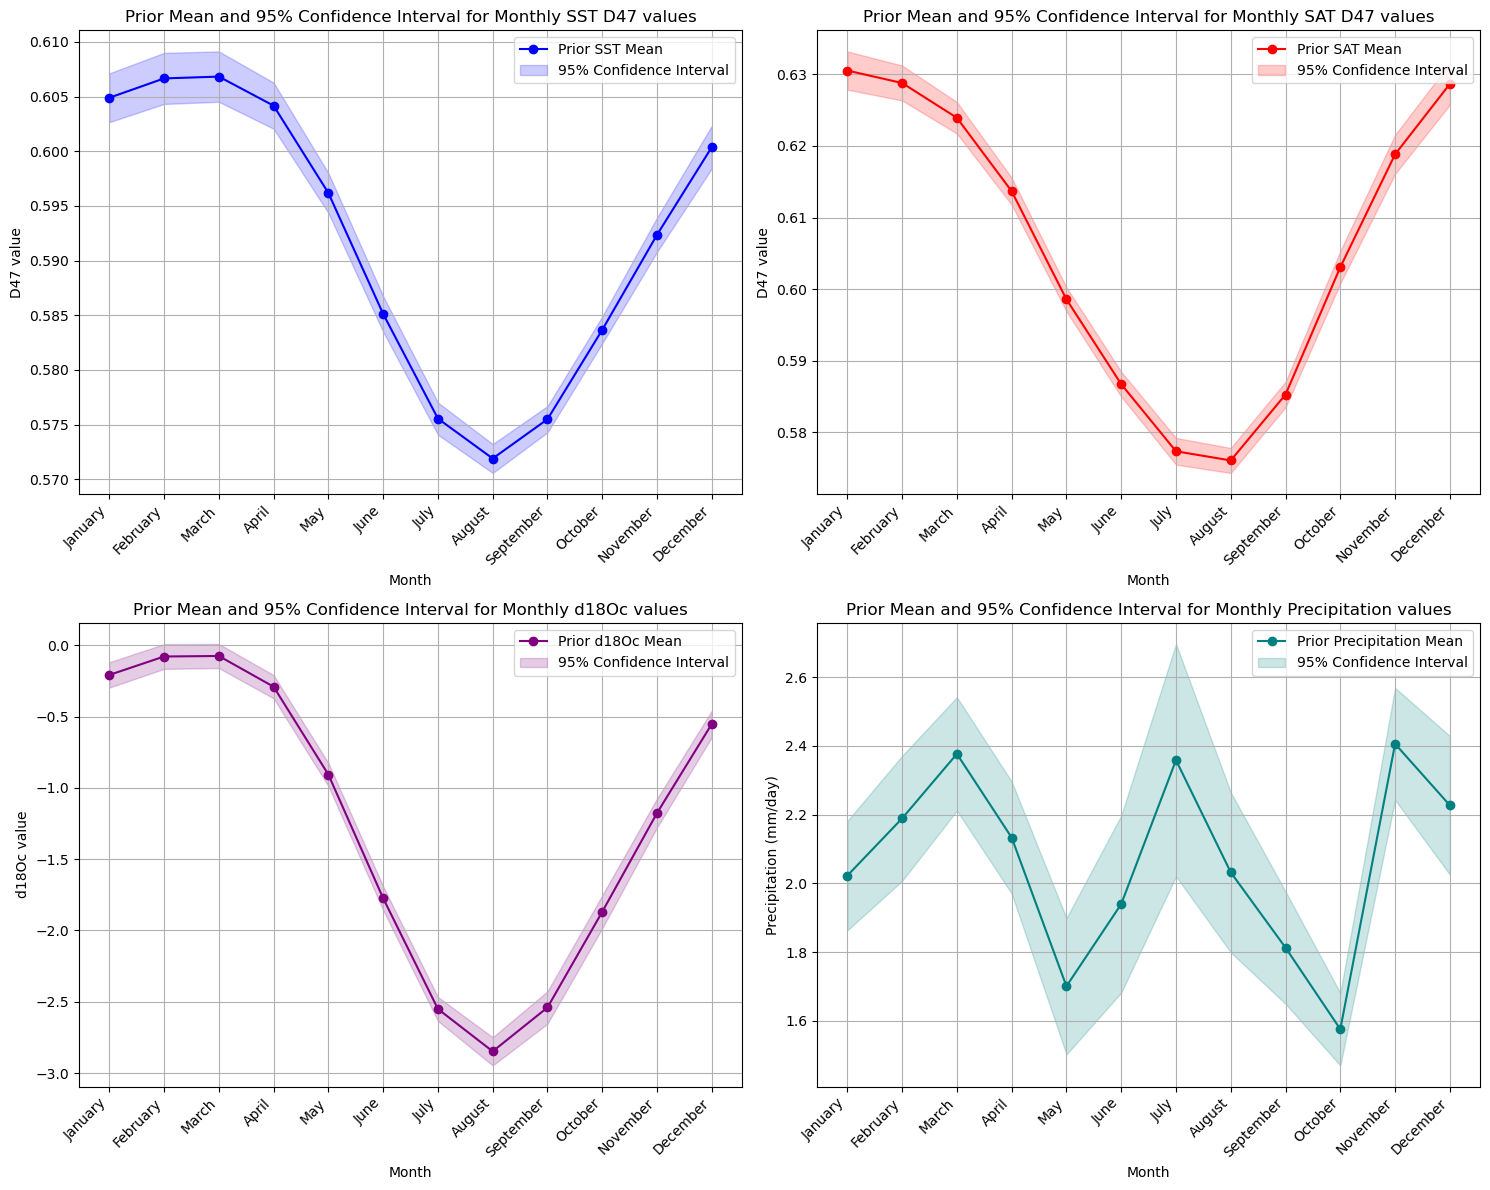

In [15]:
# Plot monthly prior distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # Adjust the figure to have 2x2 grid

# Plot the prior distribution for SST
axes[0, 0].plot(months_scale, mu_prior_SST_D47_monthly, label='Prior SST Mean', color='b', marker='o')
axes[0, 0].fill_between(months_scale,
                        mu_prior_SST_D47_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly / np.sqrt(n_models_monthly),
                        mu_prior_SST_D47_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly / np.sqrt(n_models_monthly),
                        color='b', alpha=0.2, label='95% Confidence Interval')
axes[0, 0].set_xticks(months_scale)
axes[0, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 0].set_title('Prior Mean and 95% Confidence Interval for Monthly SST D47 values')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('D47 value')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot the prior distribution for SAT
axes[0, 1].plot(months_scale, mu_prior_SAT_D47_monthly, label='Prior SAT Mean', color='r', marker='o')
axes[0, 1].fill_between(months_scale,
                        mu_prior_SAT_D47_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_D47_monthly / np.sqrt(n_models_monthly),
                        mu_prior_SAT_D47_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_D47_monthly / np.sqrt(n_models_monthly),
                        color='r', alpha=0.2, label='95% Confidence Interval')
axes[0, 1].set_xticks(months_scale)
axes[0, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 1].set_title('Prior Mean and 95% Confidence Interval for Monthly SAT D47 values')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('D47 value')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot the prior distribution for d18Oc
axes[1, 0].plot(months_scale, mu_prior_d18Oc_monthly, label='Prior d18Oc Mean', color='purple', marker='o')
axes[1, 0].fill_between(months_scale,
                        mu_prior_d18Oc_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_d18Oc_monthly / np.sqrt(n_models_monthly),
                        mu_prior_d18Oc_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_d18Oc_monthly / np.sqrt(n_models_monthly),
                        color='purple', alpha=0.2, label='95% Confidence Interval')
axes[1, 0].set_xticks(months_scale)
axes[1, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 0].set_title('Prior Mean and 95% Confidence Interval for Monthly d18Oc values')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('d18Oc value')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot the prior distribution for precipitation
axes[1, 1].plot(months_scale, mu_prior_precip_monthly, label='Prior Precipitation Mean', color='teal', marker='o')
axes[1, 1].fill_between(months_scale,
                        mu_prior_precip_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
                        mu_prior_precip_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
                        color='teal', alpha=0.2, label='95% Confidence Interval')
axes[1, 1].set_xticks(months_scale)
axes[1, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 1].set_title('Prior Mean and 95% Confidence Interval for Monthly Precipitation values')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Precipitation (mm/day)')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Update the layout and show the plot
plt.tight_layout()
plt.show()

## Calculate the monthly covariance matrix for D47 values of SST and SAT, d18Oc and precipitation

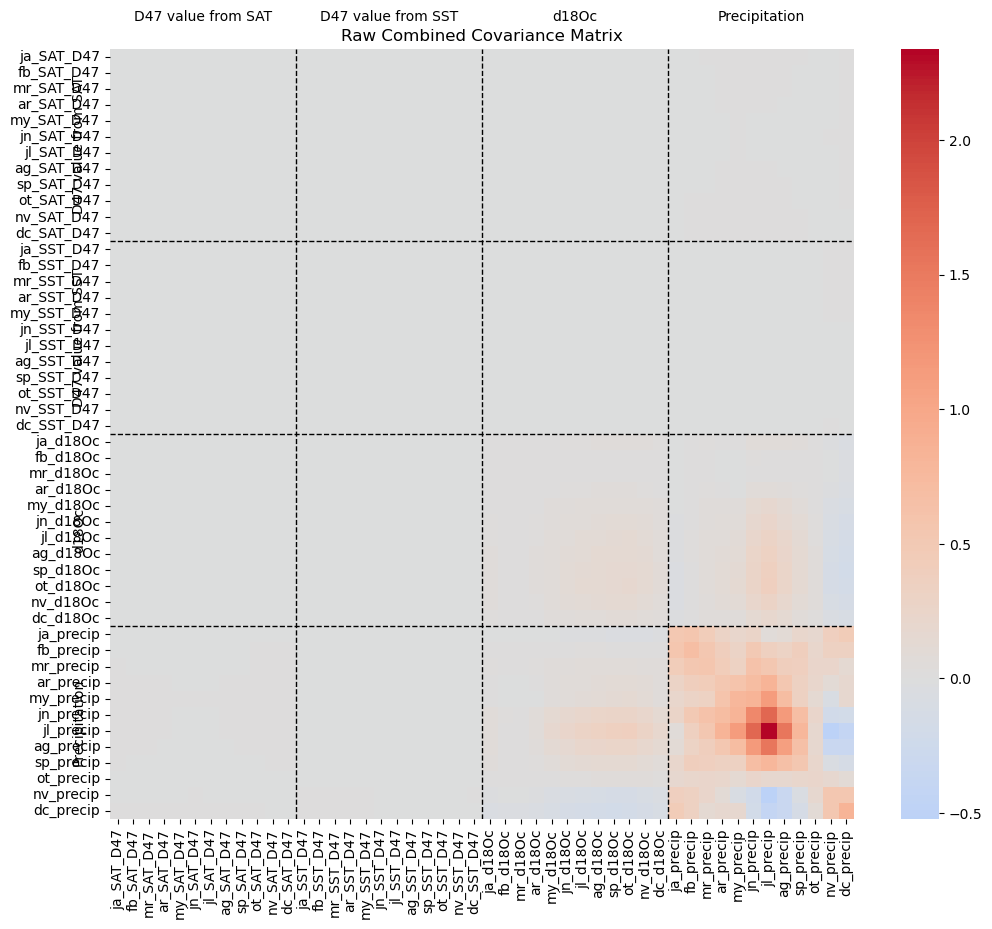

In [16]:
# Define column names for SAT, SST, d18Oc, and precipitation
SAT_D47_columns_monthly = [f"{month}_SAT_D47" for month in months]
SST_D47_columns_monthly = [f"{month}_SST_D47" for month in months]
d18Oc_columns_monthly = [f"{month}_d18Oc" for month in months]
precip_columns_monthly = [f"{month}_precip" for month in months]

# Extract the relevant columns for SAT, SST D47, d18Oc, and precipitation
SAT_D47_columns_monthly = [f"{month}_SAT_D47" for month in months]
SST_D47_columns_monthly = [f"{month}_SST_D47" for month in months]
d18Oc_columns_monthly = [f"{month}_d18Oc" for month in months]
precip_columns_monthly = [f"{month}_precip" for month in months]

# Combine the relevant columns into a single dataframe
combined_data_monthly = Lutetian_models[SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly]

# Calculate the covariance matrix for the combined data
cov_combined_monthly = np.cov(combined_data_monthly.dropna(), rowvar=False)

# Plot the heatmap of the raw combined covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cov_combined_monthly,  # Use the raw covariance matrix
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    xticklabels=SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly,
    yticklabels=SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly
)

# Add titles to the axes per parameter
plt.axvline(x=len(SAT_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly), color='black', linestyle='--', linewidth=1)

plt.axhline(y=len(SAT_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly), color='black', linestyle='--', linewidth=1)

# Add parameter labels
plt.text(len(SAT_D47_columns_monthly) / 2, -2, 'D47 value from SAT', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) / 2, -2, 'D47 value from SST', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) / 2, -2, 'd18Oc', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) + len(precip_columns_monthly) / 2, -2, 'Precipitation', ha='center', va='center', fontsize=10)

plt.text(-2, len(SAT_D47_columns_monthly) / 2, 'D47 value from SAT', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-2, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) / 2, 'D47 value from SST', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-2, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) / 2, 'd18Oc', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-2, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) + len(precip_columns_monthly) / 2, 'Precipitation', ha='center', va='center', rotation=90, fontsize=10)

plt.title("Raw Combined Covariance Matrix")
plt.show()

## Plot normalized monthly covariance matrix between D47 values of SST and SAT, d18Oc and precipitation

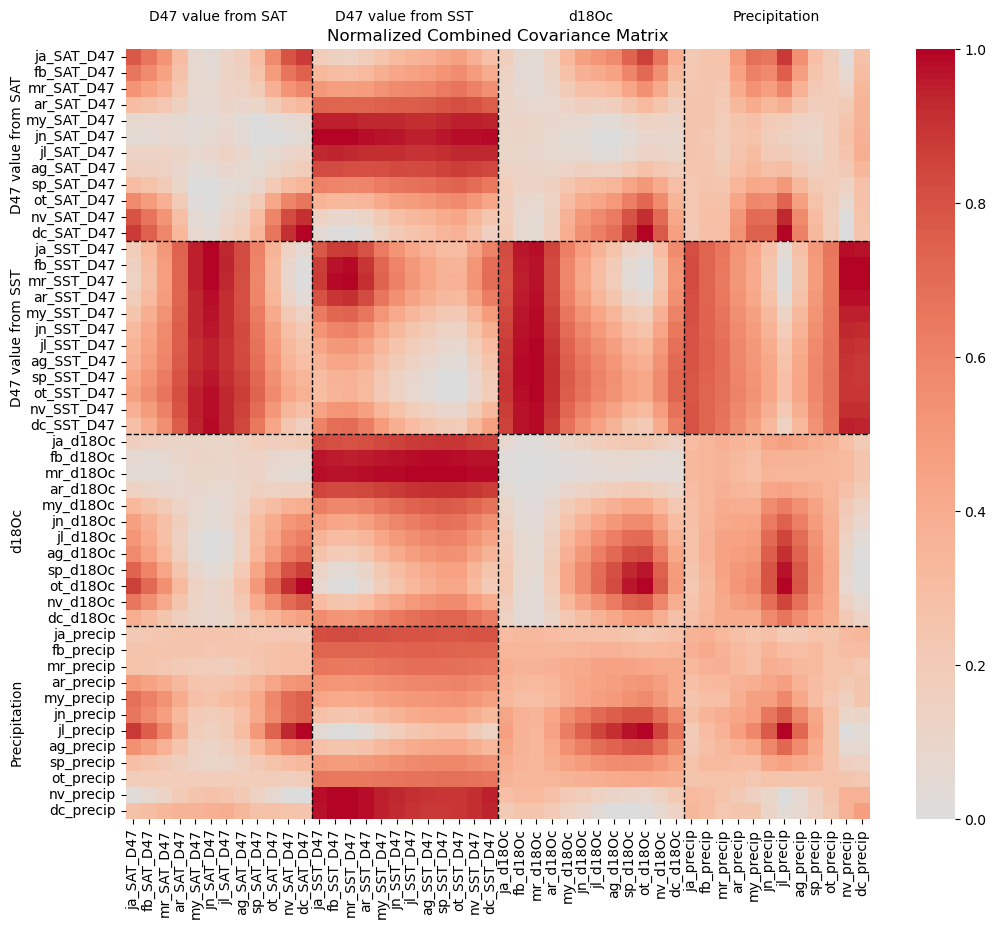

In [17]:
# Normalize each submatrix independently for better visualization
def normalize_matrix(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val)

# Extract the relevant columns for SAT, SST D47, d18Oc, and precipitation
SAT_D47_columns_monthly = [f"{month}_SAT_D47" for month in months]
SST_D47_columns_monthly = [f"{month}_SST_D47" for month in months]
d18Oc_columns_monthly = [f"{month}_d18Oc" for month in months]
precip_columns_monthly = [f"{month}_precip" for month in months]

# Combine the relevant columns into a single dataframe
combined_data_monthly = Lutetian_models[SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly]

# Calculate the covariance matrix for the combined data
cov_combined_monthly = np.cov(combined_data_monthly.dropna(), rowvar=False)

# Extract the covariance matrices for SAT D47, SST D47, d18Oc, and precipitation
cov_SAT_D47_monthly = cov_combined_monthly[:len(months), :len(months)]
cov_SST_D47_monthly = cov_combined_monthly[len(months):2*len(months), len(months):2*len(months)]
cov_d18Oc_monthly = cov_combined_monthly[2*len(months):3*len(months), 2*len(months):3*len(months)]
cov_precip_monthly = cov_combined_monthly[3*len(months):, 3*len(months):]

# Extract the cross-covariance matrices
cross_cov_SAT_SST_D47_monthly = cov_combined_monthly[:len(months), len(months):2*len(months)]
cross_cov_SAT_d18Oc_monthly = cov_combined_monthly[:len(months), 2*len(months):3*len(months)]
cross_cov_SAT_precip_monthly = cov_combined_monthly[:len(months), 3*len(months):]
cross_cov_SST_d18Oc_monthly = cov_combined_monthly[len(months):2*len(months), 2*len(months):3*len(months)]
cross_cov_SST_precip_monthly = cov_combined_monthly[len(months):2*len(months), 3*len(months):]
cross_cov_d18Oc_precip_monthly = cov_combined_monthly[2*len(months):3*len(months), 3*len(months):]

# Normalize each submatrix
normalized_cov_SAT_D47_monthly = normalize_matrix(cov_SAT_D47_monthly)
normalized_cov_SST_D47_monthly = normalize_matrix(cov_SST_D47_monthly)
normalized_cov_d18Oc_monthly = normalize_matrix(cov_d18Oc_monthly)
normalized_cov_precip_monthly = normalize_matrix(cov_precip_monthly)

# Normalize each cross-covariance matrix
normalized_cross_cov_SAT_SST_D47_monthly = normalize_matrix(cross_cov_SAT_SST_D47_monthly)
normalized_cross_cov_SAT_d18Oc_monthly = normalize_matrix(cross_cov_SAT_d18Oc_monthly)
normalized_cross_cov_SAT_precip_monthly = normalize_matrix(cross_cov_SAT_precip_monthly)
normalized_cross_cov_SST_d18Oc_monthly = normalize_matrix(cross_cov_SST_d18Oc_monthly)
normalized_cross_cov_SST_precip_monthly = normalize_matrix(cross_cov_SST_precip_monthly)
normalized_cross_cov_d18Oc_precip_monthly = normalize_matrix(cross_cov_d18Oc_precip_monthly)

# Combine the normalized submatrices into a single normalized covariance matrix
normalized_cov_combined_monthly = np.block([
    [normalized_cov_SAT_D47_monthly, normalized_cross_cov_SAT_SST_D47_monthly, normalized_cross_cov_SAT_d18Oc_monthly, normalized_cross_cov_SAT_precip_monthly],
    [normalized_cross_cov_SAT_SST_D47_monthly.T, normalized_cov_SST_D47_monthly, normalized_cross_cov_SST_d18Oc_monthly, normalized_cross_cov_SST_precip_monthly],
    [normalized_cross_cov_SAT_d18Oc_monthly.T, normalized_cross_cov_SST_d18Oc_monthly.T, normalized_cov_d18Oc_monthly, normalized_cross_cov_d18Oc_precip_monthly],
    [normalized_cross_cov_SAT_precip_monthly.T, normalized_cross_cov_SST_precip_monthly.T, normalized_cross_cov_d18Oc_precip_monthly.T, normalized_cov_precip_monthly]
])

# Plot the heatmap of the normalized combined covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    normalized_cov_combined_monthly,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    xticklabels=SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly,
    yticklabels=SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly
)

# Add titles to the axes per parameter
plt.axvline(x=len(SAT_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly), color='black', linestyle='--', linewidth=1)

plt.axhline(y=len(SAT_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly), color='black', linestyle='--', linewidth=1)

# Add parameter labels
plt.text(len(SAT_D47_columns_monthly) / 2, -2, 'D47 value from SAT', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) / 2, -2, 'D47 value from SST', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) / 2, -2, 'd18Oc', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) + len(precip_columns_monthly) / 2, -2, 'Precipitation', ha='center', va='center', fontsize=10)

plt.text(-7, len(SAT_D47_columns_monthly) / 2, 'D47 value from SAT', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-7, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) / 2, 'D47 value from SST', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-7, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) / 2, 'd18Oc', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-7, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) + len(precip_columns_monthly) / 2, 'Precipitation', ha='center', va='center', rotation=90, fontsize=10)

plt.title("Normalized Combined Covariance Matrix")
plt.show()

## Create combined monthly state vector

In [18]:
# Combine the prior means of D47 and SAT into a single state vector
mu_prior_monthly_combined = np.concatenate((mu_prior_SST_D47_monthly, mu_prior_SAT_D47_monthly, mu_prior_d18Oc_monthly, mu_prior_precip_monthly))

# Combine the covariance matrices of D47 values of SST and SAT, including the cross-covariance
cov_prior_monthly_combined = cov_combined_monthly.copy()

# PRIOR - SEASONAL

## Seasonal model data (convert the model data to seasonal means)

In [19]:
# Define the seasons
seasons = {
    "winter": ["dc", "ja", "fb"],
    "spring": ["mr", "ar", "my"],
    "summer": ["jn", "jl", "ag"],
    "autumn": ["sp", "ot", "nv"],
}

# Stack monthly columns to create seasonal dataframes
# Initialize dictionaries to store seasonal data
Lutetian_models_seasonal_dict = {}

# Identify the columns to process (all except the modelname column)
columns_to_process = [col for col in Lutetian_models.columns if any(suffix in col for suffix in [
    '_SST', '_SAT', '_SST_D47', '_SST_D47_SE', '_SAT_D47', '_SAT_D47_SE',
    '_SSS', '_d18Oc', '_precip'
])]

# Process each season
for season, months in seasons.items():  # Iterate over the seasons and corresponding months
    for col in columns_to_process:  # Iterate over the columns to process
        base_col_name = col.split('_')[0]  # Extract the base column name
        suffix = '_'.join(col.split('_')[1:])  # Extract the suffix
        if base_col_name in months:  # Check if the column corresponds to the current season
            season_col_name = f"{season}_{suffix}"  # Create the new column name
            if season_col_name not in Lutetian_models_seasonal_dict:  # Check if the new column name already exists in the seasonal data
                Lutetian_models_seasonal_dict[season_col_name] = []  # If not, initialize a new column in the seasonal data means
            Lutetian_models_seasonal_dict[season_col_name].append(Lutetian_models[col])

# Combine the seasonal data into a single dataframe
Lutetian_models_seasonal = pd.DataFrame()
for season_col_name, data in Lutetian_models_seasonal_dict.items():
    # Concatenate the data for each season and reshape it properly
    concatenated_data = pd.concat(data, axis=0).reset_index(drop=True)
    Lutetian_models_seasonal[season_col_name] = concatenated_data

# Add model names
Lutetian_models_seasonal["Cell"] = np.tile(Lutetian_models["Cell"].values, 3)  # Repeat the model names for each season

# Display the new seasonal DataFrame
D47_columns_seasonal = [col for col in Lutetian_models_seasonal.columns if col.endswith('_D47')]
D47_se_columns_seasonal = [col for col in Lutetian_models_seasonal.columns if '_D47_SE' in col]
SSS_columns_seasonal = [col for col in Lutetian_models_seasonal.columns if col.endswith('_SSS')]
d18Oc_columns_seasonal = [col for col in Lutetian_models_seasonal.columns if col.endswith('_d18Oc')]
precip_columns_seasonal = [col for col in Lutetian_models_seasonal.columns if col.endswith('_precip')]

print("Seasonal D47 values for all SST model outcomes:\n", Lutetian_models_seasonal[D47_columns_seasonal].head())
print("Calibration standard errors for all SST model outcomes:\n", Lutetian_models_seasonal[D47_se_columns_seasonal].head())
print("Seasonal SSS values for all model outcomes:\n", Lutetian_models_seasonal[SSS_columns_seasonal].head())
print("Seasonal d18Oc values for all model outcomes:\n", Lutetian_models_seasonal[d18Oc_columns_seasonal].head())
print("Seasonal precipitation values for all model outcomes:\n", Lutetian_models_seasonal[precip_columns_seasonal].head())

Seasonal D47 values for all SST model outcomes:
    winter_SAT_D47  winter_SST_D47  spring_SAT_D47  spring_SST_D47  \
0        0.649217        0.599785        0.641333        0.601218   
1        0.612951        0.600773        0.607858        0.602052   
2        0.612374        0.601927        0.608217        0.602959   
3        0.610292        0.626286        0.607520        0.629461   
4        0.614221        0.626260        0.609521        0.629846   

   summer_SAT_D47  summer_SST_D47  autumn_SAT_D47  autumn_SST_D47  
0        0.600021        0.579938        0.600895        0.570273  
1        0.575798        0.582065        0.573181        0.571820  
2        0.577980        0.583144        0.573023        0.572771  
3        0.579040        0.602450        0.573334        0.589301  
4        0.574258        0.603027        0.571039        0.589482  
Calibration standard errors for all SST model outcomes:
    winter_SAT_D47_SE  winter_SST_D47_SE  spring_SAT_D47_SE  spring_SST_

## Calculate the seasonal prior for model SST- and SAT-derived D47 values and SSS-derived seawater oxygen isotope values with propagated uncertainty

In [20]:
# Prior estimates from climate models (mean)
mu_prior_SAT_seasonal = np.array(Lutetian_models_seasonal[[f"{season}_SAT" for season in seasons]].mean(axis=0, skipna=True))
mu_prior_SST_seasonal = np.array(Lutetian_models_seasonal[[f"{season}_SST" for season in seasons]].mean(axis=0, skipna=True))
mu_prior_SSS_seasonal = np.array(Lutetian_models_seasonal[[f"{season}_SSS" for season in seasons]].mean(axis=0, skipna=True))
mu_prior_precip_seasonal = np.array(Lutetian_models_seasonal[[f"{season}_precip" for season in seasons]].mean(axis=0, skipna=True))

# Covariance between seasons in prior estimates from climate models (covariance matrix)
cov_prior_SAT_seasonal = np.cov(Lutetian_models_seasonal[[f"{season}_SAT" for season in seasons]].dropna(), rowvar=False)
cov_prior_SST_seasonal = np.cov(Lutetian_models_seasonal[[f"{season}_SST" for season in seasons]].dropna(), rowvar=False)
cov_prior_SSS_seasonal = np.cov(Lutetian_models_seasonal[[f"{season}_SSS" for season in seasons]].dropna(), rowvar=False)
cov_prior_precip_seasonal = np.cov(Lutetian_models_seasonal[[f"{season}_precip" for season in seasons]].dropna(), rowvar=False)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SAT_seasonal_original, cov_prior_SAT_seasonal_original = mu_prior_SAT_seasonal.copy(), cov_prior_SAT_seasonal.copy()
mu_prior_SST_seasonal_original, cov_prior_SST_seasonal_original = mu_prior_SST_seasonal.copy(), cov_prior_SST_seasonal.copy()
mu_prior_SSS_seasonal_original, cov_prior_SSS_seasonal_original = mu_prior_SSS_seasonal.copy(), cov_prior_SSS_seasonal.copy()
mu_prior_precip_seasonal_original, cov_prior_precip_seasonal_original = mu_prior_precip_seasonal.copy(), cov_prior_precip_seasonal.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SAT_seasonal = np.sqrt(np.diag(cov_prior_SAT_seasonal))
std_prior_SST_seasonal = np.sqrt(np.diag(cov_prior_SST_seasonal))
std_prior_SSS_seasonal = np.sqrt(np.diag(cov_prior_SSS_seasonal))
std_prior_precip_seasonal = np.sqrt(np.diag(cov_prior_precip_seasonal))

# Print the results
print("SAT Seasonal Means:", mu_prior_SAT_seasonal)
print("SAT Seasonal Std Devs:", std_prior_SAT_seasonal)
print("SST Seasonal Means:", mu_prior_SST_seasonal)
print("SST Seasonal Std Devs:", std_prior_SST_seasonal)
print("SSS Seasonal Means:", mu_prior_SSS_seasonal)
print("SSS Seasonal Std Devs:", std_prior_SSS_seasonal)
print("Precipitation Seasonal Means:", mu_prior_precip_seasonal)
print("Precipitation Seasonal Std Devs:", std_prior_precip_seasonal)

SAT Seasonal Means: [13.42958659 18.92326172 29.56127848 22.02235189]
SAT Seasonal Std Devs: [3.52718206 4.26532565 3.21073789 5.59623215]
SST Seasonal Means: [21.39896221 21.9329016  30.43864689 28.24186713]
SST Seasonal Std Devs: [3.17341568 3.29531043 2.99844317 3.12219118]
SSS Seasonal Means: [34.57900297 34.49966839 34.47438155 34.55820643]
SSS Seasonal Std Devs: [2.85616522 2.82803739 2.93481705 2.99611031]
Precipitation Seasonal Means: [2.14603346 2.07010049 2.10993912 1.93140477]
Precipitation Seasonal Std Devs: [0.81553271 0.83490324 1.26099727 0.74208678]


## Plot the seasonal prior for model SST, SAT, SSS and precipitation

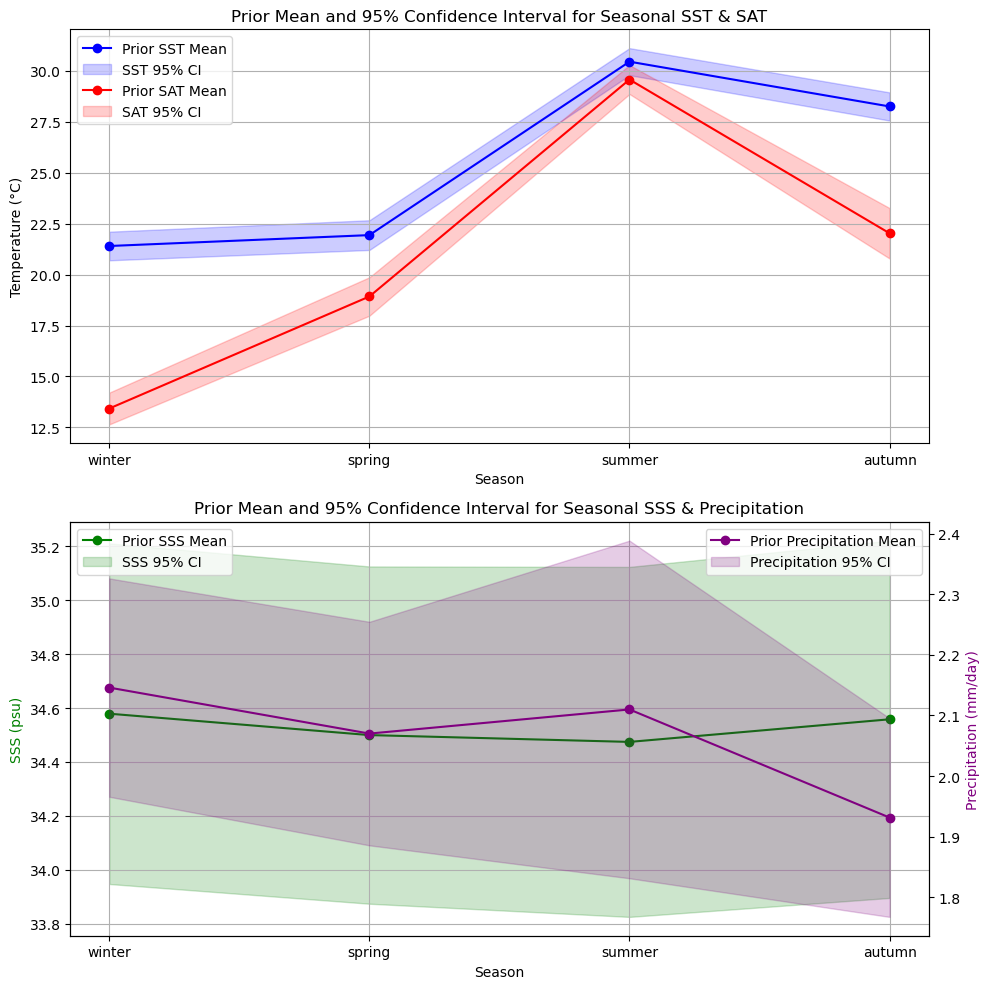

In [21]:
# Define the seasons, number of models, and scale for the x-axis
seasons = ["winter", "spring", "summer", "autumn"]
n_models_seasonal = len(Lutetian_models["Cell"])  # Find the total number of models
seasons_scale = np.arange(len(seasons)) + 1  # Create seasonal scale

# Create a 1x2 plotting grid
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Panel 1: Plot the prior distribution for SST and SAT
axes[0].plot(seasons_scale, mu_prior_SST_seasonal, label='Prior SST Mean', marker='o', color='b')
axes[0].fill_between(
    seasons_scale,
    mu_prior_SST_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SST_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, color='b', label='SST 95% CI'
)
axes[0].plot(seasons_scale, mu_prior_SAT_seasonal, label='Prior SAT Mean', marker='o', color='r')
axes[0].fill_between(
    seasons_scale,
    mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, color='r', label='SAT 95% CI'
)
axes[0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SST & SAT')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_xticks(seasons_scale)
axes[0].set_xticklabels(seasons)
axes[0].legend()
axes[0].grid(True)

# Panel 2: Plot the prior distribution for SSS and precipitation
axes[1].plot(seasons_scale, mu_prior_SSS_seasonal, label='Prior SSS Mean', marker='o', color='g')
ax2 = axes[1].twinx()  # Create a secondary y-axis for precipitation
ax2.plot(seasons_scale, mu_prior_precip_seasonal, label='Prior Precipitation Mean', marker='o', color='purple')

# Add 95% confidence intervals for SSS
axes[1].fill_between(
    seasons_scale,
    mu_prior_SSS_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SSS_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, color='g', label='SSS 95% CI'
)

# Add 95% confidence intervals for precipitation
ax2.fill_between(
    seasons_scale,
    mu_prior_precip_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_precip_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, color='purple', label='Precipitation 95% CI'
)

axes[1].set_title('Prior Mean and 95% Confidence Interval for Seasonal SSS & Precipitation')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('SSS (psu)', color='g')
ax2.set_ylabel('Precipitation (mm/day)', color='purple')
axes[1].set_xticks(seasons_scale)
axes[1].set_xticklabels(seasons)
axes[1].legend(loc='upper left')
ax2.legend(loc='upper right')
axes[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Calculate the seasonal prior for model SST and SAT-derived D47 values with propagated uncertainty

In [22]:
# Set the weights of the data based on the standard errors
weights_seasonal_SST_D47 = 1 / Lutetian_models_seasonal[[f"{season}_SST_D47_SE" for season in seasons]] ** 2
weights_seasonal_SAT_D47 = 1 / Lutetian_models_seasonal[[f"{season}_SAT_D47_SE" for season in seasons]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_seasonal to match the headers of the D47 matrix later for multiplication
weights_seasonal_SST_D47.columns = [col.replace('_SST_D47_SE', '_SST_D47') for col in weights_seasonal_SST_D47.columns]
weights_seasonal_SAT_D47.columns = [col.replace('_SAT_D47_SE', '_SAT_D47') for col in weights_seasonal_SAT_D47.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_SST_D47_seasonal = np.array((Lutetian_models_seasonal[[f"{season}_SST_D47" for season in seasons]] * weights_seasonal_SST_D47).sum(axis = 0, skipna = True) / weights_seasonal_SST_D47.sum(axis = 0, skipna = True)) # Calculate weighted seasonal mean D47 values and convert to numpy array
mu_prior_SAT_D47_seasonal = np.array((Lutetian_models_seasonal[[f"{season}_SAT_D47" for season in seasons]] * weights_seasonal_SAT_D47).sum(axis = 0, skipna = True) / weights_seasonal_SAT_D47.sum(axis = 0, skipna = True)) # Calculate weighted seasonal mean D47 values and convert to numpy array

# Calculate simple (unweighted) mean for monthly d18Oc values
mu_prior_d18Oc_seasonal = np.array(Lutetian_models_seasonal[[f"{season}_d18Oc" for season in seasons]].mean(axis=0, skipna=True))
mu_prior_precip_seasonal = np.array(Lutetian_models_seasonal[[f"{season}_precip" for season in seasons]].mean(axis=0, skipna=True))

# Decompose variance within and between model outcomes
model_variances_SST_D47 = Lutetian_models_seasonal[[f"{season}_SST_D47" for season in seasons]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_SAT_D47 = Lutetian_models_seasonal[[f"{season}_SAT_D47" for season in seasons]].var(axis = 0, ddof = 1)  # Compute variance across models
measurement_variances_SST_D47 = (Lutetian_models_seasonal[[f"{season}_SST_D47_SE" for season in seasons]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements
measurement_variances_SAT_D47 = (Lutetian_models_seasonal[[f"{season}_SAT_D47_SE" for season in seasons]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements

# Covariance between seasons in prior D47 estimates from climate models (weighted covariance matrix)
cov_raw_seasonal_SST_D47 = np.cov(Lutetian_models_seasonal[[f"{season}_SST_D47" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_seasonal_SAT_D47 = np.cov(Lutetian_models_seasonal[[f"{season}_SAT_D47" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_seasonal_d18Oc = np.cov(Lutetian_models_seasonal[[f"{season}_d18Oc" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_seasonal_precip = np.cov(Lutetian_models_seasonal[[f"{season}_precip" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_SST_D47_seasonal = cov_raw_seasonal_SST_D47.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_SAT_D47_seasonal = cov_raw_seasonal_SAT_D47.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_d18Oc_seasonal = cov_raw_seasonal_d18Oc.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_precip_seasonal = cov_raw_seasonal_precip.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
np.fill_diagonal(cov_prior_SST_D47_seasonal, np.diagonal(cov_raw_seasonal_SST_D47) + measurement_variances_SST_D47)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)
np.fill_diagonal(cov_prior_SAT_D47_seasonal, np.diagonal(cov_raw_seasonal_SAT_D47) + measurement_variances_SAT_D47)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SST_D47_seasonal_original, cov_prior_SST_D47_seasonal_original = mu_prior_SST_D47_seasonal.copy(), cov_prior_SST_D47_seasonal.copy()
mu_prior_SAT_D47_seasonal_original, cov_prior_SAT_D47_seasonal_original = mu_prior_SAT_D47_seasonal.copy(), cov_prior_SAT_D47_seasonal.copy()
mu_prior_d18Oc_seasonal_original, cov_prior_d18Oc_seasonal_original = mu_prior_d18Oc_seasonal.copy(), cov_raw_seasonal_d18Oc.copy()
mu_prior_precip_seasonal_original, cov_prior_precip_seasonal_original = mu_prior_precip_seasonal.copy(), cov_raw_seasonal_precip.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SST_D47_seasonal = np.sqrt(np.diag(cov_prior_SST_D47_seasonal))
std_prior_SAT_D47_seasonal = np.sqrt(np.diag(cov_prior_SAT_D47_seasonal))
std_prior_d18Oc_seasonal = np.sqrt(np.diag(cov_prior_d18Oc_seasonal))
std_prior_precip_seasonal = np.sqrt(np.diag(cov_prior_precip_seasonal))

print("mu_prior_SST_D47_seasonal:", mu_prior_SST_D47_seasonal)
print("std_prior_SST_D47_seasonal:", std_prior_SST_D47_seasonal)
print("mu_prior_SAT_D47_seasonal:", mu_prior_SAT_D47_seasonal)
print("std_prior_SAT_D47_seasonal:", std_prior_SAT_D47_seasonal)
print("mu_prior_d18Oc_seasonal:", mu_prior_d18Oc_seasonal)
print("std_prior_d18Oc_seasonal:", std_prior_d18Oc_seasonal)
print("mu_prior_precip_seasonal:", mu_prior_precip_seasonal)
print("std_prior_precip_seasonal:", std_prior_precip_seasonal)

mu_prior_SST_D47_seasonal: [0.60393768 0.60228226 0.577512   0.58376829]
std_prior_SST_D47_seasonal: [0.01021423 0.01052491 0.00874526 0.00924976]
mu_prior_SAT_D47_seasonal: [0.62932281 0.61128625 0.58005461 0.60137681]
std_prior_SAT_D47_seasonal: [0.01198867 0.01375352 0.0093188  0.01752289]
mu_prior_d18Oc_seasonal: [-0.27944586 -0.42421105 -2.39098879 -1.86185031]
std_prior_d18Oc_seasonal: [0.45047839 0.51219609 0.60550339 0.74765709]
mu_prior_precip_seasonal: [2.14603346 2.07010049 2.10993912 1.93140477]
std_prior_precip_seasonal: [0.81553271 0.83490324 1.26099727 0.74208678]


## Plot the seasonal prior for model SST- and SAT-derived D47 values, d18Oc values and precipitation with propagated uncertainty

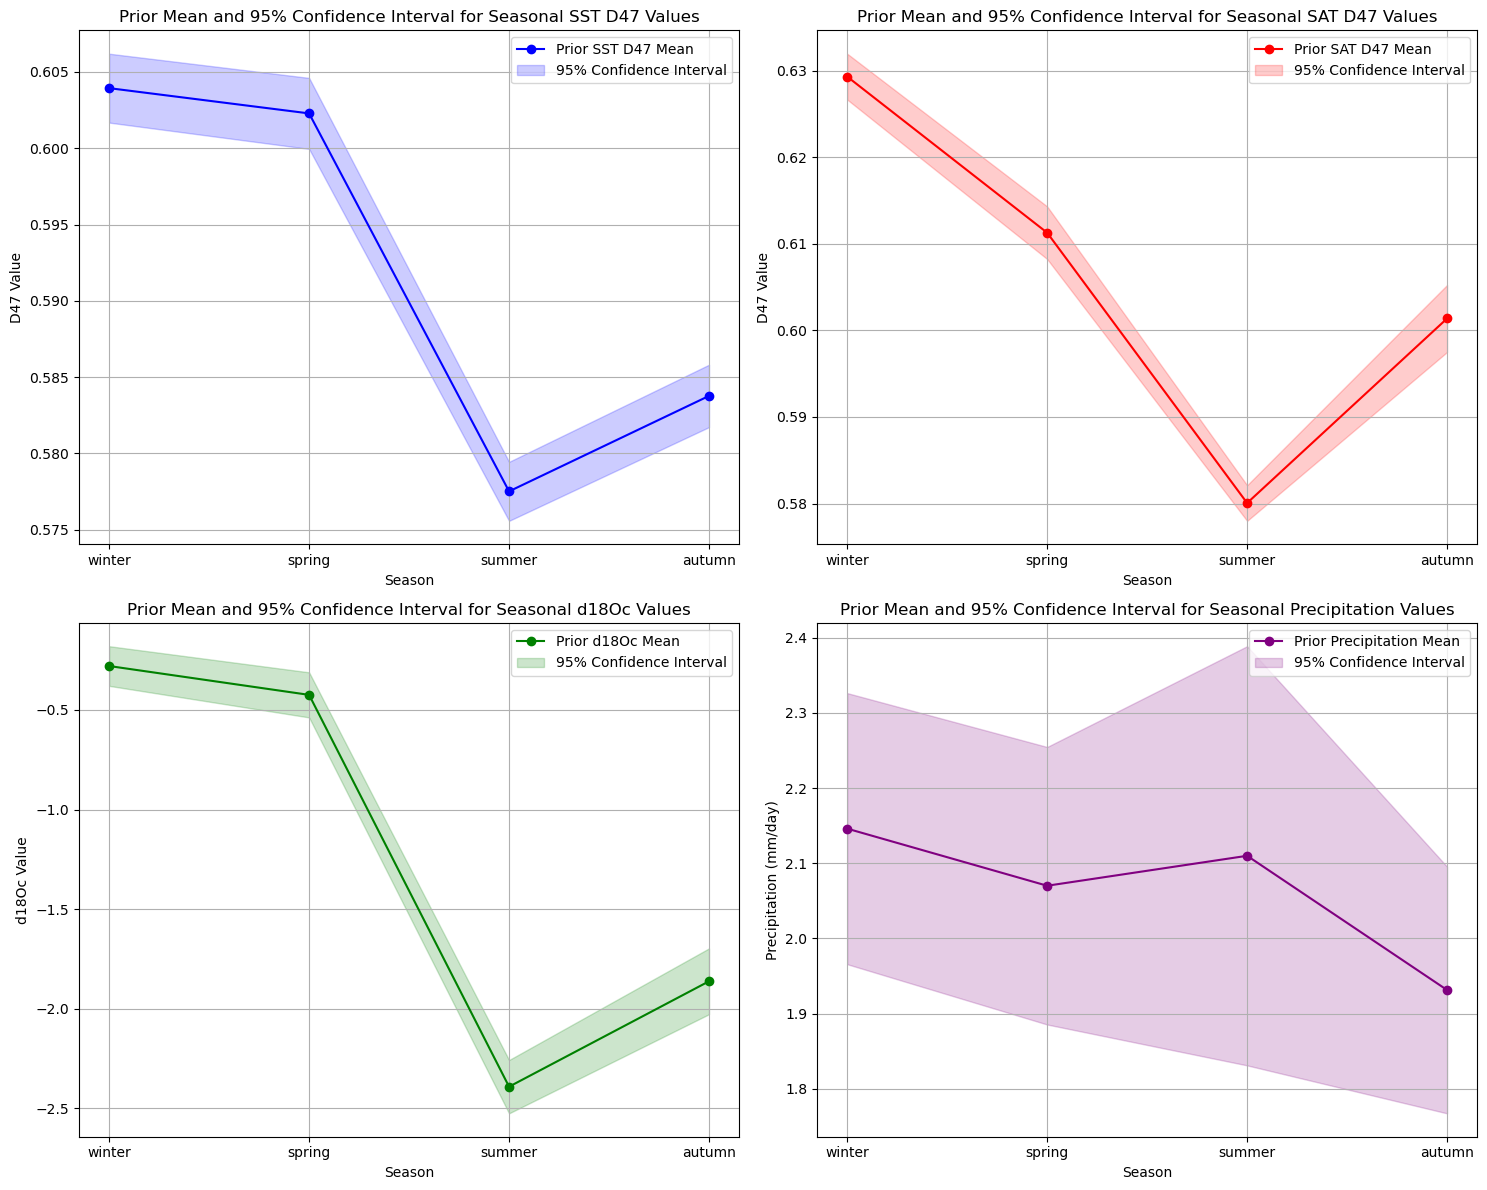

In [23]:
# Define the seasons, number of models, and scale for the x-axis
seasons = ["winter", "spring", "summer", "autumn"]
n_models_seasonal = len(Lutetian_models["Cell"])  # Find the total number of models (use monthly data because seasonal data has this column duplicated 3 times)
seasons_scale = np.arange(len(seasons)) + 1  # Create seasonal scale

# Create a 2x2 plotting grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Panel 1: Plot the prior distribution for SST D47 values
axes[0, 0].plot(seasons_scale, mu_prior_SST_D47_seasonal[:len(seasons)], label='Prior SST D47 Mean', marker='o', color='b')
axes[0, 0].fill_between(
    seasons_scale,
    mu_prior_SST_D47_seasonal[:len(seasons)] - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SST_D47_seasonal[:len(seasons)] + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, color='b', label='95% Confidence Interval'
)
axes[0, 0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SST D47 Values')
axes[0, 0].set_xlabel('Season')
axes[0, 0].set_ylabel('D47 Value')
axes[0, 0].set_xticks(seasons_scale)
axes[0, 0].set_xticklabels(seasons)
axes[0, 0].legend()
axes[0, 0].grid(True)

# Panel 2: Plot the prior distribution for SAT D47 values
axes[0, 1].plot(seasons_scale, mu_prior_SAT_D47_seasonal[:len(seasons)], label='Prior SAT D47 Mean', marker='o', color='r')
axes[0, 1].fill_between(
    seasons_scale,
    mu_prior_SAT_D47_seasonal[:len(seasons)] - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_D47_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_D47_seasonal[:len(seasons)] + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_D47_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, color='r', label='95% Confidence Interval'
)
axes[0, 1].set_title('Prior Mean and 95% Confidence Interval for Seasonal SAT D47 Values')
axes[0, 1].set_xlabel('Season')
axes[0, 1].set_ylabel('D47 Value')
axes[0, 1].set_xticks(seasons_scale)
axes[0, 1].set_xticklabels(seasons)
axes[0, 1].legend()
axes[0, 1].grid(True)

# Panel 3: Plot the prior distribution for d18Oc
axes[1, 0].plot(seasons_scale, mu_prior_d18Oc_seasonal, label='Prior d18Oc Mean', marker='o', color='g')
axes[1, 0].fill_between(
    seasons_scale,
    mu_prior_d18Oc_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_d18Oc_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_d18Oc_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_d18Oc_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, color='g', label='95% Confidence Interval'
)
axes[1, 0].set_title('Prior Mean and 95% Confidence Interval for Seasonal d18Oc Values')
axes[1, 0].set_xlabel('Season')
axes[1, 0].set_ylabel('d18Oc Value')
axes[1, 0].set_xticks(seasons_scale)
axes[1, 0].set_xticklabels(seasons)
axes[1, 0].legend()
axes[1, 0].grid(True)

# Panel 4: Plot the prior distribution for precipitation
axes[1, 1].plot(seasons_scale, mu_prior_precip_seasonal, label='Prior Precipitation Mean', marker='o', color='purple')
axes[1, 1].fill_between(
    seasons_scale,
    mu_prior_precip_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_precip_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, color='purple', label='95% Confidence Interval'
)
axes[1, 1].set_title('Prior Mean and 95% Confidence Interval for Seasonal Precipitation Values')
axes[1, 1].set_xlabel('Season')
axes[1, 1].set_ylabel('Precipitation (mm/day)')
axes[1, 1].set_xticks(seasons_scale)
axes[1, 1].set_xticklabels(seasons)
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Calculate the seasonal covariance matrix for D47 values derived from SST and SAT values, d18Oc and precipitation

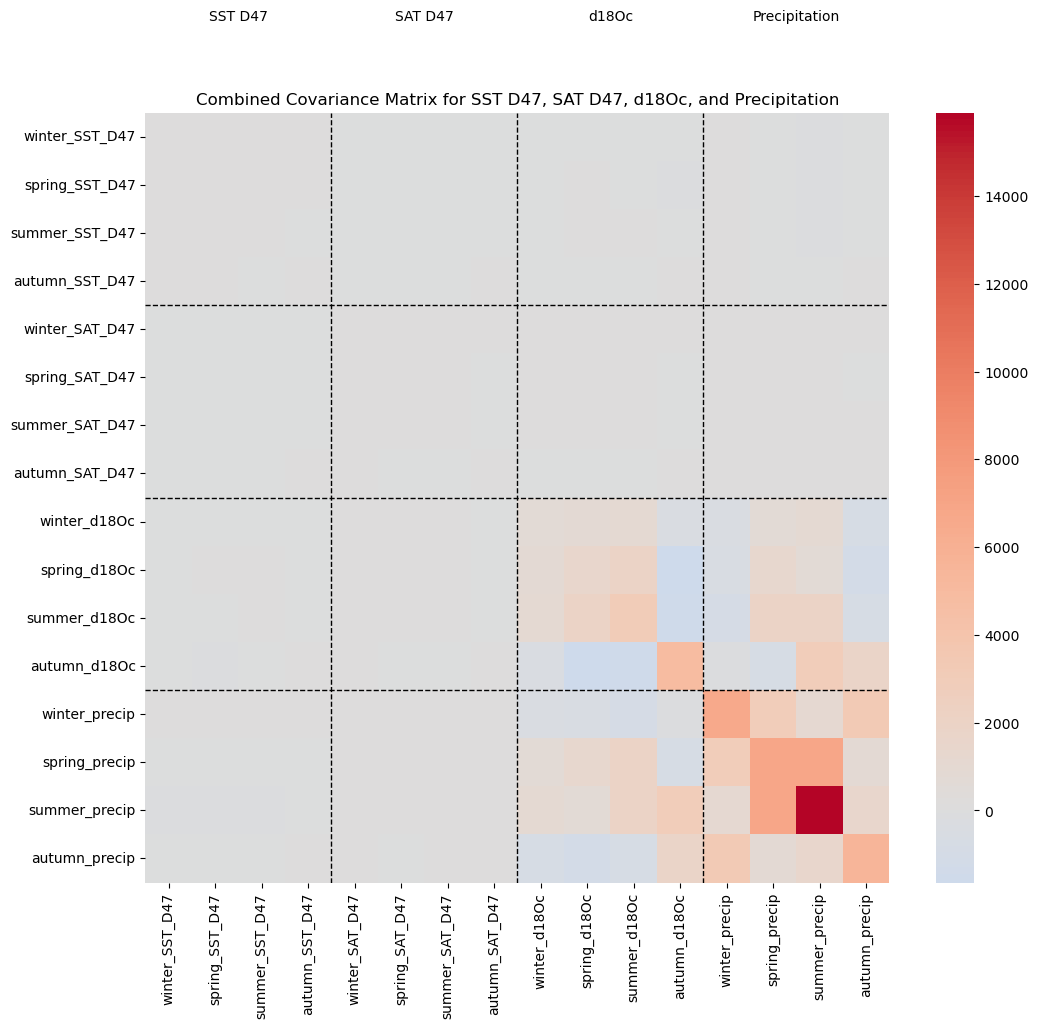

In [24]:
# Extract the relevant columns for SST, SAT D47, d18Oc, and precipitation
SST_D47_columns_seasonal = [f"{season}_SST_D47" for season in seasons]
SAT_D47_columns_seasonal = [f"{season}_SAT_D47" for season in seasons]
d18Oc_columns_seasonal = [f"{season}_d18Oc" for season in seasons]
precip_columns_seasonal = [f"{season}_precip" for season in seasons]

# Combine the relevant columns into a single dataframe
combined_data_seasonal = Lutetian_models_seasonal[
    SST_D47_columns_seasonal + SAT_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal
]

# Calculate the covariance matrix for the combined data
cov_combined_seasonal = np.cov(combined_data_seasonal.dropna(), rowvar=False)

# Extract the covariance matrices for each variable
cov_SST_D47_seasonal = cov_combined_seasonal[:len(seasons), :len(seasons)]
cov_SAT_D47_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), len(seasons):2*len(seasons)]
cov_d18Oc_seasonal = cov_combined_seasonal[2*len(seasons):3*len(seasons), 2*len(seasons):3*len(seasons)]
cov_precip_seasonal = cov_combined_seasonal[3*len(seasons):, 3*len(seasons):]

# Extract the cross-covariance matrices
cross_cov_SST_SAT_D47_seasonal = cov_combined_seasonal[:len(seasons), len(seasons):2*len(seasons)]
cross_cov_SST_d18Oc_seasonal = cov_combined_seasonal[:len(seasons), 2*len(seasons):3*len(seasons)]
cross_cov_SST_precip_seasonal = cov_combined_seasonal[:len(seasons), 3*len(seasons):]
cross_cov_SAT_d18Oc_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), 2*len(seasons):3*len(seasons)]
cross_cov_SAT_precip_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), 3*len(seasons):]
cross_cov_d18Oc_precip_seasonal = cov_combined_seasonal[2*len(seasons):3*len(seasons), 3*len(seasons):]

# Plot a heatmap of the combined covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    np.round(cov_combined_seasonal * 10**4, 1),  # Scale by 10^4 for better visualization and round values
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    xticklabels=SST_D47_columns_seasonal + SAT_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal,
    yticklabels=SST_D47_columns_seasonal + SAT_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal
)

# Add titles to the axes per parameter
plt.axvline(x=len(SST_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) + len(d18Oc_columns_seasonal), color='black', linestyle='--', linewidth=1)

plt.axhline(y=len(SST_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) + len(d18Oc_columns_seasonal), color='black', linestyle='--', linewidth=1)

# Add parameter labels
plt.text(len(SST_D47_columns_seasonal) / 2, -2, 'SST D47', ha='center', va='center', fontsize=10)
plt.text(len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) / 2, -2, 'SAT D47', ha='center', va='center', fontsize=10)
plt.text(len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) + len(d18Oc_columns_seasonal) / 2, -2, 'd18Oc', ha='center', va='center', fontsize=10)
plt.text(len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) + len(d18Oc_columns_seasonal) + len(precip_columns_seasonal) / 2, -2, 'Precipitation', ha='center', va='center', fontsize=10)

plt.title("Combined Covariance Matrix for SST D47, SAT D47, d18Oc, and Precipitation")
plt.show()

## Plot normalized seasonal covariance matrix between D47 values of SST and SAT, d18Oc and precipitation

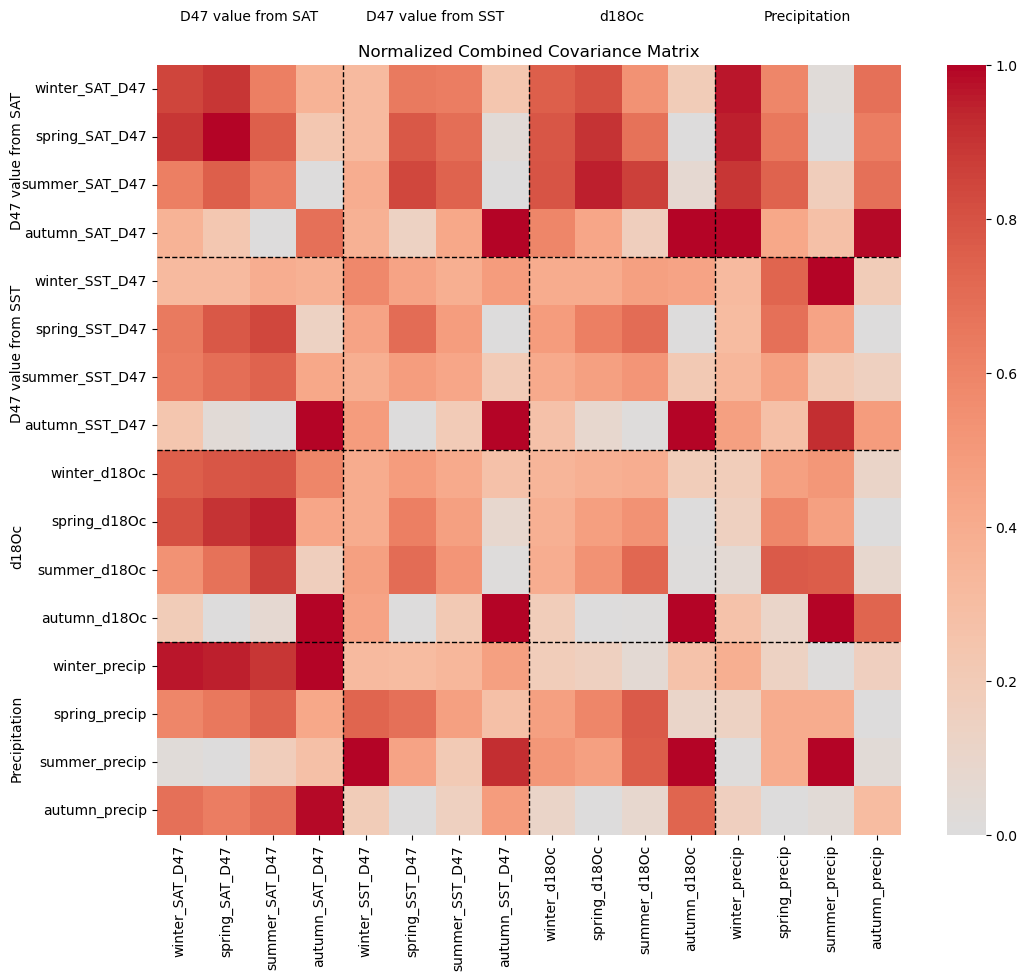

In [25]:
# Normalize each submatrix independently for better visualization
def normalize_matrix(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val)

# Extract the covariance matrices for SAT D47, SST D47, d18Oc, and precipitation
cov_SAT_D47_seasonal = cov_combined_seasonal[:len(seasons), :len(seasons)]
cov_SST_D47_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), len(seasons):2*len(seasons)]
cov_d18Oc_seasonal = cov_combined_seasonal[2*len(seasons):3*len(seasons), 2*len(seasons):3*len(seasons)]
cov_precip_seasonal = cov_combined_seasonal[3*len(seasons):, 3*len(seasons):]

# Extract the cross-covariance matrices
cross_cov_SAT_SST_D47_seasonal = cov_combined_seasonal[:len(seasons), len(seasons):2*len(seasons)]
cross_cov_SAT_d18Oc_seasonal = cov_combined_seasonal[:len(seasons), 2*len(seasons):3*len(seasons)]
cross_cov_SAT_precip_seasonal = cov_combined_seasonal[:len(seasons), 3*len(seasons):]
cross_cov_SST_d18Oc_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), 2*len(seasons):3*len(seasons)]
cross_cov_SST_precip_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), 3*len(seasons):]
cross_cov_d18Oc_precip_seasonal = cov_combined_seasonal[2*len(seasons):3*len(seasons), 3*len(seasons):]

# Normalize each submatrix
normalized_cov_SAT_D47_seasonal = normalize_matrix(cov_SAT_D47_seasonal)
normalized_cov_SST_D47_seasonal = normalize_matrix(cov_SST_D47_seasonal)
normalized_cov_d18Oc_seasonal = normalize_matrix(cov_d18Oc_seasonal)
normalized_cov_precip_seasonal = normalize_matrix(cov_precip_seasonal)

# Normalize each cross-covariance matrix
normalized_cross_cov_SAT_SST_D47_seasonal = normalize_matrix(cross_cov_SAT_SST_D47_seasonal)
normalized_cross_cov_SAT_d18Oc_seasonal = normalize_matrix(cross_cov_SAT_d18Oc_seasonal)
normalized_cross_cov_SAT_precip_seasonal = normalize_matrix(cross_cov_SAT_precip_seasonal)
normalized_cross_cov_SST_d18Oc_seasonal = normalize_matrix(cross_cov_SST_d18Oc_seasonal)
normalized_cross_cov_SST_precip_seasonal = normalize_matrix(cross_cov_SST_precip_seasonal)
normalized_cross_cov_d18Oc_precip_seasonal = normalize_matrix(cross_cov_d18Oc_precip_seasonal)

# Combine the normalized submatrices into a single normalized covariance matrix
normalized_cov_combined_seasonal = np.block([
    [normalized_cov_SAT_D47_seasonal, normalized_cross_cov_SAT_SST_D47_seasonal, normalized_cross_cov_SAT_d18Oc_seasonal, normalized_cross_cov_SAT_precip_seasonal],
    [normalized_cross_cov_SAT_SST_D47_seasonal.T, normalized_cov_SST_D47_seasonal, normalized_cross_cov_SST_d18Oc_seasonal, normalized_cross_cov_SST_precip_seasonal],
    [normalized_cross_cov_SAT_d18Oc_seasonal.T, normalized_cross_cov_SST_d18Oc_seasonal.T, normalized_cov_d18Oc_seasonal, normalized_cross_cov_d18Oc_precip_seasonal],
    [normalized_cross_cov_SAT_precip_seasonal.T, normalized_cross_cov_SST_precip_seasonal.T, normalized_cross_cov_d18Oc_precip_seasonal.T, normalized_cov_precip_seasonal]
])

# Plot the heatmap of the normalized combined covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    normalized_cov_combined_seasonal,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    xticklabels=SAT_D47_columns_seasonal + SST_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal,
    yticklabels=SAT_D47_columns_seasonal + SST_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal
)

# Add titles to the axes per parameter
plt.axvline(x=len(SAT_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal), color='black', linestyle='--', linewidth=1)

plt.axhline(y=len(SAT_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal), color='black', linestyle='--', linewidth=1)

# Add parameter labels
plt.text(len(SAT_D47_columns_seasonal) / 2, -1, 'D47 value from SAT', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) / 2, -1, 'D47 value from SST', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal) / 2, -1, 'd18Oc', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal) + len(precip_columns_seasonal) / 2, -1, 'Precipitation', ha='center', va='center', fontsize=10)

plt.text(-3, len(SAT_D47_columns_seasonal) / 2, 'D47 value from SAT', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-3, len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) / 2, 'D47 value from SST', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-3, len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal) / 2, 'd18Oc', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-3, len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal) + len(precip_columns_seasonal) / 2, 'Precipitation', ha='center', va='center', rotation=90, fontsize=10)

plt.title("Normalized Combined Covariance Matrix")
plt.show()

## Create combined seasonal state vector

In [26]:
# Combine the prior means of D47 and SAT into a single state vector
mu_prior_seasonal_combined = np.concatenate((mu_prior_SST_D47_seasonal, mu_prior_SAT_D47_seasonal, mu_prior_d18Oc_seasonal, mu_prior_precip_seasonal))

# Combine the covariance matrices of D47 values of SST and SAT, d18Oc and precipitation including the cross-covariance
cov_prior_seasonal_combined = cov_combined_seasonal.copy()

# OBSERVATIONS
## Load clumped data for updating
### Monthly data from Paris Basin Campanile giganteum paper (Van Horebeek et al. 2025)

In [27]:
# Load seasonal measurements and format them into a dictionary
# This is precompiled seasonal data per specimen and therefore does not come with a time uncertainty
Lutetian_seasonally_aggregated_data = pd.read_csv('Lutetian case/D47_season_data_calc.csv') # Load the data for seasonal averages
Lutetian_seasonally_aggregated_data_dict = Lutetian_seasonally_aggregated_data.to_dict('records') # Convert to dictionary with column headers as keys

# Add an entry for the time uncertainty (which is always zero in this case, because data is already aggregated monthly)
for record in Lutetian_seasonally_aggregated_data_dict:
    record["Season_err"] = 0 # Set the time uncertainty to zero
    record["D47_se"] = record["D47_SD"] / np.sqrt(record["count"]) # Calculate the standard error of the D47 value

print(Lutetian_seasonally_aggregated_data_dict[0]) # Print to check the structure of the data

{'Season': 'summer', 'Whorl...P.or.T': 'AW', 'X': 'AX', 'D47_mean': 0.589860492, 'D47_SD': 0.042653301, 'count': 62, 'd18O': -2.150527044, 'd18O_SD': 0.312787802, 'T': 27.892776, 'CL95': 0.010920335, 'CL95_T': 3.824099323, 'd18Osw': -0.27016391, 'DOY': 203.6572, 'Tmin': 24.20918351, 'Tmax': 31.71674359, 'dwmin': -1.11891794, 'dwmax': 0.610934613, 'Season_err': 0, 'D47_se': 0.005416974643977352}


### Raw data at the sample level

In [28]:
# Load measurements and format them into a dictionary
# These are the actual individual D47 and d18Oc measurements and ShellChron outcomes and thus come with a time uncertainty which can be propagated.
Lutetian_D47_data = pd.read_csv('Lutetian case/Campanile_sample_data_calc2.csv') # Load data for individual D47 and d18Oc measurements and ShellChron outcomes
Lutetian_data_dict = Lutetian_D47_data.to_dict('records') # Convert to dictionary with column headers as keys

# Add an entry for the time uncertainty (which is always zero in this case, because there is no time uncertainty in the raw data)
for record in Lutetian_data_dict:
    # Handle missing values and convert from days to months and seasons
    shell_chron_doy_err = record.get("DOY_SD", np.nan)  # Get value, default to NaN if missing
    if pd.isna(shell_chron_doy_err):  # Check if the value is NaN
        record["Month_err"] = 0 # Set the time uncertainty to zero
        record["Season_err"] = 0 # Set the time uncertainty to zero
        record["no_err"] = 0 # Set the time uncertainty to zero
    else:
        record["Month_err"] = shell_chron_doy_err / 365 * 12  # Convert days to months
        record["Season_err"] = shell_chron_doy_err / 365 * 4 # Convert days to seasons
        record["no_err"] = 0 # Set the time uncertainty to zero for no error
    # Assign the D47 value and its standard deviation
    record["D47_SD"] = 0.029 # Assign external standard deviation to the D47 value (based on reproducibility of IAEA-C2 measurements)
    record["season_score"] = np.floor(((record["DOY"] + 45) % 365) / 365 * 4) # Calculate the season score from DOY value (winter = 0, spring = 1, summer = 2, autumn = 3). Shift two months to align with the seasons defined in paper.
    record["month_score"] = np.floor(((record["DOY"]) % 365) / 365 * 12) # Calculate the month score from DOY value (January = 0, February = 1, ..., December = 11).

print(Lutetian_data_dict[0]) # Print to check the structure of the data

{'ID': 'AB002', 'D': 5.0, 'Run': nan, 'Row': nan, 'Sample.intensity': nan, 'X49.parameter': nan, 'D47_raw': nan, 'D47_SD': 0.029, 'D47_final': nan, 'Temperature': nan, 'd18O': -1.5, 'd13C': 2.15, 'Whorl': nan, 'sample_nr': nan, 'Year': nan, 'season_manual': nan, 'd18O_SD': 0.1, 'day': 145.316271, 'DOY_SD': nan, 'season_label': nan, 'T_d18O': nan, 'DOY': 145.316271, 'Season': nan, 'Month_err': 0, 'Season_err': 0, 'no_err': 0, 'season_score': 2.0, 'month_score': 4.0}


### Monthly and seasonal data calculated from ShellChron outcomes

## Aggregate proxy data to seasonal and monthly bins

In [29]:
# Define seasonal IDs based on season names
season_names = {
    0: "winter",
    1: "spring",
    2: "summer",
    3: "autumn"
}

# Add seasonal and monthly ID to the proxy data
for record in Lutetian_data_dict:
    # Attach the correct season name based on season_score
    season = int(record["season_score"]) if not pd.isna(record["season_score"]) else None
    if season is not None and season in season_names:
        record["season_name"] = season_names[season]
    else:
        record["season_name"] = None

for record in Lutetian_seasonally_aggregated_data_dict:
    record["Season_err"] = 0 # Set the season error to zero
    for season_score, season_name in season_names.items():
        if record["Season"] == season_name:
            record["season_score"] = season_score
            break

# Aggregate and summarize proxy data per month, tracking mean and propagated SE for D47 and d18O separately
monthly_agg = []
for month in range(12):
    month_records = [record for record in Lutetian_data_dict if int(record["month_score"]) == month]
    entry = {
        "month_score": month,
        "D47_mean": np.nanmean([rec.get("D47_final") for rec in month_records if not pd.isna(rec.get("D47_final"))]),
        "D47_SD": np.sqrt(np.nansum([rec.get("D47_SD", np.nan) ** 2 for rec in month_records if not pd.isna(rec.get("D47_SD")) and not pd.isna(rec.get("D47_final"))])) / max(1, len([rec for rec in month_records if not pd.isna(rec.get("D47_SD")) and not pd.isna(rec.get("D47_final"))])),
        "d18O": np.nanmean([rec.get("d18O") for rec in month_records if not pd.isna(rec.get("d18O"))]),
        "d18O_SD": np.sqrt(np.nansum([rec.get("d18O_SD", np.nan) ** 2 for rec in month_records if not pd.isna(rec.get("d18O_SD")) and not pd.isna(rec.get("d18O"))])) / max(1, len([rec for rec in month_records if not pd.isna(rec.get("d18O_SD")) and not pd.isna(rec.get("d18O"))])),
        "Month_err": 0
    }
    monthly_agg.append(entry)
Lutetian_monthly_aggregated_data_df = pd.DataFrame(monthly_agg)
Lutetian_monthly_aggregated_data_dict = Lutetian_monthly_aggregated_data_df.to_dict("records")

print(Lutetian_data_dict[0]) # Print to check the structure of the data
print(Lutetian_seasonally_aggregated_data_dict[0]) # Print to check the structure of the data
print(Lutetian_monthly_aggregated_data_dict[0]) # Print to check the structure of the data

{'ID': 'AB002', 'D': 5.0, 'Run': nan, 'Row': nan, 'Sample.intensity': nan, 'X49.parameter': nan, 'D47_raw': nan, 'D47_SD': 0.029, 'D47_final': nan, 'Temperature': nan, 'd18O': -1.5, 'd13C': 2.15, 'Whorl': nan, 'sample_nr': nan, 'Year': nan, 'season_manual': nan, 'd18O_SD': 0.1, 'day': 145.316271, 'DOY_SD': nan, 'season_label': nan, 'T_d18O': nan, 'DOY': 145.316271, 'Season': nan, 'Month_err': 0, 'Season_err': 0, 'no_err': 0, 'season_score': 2.0, 'month_score': 4.0, 'season_name': 'summer'}
{'Season': 'summer', 'Whorl...P.or.T': 'AW', 'X': 'AX', 'D47_mean': 0.589860492, 'D47_SD': 0.042653301, 'count': 62, 'd18O': -2.150527044, 'd18O_SD': 0.312787802, 'T': 27.892776, 'CL95': 0.010920335, 'CL95_T': 3.824099323, 'd18Osw': -0.27016391, 'DOY': 203.6572, 'Tmin': 24.20918351, 'Tmax': 31.71674359, 'dwmin': -1.11891794, 'dwmax': 0.610934613, 'Season_err': 0, 'D47_se': 0.005416974643977352, 'season_score': 2}
{'month_score': 0, 'D47_mean': 0.6315000000000001, 'D47_SD': 0.0145, 'd18O': 0.016000000

C:\Users\nwi213\AppData\Local\Temp\ipykernel_36012\4127643076.py:31: RuntimeWarning: Mean of empty slice
  "D47_mean": np.nanmean([rec.get("D47_final") for rec in month_records if not pd.isna(rec.get("D47_final"))]),


## Prepare measurement and observation matrices

### Define a wrapped normal distribution to allow uncertainty in the time domain to flow around the year

In [30]:
# Function to calculate wrapped normal distribution weights
def wrapped_normal_pdf(x, mean, sd, num_bins):
    # Calculate the normal PDF for each bin
    pdf = stats.norm.pdf(x, loc = mean, scale = sd)
    # Wrap around the bins
    for i in range(1, num_bins):
        pdf += stats.norm.pdf(x + i * num_bins, loc = mean, scale = sd)
        pdf += stats.norm.pdf(x - i * num_bins, loc = mean, scale = sd)
    # Normalize the weights to ensure the sum equals 1
    pdf /= pdf.sum()
    return pdf

## Observations aggregated by season

### Measurement matrix for season- and monthly-averaged D47 and d18Oc values

In [31]:
# Extract measurements and uncertainties from the dictionary
D47_measurements_seasonal_aggregated = [measurement["D47_mean"] for measurement in Lutetian_seasonally_aggregated_data_dict] # Extract the D47 values
D47_measurements_monthly_aggregated = [measurement["D47_mean"] for measurement in Lutetian_monthly_aggregated_data_dict] # Extract the D47 values from monthly aggregated data
d18Oc_measurements_seasonal_aggregated = [measurement["d18O"] for measurement in Lutetian_seasonally_aggregated_data_dict] # Extract the d18Oc values
d18Oc_measurements_monthly_aggregated = [measurement["d18O"] for measurement in Lutetian_monthly_aggregated_data_dict] # Extract the d18Oc values from monthly aggregated data
D47_measurements_seasonal_aggregated_se = [measurement["D47_se"] ** 2 for measurement in Lutetian_seasonally_aggregated_data_dict] # Square the standard deviation to get the variance
D47_measurements_monthly_aggregated_se = [measurement["D47_SD"] ** 2 for measurement in Lutetian_monthly_aggregated_data_dict] # Square the standard deviation to get the variance
d18Oc_measurements_seasonal_aggregated_se = [measurement["d18O_SD"] ** 2 for measurement in Lutetian_seasonally_aggregated_data_dict] # Square the standard deviation to get the variance
d18Oc_measurements_monthly_aggregated_se = [measurement["d18O_SD"] ** 2 for measurement in Lutetian_monthly_aggregated_data_dict] # Square the standard deviation to get the variance

# OPTIONAL: Lower boundary d18Oc variance at 0.01 (equivalent to 0.1 per mil measurement uncertainty)
d18Oc_measurements_seasonal_aggregated_se = [max(uncertainty, 0.01) for uncertainty in d18Oc_measurements_seasonal_aggregated_se]  # Ensure the uncertainty variance is at least 0.01
d18Oc_measurements_monthly_aggregated_se = [max(uncertainty, 0.01) for uncertainty in d18Oc_measurements_monthly_aggregated_se]  # Ensure the uncertainty variance is at least 0.01

# Create the measurement matrix Z
Z_seasonal_aggregated = np.array(D47_measurements_seasonal_aggregated + d18Oc_measurements_seasonal_aggregated).reshape(-1, 1) # Combine D47 and d18Oc measurements into a single matrix
Z_monthly_aggregated = np.array(D47_measurements_monthly_aggregated + d18Oc_measurements_monthly_aggregated).reshape(-1, 1) # Combine D47 and d18Oc measurements into a single matrix

# Create the measurement uncertainty matrix R (diagonal matrix)
R_seasonal_aggregated = np.diag(D47_measurements_seasonal_aggregated_se + d18Oc_measurements_seasonal_aggregated_se) # Combine the variances of D47 and d18Oc measurements into a single diagonal matrix
R_monthly_aggregated = np.diag(D47_measurements_monthly_aggregated_se + d18Oc_measurements_monthly_aggregated_se) # Combine the variances of D47 and d18Oc measurements into a single diagonal matrix

# # If NaN values are present in the measurements, remove them as well as the corresponding uncertainties
# R_seasonal_aggregated = R_seasonal_aggregated[~np.isnan(Z_seasonal_aggregated).any(axis=1), :][:, ~np.isnan(Z_seasonal_aggregated).any(axis=1)]  # Remove rows and columns with NaN values
# R_monthly_aggregated = R_monthly_aggregated[~np.isnan(Z_monthly_aggregated).any(axis=1), :][:, ~np.isnan(Z_monthly_aggregated).any(axis=1)]  # Remove rows and columns with NaN values
# Z_seasonal_aggregated = Z_seasonal_aggregated[~np.isnan(Z_seasonal_aggregated).any(axis=1)]  # Remove rows with NaN values
# Z_monthly_aggregated = Z_monthly_aggregated[~np.isnan(Z_monthly_aggregated).any(axis=1)]  # Remove rows with NaN values

# Number of seasonally averaged measurements
N_measurements_seasonal_aggregated = len(Z_seasonal_aggregated) # Get the number of aggregated measurements
N_measurements_monthly_aggregated = len(Z_monthly_aggregated) # Get the number of aggregated measurements

### Observation matrix for season- and monthly-averaged D47 and d18Oc data from seasonally aggregated proxy measurements

In [32]:
# Create the observation matrix H for seasonal data based on seasonally aggregated data
H_seasonal_aggregated = np.zeros((N_measurements_seasonal_aggregated, len(mu_prior_seasonal_combined)))
H_monthly_aggregated = np.zeros((N_measurements_monthly_aggregated, len(mu_prior_monthly_combined)))

# Fill the seasonal observation matrix H with ones at the positions corresponding to the measurements
half_seasonal = int(N_measurements_seasonal_aggregated / 2)
for i, measurement in enumerate(Lutetian_seasonally_aggregated_data_dict):
    season_index = int(measurement["season_score"])
    # First half: D47 (SST)
    H_seasonal_aggregated[i, season_index] = 1
    # Second half: d18Oc (SSS)
    H_seasonal_aggregated[i + half_seasonal, season_index + 8] = 1

# Fill the monthly observation matrix H with ones at the positions corresponding to the measurements
half_monthly = int(N_measurements_monthly_aggregated / 2)
for i, measurement in enumerate(Lutetian_monthly_aggregated_data_dict):
    month_index = int(measurement["month_score"])
    # First half: D47 (SST)
    H_monthly_aggregated[i, month_index] = 1
    # Second half: d18Oc (SSS)
    H_monthly_aggregated[i + half_monthly, month_index + 24] = 1

print(H_seasonal_aggregated)
print(H_monthly_aggregated)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Observations parsed as individual values

### Measurement matrix for individual D47 values

In [33]:
# Extract measurements and uncertainties from the dictionary, skipping missing values
D47_measurements_individual = [measurement["D47_final"] for measurement in Lutetian_data_dict if not pd.isna(measurement["D47_final"])] # Extract the D47 values
d18Oc_measurements_individual = [measurement["d18O"] for measurement in Lutetian_data_dict if not pd.isna(measurement["d18O"])] # Extract the d18Oc values
D47_measurement_uncertainties_individual = [measurement["D47_SD"] ** 2 for measurement in Lutetian_data_dict if not pd.isna(measurement["D47_final"])] # Square the standard deviation to get the variance
d18Oc_measurement_uncertainties_individual = [measurement["d18O_SD"] ** 2 for measurement in Lutetian_data_dict if not pd.isna(measurement["d18O"])] # Square the standard deviation to get the variance

# Create the measurement matrix Z
Z_samples = np.array(D47_measurements_individual + d18Oc_measurements_individual).reshape(-1, 1)

# Create the measurement uncertainty matrix R (diagonal matrix)
R_samples = np.diag(D47_measurement_uncertainties_individual + d18Oc_measurement_uncertainties_individual) # Combine the variances of D47 and d18Oc measurements into a single diagonal matrix

# Number of measurements
N_measurements_individual = len(Z_samples) # Get the number of measurements

### Observation matrix for monthly and seasonal D47 and d18Oc data from individual D47 and d18Oc values, ignoring time uncertainty

In [34]:
# Create the observation matrix H for monthly data based on individual measurements
H_monthly = np.zeros((N_measurements_individual, len(mu_prior_monthly_combined)))
H_seasonal = np.zeros((N_measurements_individual, len(mu_prior_seasonal_combined)))

# Fill the first part of the observation matrix H with ones at the positions corresponding to the D47 measurements, ignoring NaN values
for i, measurement in enumerate([m for m in Lutetian_data_dict if not pd.isna(m["D47_final"])]):
    season_index = int(measurement["season_score"])
    month_index = int(measurement["month_score"])
    H_seasonal[i, season_index] = 1  # Indexing the first set of columns (1:4) for SST_D47
    H_monthly[i, month_index] = 1  # Indexing the first set of columns (1:12) for SST_D47

# Fill the second part of the observation matrix H with ones at the positions corresponding to the d18Oc measurements, ignoring NaN values
for i, measurement in enumerate([m for m in Lutetian_data_dict if not pd.isna(m["d18O"])]):
    season_index = int(measurement["season_score"])
    month_index = int(measurement["month_score"])
    H_seasonal[i + len(D47_measurements_individual), season_index + 8] = 1  # Indexing the third column block (8:12) for d18Oc
    H_monthly[i + len(D47_measurements_individual), month_index + 24] = 1  # Indexing the third column block (25:36) for d18Oc

print(H_monthly)
print(H_seasonal)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Observation matrix for seasonal D47 and d18Oc data from individual D47 and d18Oc values with time uncertainty

In [35]:
# Define the number of seasons or months
num_seasons = 4
num_months = 12

# Create the observation matrix H for monthly data based on individual measurements
H_seasonal_timeSD = np.zeros((N_measurements_individual, len(mu_prior_seasonal_combined)))  # Initialize the observation matrix with zeros
H_monthly_timeSD = np.zeros((N_measurements_individual, len(mu_prior_monthly_combined)))  # Initialize the observation matrix with zeros

# Fill the observation matrix H with ones at the positions corresponding to the measurements
i = 0 # Count the number of stored values, ignoring NaNs in the D47 values
j = 0 # Count the number of stored values, ignoring NaNs in the d18Oc values
for measurement in Lutetian_data_dict: 
    if not pd.isna(measurement["D47_final"]):  # Check if the D47 value is not NaN
        season_index = int(measurement["season_score"])
        month_index = int(measurement["month_score"])
        season_sd = measurement["Season_err"]
        month_sd = measurement["Month_err"]
        # Fill observation matrix for seasonal data
        if season_sd == 0: # If the uncertainty is zero, set the value in H to 1 for the assigned season
            H_seasonal_timeSD[i, season_index] = 1
        else:
            # Calculate the weights for each season based on the normal distribution
            weights = wrapped_normal_pdf(np.arange(num_seasons), mean = season_index, sd = season_sd, num_bins = num_seasons)
            weights /= weights.sum()  # Normalize the weights
            weights = np.concatenate([weights, np.zeros(num_seasons), np.zeros(num_seasons), np.zeros(num_seasons)])  # Concatenate the weights with zeros for the other variables
            H_seasonal_timeSD[i, :] = weights
        # Fill observation matrix for monthly data
        if month_sd == 0:
            H_monthly_timeSD[i, month_index] = 1
        else:
            # Calculate the weights for each month based on the normal distribution
            weights = wrapped_normal_pdf(np.arange(num_months), mean = month_index, sd = month_sd, num_bins = num_months)
            weights /= weights.sum() # Normalize the weights
            weights = np.concatenate([weights, np.zeros(num_months), np.zeros(num_months), np.zeros(num_months)])  # Concatenate the weights with zeros for the other variables
            H_monthly_timeSD[i, :] = weights
        i = i + 1 # Increment number of stored values
    if not pd.isna(measurement["d18O"]):
        season_index = int(measurement["season_score"])
        month_index = int(measurement["month_score"])
        season_sd = measurement["Season_err"]
        month_sd = measurement["Month_err"]
        # Fill observation matrix for seasonal data
        if season_sd == 0:
            H_seasonal_timeSD[j + len(D47_measurements_individual), season_index + 8] = 1
        else:
            # Calculate the weights for each season based on the normal distribution
            weights = wrapped_normal_pdf(np.arange(num_seasons), mean = season_index, sd = season_sd, num_bins = num_seasons)
            weights /= weights.sum()  # Normalize the weights
            weights = np.concatenate([np.zeros(num_seasons), np.zeros(num_seasons), weights, np.zeros(num_seasons)])  # Concatenate the weights with zeros for the other variables
            H_seasonal_timeSD[j + len(D47_measurements_individual), :] = weights
        # Fill observation matrix for monthly data
        if month_sd == 0:
            H_monthly_timeSD[j + len(D47_measurements_individual), month_index + 24] = 1
        else:
            # Calculate the weights for each month based on the normal distribution
            weights = wrapped_normal_pdf(np.arange(num_months), mean = month_index, sd = month_sd, num_bins = num_months)
            weights /= weights.sum()  # Normalize the weights
            weights = np.concatenate([np.zeros(num_months), np.zeros(num_months), weights, np.zeros(num_months)])  # Concatenate the weights with zeros for the other variables
        j = j + 1 # Increment number of stored values

# Print the observation matrix H with 3 decimal places
np.set_printoptions(precision = 3, suppress = True)
print(H_seasonal_timeSD)
print(H_monthly_timeSD)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# DEFINE UPDATING FUNCTIONS

## Create updating function (Kalman filter)
- Include updating of second variable (SAT) through cross-covariance
- Use block updating

Input:
- Prior means (mu_prior)
- Prior covariance matrix (P)
- Observation matrix (H)
- Measurement matrix (Z)
- Uncertainty matrix (R)

Output:
- Posterior means (mu_post)
- Posterior covariance matrix (P_post)

In [36]:
def kalman_update_block(
    mu_prior: np.ndarray,
    cov_prior: np.ndarray,
    Z: np.ndarray,
    R: np.ndarray,
    H: np.ndarray,
    debug_print: bool = False
):
    """
    Perform a Kalman update step for a block of observations.

    Parameters:
    mu_prior (np.ndarray): The prior mean vector.
    cov_prior (np.ndarray): The prior covariance matrix.
    Z (np.ndarray): The measurement matrix.
    R (np.ndarray): The measurement noise covariance matrix.
    H (np.ndarray): The observation matrix.
    debug_print (bool): If True, print debug statements.

    Returns:
    mu_posterior (np.ndarray): The posterior mean vector.
    cov_posterior (np.ndarray): The posterior covariance matrix.
    """
    if debug_print:
        # Print shapes of key variables for debugging
        print("Shape of cov_prior:", cov_prior.shape)
        print("Shape of H:", H.shape)
        print("Shape of R:", R.shape)
        print("Shape of mu_prior:", mu_prior.shape)
        print("Shape of Z:", Z.shape)

    # Compute the Kalman gain
    K = cov_prior @ H.T @ np.linalg.inv(H @ cov_prior @ H.T + R)
    if debug_print:
        print("K matrix:", K)
        print("Shape of K:", K.shape)

    # In-between steps for debugging
    Y_hat = H @ mu_prior  # Compute the predicted observation
    if debug_print:
        print("Y_hat:", Y_hat)
        print("Shape of Y_hat:", Y_hat.shape)
    innovation = Z - Y_hat.reshape(-1, 1)  # Compute the innovation
    if debug_print:
        print("Innovation:", innovation)
        print("Shape of innovation:", innovation.shape)
    # Replace NaN values in innovation with zeros
    innovation = np.nan_to_num(innovation, nan=0.0)
    kalman_gain = (K @ innovation).flatten()
    if debug_print:
        print("Kalman gain:", kalman_gain)
        print("Shape of kalman_gain:", kalman_gain.shape)

    # Update the posterior mean estimate
    mu_posterior = mu_prior + kalman_gain.flatten()

    # Update the posterior covariance estimate
    cov_posterior = cov_prior - K @ H @ cov_prior

    return mu_posterior, cov_posterior

## Create function to track the statistics of the likelihood (combining just the reconstruction data)

In [37]:
# UPDATED SCRIPT TO ACCOMMODATE MULTIPLE VARIABLES
# Create function to keep track of the likelihood statistics and data

def likelihood_statistics_multi(
    weighted_sum,
    effective_weights_total,
    n_update,
    data_library,
    measurement,
    timestamp,
    timestamp_sd,
    Variable_names = ["Variable_name1", "Variable_name2"],
    Variable_names_SDs = ["Variable_name_SD1", "Variable_name_SD2"]
):
    """
    Incrementally updates the likelihood statistics for seasonal data.

    Parameters:
    - weighted_sum: list
        List tracking the mean times the effective weight for each time bin and variable.
    - effective_weights_total: list
        List tracking the sum of effective weights for each time bin and variable.
    - n_update: list
        List tracking the number of datapoints for each time bin and variable.
    - data_library: dict
        Dictionary tracking individual data points and their uncertainties.
    - measurement: dict
        A single measurement containing data on multiple variables.
    - timestamp: str
        Key in the measurement dictionary for the timestamp (0-based index).
    - timestamp_sd: float
        Standard deviation of uncertainty in the timestamp.
    - Variable_name: list of str
        Key in the measurement dictionary for the variables (e.g. d18Os, D47).
    - Variable_name_SD: list of str
        Key in the measurement dictionary for the standard deviation on the variables (e.g. d18Os, D47).
    """
    # Check if at least one combination of variable name and its SD is present in the measurement
    found = False
    for var_name, var_sd_name in zip(Variable_names, Variable_names_SDs):
        if var_name in measurement and var_sd_name in measurement:
            found = True
            break

    if timestamp in measurement and found:
        # Extract the time and data values from the measurement
        time = measurement[timestamp]
        time_sd = measurement[timestamp_sd]
        # Loop through all variable/SD pairs
        for var_name, var_sd_name in zip(Variable_names, Variable_names_SDs):
            if var_name in measurement and var_sd_name in measurement:
                data_val = measurement[var_name]
                data_sd = measurement[var_sd_name]
                
                # Check if the data is valid
                if not np.isnan(data_val) and not np.isnan(data_sd):
                    # Calculate the weight (inverse of variance)
                    weight = 1 / (data_sd ** 2)

                    # Determine the number of bins
                    num_bins_seasonal = int(len(weighted_sum) / len(Variable_names))
                    # Ensure num_bins_seasonal is an integer
                    bin_indices = np.arange(num_bins_seasonal, dtype=np.float64)

                    # Calculate the probability density for each bin
                    if time_sd == 0:  # Catch cases where the time uncertainty is zero (or unknown)
                        probabilities = np.zeros(num_bins_seasonal, dtype=np.float64)
                        bin_index = int(time) % num_bins_seasonal  # Ensure the bin index is within range
                        probabilities[bin_index] = 1  # Set the probability to 1 for the correct bin
                    else:
                        probabilities = stats.norm.pdf(bin_indices, loc=time, scale=time_sd)  # For non-zero time uncertainty, use a normal distribution
                        probabilities /= probabilities.sum()  # Normalize to ensure the sum of probabilities is 1

                    for i, prob in enumerate(probabilities):  # Loop over all possible bin numbers in the probability vector
                        bin_index = i % num_bins_seasonal  # Wrap around to the first bin if it overflows

                        # Update the weighted sums and sample count
                        effective_weight = weight * prob
                        var_idx = Variable_names.index(var_name)  # Find the index of the variable
                        idx = int(var_idx * num_bins_seasonal + bin_index)  # Unique index for (variable, bin)
                        if weighted_sum[idx] is None:
                            weighted_sum[idx] = 0
                            effective_weights_total[idx] = 0
                        weighted_sum[idx] = weighted_sum[idx] + data_val * effective_weight
                        effective_weights_total[idx] = effective_weights_total[idx] + effective_weight

                    # Update n_update for the correct variable and bin
                    var_idx = Variable_names.index(var_name) # Find the index of the variable
                    n_update[var_idx * num_bins_seasonal + (int(time) % num_bins_seasonal)] += 1  # update sample number per bin and variable

                    # Track individual data points and their uncertainties
                    key = (var_name, int(time)) # Store individual data points in a dictionary with (variable, time) as key
                    if key not in data_library:
                        data_library[key] = []  # Initialize the list for a new (time, var_name) pair
                    data_library[key].append((time_sd, data_val, data_sd))
    return weighted_sum, effective_weights_total, n_update, data_library # Return the updated values

# EXECUTE UPDATING FUNCTIONS - SEASONAL

## Update seasonal prior with aggregated data
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 Data aggregated per specimen and per season

In [38]:
# Apply Kalman function to update the prior with seasonal data including updating the prec estimates
# Update the seasonal D47 and prec prior with all measurements using block updating
seasonal_aggregated_data = {} # Keep track of datapoints per season
n_update_seasonal_aggregated = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonal_aggregated = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonal_aggregated = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonal_aggregated = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonal_aggregated = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store temperature uncertainty per season for confidence interval plotting
var_names = ["D47_mean", "d18O"] # List of variable names which are updated
var_SD_names = ["D47_SD", "d18O_SD"] # List of names of variable uncertainties which are updated

# Update the prior with seasonal data using the Kalman filter in block updating form
mu_post_seasonal_aggregated, cov_post_seasonal_aggregated = kalman_update_block(
    mu_prior_seasonal_combined,
    cov_prior_seasonal_combined,
    Z_seasonal_aggregated,
    R_seasonal_aggregated,
    H_seasonal_aggregated
)

# Extract the updated mean values from the combined state vector
mu_post_SST_D47_seasonal_aggregated = mu_post_seasonal_aggregated[:len(mu_prior_SST_D47_seasonal)]
mu_post_SAT_D47_seasonal_aggregated = mu_post_seasonal_aggregated[len(mu_prior_SST_D47_seasonal):2*len(mu_prior_SST_D47_seasonal)]
mu_post_d18Oc_seasonal_aggregated = mu_post_seasonal_aggregated[2*len(mu_prior_SST_D47_seasonal):3*len(mu_prior_SST_D47_seasonal)]
mu_post_precip_seasonal_aggregated = mu_post_seasonal_aggregated[3*len(mu_prior_d18Oc_seasonal):]

# Extract the updated covariance matrices from the combined covariance matrix
cov_post_SST_D47_seasonal_aggregated = cov_post_seasonal_aggregated[:len(mu_prior_SST_D47_seasonal), :len(mu_prior_SST_D47_seasonal)]
cov_post_SAT_D47_seasonal_aggregated = cov_post_seasonal_aggregated[len(mu_prior_SST_D47_seasonal):2*len(mu_prior_SST_D47_seasonal), len(mu_prior_SST_D47_seasonal):2*len(mu_prior_SST_D47_seasonal)]
cov_post_d18Oc_seasonal_aggregated = cov_post_seasonal_aggregated[2*len(mu_prior_SST_D47_seasonal):3*len(mu_prior_SST_D47_seasonal), 2*len(mu_prior_SST_D47_seasonal):3*len(mu_prior_SST_D47_seasonal)]
cov_post_precip_seasonal_aggregated = cov_post_seasonal_aggregated[3*len(mu_prior_d18Oc_seasonal):, 3*len(mu_prior_d18Oc_seasonal):]

for measurement in Lutetian_seasonally_aggregated_data_dict: # Loop over measurements    
    # Track and update likelihood statistics
    weighted_sum_seasonal_aggregated, effective_weights_total_seasonal_aggregated, n_update_seasonal_aggregated, seasonal_aggregated_data = likelihood_statistics_multi(
        weighted_sum_seasonal_aggregated,
        effective_weights_total_seasonal_aggregated,
        n_update_seasonal_aggregated,
        seasonal_aggregated_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "Season_err",
        Variable_names = var_names,
        Variable_names_SDs = var_SD_names
    )


# Normalize the weighted_sum_seasonal to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonal to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
num_vars = len(var_names)  # number of variables (e.g., D47, d18O)
num_bins_seasonal = int(len(weighted_sum_seasonal_aggregated) / num_vars)

for var_idx, var_name in enumerate(var_names):
    print(f"Results for variable: {var_name}")
    for bin_idx in range(num_bins_seasonal):
        idx = var_idx * num_bins_seasonal + bin_idx
        if effective_weights_total_seasonal_aggregated[idx] is not None and effective_weights_total_seasonal_aggregated[idx] != 0:
            mu_likelihood_seasonal_aggregated[idx] = weighted_sum_seasonal_aggregated[idx] / effective_weights_total_seasonal_aggregated[idx]
            std_likelihood_seasonal_aggregated[idx] = np.sqrt(1 / effective_weights_total_seasonal_aggregated[idx])
        else:
            # If there are no data points for this bin, set the likelihood to NaN
            mu_likelihood_seasonal_aggregated[idx] = np.nan
            std_likelihood_seasonal_aggregated[idx] = np.nan
        print(f"  Bin {bin_idx + 1}:")
        print(f"    Weighted Average: {mu_likelihood_seasonal_aggregated[idx]}")
        print(f"    Aggregated Uncertainty: {std_likelihood_seasonal_aggregated[idx]}")
        print(f"    Number of Data Points: {n_update_seasonal_aggregated[idx]}")
    print()

print("Original Prior Mean SST-D47 Seasonal:\n", mu_prior_SST_D47_seasonal_original)
print("Original Prior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SST_D47_seasonal_original)))
print("Updated Posterior Mean SST-D47 Seasonal:\n", mu_post_SST_D47_seasonal_aggregated)
print("Updated Posterior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SST_D47_seasonal_aggregated)))
print("Original Prior Mean SAT-D47 Seasonal:\n", mu_prior_SAT_seasonal_original)
print("Original Prior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SAT_seasonal_original)))
print("Updated Posterior Mean SAT-D47 Seasonal:\n", mu_post_SAT_D47_seasonal_aggregated)
print("Updated Posterior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SAT_D47_seasonal_aggregated)))
print("Original Prior Mean d18Oc Seasonal:\n", mu_prior_d18Oc_seasonal_original)
print("Original Prior Standard Deviation d18Oc Seasonal:\n", np.sqrt(np.diag(cov_prior_d18Oc_seasonal_original)))
print("Updated Posterior Mean d18Oc Seasonal:\n", mu_post_d18Oc_seasonal_aggregated)
print("Updated Posterior Standard Deviation d18Oc Seasonal:\n", np.sqrt(np.diag(cov_post_d18Oc_seasonal_aggregated)))
print("Original Prior Mean precipitation Seasonal:\n", mu_prior_precip_seasonal_original)
print("Original Prior Standard Deviation precipitation Seasonal:\n", np.sqrt(np.diag(cov_prior_precip_seasonal_original)))
print("Updated Posterior Mean precipitation Seasonal:\n", mu_post_precip_seasonal_aggregated)
print("Updated Posterior Standard Deviation precipitation Seasonal:\n", np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)))

Likelihood statistics:
Results for variable: D47_mean
  Bin 1:
    Weighted Average: 0.599910483
    Aggregated Uncertainty: 0.034247571
    Number of Data Points: 1.0
  Bin 2:
    Weighted Average: 0.574933608
    Aggregated Uncertainty: 0.032719573
    Number of Data Points: 1.0
  Bin 3:
    Weighted Average: 0.589860492
    Aggregated Uncertainty: 0.042653301
    Number of Data Points: 1.0
  Bin 4:
    Weighted Average: 0.58302926
    Aggregated Uncertainty: 0.030150341
    Number of Data Points: 1.0

Results for variable: d18O
  Bin 1:
    Weighted Average: -0.159068042
    Aggregated Uncertainty: 0.238708078
    Number of Data Points: 1.0
  Bin 2:
    Weighted Average: -1.531684703
    Aggregated Uncertainty: 0.212594892
    Number of Data Points: 1.0
  Bin 3:
    Weighted Average: -2.150527044
    Aggregated Uncertainty: 0.312787802
    Number of Data Points: 1.0
  Bin 4:
    Weighted Average: -1.589938113
    Aggregated Uncertainty: 0.188987236
    Number of Data Points: 1.0

Or

### Plot seasonal posterior in D47 domain

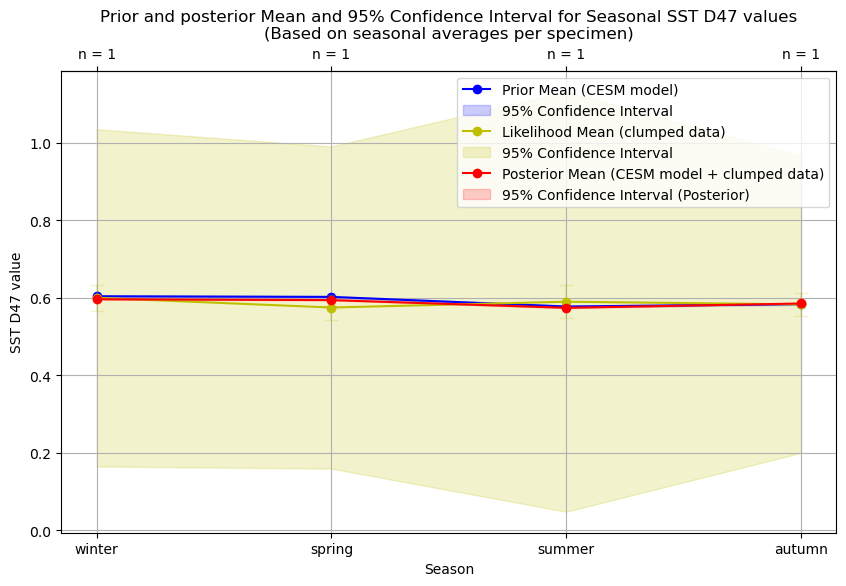

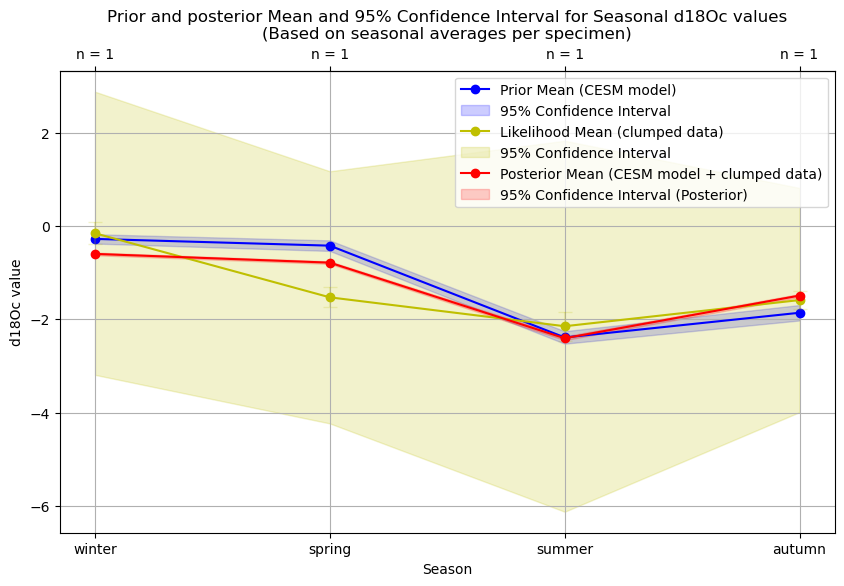

In [39]:
# --- D47 ---

# Plot the updated seasonal posterior for SST_D47
std_post_SST_D47_seasonal_aggregated = np.sqrt(np.diag(cov_post_SST_D47_seasonal_aggregated))
std_prior_SST_D47_seasonal_original = np.sqrt(np.diag(cov_prior_SST_D47_seasonal_original))
var_start_D47_seasonal = var_names.index("D47_mean") * num_bins_seasonal # Determine the start index for the D47 variable
var_end_D47_seasonal = var_start_D47_seasonal + num_bins_seasonal # Determine the end index for the D47 variable
n_update_seasonal_aggregated_D47 = n_update_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal]  # Extract the number of updates for D47

plt.figure(figsize=(10, 6))

# PRIOR
plt.plot(seasons_scale, mu_prior_SST_D47_seasonal_original, label='Prior Mean (CESM model)', color='b', marker='o')
plt.fill_between(
    seasons_scale,
    mu_prior_SST_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_SST_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_original / np.sqrt(n_models_seasonal),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# LIKELIHOOD
# Determine the start and end indices for the selected variable to parse information from the likelihood statistics
plt.plot(seasons_scale, mu_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal], label='Likelihood Mean (clumped data)', color='y', marker='o')
plt.fill_between(
    seasons_scale,
    mu_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal] - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47) * std_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal] / np.sqrt(n_update_seasonal_aggregated_D47),
    mu_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal] + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47) * std_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal] / np.sqrt(n_update_seasonal_aggregated_D47),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
for measurement in Lutetian_seasonally_aggregated_data_dict:
    plt.plot(measurement["season_score"] + 1, measurement["D47_mean"], color="y", marker="o", alpha=0.2)
    plt.errorbar(measurement["season_score"] + 1, measurement["D47_mean"], yerr=measurement["D47_SD"], color="y", alpha=0.2, capsize=5)
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal_aggregated_D47])
secax.tick_params(axis='x', rotation=0)

# POSTERIOR
plt.plot(seasons_scale, mu_post_SST_D47_seasonal_aggregated, label='Posterior Mean (CESM model + clumped data)', color='r', marker='o')
plt.fill_between(
    seasons_scale,
    mu_post_SST_D47_seasonal_aggregated - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_D47 + n_models_seasonal)) * std_post_SST_D47_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal),
    mu_post_SST_D47_seasonal_aggregated + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_D47 + n_models_seasonal)) * std_post_SST_D47_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal SST D47 values\n(Based on seasonal averages per specimen)')
plt.xlabel('Season')
plt.ylabel('SST D47 value')
plt.legend()
plt.grid(True)
plt.show()

# ---d18Oc---

# Plot the updated seasonal posterior for d18Oc
std_post_d18Oc_seasonal_aggregated = np.sqrt(np.diag(cov_post_d18Oc_seasonal_aggregated))
std_prior_d18Oc_seasonal_original = np.sqrt(np.diag(cov_prior_d18Oc_seasonal_original))
var_start_d18Oc_seasonal = var_names.index("d18O") * num_bins_seasonal # Determine the start index for the d18Oc variable
var_end_d18Oc_seasonal = var_start_d18Oc_seasonal + num_bins_seasonal # Determine the end index for the d18Oc variable
n_update_seasonal_d18Oc = n_update_seasonal_aggregated[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal]  # Extract the number of updates for d18Oc

plt.figure(figsize=(10, 6))

# PRIOR
plt.plot(seasons_scale, mu_prior_d18Oc_seasonal_original, label='Prior Mean (CESM model)', color='b', marker='o')
plt.fill_between(
    seasons_scale,
    mu_prior_d18Oc_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_d18Oc_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_d18Oc_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_d18Oc_seasonal_original / np.sqrt(n_models_seasonal),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# LIKELIHOOD
# Determine the start and end indices for the selected variable
plt.plot(seasons_scale, mu_likelihood_seasonal_aggregated[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal], label='Likelihood Mean (clumped data)', color='y', marker='o')
plt.fill_between(
    seasons_scale,
    mu_likelihood_seasonal_aggregated[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] - stats.t.ppf(1 - 0.025, n_update_seasonal_d18Oc) * std_likelihood_seasonal_aggregated[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] / np.sqrt(n_update_seasonal_d18Oc),
    mu_likelihood_seasonal_aggregated[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] + stats.t.ppf(1 - 0.025, n_update_seasonal_d18Oc) * std_likelihood_seasonal_aggregated[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] / np.sqrt(n_update_seasonal_d18Oc),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
for measurement in Lutetian_seasonally_aggregated_data_dict:
    plt.plot(measurement["season_score"] + 1, measurement["d18O"], color="y", marker="o", alpha=0.2)
    plt.errorbar(measurement["season_score"] + 1, measurement["d18O"], yerr=measurement["d18O_SD"], color="y", alpha=0.2, capsize=5)
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal_d18Oc])
secax.tick_params(axis='x', rotation=0)

# POSTERIOR
plt.plot(seasons_scale, mu_post_d18Oc_seasonal_aggregated, label='Posterior Mean (CESM model + clumped data)', color='r', marker='o')
plt.fill_between(
    seasons_scale,
    mu_post_d18Oc_seasonal_aggregated - stats.t.ppf(1 - 0.025, (n_update_seasonal_d18Oc + n_models_seasonal)) * std_post_d18Oc_seasonal_aggregated / np.sqrt(n_update_seasonal_d18Oc + n_models_seasonal),
    mu_post_d18Oc_seasonal_aggregated + stats.t.ppf(1 - 0.025, (n_update_seasonal_d18Oc + n_models_seasonal)) * std_post_d18Oc_seasonal_aggregated / np.sqrt(n_update_seasonal_d18Oc + n_models_seasonal),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal d18Oc values\n(Based on seasonal averages per specimen)')
plt.xlabel('Season')
plt.ylabel('d18Oc value')
plt.legend()
plt.grid(True)
plt.show()

## Update seasonal prior with individual datapoints

## Update seasonal prior with data based on ShellChron (including age uncertainty)
* Aggregate data and model outcomes in 4 seasons based on ShellChron outcomes
* Including sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

In [40]:
# Update the seasonal prior with all measurements assigned to the seasons according to the ShellChron_DOY_rotated field
seasonalSC_data = {} # Keep track of datapoints per season
n_update_seasonalSC = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonalSC = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonalSC = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonalSC = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonalSC = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store temperature uncertainty per season for confidence interval plotting
var_names = ["D47_final", "d18O"] # List of variable names which are updated
var_SD_names = ["D47_SD", "d18O_SD"] # List of names of variable uncertainties which are updated

# Update the prior with seasonal data using the Kalman filter in block updating form
mu_post_seasonalSC, cov_post_seasonalSC = kalman_update_block(
    mu_prior_seasonal_combined,
    cov_prior_seasonal_combined,
    Z_samples,
    R_samples,
    H_seasonal_timeSD
)

# Extract the updated mean values from the combined state vector
mu_post_SST_D47_seasonalSC = mu_post_seasonalSC[:len(mu_prior_SST_D47_seasonal)]
mu_post_SAT_D47_seasonalSC = mu_post_seasonalSC[len(mu_prior_SST_D47_seasonal):2*len(mu_prior_SST_D47_seasonal)]
mu_post_d18Oc_seasonalSC = mu_post_seasonalSC[2*len(mu_prior_SST_D47_seasonal):3*len(mu_prior_SST_D47_seasonal)]
mu_post_precip_seasonalSC = mu_post_seasonalSC[3*len(mu_prior_d18Oc_seasonal):]

# Extract the updated covariance matrices from the combined covariance matrix
cov_post_SST_D47_seasonalSC = cov_post_seasonalSC[:len(mu_prior_SST_D47_seasonal), :len(mu_prior_SST_D47_seasonal)]
cov_post_SAT_D47_seasonalSC = cov_post_seasonalSC[len(mu_prior_SST_D47_seasonal):2*len(mu_prior_SST_D47_seasonal), len(mu_prior_SST_D47_seasonal):2*len(mu_prior_SST_D47_seasonal)]
cov_post_d18Oc_seasonalSC = cov_post_seasonalSC[2*len(mu_prior_SST_D47_seasonal):3*len(mu_prior_SST_D47_seasonal), 2*len(mu_prior_SST_D47_seasonal):3*len(mu_prior_SST_D47_seasonal)]
cov_post_precip_seasonalSC = cov_post_seasonalSC[3*len(mu_prior_d18Oc_seasonal):, 3*len(mu_prior_d18Oc_seasonal):]

for measurement in Lutetian_data_dict: # Loop over measurements
    # Track and update likelihood statistics
    weighted_sum_seasonalSC, effective_weights_total_seasonalSC, n_update_seasonalSC, seasonalSC_data = likelihood_statistics_multi(
        weighted_sum_seasonalSC,
        effective_weights_total_seasonalSC,
        n_update_seasonalSC,
        seasonalSC_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "Season_err",
        Variable_names = var_names,
        Variable_names_SDs = var_SD_names
    )

# Normalize the weighted_sum_seasonalSC to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonalSC to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
num_vars = len(var_names)  # number of variables (e.g., D47, d18O)
num_bins = int(len(weighted_sum_seasonalSC) / num_vars)

for var_idx, var_name in enumerate(var_names):
    print(f"Results for variable: {var_name}")
    for bin_idx in range(num_bins):
        idx = var_idx * num_bins + bin_idx
        if effective_weights_total_seasonalSC[idx] is not None and effective_weights_total_seasonalSC[idx] != 0:
            mu_likelihood_seasonalSC[idx] = weighted_sum_seasonalSC[idx] / effective_weights_total_seasonalSC[idx]
            std_likelihood_seasonalSC[idx] = np.sqrt(1 / effective_weights_total_seasonalSC[idx])
        else:
            # If there are no data points for this bin, set the likelihood to NaN
            mu_likelihood_seasonalSC[idx] = np.nan
            std_likelihood_seasonalSC[idx] = np.nan
        print(f"  Bin {bin_idx + 1}:")
        print(f"    Weighted Average: {mu_likelihood_seasonalSC[idx]}")
        print(f"    Aggregated Uncertainty: {std_likelihood_seasonalSC[idx]}")
        print(f"    Number of Data Points: {n_update_seasonalSC[idx]}")
    print()

print("Original Prior Mean SST-D47 Seasonal:\n", mu_prior_SST_D47_seasonal_original)
print("Original Prior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SST_D47_seasonal_original)))
print("Updated Posterior Mean SST-D47 Seasonal:\n", mu_post_SST_D47_seasonalSC)
print("Updated Posterior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SST_D47_seasonalSC)))
print("Original Prior Mean SAT-D47 Seasonal:\n", mu_prior_SAT_D47_seasonal_original)
print("Original Prior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SAT_D47_seasonal_original)))
print("Updated Posterior Mean SAT-D47 Seasonal:\n", mu_post_SAT_D47_seasonalSC)
print("Updated Posterior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SAT_D47_seasonalSC)))
print("Original Prior Mean d18Oc Seasonal:\n", mu_prior_d18Oc_seasonal_original)
print("Original Prior Standard Deviation d18Oc Seasonal:\n", np.sqrt(np.diag(cov_prior_d18Oc_seasonal_original)))
print("Updated Posterior Mean d18Oc Seasonal:\n", mu_post_d18Oc_seasonalSC)
print("Updated Posterior Standard Deviation d18Oc Seasonal:\n", np.sqrt(np.diag(cov_post_d18Oc_seasonalSC)))
print("Original Prior Mean precipitation Seasonal:\n", mu_prior_precip_seasonal_original)
print("Original Prior Standard Deviation precipitation Seasonal:\n", np.sqrt(np.diag(cov_prior_precip_seasonal_original)))
print("Updated Posterior Mean precipitation Seasonal:\n", mu_post_precip_seasonalSC)
print("Updated Posterior Standard Deviation precipitation Seasonal:\n", np.sqrt(np.diag(cov_post_precip_seasonalSC)))

Likelihood statistics:
Results for variable: D47_final
  Bin 1:
    Weighted Average: 0.5980287961047435
    Aggregated Uncertainty: 0.005319183297492164
    Number of Data Points: 30.0
  Bin 2:
    Weighted Average: 0.6056059274825871
    Aggregated Uncertainty: 0.009051691731040472
    Number of Data Points: 10.0
  Bin 3:
    Weighted Average: 0.584747090236259
    Aggregated Uncertainty: 0.0029909360047608346
    Number of Data Points: 94.0
  Bin 4:
    Weighted Average: 0.5830000164879142
    Aggregated Uncertainty: 0.004973463069690376
    Number of Data Points: 34.0

Results for variable: d18O
  Bin 1:
    Weighted Average: -0.06666006691132258
    Aggregated Uncertainty: 0.0151853078750321
    Number of Data Points: 44.0
  Bin 2:
    Weighted Average: -0.6332340233518498
    Aggregated Uncertainty: 0.009381621589689804
    Number of Data Points: 112.0
  Bin 3:
    Weighted Average: -1.7482800263072544
    Aggregated Uncertainty: 0.0052852310882574366
    Number of Data Points: 3

### Plot seasonal posterior in D47 domain based on ShellChron dating

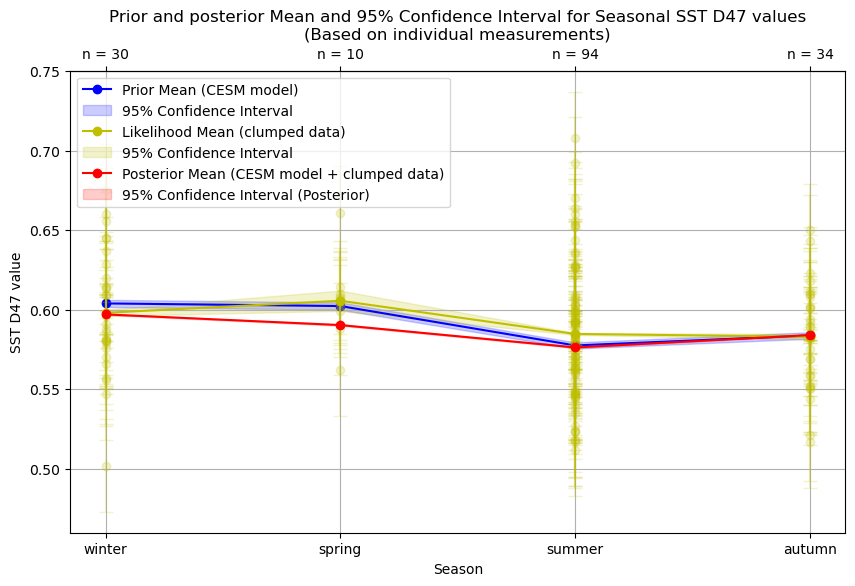

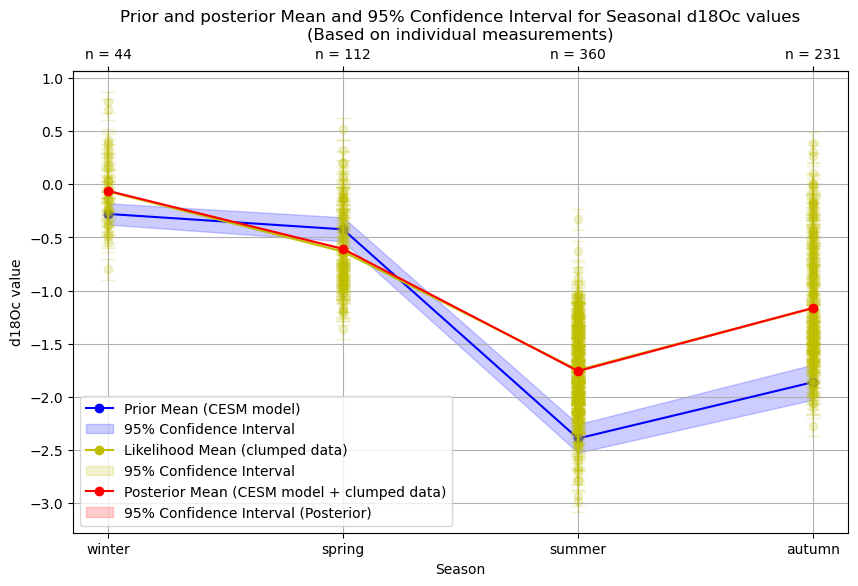

In [41]:
# --- D47 ---

# Plot the updated seasonal posterior for SST_D47
std_post_SST_D47_seasonalSC = np.sqrt(np.diag(cov_post_SST_D47_seasonalSC))
std_prior_SST_D47_seasonal_original = np.sqrt(np.diag(cov_prior_SST_D47_seasonal_original))
n_update_seasonalSC_D47 = n_update_seasonalSC[var_start_D47_seasonal:var_end_D47_seasonal]  # Extract the number of updates for D47

plt.figure(figsize=(10, 6))

# PRIOR
plt.plot(seasons_scale, mu_prior_SST_D47_seasonal_original, label='Prior Mean (CESM model)', color='b', marker='o')
plt.fill_between(
    seasons_scale,
    mu_prior_SST_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_SST_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_original / np.sqrt(n_models_seasonal),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# LIKELIHOOD
# Determine the start and end indices for the selected variable to parse information from the likelihood statistics
plt.plot(seasons_scale, mu_likelihood_seasonalSC[var_start_D47_seasonal:var_end_D47_seasonal], label='Likelihood Mean (clumped data)', color='y', marker='o')
plt.fill_between(
    seasons_scale,
    mu_likelihood_seasonalSC[var_start_D47_seasonal:var_end_D47_seasonal] - stats.t.ppf(1 - 0.025, n_update_seasonalSC_D47) * std_likelihood_seasonalSC[var_start_D47_seasonal:var_end_D47_seasonal] / np.sqrt(n_update_seasonalSC_D47),
    mu_likelihood_seasonalSC[var_start_D47_seasonal:var_end_D47_seasonal] + stats.t.ppf(1 - 0.025, n_update_seasonalSC_D47) * std_likelihood_seasonalSC[var_start_D47_seasonal:var_end_D47_seasonal] / np.sqrt(n_update_seasonalSC_D47),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
for measurement in Lutetian_data_dict:
    plt.plot(int(measurement["season_score"]) + 1, measurement["D47_final"], color="y", marker="o", alpha=0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, measurement["D47_final"], yerr=measurement["D47_SD"], color="y", alpha=0.2, capsize=5)
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC_D47])
secax.tick_params(axis='x', rotation=0)

# POSTERIOR
plt.plot(seasons_scale, mu_post_SST_D47_seasonalSC, label='Posterior Mean (CESM model + clumped data)', color='r', marker='o')
plt.fill_between(
    seasons_scale,
    mu_post_SST_D47_seasonalSC - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_D47 + n_models_seasonal)) * std_post_SST_D47_seasonalSC / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal),
    mu_post_SST_D47_seasonalSC + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_D47 + n_models_seasonal)) * std_post_SST_D47_seasonalSC / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal SST D47 values\n(Based on individual measurements)')
plt.xlabel('Season')
plt.ylabel('SST D47 value')
plt.legend()
plt.grid(True)
plt.show()

# ---d18Oc---

# Plot the updated seasonal posterior for d18Oc
std_post_d18Oc_seasonal = np.sqrt(np.diag(cov_post_d18Oc_seasonalSC))
var_end_d18Oc_seasonal = var_start_d18Oc_seasonal + num_bins # Determine the end index for the d18Oc variable
n_update_seasonalSC_d18Oc = n_update_seasonalSC[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal]  # Extract the number of updates for d18Oc

plt.figure(figsize=(10, 6))

# PRIOR
plt.plot(seasons_scale, mu_prior_d18Oc_seasonal_original, label='Prior Mean (CESM model)', color='b', marker='o')
plt.fill_between(
    seasons_scale,
    mu_prior_d18Oc_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_d18Oc_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_d18Oc_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_d18Oc_seasonal_original / np.sqrt(n_models_seasonal),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# LIKELIHOOD
# Determine the start and end indices for the selected variable
plt.plot(seasons_scale, mu_likelihood_seasonalSC[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal], label='Likelihood Mean (clumped data)', color='y', marker='o')
plt.fill_between(
    seasons_scale,
    mu_likelihood_seasonalSC[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] - stats.t.ppf(1 - 0.025, n_update_seasonalSC_d18Oc) * std_likelihood_seasonalSC[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] / np.sqrt(n_update_seasonalSC_d18Oc),
    mu_likelihood_seasonalSC[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] + stats.t.ppf(1 - 0.025, n_update_seasonalSC_d18Oc) * std_likelihood_seasonalSC[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] / np.sqrt(n_update_seasonalSC_d18Oc),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
for measurement in Lutetian_data_dict:
    plt.plot(int(measurement["season_score"]) + 1, measurement["d18O"], color="y", marker="o", alpha=0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, measurement["d18O"], yerr=measurement["d18O_SD"], color="y", alpha=0.2, capsize=5)
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC_d18Oc])
secax.tick_params(axis='x', rotation=0)

# POSTERIOR
plt.plot(seasons_scale, mu_post_d18Oc_seasonalSC, label='Posterior Mean (CESM model + clumped data)', color='r', marker='o')
plt.fill_between(
    seasons_scale,
    mu_post_d18Oc_seasonalSC - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_d18Oc + n_models_seasonal)) * std_post_d18Oc_seasonal / np.sqrt(n_update_seasonalSC_d18Oc + n_models_seasonal),
    mu_post_d18Oc_seasonalSC + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_d18Oc + n_models_seasonal)) * std_post_d18Oc_seasonal / np.sqrt(n_update_seasonalSC_d18Oc + n_models_seasonal),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal d18Oc values\n(Based on individual measurements)')
plt.xlabel('Season')
plt.ylabel('d18Oc value')
plt.legend()
plt.grid(True)
plt.show()


## Update seasonal prior with data based on ShellChron (ignoring age uncertainty)
* Aggregate data and model outcomes in 4 seasonal bins
* Ignore sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

In [42]:
# Update the seasonal prior with all measurements assigned to the seasons according to the ShellChron_DOY_rotated field
seasonalSC_noerr_data = {} # Keep track of datapoints per season
n_update_seasonalSC_noerr = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonalSC_noerr = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonalSC_noerr = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonalSC_noerr = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonalSC_noerr = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store temperature uncertainty per season for confidence interval plotting
var_names = ["D47_final", "d18O"] # List of variable names which are updated
var_SD_names = ["D47_SD", "d18O_SD"] # List of names of variable uncertainties which are updated

# Update the prior with seasonal data using the Kalman filter in block updating form
mu_post_seasonalSC_noerr, cov_post_seasonalSC_noerr = kalman_update_block(
    mu_prior_seasonal_combined,
    cov_prior_seasonal_combined,
    Z_samples,
    R_samples,
    H_seasonal
)

# Extract the updated mean values from the combined state vector
mu_post_SST_D47_seasonalSC_noerr = mu_post_seasonalSC_noerr[:len(mu_prior_SST_D47_seasonal)]
mu_post_SAT_D47_seasonalSC_noerr = mu_post_seasonalSC_noerr[len(mu_prior_SST_D47_seasonal):2*len(mu_prior_SST_D47_seasonal)]
mu_post_d18Oc_seasonalSC_noerr = mu_post_seasonalSC_noerr[2*len(mu_prior_SST_D47_seasonal):3*len(mu_prior_SST_D47_seasonal)]
mu_post_precip_seasonalSC_noerr = mu_post_seasonalSC_noerr[3*len(mu_prior_d18Oc_seasonal):]

# Extract the updated covariance matrices from the combined covariance matrix
cov_post_SST_D47_seasonalSC_noerr = cov_post_seasonalSC_noerr[:len(mu_prior_SST_D47_seasonal), :len(mu_prior_SST_D47_seasonal)]
cov_post_SAT_D47_seasonalSC_noerr = cov_post_seasonalSC_noerr[len(mu_prior_SST_D47_seasonal):2*len(mu_prior_SST_D47_seasonal), len(mu_prior_SST_D47_seasonal):2*len(mu_prior_SST_D47_seasonal)]
cov_post_d18Oc_seasonalSC_noerr = cov_post_seasonalSC_noerr[2*len(mu_prior_SST_D47_seasonal):3*len(mu_prior_SST_D47_seasonal), 2*len(mu_prior_SST_D47_seasonal):3*len(mu_prior_SST_D47_seasonal)]
cov_post_precip_seasonalSC_noerr = cov_post_seasonalSC_noerr[3*len(mu_prior_d18Oc_seasonal):, 3*len(mu_prior_d18Oc_seasonal):]

for measurement in Lutetian_data_dict: # Loop over measurements
    # Track and update likelihood statistics
    weighted_sum_seasonalSC_noerr, effective_weights_total_seasonalSC_noerr, n_update_seasonalSC_noerr, seasonalSC_noerr_data = likelihood_statistics_multi(
        weighted_sum_seasonalSC_noerr,
        effective_weights_total_seasonalSC_noerr,
        n_update_seasonalSC_noerr,
        seasonalSC_noerr_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "no_err",
        Variable_names = var_names,
        Variable_names_SDs = var_SD_names
    )

# Normalize the weighted_sum_seasonalSC_noerr to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonalSC_noerr to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
num_vars = len(var_names)  # number of variables (e.g., D47, d18O)
num_bins = int(len(weighted_sum_seasonalSC_noerr) / num_vars)

for var_idx, var_name in enumerate(var_names):
    print(f"Results for variable: {var_name}")
    for bin_idx in range(num_bins):
        idx = var_idx * num_bins + bin_idx
        if effective_weights_total_seasonalSC_noerr[idx] is not None and effective_weights_total_seasonalSC_noerr[idx] != 0:
            mu_likelihood_seasonalSC_noerr[idx] = weighted_sum_seasonalSC_noerr[idx] / effective_weights_total_seasonalSC_noerr[idx]
            std_likelihood_seasonalSC_noerr[idx] = np.sqrt(1 / effective_weights_total_seasonalSC_noerr[idx])
        else:
            # If there are no data points for this bin, set the likelihood to NaN
            mu_likelihood_seasonalSC_noerr[idx] = np.nan
            std_likelihood_seasonalSC_noerr[idx] = np.nan
        print(f"  Bin {bin_idx + 1}:")
        print(f"    Weighted Average: {mu_likelihood_seasonalSC_noerr[idx]}")
        print(f"    Aggregated Uncertainty: {std_likelihood_seasonalSC_noerr[idx]}")
        print(f"    Number of Data Points: {n_update_seasonalSC_noerr[idx]}")
    print()

print("Original Prior Mean SST-D47 Seasonal:\n", mu_prior_SST_D47_seasonal_original)
print("Original Prior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SST_D47_seasonal_original)))
print("Updated Posterior Mean SST-D47 Seasonal:\n", mu_post_SST_D47_seasonalSC_noerr)
print("Updated Posterior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SST_D47_seasonalSC_noerr)))
print("Original Prior Mean SAT-D47 Seasonal:\n", mu_prior_SAT_D47_seasonal_original)
print("Original Prior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SAT_D47_seasonal_original)))
print("Updated Posterior Mean SAT-D47 Seasonal:\n", mu_post_SAT_D47_seasonalSC_noerr)
print("Updated Posterior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SAT_D47_seasonalSC_noerr)))
print("Original Prior Mean d18Oc Seasonal:\n", mu_prior_d18Oc_seasonal_original)
print("Original Prior Standard Deviation d18Oc Seasonal:\n", np.sqrt(np.diag(cov_prior_d18Oc_seasonal_original)))
print("Updated Posterior Mean d18Oc Seasonal:\n", mu_post_d18Oc_seasonalSC_noerr)
print("Updated Posterior Standard Deviation d18Oc Seasonal:\n", np.sqrt(np.diag(cov_post_d18Oc_seasonalSC_noerr)))
print("Original Prior Mean precipitation Seasonal:\n", mu_prior_precip_seasonal_original)
print("Original Prior Standard Deviation precipitation Seasonal:\n", np.sqrt(np.diag(cov_prior_precip_seasonal_original)))
print("Updated Posterior Mean precipitation Seasonal:\n", mu_post_precip_seasonalSC_noerr)
print("Updated Posterior Standard Deviation precipitation Seasonal:\n", np.sqrt(np.diag(cov_post_precip_seasonalSC_noerr)))

Likelihood statistics:
Results for variable: D47_final
  Bin 1:
    Weighted Average: 0.5981333333333333
    Aggregated Uncertainty: 0.005294651389216606
    Number of Data Points: 30.0
  Bin 2:
    Weighted Average: 0.6054999999999999
    Aggregated Uncertainty: 0.0091706052144883
    Number of Data Points: 10.0
  Bin 3:
    Weighted Average: 0.5847446808510635
    Aggregated Uncertainty: 0.0029911216141505002
    Number of Data Points: 94.0
  Bin 4:
    Weighted Average: 0.5830000000000001
    Aggregated Uncertainty: 0.004973458969132758
    Number of Data Points: 34.0

Results for variable: d18O
  Bin 1:
    Weighted Average: -0.058636363636363646
    Aggregated Uncertainty: 0.015075567228888182
    Number of Data Points: 44.0
  Bin 2:
    Weighted Average: -0.623125
    Aggregated Uncertainty: 0.009449111825230682
    Number of Data Points: 112.0
  Bin 3:
    Weighted Average: -1.752305555555556
    Aggregated Uncertainty: 0.005270462766947299
    Number of Data Points: 360.0
  Bin

### Plot seasonal posterior in D47 domain based on ShellChron dating

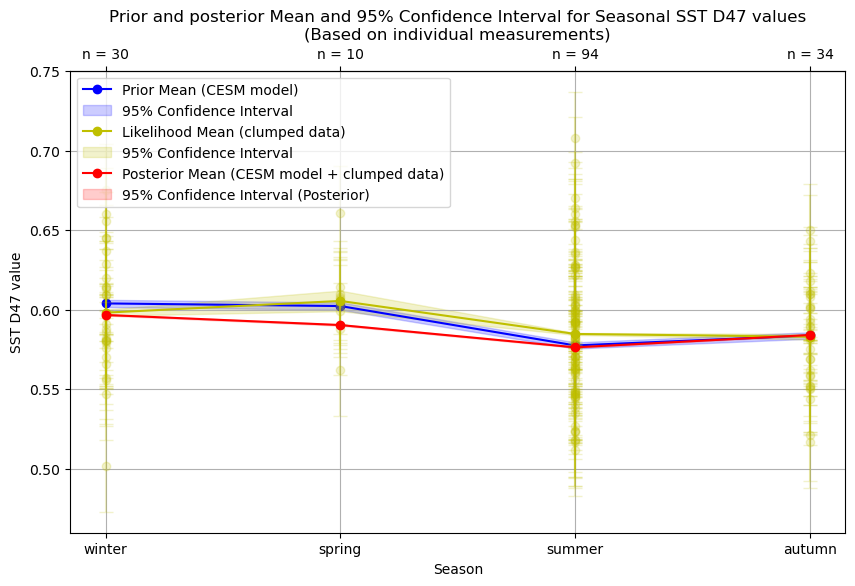

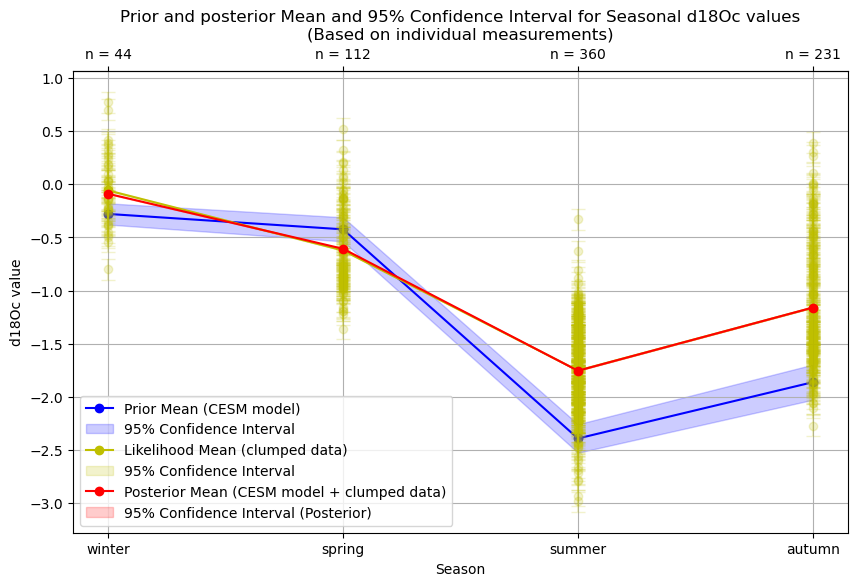

In [43]:
# --- D47 ---

# Plot the updated seasonal posterior for SST_D47
std_post_SST_D47_seasonalSC_noerr = np.sqrt(np.diag(cov_post_SST_D47_seasonalSC_noerr))
std_prior_SST_D47_seasonal_original = np.sqrt(np.diag(cov_prior_SST_D47_seasonal_original))
n_update_seasonalSC_noerr_D47 = n_update_seasonalSC_noerr[var_start_D47_seasonal:var_end_D47_seasonal]  # Extract the number of updates for D47

plt.figure(figsize=(10, 6))

# PRIOR
plt.plot(seasons_scale, mu_prior_SST_D47_seasonal_original, label='Prior Mean (CESM model)', color='b', marker='o')
plt.fill_between(
    seasons_scale,
    mu_prior_SST_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_SST_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_original / np.sqrt(n_models_seasonal),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# LIKELIHOOD
# Determine the start and end indices for the selected variable to parse information from the likelihood statistics
plt.plot(seasons_scale, mu_likelihood_seasonalSC_noerr[var_start_D47_seasonal:var_end_D47_seasonal], label='Likelihood Mean (clumped data)', color='y', marker='o')
plt.fill_between(
    seasons_scale,
    mu_likelihood_seasonalSC_noerr[var_start_D47_seasonal:var_end_D47_seasonal] - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_D47) * std_likelihood_seasonalSC_noerr[var_start_D47_seasonal:var_end_D47_seasonal] / np.sqrt(n_update_seasonalSC_noerr_D47),
    mu_likelihood_seasonalSC_noerr[var_start_D47_seasonal:var_end_D47_seasonal] + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_D47) * std_likelihood_seasonalSC_noerr[var_start_D47_seasonal:var_end_D47_seasonal] / np.sqrt(n_update_seasonalSC_noerr_D47),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
for measurement in Lutetian_data_dict:
    plt.plot(int(measurement["season_score"]) + 1, measurement["D47_final"], color="y", marker="o", alpha=0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, measurement["D47_final"], yerr=measurement["D47_SD"], color="y", alpha=0.2, capsize=5)
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC_noerr_D47])
secax.tick_params(axis='x', rotation=0)

# POSTERIOR
plt.plot(seasons_scale, mu_post_SST_D47_seasonalSC_noerr, label='Posterior Mean (CESM model + clumped data)', color='r', marker='o')
plt.fill_between(
    seasons_scale,
    mu_post_SST_D47_seasonalSC_noerr - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr_D47 + n_models_seasonal)) * std_post_SST_D47_seasonalSC_noerr / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal),
    mu_post_SST_D47_seasonalSC_noerr + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr_D47 + n_models_seasonal)) * std_post_SST_D47_seasonalSC_noerr / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal SST D47 values\n(Based on individual measurements)')
plt.xlabel('Season')
plt.ylabel('SST D47 value')
plt.legend()
plt.grid(True)
plt.show()

# ---d18Oc---

# Plot the updated seasonal posterior for d18Oc
std_post_d18Oc_seasonalSC_noerr = np.sqrt(np.diag(cov_post_d18Oc_seasonalSC_noerr))
std_prior_d18Oc_seasonal_original = np.sqrt(np.diag(cov_prior_d18Oc_seasonal_original))
n_update_seasonalSC_noerr_d18Oc = n_update_seasonalSC_noerr[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal]  # Extract the number of updates for d18Oc

plt.figure(figsize=(10, 6))

# PRIOR
plt.plot(seasons_scale, mu_prior_d18Oc_seasonal_original, label='Prior Mean (CESM model)', color='b', marker='o')
plt.fill_between(
    seasons_scale,
    mu_prior_d18Oc_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_d18Oc_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_d18Oc_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_d18Oc_seasonal_original / np.sqrt(n_models_seasonal),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# LIKELIHOOD
# Determine the start and end indices for the selected variable
plt.plot(seasons_scale, mu_likelihood_seasonalSC_noerr[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal], label='Likelihood Mean (clumped data)', color='y', marker='o')
plt.fill_between(
    seasons_scale,
    mu_likelihood_seasonalSC_noerr[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_d18Oc) * std_likelihood_seasonalSC_noerr[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] / np.sqrt(n_update_seasonalSC_noerr_d18Oc),
    mu_likelihood_seasonalSC_noerr[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_d18Oc) * std_likelihood_seasonalSC_noerr[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] / np.sqrt(n_update_seasonalSC_noerr_d18Oc),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
for measurement in Lutetian_data_dict:
    plt.plot(int(measurement["season_score"]) + 1, measurement["d18O"], color="y", marker="o", alpha=0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, measurement["d18O"], yerr=measurement["d18O_SD"], color="y", alpha=0.2, capsize=5)
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC_noerr_d18Oc])
secax.tick_params(axis='x', rotation=0)

# POSTERIOR
plt.plot(seasons_scale, mu_post_d18Oc_seasonalSC_noerr, label='Posterior Mean (CESM model + clumped data)', color='r', marker='o')
plt.fill_between(
    seasons_scale,
    mu_post_d18Oc_seasonalSC_noerr - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr_d18Oc + n_models_seasonal)) * std_post_d18Oc_seasonalSC_noerr / np.sqrt(n_update_seasonalSC_noerr_d18Oc + n_models_seasonal),
    mu_post_d18Oc_seasonalSC_noerr + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr_d18Oc + n_models_seasonal)) * std_post_d18Oc_seasonalSC_noerr / np.sqrt(n_update_seasonalSC_noerr_d18Oc + n_models_seasonal),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal d18Oc values\n(Based on individual measurements)')
plt.xlabel('Season')
plt.ylabel('d18Oc value')
plt.legend()
plt.grid(True)
plt.show()


# EXECUTE UPDATING FUNCTIONS - MONTHLY

## Update monthly prior with aggregated data
* Data and model outcomes aggregated in 12 months
* No sclero-dating uncertainty
* D47 Data aggregated per specimen and per month

In [44]:
# Apply Kalman function to update the prior with monthly data including updating the prec estimates
# Update the monthly D47 and prec prior with all measurements using block updating
monthly_aggregated_data = {} # Keep track of datapoints per season
n_update_monthly_aggregated = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store sample size per season for confidence interval plotting
weighted_sum_monthly_aggregated = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_monthly_aggregated = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_monthly_aggregated = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_monthly_aggregated = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store temperature uncertainty per season for confidence interval plotting
var_names = ["D47_mean", "d18O"] # List of variable names which are updated
var_SD_names = ["D47_SD", "d18O_SD"] # List of names of variable uncertainties which are updated

# Update the prior with monthly data using the Kalman filter in block updating form
mu_post_monthly_aggregated, cov_post_monthly_aggregated = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_monthly_aggregated,
    R_monthly_aggregated,
    H_monthly_aggregated
)

# Extract the updated mean values from the combined state vector
mu_post_SST_D47_monthly_aggregated = mu_post_monthly_aggregated[:len(mu_prior_SST_D47_monthly)]
mu_post_SAT_D47_monthly_aggregated = mu_post_monthly_aggregated[len(mu_prior_SST_D47_monthly):2*len(mu_prior_SST_D47_monthly)]
mu_post_d18Oc_monthly_aggregated = mu_post_monthly_aggregated[2*len(mu_prior_SST_D47_monthly):3*len(mu_prior_SST_D47_monthly)]
mu_post_precip_monthly_aggregated = mu_post_monthly_aggregated[3*len(mu_prior_d18Oc_monthly):]

# Extract the updated covariance matrices from the combined covariance matrix
cov_post_SST_D47_monthly_aggregated = cov_post_monthly_aggregated[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
cov_post_SAT_D47_monthly_aggregated = cov_post_monthly_aggregated[len(mu_prior_SST_D47_monthly):2*len(mu_prior_SST_D47_monthly), len(mu_prior_SST_D47_monthly):2*len(mu_prior_SST_D47_monthly)]
cov_post_d18Oc_monthly_aggregated = cov_post_monthly_aggregated[2*len(mu_prior_SST_D47_monthly):3*len(mu_prior_SST_D47_monthly), 2*len(mu_prior_SST_D47_monthly):3*len(mu_prior_SST_D47_monthly)]
cov_post_precip_monthly_aggregated = cov_post_monthly_aggregated[3*len(mu_prior_d18Oc_monthly):, 3*len(mu_prior_d18Oc_monthly):]

for measurement in Lutetian_monthly_aggregated_data_dict: # Loop over measurements    
    # Track and update likelihood statistics
    weighted_sum_monthly_aggregated, effective_weights_total_monthly_aggregated, n_update_monthly_aggregated, monthly_aggregated_data = likelihood_statistics_multi(
        weighted_sum_monthly_aggregated,
        effective_weights_total_monthly_aggregated,
        n_update_monthly_aggregated,
        monthly_aggregated_data,
        measurement,
        timestamp = "month_score",
        timestamp_sd = "Month_err",
        Variable_names = var_names,
        Variable_names_SDs = var_SD_names
    )

# Normalize the weighted_sum_monthly to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_monthly to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
num_vars = len(var_names)  # number of variables (e.g., D47, d18O)
num_bins_monthly = int(len(weighted_sum_monthly_aggregated) / num_vars)

for var_idx, var_name in enumerate(var_names):
    print(f"Results for variable: {var_name}")
    for bin_idx in range(num_bins_monthly):
        idx = var_idx * num_bins_monthly + bin_idx
        if effective_weights_total_monthly_aggregated[idx] is not None and effective_weights_total_monthly_aggregated[idx] != 0:
            mu_likelihood_monthly_aggregated[idx] = weighted_sum_monthly_aggregated[idx] / effective_weights_total_monthly_aggregated[idx]
            std_likelihood_monthly_aggregated[idx] = np.sqrt(1 / effective_weights_total_monthly_aggregated[idx])
        else:
            # If there are no data points for this bin, set the likelihood to NaN
            mu_likelihood_monthly_aggregated[idx] = np.nan
            std_likelihood_monthly_aggregated[idx] = np.nan
        print(f"  Bin {bin_idx + 1}:")
        print(f"    Weighted Average: {mu_likelihood_monthly_aggregated[idx]}")
        print(f"    Aggregated Uncertainty: {std_likelihood_monthly_aggregated[idx]}")
        print(f"    Number of Data Points: {n_update_monthly_aggregated[idx]}")
    print()

print("Original Prior Mean SST-D47 monthly:\n", mu_prior_SST_D47_monthly_original)
print("Original Prior Standard Deviation SST-D47 monthly:\n", np.sqrt(np.diag(cov_prior_SST_D47_monthly_original)))
print("Updated Posterior Mean SST-D47 monthly:\n", mu_post_SST_D47_monthly_aggregated)
print("Updated Posterior Standard Deviation SST-D47 monthly:\n", np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated)))
print("Original Prior Mean SAT-D47 monthly:\n", mu_prior_SAT_monthly_original)
print("Original Prior Standard Deviation SAT-D47 monthly:\n", np.sqrt(np.diag(cov_prior_SAT_monthly_original)))
print("Updated Posterior Mean SAT-D47 monthly:\n", mu_post_SAT_D47_monthly_aggregated)
print("Updated Posterior Standard Deviation SAT-D47 monthly:\n", np.sqrt(np.diag(cov_post_SAT_D47_monthly_aggregated)))
print("Original Prior Mean d18Oc monthly:\n", mu_prior_d18Oc_monthly_original)
print("Original Prior Standard Deviation d18Oc monthly:\n", np.sqrt(np.diag(cov_prior_d18Oc_monthly_original)))
print("Updated Posterior Mean d18Oc monthly:\n", mu_post_d18Oc_monthly_aggregated)
print("Updated Posterior Standard Deviation d18Oc monthly:\n", np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated)))
print("Original Prior Mean precipitation monthly:\n", mu_prior_precip_monthly_original)
print("Original Prior Standard Deviation precipitation monthly:\n", np.sqrt(np.diag(cov_prior_precip_monthly_original)))
print("Updated Posterior Mean precipitation monthly:\n", mu_post_precip_monthly_aggregated)
print("Updated Posterior Standard Deviation precipitation monthly:\n", np.sqrt(np.diag(cov_post_precip_monthly_aggregated)))

Likelihood statistics:
Results for variable: D47_mean
  Bin 1:
    Weighted Average: 0.6315000000000001
    Aggregated Uncertainty: 0.0145
    Number of Data Points: 1.0
  Bin 2:
    Weighted Average: 0.5964285714285714
    Aggregated Uncertainty: 0.01096096971726759
    Number of Data Points: 1.0
  Bin 3:
    Weighted Average: 0.6065
    Aggregated Uncertainty: 0.010253048327204941
    Number of Data Points: 1.0
  Bin 4:
    Weighted Average: nan
    Aggregated Uncertainty: nan
    Number of Data Points: 0.0
  Bin 5:
    Weighted Average: 0.5749687499999999
    Aggregated Uncertainty: 0.0051265241636024705
    Number of Data Points: 1.0
  Bin 6:
    Weighted Average: 0.5925625
    Aggregated Uncertainty: 0.00725
    Number of Data Points: 1.0
  Bin 7:
    Weighted Average: 0.5888260869565218
    Aggregated Uncertainty: 0.004275816728492018
    Number of Data Points: 1.0
  Bin 8:
    Weighted Average: nan
    Aggregated Uncertainty: nan
    Number of Data Points: 0.0
  Bin 9:
    Weigh

### Plot monthly posterior in D47 and d18Oc domain using aggregated data

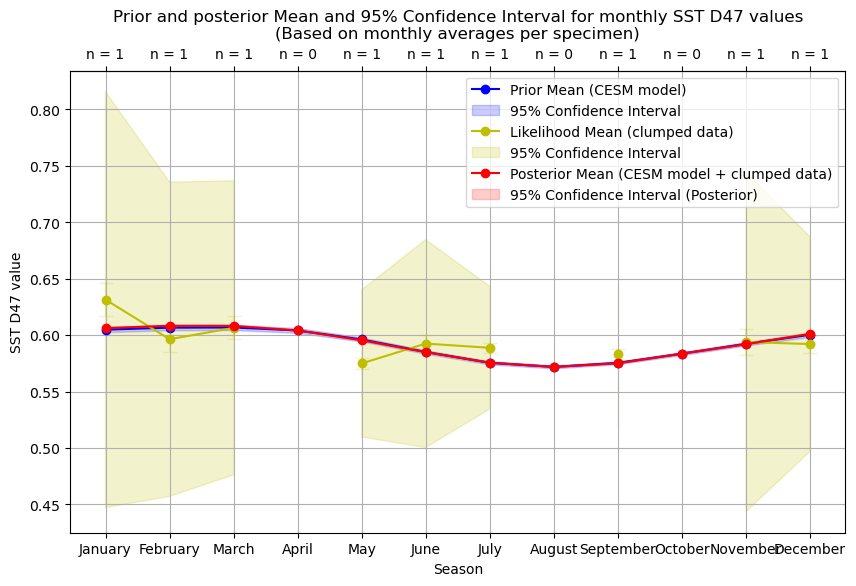

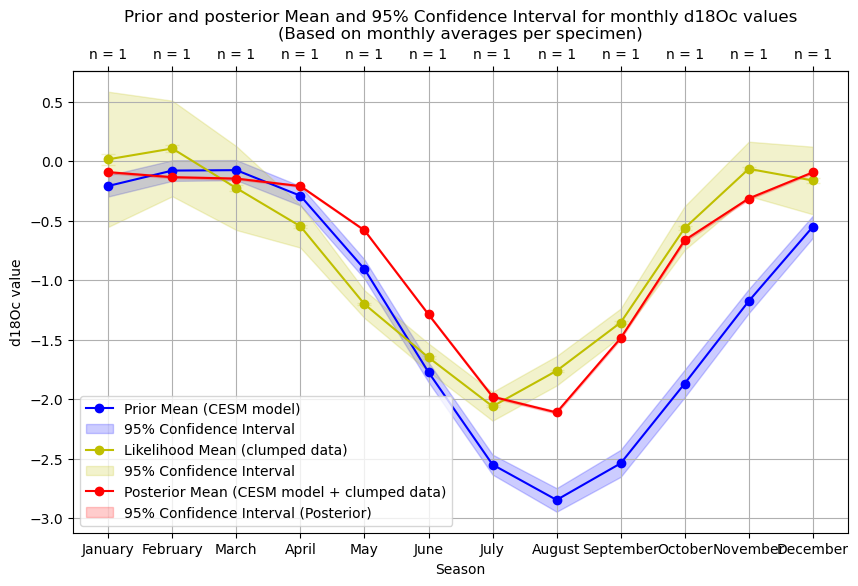

In [45]:
# --- D47 ---

# Plot the updated monthly posterior for SST_D47
std_post_SST_D47_monthly_aggregated = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated))
std_prior_SST_D47_monthly_original = np.sqrt(np.diag(cov_prior_SST_D47_monthly_original))
var_start_D47_monthly = var_names.index("D47_mean") * num_bins_monthly # Determine the start index for the D47 variable
var_end_D47_monthly = var_start_D47_monthly + num_bins_monthly # Determine the end index for the D47 variable
n_update_monthly_aggregated_D47 = n_update_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly]  # Extract the number of updates for D47

plt.figure(figsize=(10, 6))

# PRIOR
plt.plot(months_scale, mu_prior_SST_D47_monthly_original, label='Prior Mean (CESM model)', color='b', marker='o')
plt.fill_between(
    months_scale,
    mu_prior_SST_D47_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_original / np.sqrt(n_models_monthly),
    mu_prior_SST_D47_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_original / np.sqrt(n_models_monthly),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# LIKELIHOOD
# Determine the start and end indices for the selected variable to parse information from the likelihood statistics
plt.plot(months_scale, mu_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly], label='Likelihood Mean (clumped data)', color='y', marker='o')
plt.fill_between(
    months_scale,
    mu_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly] - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47) * std_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly] / np.sqrt(n_update_monthly_aggregated_D47),
    mu_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly] + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47) * std_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly] / np.sqrt(n_update_monthly_aggregated_D47),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
for measurement in Lutetian_monthly_aggregated_data_dict:
    plt.plot(measurement["month_score"] + 1, measurement["D47_mean"], color="y", marker="o", alpha=0.2)
    plt.errorbar(measurement["month_score"] + 1, measurement["D47_mean"], yerr=measurement["D47_SD"], color="y", alpha=0.2, capsize=5)
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly_aggregated_D47])
secax.tick_params(axis='x', rotation=0)

# POSTERIOR
plt.plot(months_scale, mu_post_SST_D47_monthly_aggregated, label='Posterior Mean (CESM model + clumped data)', color='r', marker='o')
plt.fill_between(
    months_scale,
    mu_post_SST_D47_monthly_aggregated - stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_D47 + n_models_monthly)) * std_post_SST_D47_monthly_aggregated / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly),
    mu_post_SST_D47_monthly_aggregated + stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_D47 + n_models_monthly)) * std_post_SST_D47_monthly_aggregated / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

plt.xticks(months_scale, month_names)
plt.title('Prior and posterior Mean and 95% Confidence Interval for monthly SST D47 values\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('SST D47 value')
plt.legend()
plt.grid(True)
plt.show()

# ---d18Oc---

# Plot the updated monthly posterior for d18Oc
std_post_d18Oc_monthly_aggregated = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated))
std_prior_d18Oc_monthly_original = np.sqrt(np.diag(cov_prior_d18Oc_monthly_original))
var_start_d18Oc_monthly = var_names.index("d18O") * num_bins_monthly # Determine the start index for the d18Oc variable
var_end_d18Oc_monthly = var_start_d18Oc_monthly + num_bins_monthly # Determine the end index for the d18Oc variable
n_update_monthly_aggregated_d18Oc = n_update_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly]  # Extract the number of updates for d18Oc

plt.figure(figsize=(10, 6))

# PRIOR
plt.plot(months_scale, mu_prior_d18Oc_monthly_original, label='Prior Mean (CESM model)', color='b', marker='o')
plt.fill_between(
    months_scale,
    mu_prior_d18Oc_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_d18Oc_monthly_original / np.sqrt(n_models_monthly),
    mu_prior_d18Oc_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_d18Oc_monthly_original / np.sqrt(n_models_monthly),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# LIKELIHOOD
# Determine the start and end indices for the selected variable
plt.plot(months_scale, mu_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly], label='Likelihood Mean (clumped data)', color='y', marker='o')
plt.fill_between(
    months_scale,
    mu_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly] - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_d18Oc) * std_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly] / np.sqrt(n_update_monthly_aggregated_d18Oc),
    mu_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly] + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_d18Oc) * std_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly] / np.sqrt(n_update_monthly_aggregated_d18Oc),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
for measurement in Lutetian_monthly_aggregated_data_dict:
    plt.plot(measurement["month_score"] + 1, measurement["d18O"], color="y", marker="o", alpha=0.2)
    plt.errorbar(measurement["month_score"] + 1, measurement["d18O"], yerr=measurement["d18O_SD"], color="y", alpha=0.2, capsize=5)
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly_aggregated_d18Oc])
secax.tick_params(axis='x', rotation=0)

# POSTERIOR
plt.plot(months_scale, mu_post_d18Oc_monthly_aggregated, label='Posterior Mean (CESM model + clumped data)', color='r', marker='o')
plt.fill_between(
    months_scale,
    mu_post_d18Oc_monthly_aggregated - stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_d18Oc + n_models_monthly)) * std_post_d18Oc_monthly_aggregated / np.sqrt(n_update_monthly_aggregated_d18Oc + n_models_monthly),
    mu_post_d18Oc_monthly_aggregated + stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_d18Oc + n_models_monthly)) * std_post_d18Oc_monthly_aggregated / np.sqrt(n_update_monthly_aggregated_d18Oc + n_models_monthly),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

plt.xticks(months_scale, month_names)
plt.title('Prior and posterior Mean and 95% Confidence Interval for monthly d18Oc values\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('d18Oc value')
plt.legend()
plt.grid(True)
plt.show()

## Update monthly prior with individual datapoints

## Update monthly prior with data based on ShellChron (including age uncertainty)
* Aggregate data and model outcomes in 12 months based on ShellChron outcomes
* Including sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

In [46]:
# Update the monthly prior with all measurements assigned to the seasons according to the ShellChron_DOY_rotated field
monthlySC_data = {} # Keep track of datapoints per season
n_update_monthlySC = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store sample size per season for confidence interval plotting
weighted_sum_monthlySC = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_monthlySC = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_monthlySC = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_monthlySC = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store temperature uncertainty per season for confidence interval plotting
var_names = ["D47_final", "d18O"] # List of variable names which are updated
var_SD_names = ["D47_SD", "d18O_SD"] # List of names of variable uncertainties which are updated

# Update the prior with monthly data using the Kalman filter in block updating form
mu_post_monthlySC, cov_post_monthlySC = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_samples,
    R_samples,
    H_monthly_timeSD
)

# Extract the updated mean values from the combined state vector
mu_post_SST_D47_monthlySC = mu_post_monthlySC[:len(mu_prior_SST_D47_monthly)]
mu_post_SAT_D47_monthlySC = mu_post_monthlySC[len(mu_prior_SST_D47_monthly):2*len(mu_prior_SST_D47_monthly)]
mu_post_d18Oc_monthlySC = mu_post_monthlySC[2*len(mu_prior_SST_D47_monthly):3*len(mu_prior_SST_D47_monthly)]
mu_post_precip_monthlySC = mu_post_monthlySC[3*len(mu_prior_d18Oc_monthly):]

# Extract the updated covariance matrices from the combined covariance matrix
cov_post_SST_D47_monthlySC = cov_post_monthlySC[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
cov_post_SAT_D47_monthlySC = cov_post_monthlySC[len(mu_prior_SST_D47_monthly):2*len(mu_prior_SST_D47_monthly), len(mu_prior_SST_D47_monthly):2*len(mu_prior_SST_D47_monthly)]
cov_post_d18Oc_monthlySC = cov_post_monthlySC[2*len(mu_prior_SST_D47_monthly):3*len(mu_prior_SST_D47_monthly), 2*len(mu_prior_SST_D47_monthly):3*len(mu_prior_SST_D47_monthly)]
cov_post_precip_monthlySC = cov_post_monthlySC[3*len(mu_prior_d18Oc_monthly):, 3*len(mu_prior_d18Oc_monthly):]

for measurement in Lutetian_data_dict: # Loop over measurements
    # Track and update likelihood statistics
    weighted_sum_monthlySC, effective_weights_total_monthlySC, n_update_monthlySC, monthlySC_data = likelihood_statistics_multi(
        weighted_sum_monthlySC,
        effective_weights_total_monthlySC,
        n_update_monthlySC,
        monthlySC_data,
        measurement,
        timestamp = "month_score",
        timestamp_sd = "Month_err",
        Variable_names = var_names,
        Variable_names_SDs = var_SD_names
    )

# Normalize the weighted_sum_monthlySC to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_monthlySC to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
num_vars = len(var_names)  # number of variables (e.g., D47, d18O)
num_bins = int(len(weighted_sum_monthlySC) / num_vars)

for var_idx, var_name in enumerate(var_names):
    print(f"Results for variable: {var_name}")
    for bin_idx in range(num_bins):
        idx = var_idx * num_bins + bin_idx
        if effective_weights_total_monthlySC[idx] is not None and effective_weights_total_monthlySC[idx] != 0:
            mu_likelihood_monthlySC[idx] = weighted_sum_monthlySC[idx] / effective_weights_total_monthlySC[idx]
            std_likelihood_monthlySC[idx] = np.sqrt(1 / effective_weights_total_monthlySC[idx])
        else:
            # If there are no data points for this bin, set the likelihood to NaN
            mu_likelihood_monthlySC[idx] = np.nan
            std_likelihood_monthlySC[idx] = np.nan
        print(f"  Bin {bin_idx + 1}:")
        print(f"    Weighted Average: {mu_likelihood_monthlySC[idx]}")
        print(f"    Aggregated Uncertainty: {std_likelihood_monthlySC[idx]}")
        print(f"    Number of Data Points: {n_update_monthlySC[idx]}")
    print()

print("Original Prior Mean SST-D47 monthly:\n", mu_prior_SST_D47_monthly_original)
print("Original Prior Standard Deviation SST-D47 monthly:\n", np.sqrt(np.diag(cov_prior_SST_D47_monthly_original)))
print("Updated Posterior Mean SST-D47 monthly:\n", mu_post_SST_D47_monthlySC)
print("Updated Posterior Standard Deviation SST-D47 monthly:\n", np.sqrt(np.diag(cov_post_SST_D47_monthlySC)))
print("Original Prior Mean SAT-D47 monthly:\n", mu_prior_SAT_D47_monthly_original)
print("Original Prior Standard Deviation SAT-D47 monthly:\n", np.sqrt(np.diag(cov_prior_SAT_D47_monthly_original)))
print("Updated Posterior Mean SAT-D47 monthly:\n", mu_post_SAT_D47_monthlySC)
print("Updated Posterior Standard Deviation SAT-D47 monthly:\n", np.sqrt(np.diag(cov_post_SAT_D47_monthlySC)))
print("Original Prior Mean d18Oc monthly:\n", mu_prior_d18Oc_monthly_original)
print("Original Prior Standard Deviation d18Oc monthly:\n", np.sqrt(np.diag(cov_prior_d18Oc_monthly_original)))
print("Updated Posterior Mean d18Oc monthly:\n", mu_post_d18Oc_monthlySC)
print("Updated Posterior Standard Deviation d18Oc monthly:\n", np.sqrt(np.diag(cov_post_d18Oc_monthlySC)))
print("Original Prior Mean precipitation monthly:\n", mu_prior_precip_monthly_original)
print("Original Prior Standard Deviation precipitation monthly:\n", np.sqrt(np.diag(cov_prior_precip_monthly_original)))
print("Updated Posterior Mean precipitation monthly:\n", mu_post_precip_monthlySC)
print("Updated Posterior Standard Deviation precipitation monthly:\n", np.sqrt(np.diag(cov_post_precip_monthlySC)))

Likelihood statistics:
Results for variable: D47_final
  Bin 1:
    Weighted Average: 0.615556655163968
    Aggregated Uncertainty: 0.014386887215499104
    Number of Data Points: 4.0
  Bin 2:
    Weighted Average: 0.6075925423089691
    Aggregated Uncertainty: 0.01176716359962952
    Number of Data Points: 7.0
  Bin 3:
    Weighted Average: 0.604932466269697
    Aggregated Uncertainty: 0.011491314529211257
    Number of Data Points: 8.0
  Bin 4:
    Weighted Average: 0.5902398723566911
    Aggregated Uncertainty: 0.014169425602370821
    Number of Data Points: 0.0
  Bin 5:
    Weighted Average: 0.5758627602383805
    Aggregated Uncertainty: 0.005362655208743754
    Number of Data Points: 32.0
  Bin 6:
    Weighted Average: 0.5906885979183855
    Aggregated Uncertainty: 0.007025687795161085
    Number of Data Points: 16.0
  Bin 7:
    Weighted Average: 0.5887443896243166
    Aggregated Uncertainty: 0.004312100079616656
    Number of Data Points: 46.0
  Bin 8:
    Weighted Average: 0.58

### Plot monthly posterior in D47 and d18Oc domain based on ShellChron dating

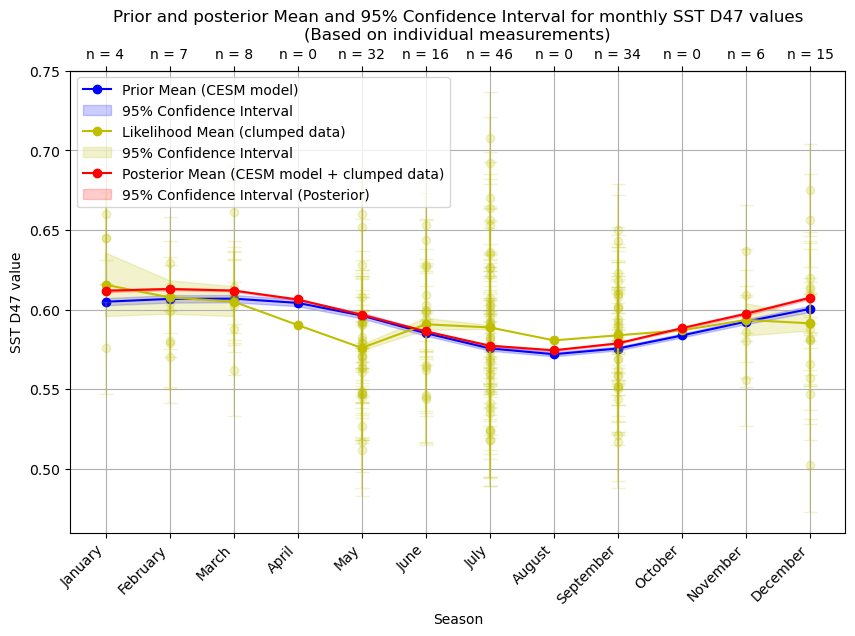

c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


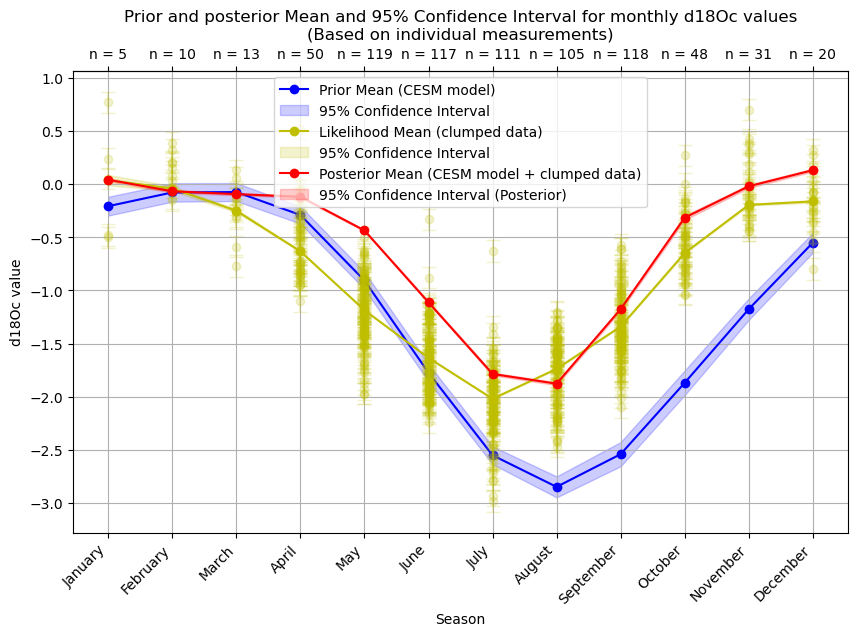

In [47]:
# --- D47 ---

# Plot the updated monthly posterior for SST_D47
std_post_SST_D47_monthlySC = np.sqrt(np.diag(cov_post_SST_D47_monthlySC))
std_prior_SST_D47_monthly_original = np.sqrt(np.diag(cov_prior_SST_D47_monthly_original))
n_update_monthlySC_D47 = n_update_monthlySC[var_start_D47_monthly:var_end_D47_monthly]  # Extract the number of updates for D47

plt.figure(figsize=(10, 6))

# PRIOR
plt.plot(months_scale, mu_prior_SST_D47_monthly_original, label='Prior Mean (CESM model)', color='b', marker='o')
plt.fill_between(
    months_scale,
    mu_prior_SST_D47_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_original / np.sqrt(n_models_monthly),
    mu_prior_SST_D47_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_original / np.sqrt(n_models_monthly),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# LIKELIHOOD
# Determine the start and end indices for the selected variable to parse information from the likelihood statistics
plt.plot(months_scale, mu_likelihood_monthlySC[var_start_D47_monthly:var_end_D47_monthly], label='Likelihood Mean (clumped data)', color='y', marker='o')
plt.fill_between(
    months_scale,
    mu_likelihood_monthlySC[var_start_D47_monthly:var_end_D47_monthly] - stats.t.ppf(1 - 0.025, n_update_monthlySC_D47) * std_likelihood_monthlySC[var_start_D47_monthly:var_end_D47_monthly] / np.sqrt(n_update_monthlySC_D47),
    mu_likelihood_monthlySC[var_start_D47_monthly:var_end_D47_monthly] + stats.t.ppf(1 - 0.025, n_update_monthlySC_D47) * std_likelihood_monthlySC[var_start_D47_monthly:var_end_D47_monthly] / np.sqrt(n_update_monthlySC_D47),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
for measurement in Lutetian_data_dict:
    plt.plot(int(measurement["month_score"]) + 1, measurement["D47_final"], color="y", marker="o", alpha=0.2)
    plt.errorbar(int(measurement["month_score"]) + 1, measurement["D47_final"], yerr=measurement["D47_SD"], color="y", alpha=0.2, capsize=5)
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthlySC_D47])
secax.tick_params(axis='x', rotation=0)

# POSTERIOR
plt.plot(months_scale, mu_post_SST_D47_monthlySC, label='Posterior Mean (CESM model + clumped data)', color='r', marker='o')
plt.fill_between(
    months_scale,
    mu_post_SST_D47_monthlySC - stats.t.ppf(1 - 0.025, (n_update_monthlySC_D47 + n_models_monthly)) * std_post_SST_D47_monthlySC / np.sqrt(n_update_monthlySC_D47 + n_models_monthly),
    mu_post_SST_D47_monthlySC + stats.t.ppf(1 - 0.025, (n_update_monthlySC_D47 + n_models_monthly)) * std_post_SST_D47_monthlySC / np.sqrt(n_update_monthlySC_D47 + n_models_monthly),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.title('Prior and posterior Mean and 95% Confidence Interval for monthly SST D47 values\n(Based on individual measurements)')
plt.xlabel('Season')
plt.ylabel('SST D47 value')
plt.legend()
plt.grid(True)
plt.show()

# ---d18Oc---

# Plot the updated monthly posterior for d18Oc
std_post_d18Oc_monthly = np.sqrt(np.diag(cov_post_d18Oc_monthlySC))
var_end_d18Oc_monthly = var_start_d18Oc_monthly + num_bins # Determine the end index for the d18Oc variable
n_update_monthlySC_d18Oc = n_update_monthlySC[var_start_d18Oc_monthly:var_end_d18Oc_monthly]  # Extract the number of updates for d18Oc

plt.figure(figsize=(10, 6))

# PRIOR
plt.plot(months_scale, mu_prior_d18Oc_monthly_original, label='Prior Mean (CESM model)', color='b', marker='o')
plt.fill_between(
    months_scale,
    mu_prior_d18Oc_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_d18Oc_monthly_original / np.sqrt(n_models_monthly),
    mu_prior_d18Oc_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_d18Oc_monthly_original / np.sqrt(n_models_monthly),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# LIKELIHOOD
# Determine the start and end indices for the selected variable
plt.plot(months_scale, mu_likelihood_monthlySC[var_start_d18Oc_monthly:var_end_d18Oc_monthly], label='Likelihood Mean (clumped data)', color='y', marker='o')
plt.fill_between(
    months_scale,
    mu_likelihood_monthlySC[var_start_d18Oc_monthly:var_end_d18Oc_monthly] - stats.t.ppf(1 - 0.025, n_update_monthlySC_d18Oc) * std_likelihood_monthlySC[var_start_d18Oc_monthly:var_end_d18Oc_monthly] / np.sqrt(n_update_monthlySC_d18Oc),
    mu_likelihood_monthlySC[var_start_d18Oc_monthly:var_end_d18Oc_monthly] + stats.t.ppf(1 - 0.025, n_update_monthlySC_d18Oc) * std_likelihood_monthlySC[var_start_d18Oc_monthly:var_end_d18Oc_monthly] / np.sqrt(n_update_monthlySC_d18Oc),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
for measurement in Lutetian_data_dict:
    plt.plot(int(measurement["month_score"]) + 1, measurement["d18O"], color="y", marker="o", alpha=0.2)
    plt.errorbar(int(measurement["month_score"]) + 1, measurement["d18O"], yerr=measurement["d18O_SD"], color="y", alpha=0.2, capsize=5)
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthlySC_d18Oc])
secax.tick_params(axis='x', rotation=0)

# POSTERIOR
plt.plot(months_scale, mu_post_d18Oc_monthlySC, label='Posterior Mean (CESM model + clumped data)', color='r', marker='o')
plt.fill_between(
    months_scale,
    mu_post_d18Oc_monthlySC - stats.t.ppf(1 - 0.025, (n_update_monthlySC_d18Oc + n_models_monthly)) * std_post_d18Oc_monthly / np.sqrt(n_update_monthlySC_d18Oc + n_models_monthly),
    mu_post_d18Oc_monthlySC + stats.t.ppf(1 - 0.025, (n_update_monthlySC_d18Oc + n_models_monthly)) * std_post_d18Oc_monthly / np.sqrt(n_update_monthlySC_d18Oc + n_models_monthly),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.title('Prior and posterior Mean and 95% Confidence Interval for monthly d18Oc values\n(Based on individual measurements)')
plt.xlabel('Season')
plt.ylabel('d18Oc value')
plt.legend()
plt.grid(True)
plt.show()

## Update monthly prior with data based on ShellChron (ignoring age uncertainty)
* Aggregate data and model outcomes in 12 monthly bins
* Ignore sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

In [48]:
# Update the monthly prior with all measurements assigned to the seasons according to the ShellChron_DOY_rotated field
monthlySC_noerr_data = {} # Keep track of datapoints per season
n_update_monthlySC_noerr = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store sample size per season for confidence interval plotting
weighted_sum_monthlySC_noerr = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_monthlySC_noerr = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_monthlySC_noerr = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_monthlySC_noerr = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store temperature uncertainty per season for confidence interval plotting
var_names = ["D47_final", "d18O"] # List of variable names which are updated
var_SD_names = ["D47_SD", "d18O_SD"] # List of names of variable uncertainties which are updated

# Update the prior with monthly data using the Kalman filter in block updating form
mu_post_monthlySC_noerr, cov_post_monthlySC_noerr = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_samples,
    R_samples,
    H_monthly
)

# Extract the updated mean values from the combined state vector
mu_post_SST_D47_monthlySC_noerr = mu_post_monthlySC_noerr[:len(mu_prior_SST_D47_monthly)]
mu_post_SAT_D47_monthlySC_noerr = mu_post_monthlySC_noerr[len(mu_prior_SST_D47_monthly):2*len(mu_prior_SST_D47_monthly)]
mu_post_d18Oc_monthlySC_noerr = mu_post_monthlySC_noerr[2*len(mu_prior_SST_D47_monthly):3*len(mu_prior_SST_D47_monthly)]
mu_post_precip_monthlySC_noerr = mu_post_monthlySC_noerr[3*len(mu_prior_d18Oc_monthly):]

# Extract the updated covariance matrices from the combined covariance matrix
cov_post_SST_D47_monthlySC_noerr = cov_post_monthlySC_noerr[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
cov_post_SAT_D47_monthlySC_noerr = cov_post_monthlySC_noerr[len(mu_prior_SST_D47_monthly):2*len(mu_prior_SST_D47_monthly), len(mu_prior_SST_D47_monthly):2*len(mu_prior_SST_D47_monthly)]
cov_post_d18Oc_monthlySC_noerr = cov_post_monthlySC_noerr[2*len(mu_prior_SST_D47_monthly):3*len(mu_prior_SST_D47_monthly), 2*len(mu_prior_SST_D47_monthly):3*len(mu_prior_SST_D47_monthly)]
cov_post_precip_monthlySC_noerr = cov_post_monthlySC_noerr[3*len(mu_prior_d18Oc_monthly):, 3*len(mu_prior_d18Oc_monthly):]

for measurement in Lutetian_data_dict: # Loop over measurements
    # Track and update likelihood statistics
    weighted_sum_monthlySC_noerr, effective_weights_total_monthlySC_noerr, n_update_monthlySC_noerr, monthlySC_noerr_data = likelihood_statistics_multi(
        weighted_sum_monthlySC_noerr,
        effective_weights_total_monthlySC_noerr,
        n_update_monthlySC_noerr,
        monthlySC_noerr_data,
        measurement,
        timestamp = "month_score",
        timestamp_sd = "no_err",
        Variable_names = var_names,
        Variable_names_SDs = var_SD_names
    )

# Normalize the weighted_sum_monthlySC_noerr to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_monthlySC_noerr to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
num_vars = len(var_names)  # number of variables (e.g., D47, d18O)
num_bins = int(len(weighted_sum_monthlySC_noerr) / num_vars)

for var_idx, var_name in enumerate(var_names):
    print(f"Results for variable: {var_name}")
    for bin_idx in range(num_bins):
        idx = var_idx * num_bins + bin_idx
        if effective_weights_total_monthlySC_noerr[idx] is not None and effective_weights_total_monthlySC_noerr[idx] != 0:
            mu_likelihood_monthlySC_noerr[idx] = weighted_sum_monthlySC_noerr[idx] / effective_weights_total_monthlySC_noerr[idx]
            std_likelihood_monthlySC_noerr[idx] = np.sqrt(1 / effective_weights_total_monthlySC_noerr[idx])
        else:
            # If there are no data points for this bin, set the likelihood to NaN
            mu_likelihood_monthlySC_noerr[idx] = np.nan
            std_likelihood_monthlySC_noerr[idx] = np.nan
        print(f"  Bin {bin_idx + 1}:")
        print(f"    Weighted Average: {mu_likelihood_monthlySC_noerr[idx]}")
        print(f"    Aggregated Uncertainty: {std_likelihood_monthlySC_noerr[idx]}")
        print(f"    Number of Data Points: {n_update_monthlySC_noerr[idx]}")
    print()

print("Original Prior Mean SST-D47 monthly:\n", mu_prior_SST_D47_monthly_original)
print("Original Prior Standard Deviation SST-D47 monthly:\n", np.sqrt(np.diag(cov_prior_SST_D47_monthly_original)))
print("Updated Posterior Mean SST-D47 monthly:\n", mu_post_SST_D47_monthlySC_noerr)
print("Updated Posterior Standard Deviation SST-D47 monthly:\n", np.sqrt(np.diag(cov_post_SST_D47_monthlySC_noerr)))
print("Original Prior Mean SAT-D47 monthly:\n", mu_prior_SAT_D47_monthly_original)
print("Original Prior Standard Deviation SAT-D47 monthly:\n", np.sqrt(np.diag(cov_prior_SAT_D47_monthly_original)))
print("Updated Posterior Mean SAT-D47 monthly:\n", mu_post_SAT_D47_monthlySC_noerr)
print("Updated Posterior Standard Deviation SAT-D47 monthly:\n", np.sqrt(np.diag(cov_post_SAT_D47_monthlySC_noerr)))
print("Original Prior Mean d18Oc monthly:\n", mu_prior_d18Oc_monthly_original)
print("Original Prior Standard Deviation d18Oc monthly:\n", np.sqrt(np.diag(cov_prior_d18Oc_monthly_original)))
print("Updated Posterior Mean d18Oc monthly:\n", mu_post_d18Oc_monthlySC_noerr)
print("Updated Posterior Standard Deviation d18Oc monthly:\n", np.sqrt(np.diag(cov_post_d18Oc_monthlySC_noerr)))
print("Original Prior Mean precipitation monthly:\n", mu_prior_precip_monthly_original)
print("Original Prior Standard Deviation precipitation monthly:\n", np.sqrt(np.diag(cov_prior_precip_monthly_original)))
print("Updated Posterior Mean precipitation monthly:\n", mu_post_precip_monthlySC_noerr)
print("Updated Posterior Standard Deviation precipitation monthly:\n", np.sqrt(np.diag(cov_post_precip_monthlySC_noerr)))

Likelihood statistics:
Results for variable: D47_final
  Bin 1:
    Weighted Average: 0.6315000000000001
    Aggregated Uncertainty: 0.0145
    Number of Data Points: 4.0
  Bin 2:
    Weighted Average: 0.5964285714285713
    Aggregated Uncertainty: 0.01096096971726759
    Number of Data Points: 7.0
  Bin 3:
    Weighted Average: 0.6064999999999998
    Aggregated Uncertainty: 0.01025304832720494
    Number of Data Points: 8.0
  Bin 4:
    Weighted Average: nan
    Aggregated Uncertainty: nan
    Number of Data Points: 0.0
  Bin 5:
    Weighted Average: 0.5749687500000001
    Aggregated Uncertainty: 0.0051265241636024705
    Number of Data Points: 32.0
  Bin 6:
    Weighted Average: 0.5925624999999998
    Aggregated Uncertainty: 0.0072499999999999995
    Number of Data Points: 16.0
  Bin 7:
    Weighted Average: 0.5888260869565223
    Aggregated Uncertainty: 0.004275816728492019
    Number of Data Points: 46.0
  Bin 8:
    Weighted Average: nan
    Aggregated Uncertainty: nan
    Number 

In [49]:
print(mu_prior_monthly_combined)
print(mu_likelihood_monthlySC_noerr)
print(mu_post_monthlySC_noerr)

[ 0.605  0.607  0.607  0.604  0.596  0.585  0.576  0.572  0.575  0.584
  0.592  0.6    0.631  0.629  0.624  0.614  0.599  0.587  0.577  0.576
  0.585  0.603  0.619  0.629 -0.208 -0.079 -0.075 -0.291 -0.907 -1.774
 -2.551 -2.848 -2.54  -1.869 -1.176 -0.552  2.022  2.189  2.376  2.133
  1.701  1.94   2.358  2.032  1.813  1.576  2.406  2.227]
[ 0.632  0.596  0.606    nan  0.575  0.593  0.589    nan  0.583    nan
  0.594  0.592  0.016  0.107 -0.226 -0.547 -1.202 -1.65  -2.061 -1.762
 -1.356 -0.562 -0.064 -0.162]
[ 0.61   0.615  0.616  0.614  0.609  0.589  0.576  0.577  0.588  0.592
  0.603  0.608  0.579  0.575  0.568  0.558  0.545  0.537  0.533  0.537
  0.551  0.569  0.579  0.583 -0.228 -0.266 -0.359 -0.537 -0.946 -1.626
 -2.067 -1.966 -1.3   -0.505 -0.3   -0.182  4.798  5.878  1.884  1.161
  2.312  4.375  5.809  6.536  9.686  2.183 -1.834 -1.067]


### Plot monthly posterior in D47 and d18Oc domain based on ShellChron dating

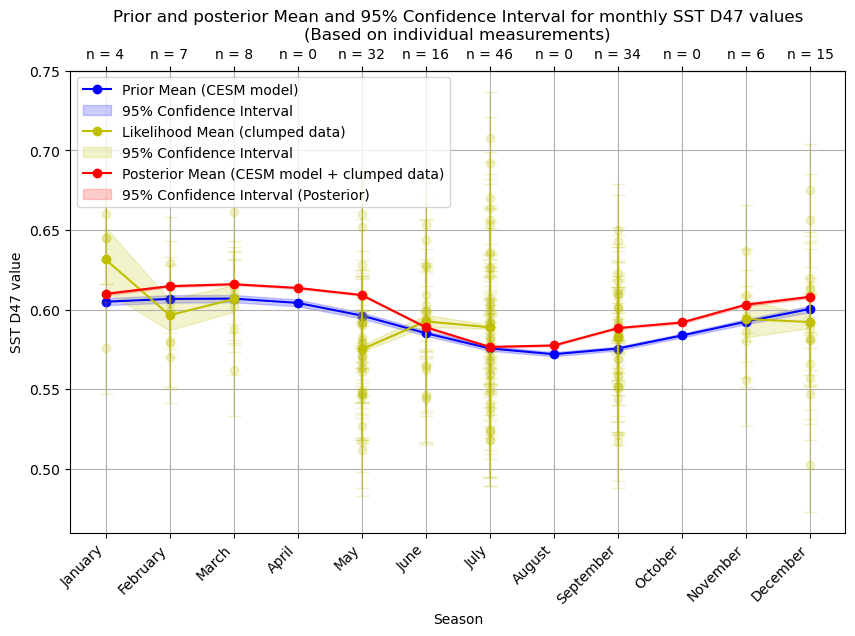

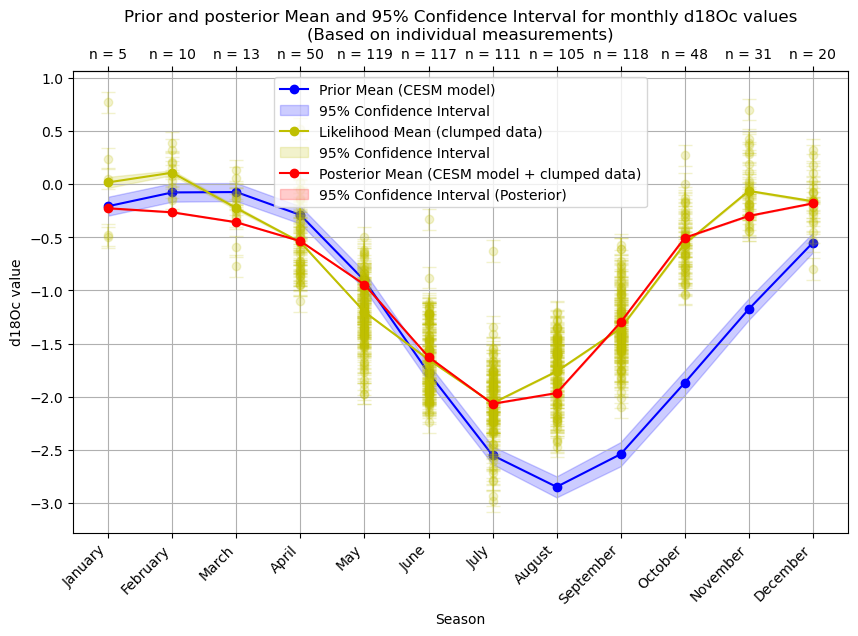

In [50]:
# --- D47 ---

# Plot the updated monthly posterior for SST_D47
std_post_SST_D47_monthlySC_noerr = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_noerr))
std_prior_SST_D47_monthly_original = np.sqrt(np.diag(cov_prior_SST_D47_monthly_original))
n_update_monthlySC_noerr_D47 = n_update_monthlySC_noerr[var_start_D47_monthly:var_end_D47_monthly]  # Extract the number of updates for D47

plt.figure(figsize=(10, 6))

# PRIOR
plt.plot(months_scale, mu_prior_SST_D47_monthly_original, label='Prior Mean (CESM model)', color='b', marker='o')
plt.fill_between(
    months_scale,
    mu_prior_SST_D47_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_original / np.sqrt(n_models_monthly),
    mu_prior_SST_D47_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_original / np.sqrt(n_models_monthly),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# LIKELIHOOD
# Determine the start and end indices for the selected variable to parse information from the likelihood statistics
plt.plot(months_scale, mu_likelihood_monthlySC_noerr[var_start_D47_monthly:var_end_D47_monthly], label='Likelihood Mean (clumped data)', color='y', marker='o')
plt.fill_between(
    months_scale,
    mu_likelihood_monthlySC_noerr[var_start_D47_monthly:var_end_D47_monthly] - stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_D47) * std_likelihood_monthlySC_noerr[var_start_D47_monthly:var_end_D47_monthly] / np.sqrt(n_update_monthlySC_noerr_D47),
    mu_likelihood_monthlySC_noerr[var_start_D47_monthly:var_end_D47_monthly] + stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_D47) * std_likelihood_monthlySC_noerr[var_start_D47_monthly:var_end_D47_monthly] / np.sqrt(n_update_monthlySC_noerr_D47),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
for measurement in Lutetian_data_dict:
    plt.plot(int(measurement["month_score"]) + 1, measurement["D47_final"], color="y", marker="o", alpha=0.2)
    plt.errorbar(int(measurement["month_score"]) + 1, measurement["D47_final"], yerr=measurement["D47_SD"], color="y", alpha=0.2, capsize=5)
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthlySC_noerr_D47])
secax.tick_params(axis='x', rotation=0)

# POSTERIOR
plt.plot(months_scale, mu_post_SST_D47_monthlySC_noerr, label='Posterior Mean (CESM model + clumped data)', color='r', marker='o')
plt.fill_between(
    months_scale,
    mu_post_SST_D47_monthlySC_noerr - stats.t.ppf(1 - 0.025, (n_update_monthlySC_noerr_D47 + n_models_monthly)) * std_post_SST_D47_monthlySC_noerr / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly),
    mu_post_SST_D47_monthlySC_noerr + stats.t.ppf(1 - 0.025, (n_update_monthlySC_noerr_D47 + n_models_monthly)) * std_post_SST_D47_monthlySC_noerr / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.title('Prior and posterior Mean and 95% Confidence Interval for monthly SST D47 values\n(Based on individual measurements)')
plt.xlabel('Season')
plt.ylabel('SST D47 value')
plt.legend()
plt.grid(True)
plt.show()

# ---d18Oc---

# Plot the updated monthly posterior for d18Oc
std_post_d18Oc_monthlySC_noerr = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_noerr))
std_prior_d18Oc_monthly_original = np.sqrt(np.diag(cov_prior_d18Oc_monthly_original))
n_update_monthlySC_noerr_d18Oc = n_update_monthlySC_noerr[var_start_d18Oc_monthly:var_end_d18Oc_monthly]  # Extract the number of updates for d18Oc

plt.figure(figsize=(10, 6))

# PRIOR
plt.plot(months_scale, mu_prior_d18Oc_monthly_original, label='Prior Mean (CESM model)', color='b', marker='o')
plt.fill_between(
    months_scale,
    mu_prior_d18Oc_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_d18Oc_monthly_original / np.sqrt(n_models_monthly),
    mu_prior_d18Oc_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_d18Oc_monthly_original / np.sqrt(n_models_monthly),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# LIKELIHOOD
# Determine the start and end indices for the selected variable
plt.plot(months_scale, mu_likelihood_monthlySC_noerr[var_start_d18Oc_monthly:var_end_d18Oc_monthly], label='Likelihood Mean (clumped data)', color='y', marker='o')
plt.fill_between(
    months_scale,
    mu_likelihood_monthlySC_noerr[var_start_d18Oc_monthly:var_end_d18Oc_monthly] - stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_d18Oc) * std_likelihood_monthlySC_noerr[var_start_d18Oc_monthly:var_end_d18Oc_monthly] / np.sqrt(n_update_monthlySC_noerr_d18Oc),
    mu_likelihood_monthlySC_noerr[var_start_d18Oc_monthly:var_end_d18Oc_monthly] + stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_d18Oc) * std_likelihood_monthlySC_noerr[var_start_d18Oc_monthly:var_end_d18Oc_monthly] / np.sqrt(n_update_monthlySC_noerr_d18Oc),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
for measurement in Lutetian_data_dict:
    plt.plot(int(measurement["month_score"]) + 1, measurement["d18O"], color="y", marker="o", alpha=0.2)
    plt.errorbar(int(measurement["month_score"]) + 1, measurement["d18O"], yerr=measurement["d18O_SD"], color="y", alpha=0.2, capsize=5)
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthlySC_noerr_d18Oc])
secax.tick_params(axis='x', rotation=0)

# POSTERIOR
plt.plot(months_scale, mu_post_d18Oc_monthlySC_noerr, label='Posterior Mean (CESM model + clumped data)', color='r', marker='o')
plt.fill_between(
    months_scale,
    mu_post_d18Oc_monthlySC_noerr - stats.t.ppf(1 - 0.025, (n_update_monthlySC_noerr_d18Oc + n_models_monthly)) * std_post_d18Oc_monthlySC_noerr / np.sqrt(n_update_monthlySC_noerr_d18Oc + n_models_monthly),
    mu_post_d18Oc_monthlySC_noerr + stats.t.ppf(1 - 0.025, (n_update_monthlySC_noerr_d18Oc + n_models_monthly)) * std_post_d18Oc_monthlySC_noerr / np.sqrt(n_update_monthlySC_noerr_d18Oc + n_models_monthly),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.title('Prior and posterior Mean and 95% Confidence Interval for monthly d18Oc values\n(Based on individual measurements)')
plt.xlabel('Season')
plt.ylabel('d18Oc value')
plt.legend()
plt.grid(True)
plt.show()


# POSTERIOR - SEASONAL

## Seasonal posterior in temperature and salinity domains (data aggregated per specimen and season)
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 Data aggregated per specimen

### Convert seasonal prior, likelihood and posterior to temperature and salinity and plot

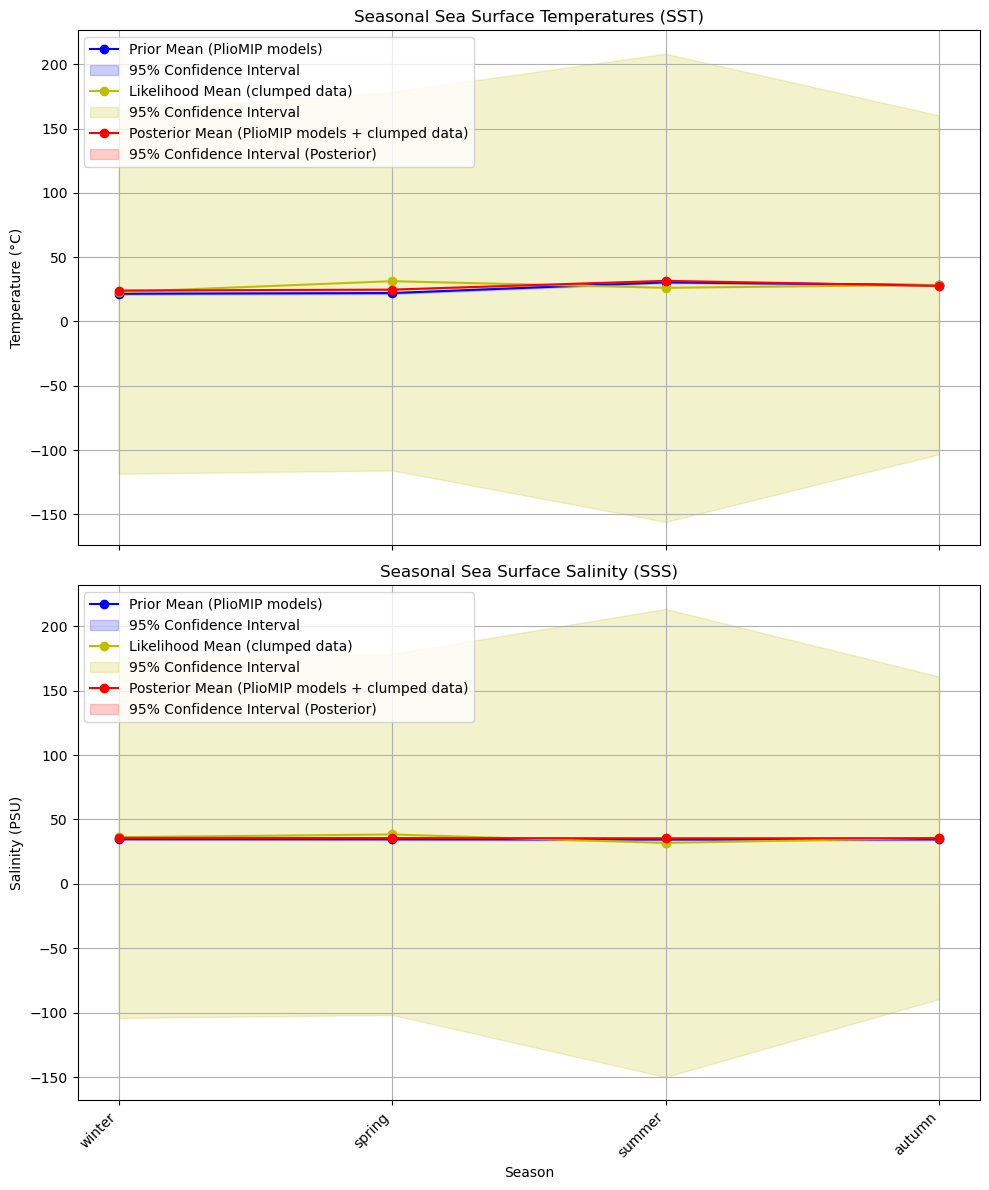

In [51]:
# Convert prior D47 to temp
# Use OGLS23 equation to convert D47 to temperature
mu_prior_SST_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_SST_D47_seasonal_original, sD47 = cov_prior_SST_D47_seasonal_original, return_covar = True)[0]
cov_prior_SST_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_SST_D47_seasonal_original, sD47 = cov_prior_SST_D47_seasonal_original, return_covar = True)[1]

# Convert prior d18Oc and temperature to d18Ow
# Use inverted equation from Grossman and Ku (1986) and corrected for the 0.27 per mil offset (Dettmann et al., 1999)
mu_prior_d18Ow_seasonal_T = mu_prior_d18Oc_seasonal_original - (20.6 - mu_prior_SST_D47_seasonal_T) / 4.34 + 0.27 # Use inverted equation from Grossman and Ku (1986) and corrected for the 0.27 per mil offset (Dettmann et al., 1999)
cov_prior_d18Ow_seasonal_T = cov_prior_d18Oc_seasonal_original + (1 / 4.34) ** 2 * cov_prior_SST_D47_seasonal_T

# Convert prior d18Ow to SSS
# Use the equation from SSS = (d18Ow + 9.300) / 0.274 (Harwood et al., 2008)
mu_prior_SSS_d18Ow_seasonal_T = (mu_prior_d18Ow_seasonal_T + 9.300) / 0.274
cov_prior_SSS_d18Ow_seasonal_T = cov_prior_d18Ow_seasonal_T / (0.274 ** 2)

# Convert likelihood D47 to temp
mu_likelihood_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal], sD47 = std_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal], return_covar = True)[0]
cov_likelihood_seasonal_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal], sD47 = std_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal], return_covar = True)[1]

# Convert likelihood d18Oc and temperature to d18Ow (curently not implemented in data tracking function)
mu_likelihood_d18Ow_seasonal_T = mu_likelihood_seasonal_aggregated[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] - (20.6 - mu_likelihood_seasonal_aggregated_T) / 4.34 + 0.27
std_likelihood_d18Ow_seasonal_T = std_likelihood_seasonal_aggregated[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] + (1 / 4.34) ** 2 * np.sqrt(np.diag(cov_likelihood_seasonal_T))

# Convert likelihood d18Ow to SSS (currently not implemented in data tracking function)
mu_likelihood_SSS_d18Ow_seasonal_T = (mu_likelihood_d18Ow_seasonal_T + 9.300) / 0.274
std_likelihood_SSS_d18Ow_seasonal_T = std_likelihood_d18Ow_seasonal_T / (0.274 ** 2)

# Convert posterior D47 to temp
mu_post_SST_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_seasonal_aggregated, sD47 = cov_post_SST_D47_seasonal_aggregated, return_covar = True)[0]
cov_post_SST_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_seasonal_aggregated, sD47 = cov_post_SST_D47_seasonal_aggregated, return_covar = True)[1]

# Convert posterior d18Oc and temperature to d18Ow
mu_post_d18Ow_seasonal_aggregated_T = mu_post_d18Oc_seasonal_aggregated - (20.6 - mu_post_SST_D47_seasonal_aggregated_T) / 4.34 + 0.27
cov_post_d18Ow_seasonal_aggregated_T = cov_post_d18Oc_seasonal_aggregated + (1 / 4.34) ** 2 * cov_post_SST_D47_seasonal_aggregated_T

# Convert posterior d18Ow to SSS
mu_post_SSS_d18Ow_seasonal_aggregated_T = (mu_post_d18Ow_seasonal_aggregated_T + 9.300) / 0.274
cov_post_SSS_d18Ow_seasonal_aggregated_T = cov_post_d18Ow_seasonal_aggregated_T / (0.274 ** 2)

# Plot in temperature domain
std_prior_SST_D47_seasonal_T = np.sqrt(np.diag(cov_prior_SST_D47_seasonal_T))
std_prior_SSS_d18Ow_seasonal_T = np.sqrt(np.diag(cov_prior_SSS_d18Ow_seasonal_T))
std_likelihood_seasonal_aggregated_T = np.sqrt(np.diag(cov_likelihood_seasonal_T))
std_post_SST_D47_seasonal_aggregated_T = np.sqrt(np.diag(cov_post_SST_D47_seasonal_aggregated_T))
std_post_SSS_d18Ow_seasonal_aggregated_T = np.sqrt(np.diag(cov_post_SSS_d18Ow_seasonal_aggregated_T))

# Initiate plot
fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# FIRST PANEL: SST Results
# PRIOR
axs[0].plot(seasons_scale, mu_prior_SST_D47_seasonal_T, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[0].fill_between(seasons_scale,
    mu_prior_SST_D47_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_SST_D47_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_T / np.sqrt(n_models_seasonal),
    color='b', alpha=0.2, label='95% Confidence Interval')

# LIKELIHOOD
axs[0].plot(seasons_scale, mu_likelihood_seasonal_aggregated_T, label='Likelihood Mean (clumped data)', color='y', marker='o')
axs[0].fill_between(seasons_scale,
    mu_likelihood_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47) * std_likelihood_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47),
    mu_likelihood_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47) * std_likelihood_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47),
    color='y', alpha=0.2, label='95% Confidence Interval')

# POSTERIOR
axs[0].plot(seasons_scale, mu_post_SST_D47_seasonal_aggregated_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[0].fill_between(seasons_scale,
    mu_post_SST_D47_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_D47 + n_models_seasonal)) * std_post_SST_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal),
    mu_post_SST_D47_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_D47 + n_models_seasonal)) * std_post_SST_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)')

# Layout for SST panel
axs[0].set_title('Seasonal Sea Surface Temperatures (SST)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].legend(loc='upper left')
axs[0].grid(True)

# SECOND PANEL: SSS Results
# PRIOR
axs[1].plot(seasons_scale, mu_prior_SSS_d18Ow_seasonal_T, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[1].fill_between(seasons_scale,
    mu_prior_SSS_d18Ow_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_SSS_d18Ow_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal),
    color='b', alpha=0.2, label='95% Confidence Interval')

# LIKELIHOOD
axs[1].plot(seasons_scale, mu_likelihood_SSS_d18Ow_seasonal_T, label='Likelihood Mean (clumped data)', color='y', marker='o')
axs[1].fill_between(seasons_scale,
    mu_likelihood_SSS_d18Ow_seasonal_T - stats.t.ppf(1 - 0.025, n_update_seasonal_d18Oc) * std_likelihood_SSS_d18Ow_seasonal_T / np.sqrt(n_update_seasonal_d18Oc),
    mu_likelihood_SSS_d18Ow_seasonal_T + stats.t.ppf(1 - 0.025, n_update_seasonal_d18Oc) * std_likelihood_SSS_d18Ow_seasonal_T / np.sqrt(n_update_seasonal_d18Oc),
    color='y', alpha=0.2, label='95% Confidence Interval')

# POSTERIOR
axs[1].plot(seasons_scale, mu_post_SSS_d18Ow_seasonal_aggregated_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[1].fill_between(seasons_scale,
    mu_post_SSS_d18Ow_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_seasonal_d18Oc + n_models_seasonal)) * std_post_SSS_d18Ow_seasonal_aggregated_T / np.sqrt(n_update_seasonal_d18Oc + n_models_seasonal),
    mu_post_SSS_d18Ow_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_seasonal_d18Oc + n_models_seasonal)) * std_post_SSS_d18Ow_seasonal_aggregated_T / np.sqrt(n_update_seasonal_d18Oc + n_models_seasonal),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)')

# Layout for SSS panel
axs[1].set_title('Seasonal Sea Surface Salinity (SSS)')
axs[1].set_xlabel('Season')
axs[1].set_ylabel('Salinity (PSU)')
axs[1].legend(loc='upper left')
axs[1].grid(True)

# Shared x-axis labels
plt.xticks(seasons_scale, seasons, rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Plot SAT and precipitation prior and posterior

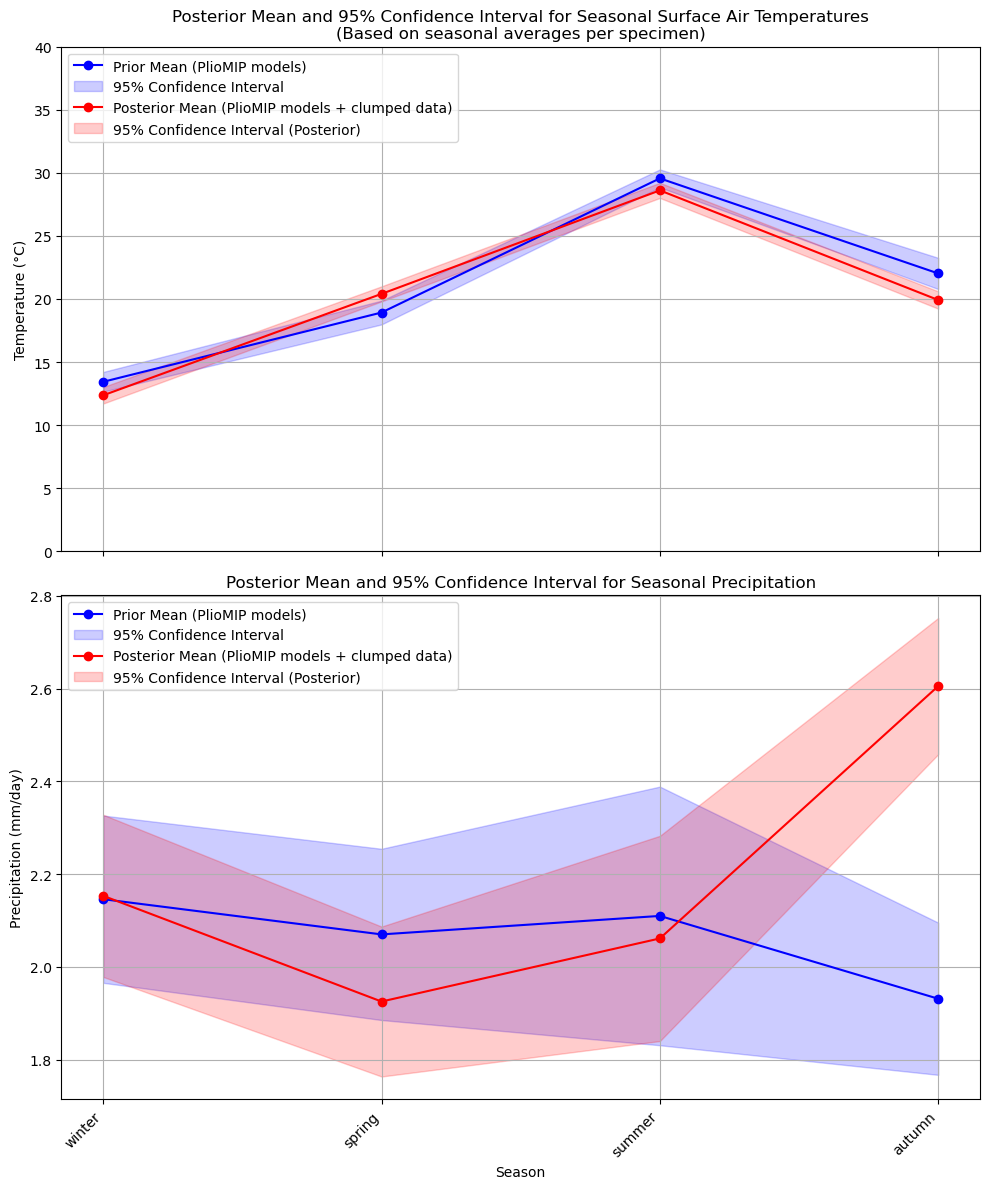

In [52]:
# Convert posterior D47 to temp
mu_post_SAT_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_seasonal_aggregated, sD47 = cov_post_SAT_D47_seasonal_aggregated, return_covar = True)[0]
cov_post_SAT_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_seasonal_aggregated, sD47 = cov_post_SAT_D47_seasonal_aggregated, return_covar = True)[1]

# Convert posterior SAT-D47 back to temperature
std_post_SAT_D47_seasonal_aggregated_T = np.nan_to_num(np.sqrt(np.diag(cov_post_SAT_D47_seasonal_aggregated_T)))

fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# --- SAT prior and posterior ---
# PRIOR
axs[0].plot(seasons_scale, mu_prior_SAT_seasonal_original, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[0].fill_between(
    seasons_scale,
    mu_prior_SAT_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    color='b', alpha=0.2, label='95% Confidence Interval'
)

# POSTERIOR
axs[0].plot(seasons_scale, mu_post_SAT_D47_seasonal_aggregated_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[0].fill_between(
    seasons_scale,
    mu_post_SAT_D47_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_D47 + n_models_seasonal)) * std_post_SAT_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal),
    mu_post_SAT_D47_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_D47 + n_models_seasonal)) * std_post_SAT_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)'
)

axs[0].set_title('Posterior Mean and 95% Confidence Interval for Seasonal Surface Air Temperatures\n(Based on seasonal averages per specimen)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_ylim(0, 40)
axs[0].legend(loc='upper left')
axs[0].grid(True)

# --- Precipitation prior and posterior ---
# PRIOR
axs[1].plot(seasons_scale, mu_prior_precip_seasonal_original, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[1].fill_between(
    seasons_scale,
    mu_prior_precip_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_precip_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    color='b', alpha=0.2, label='95% Confidence Interval'
)

# POSTERIOR
axs[1].plot(seasons_scale, mu_post_precip_seasonal_aggregated, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[1].fill_between(
    seasons_scale,
    mu_post_precip_seasonal_aggregated - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_D47 + n_models_seasonal)) * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)) / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal),
    mu_post_precip_seasonal_aggregated + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_D47 + n_models_seasonal)) * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)) / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)'
)

axs[1].set_title('Posterior Mean and 95% Confidence Interval for Seasonal Precipitation')
axs[1].set_xlabel('Season')
axs[1].set_ylabel('Precipitation (mm/day)')
axs[1].legend(loc='upper left')
axs[1].grid(True)

plt.xticks(seasons_scale, seasons, rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Plot SAT, SST, SSS and precipitation posterior

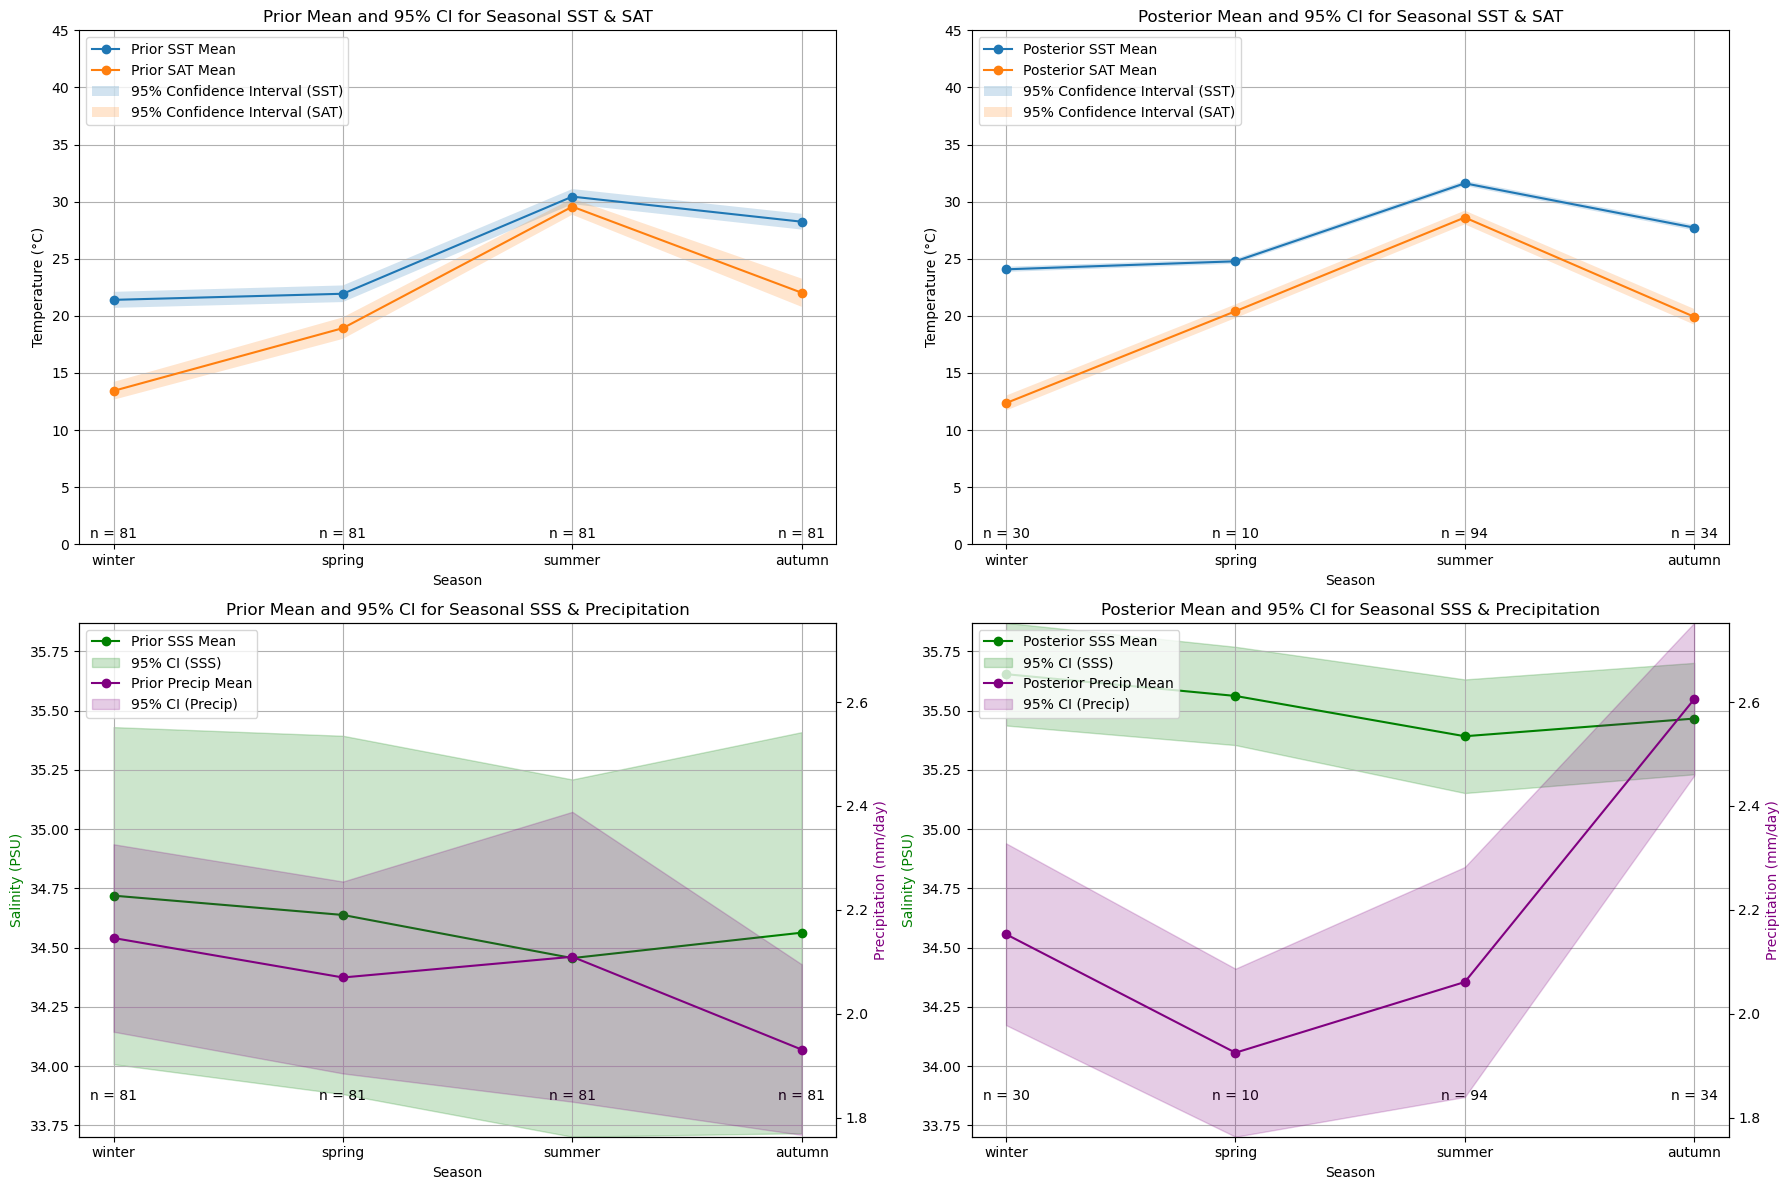

In [53]:
# Create a figure with two rows and two columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --- SST & SAT Prior and Posterior ---
# Prior SST & SAT
axes[0, 0].plot(seasons_scale, mu_prior_SST_seasonal, label='Prior SST Mean', marker='o')
axes[0, 0].plot(seasons_scale, mu_prior_SAT_seasonal, label='Prior SAT Mean', marker='o')
axes[0, 0].fill_between(
    seasons_scale,
    mu_prior_SST_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SST_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, label='95% Confidence Interval (SST)'
)
axes[0, 0].fill_between(
    seasons_scale,
    mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, label='95% Confidence Interval (SAT)'
)
axes[0, 0].set_xticks(seasons_scale)
axes[0, 0].set_xticklabels(seasons)
axes[0, 0].set_title('Prior Mean and 95% CI for Seasonal SST & SAT')
axes[0, 0].set_xlabel('Season')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_ylim(0, 45)
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True)

# Posterior SST & SAT
axes[0, 1].plot(seasons_scale, mu_post_SST_D47_seasonal_aggregated_T, label='Posterior SST Mean', marker='o')
axes[0, 1].plot(seasons_scale, mu_post_SAT_D47_seasonal_aggregated_T, label='Posterior SAT Mean', marker='o')
axes[0, 1].fill_between(
    seasons_scale,
    mu_post_SST_D47_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_models_seasonal) * std_post_SST_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal),
    mu_post_SST_D47_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_models_seasonal) * std_post_SST_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal),
    alpha=0.2, label='95% Confidence Interval (SST)'
)
axes[0, 1].fill_between(
    seasons_scale,
    mu_post_SAT_D47_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_models_seasonal) * std_post_SAT_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal),
    mu_post_SAT_D47_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_models_seasonal) * std_post_SAT_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal),
    alpha=0.2, label='95% Confidence Interval (SAT)'
)
axes[0, 1].set_xticks(seasons_scale)
axes[0, 1].set_xticklabels(seasons)
axes[0, 1].set_title('Posterior Mean and 95% CI for Seasonal SST & SAT')
axes[0, 1].set_xlabel('Season')
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].set_ylim(0, 45)
axes[0, 1].legend(loc='upper left')
axes[0, 1].grid(True)

# --- SSS & Precipitation Prior and Posterior (Shared Plot, Twin Axes) ---

# Get y-limits for SSS and precipitation (prior and posterior) to keep them consistent
sss_min = min(np.min(mu_prior_SSS_d18Ow_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal)),
              np.min(mu_post_SSS_d18Ow_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_models_seasonal) * std_post_SSS_d18Ow_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal)))
sss_max = max(np.max(mu_prior_SSS_d18Ow_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal)),
              np.max(mu_post_SSS_d18Ow_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_models_seasonal) * std_post_SSS_d18Ow_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal)))
precip_min = min(np.min(mu_prior_precip_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal)),
                 np.min(mu_post_precip_seasonal_aggregated - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_models_seasonal) * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)) / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal)))
precip_max = max(np.max(mu_prior_precip_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal)),
                 np.max(mu_post_precip_seasonal_aggregated + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_models_seasonal) * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)) / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal)))

# --- Prior SSS & Precipitation ---
ax1 = axes[1, 0]
ax2 = ax1.twinx()
lns1 = ax1.plot(seasons_scale, mu_prior_SSS_d18Ow_seasonal_T, label='Prior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    seasons_scale,
    mu_prior_SSS_d18Ow_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_SSS_d18Ow_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal),
    color="green", alpha=0.2, label='95% CI (SSS)'
)
lns2 = ax2.plot(seasons_scale, mu_prior_precip_seasonal_original, label='Prior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    seasons_scale,
    mu_prior_precip_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_precip_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    color="purple", alpha=0.2, label='95% CI (Precip)'
)
ax1.set_xticks(seasons_scale)
ax1.set_xticklabels(seasons)
ax1.set_title('Prior Mean and 95% CI for Seasonal SSS & Precipitation')
ax1.set_xlabel('Season')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# --- Posterior SSS & Precipitation ---
ax1 = axes[1, 1]
ax2 = ax1.twinx()
lns1 = ax1.plot(seasons_scale, mu_post_SSS_d18Ow_seasonal_aggregated_T, label='Posterior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    seasons_scale,
    mu_post_SSS_d18Ow_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_models_seasonal) * std_post_SSS_d18Ow_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal),
    mu_post_SSS_d18Ow_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_models_seasonal) * std_post_SSS_d18Ow_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal),
    color="green", alpha=0.2, label='95% CI (SSS)'
)
lns2 = ax2.plot(seasons_scale, mu_post_precip_seasonal_aggregated, label='Posterior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    seasons_scale,
    mu_post_precip_seasonal_aggregated - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_models_seasonal) * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)) / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal),
    mu_post_precip_seasonal_aggregated + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_models_seasonal) * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)) / np.sqrt(n_update_seasonal_aggregated_D47 + n_models_seasonal),
    color="purple", alpha=0.2, label='95% CI (Precip)'
)
ax1.set_xticks(seasons_scale)
ax1.set_xticklabels(seasons)
ax1.set_title('Posterior Mean and 95% CI for Seasonal SSS & Precipitation')
ax1.set_xlabel('Season')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# Add "n = x" labels below each x-tick for each subplot to show the number of model values or updates
# Prior SST & SAT
for i, season in enumerate(seasons):
    axes[0, 0].text(
        seasons_scale[i], axes[0, 0].get_ylim()[0] + 1.5,  # adjust location as needed
        f"n = {n_models_seasonal[i] if hasattr(n_models_seasonal, '__getitem__') else n_models_seasonal}",
        ha='center', va='top', fontsize=10
    )

# Posterior SST & SAT
for i, season in enumerate(seasons):
    axes[0, 1].text(
        seasons_scale[i], axes[0, 1].get_ylim()[0] + 1.5,
        f"n = {int(n_update_seasonalSC_D47[i]) if hasattr(n_update_seasonalSC_D47, '__getitem__') else n_update_seasonalSC_D47}",
        ha='center', va='top', fontsize=10
    )

# Prior SSS & Precipitation
for i, season in enumerate(seasons):
    axes[1, 0].text(
        seasons_scale[i], axes[1, 0].get_ylim()[0] + 0.2,
        f"n = {n_models_seasonal[i] if hasattr(n_models_seasonal, '__getitem__') else n_models_seasonal}",
        ha='center', va='top', fontsize=10
    )

# Posterior SSS & Precipitation
for i, season in enumerate(seasons):
    axes[1, 1].text(
        seasons_scale[i], axes[1, 1].get_ylim()[0] + 0.2,
        f"n = {int(n_update_seasonalSC_D47[i]) if hasattr(n_update_seasonalSC_D47, '__getitem__') else n_update_seasonalSC_D47}",
        ha='center', va='top', fontsize=10
    )

plt.tight_layout()
plt.show()

### Plot SAT, SST, SSS and precipitation posterior with uncertainties as 2 SD

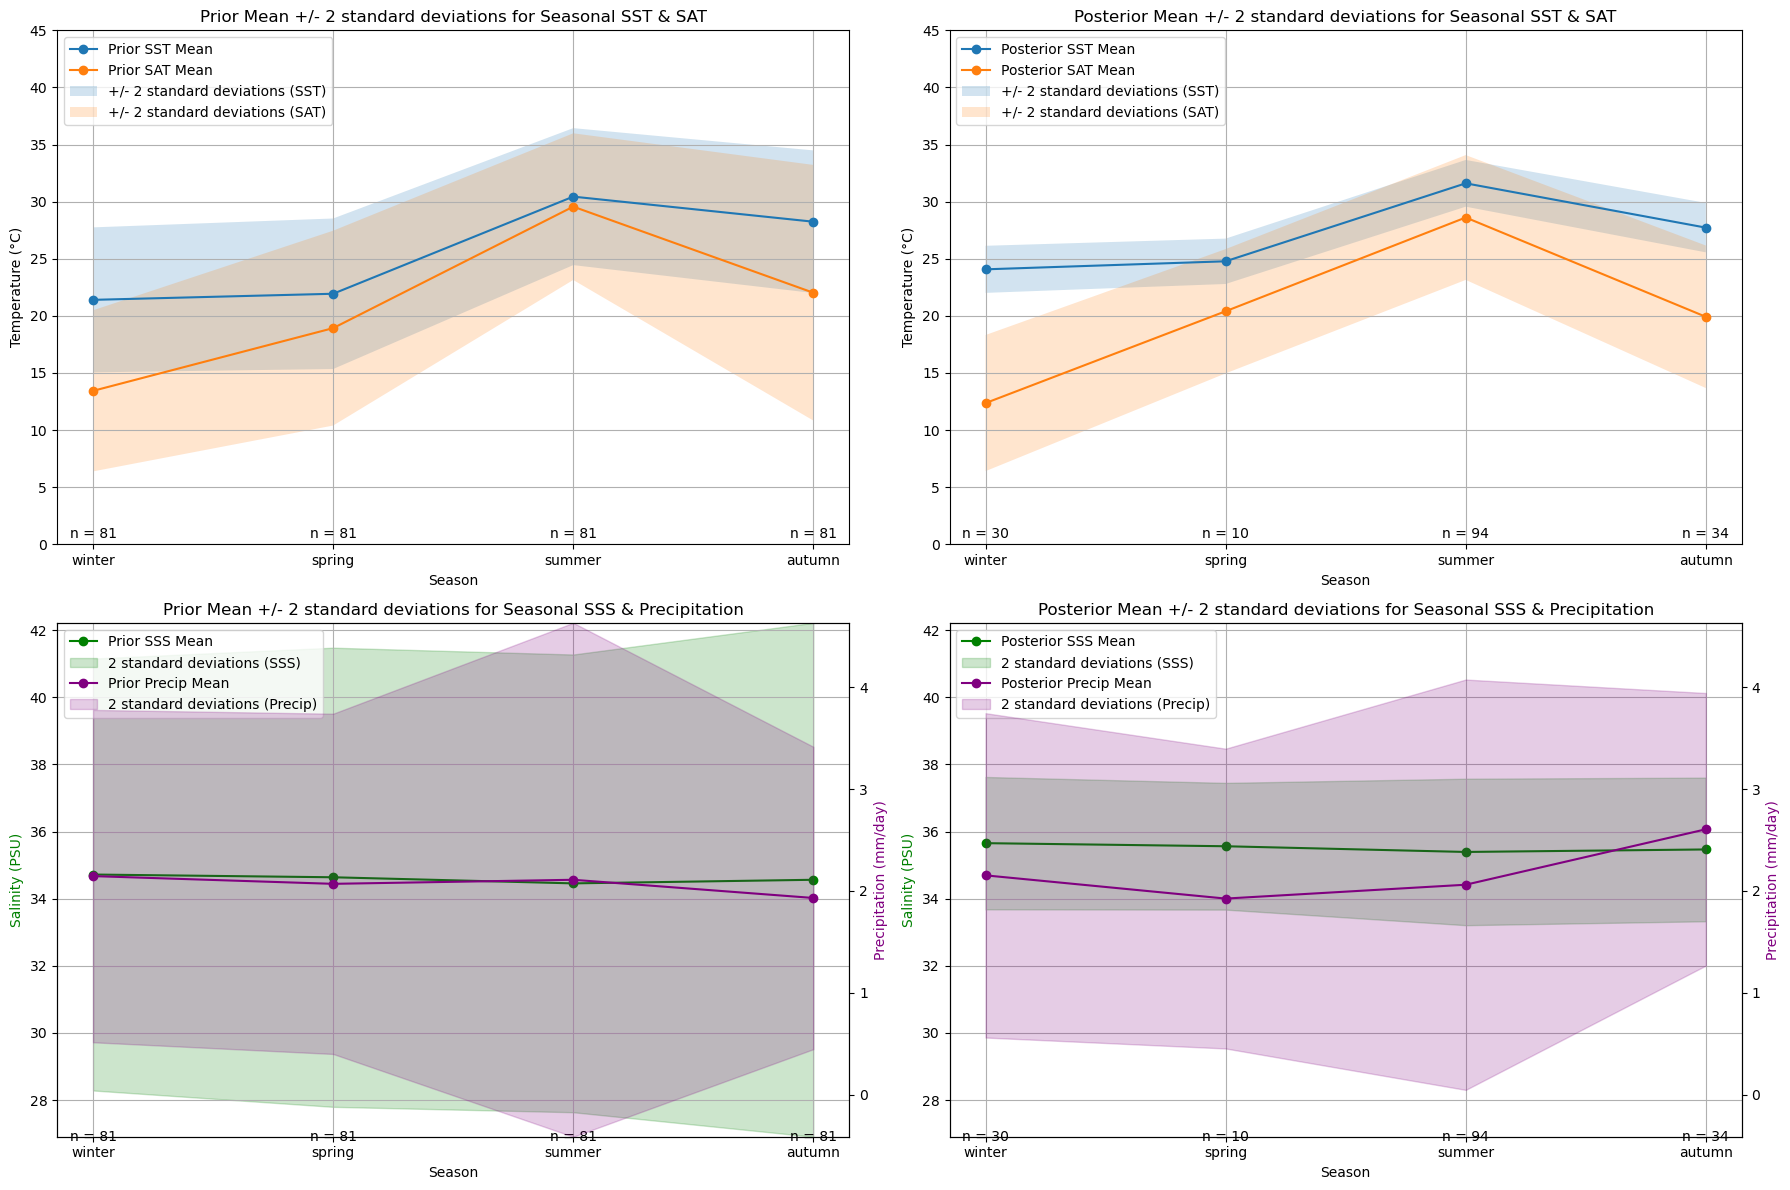

In [54]:
# Create a figure with two rows and two columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --- SST & SAT Prior and Posterior ---
# Prior SST & SAT
axes[0, 0].plot(seasons_scale, mu_prior_SST_seasonal, label='Prior SST Mean', marker='o')
axes[0, 0].plot(seasons_scale, mu_prior_SAT_seasonal, label='Prior SAT Mean', marker='o')
axes[0, 0].fill_between(
    seasons_scale,
    mu_prior_SST_seasonal - 2 * std_prior_SST_seasonal,
    mu_prior_SST_seasonal + 2 * std_prior_SST_seasonal,
    alpha=0.2, label='+/- 2 standard deviations (SST)'
)
axes[0, 0].fill_between(
    seasons_scale,
    mu_prior_SAT_seasonal - 2 * std_prior_SAT_seasonal,
    mu_prior_SAT_seasonal + 2 * std_prior_SAT_seasonal,
    alpha=0.2, label='+/- 2 standard deviations (SAT)'
)
axes[0, 0].set_xticks(seasons_scale)
axes[0, 0].set_xticklabels(seasons)
axes[0, 0].set_title('Prior Mean +/- 2 standard deviations for Seasonal SST & SAT')
axes[0, 0].set_xlabel('Season')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_ylim(0, 45)
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True)

# Posterior SST & SAT
axes[0, 1].plot(seasons_scale, mu_post_SST_D47_seasonal_aggregated_T, label='Posterior SST Mean', marker='o')
axes[0, 1].plot(seasons_scale, mu_post_SAT_D47_seasonal_aggregated_T, label='Posterior SAT Mean', marker='o')
axes[0, 1].fill_between(
    seasons_scale,
    mu_post_SST_D47_seasonal_aggregated_T - 2 * std_post_SST_D47_seasonal_aggregated_T,
    mu_post_SST_D47_seasonal_aggregated_T + 2 * std_post_SST_D47_seasonal_aggregated_T,
    alpha=0.2, label='+/- 2 standard deviations (SST)'
)
axes[0, 1].fill_between(
    seasons_scale,
    mu_post_SAT_D47_seasonal_aggregated_T - 2 * std_post_SAT_D47_seasonal_aggregated_T,
    mu_post_SAT_D47_seasonal_aggregated_T + 2 * std_post_SAT_D47_seasonal_aggregated_T,
    alpha=0.2, label='+/- 2 standard deviations (SAT)'
)
axes[0, 1].set_xticks(seasons_scale)
axes[0, 1].set_xticklabels(seasons)
axes[0, 1].set_title('Posterior Mean +/- 2 standard deviations for Seasonal SST & SAT')
axes[0, 1].set_xlabel('Season')
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].set_ylim(0, 45)
axes[0, 1].legend(loc='upper left')
axes[0, 1].grid(True)

# --- SSS & Precipitation Prior and Posterior (Shared Plot, Twin Axes) ---

# Get y-limits for SSS and precipitation (prior and posterior) to keep them consistent
sss_min = min(np.min(mu_prior_SSS_d18Ow_seasonal_T - 2 * std_prior_SSS_d18Ow_seasonal_T),
              np.min(mu_post_SSS_d18Ow_seasonal_aggregated_T - 2 * std_post_SSS_d18Ow_seasonal_aggregated_T))
sss_max = max(np.max(mu_prior_SSS_d18Ow_seasonal_T + 2 * std_prior_SSS_d18Ow_seasonal_T),
              np.max(mu_post_SSS_d18Ow_seasonal_aggregated_T + 2 * std_post_SSS_d18Ow_seasonal_aggregated_T))
precip_min = min(np.min(mu_prior_precip_seasonal_original - 2 * std_prior_precip_seasonal),
                 np.min(mu_post_precip_seasonal_aggregated - 2 * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated))))
precip_max = max(np.max(mu_prior_precip_seasonal_original + 2 * std_prior_precip_seasonal),
                 np.max(mu_post_precip_seasonal_aggregated + 2 * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated))))

# --- Prior SSS & Precipitation ---
ax1 = axes[1, 0]
ax2 = ax1.twinx()
lns1 = ax1.plot(seasons_scale, mu_prior_SSS_d18Ow_seasonal_T, label='Prior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    seasons_scale,
    mu_prior_SSS_d18Ow_seasonal_T - 2 * std_prior_SSS_d18Ow_seasonal_T,
    mu_prior_SSS_d18Ow_seasonal_T + 2 * std_prior_SSS_d18Ow_seasonal_T,
    color="green", alpha=0.2, label='2 standard deviations (SSS)'
)
lns2 = ax2.plot(seasons_scale, mu_prior_precip_seasonal_original, label='Prior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    seasons_scale,
    mu_prior_precip_seasonal_original - 2 * std_prior_precip_seasonal,
    mu_prior_precip_seasonal_original + 2 * std_prior_precip_seasonal,
    color="purple", alpha=0.2, label='2 standard deviations (Precip)'
)
ax1.set_xticks(seasons_scale)
ax1.set_xticklabels(seasons)
ax1.set_title('Prior Mean +/- 2 standard deviations for Seasonal SSS & Precipitation')
ax1.set_xlabel('Season')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# --- Posterior SSS & Precipitation ---
ax1 = axes[1, 1]
ax2 = ax1.twinx()
lns1 = ax1.plot(seasons_scale, mu_post_SSS_d18Ow_seasonal_aggregated_T, label='Posterior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    seasons_scale,
    mu_post_SSS_d18Ow_seasonal_aggregated_T - 2 * std_post_SSS_d18Ow_seasonal_aggregated_T,
    mu_post_SSS_d18Ow_seasonal_aggregated_T + 2 * std_post_SSS_d18Ow_seasonal_aggregated_T,
    color="green", alpha=0.2, label='2 standard deviations (SSS)'
)
lns2 = ax2.plot(seasons_scale, mu_post_precip_seasonal_aggregated, label='Posterior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    seasons_scale,
    mu_post_precip_seasonal_aggregated - 2 * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)),
    mu_post_precip_seasonal_aggregated + 2 * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)),
    color="purple", alpha=0.2, label='2 standard deviations (Precip)'
)
ax1.set_xticks(seasons_scale)
ax1.set_xticklabels(seasons)
ax1.set_title('Posterior Mean +/- 2 standard deviations for Seasonal SSS & Precipitation')
ax1.set_xlabel('Season')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# Add "n = x" labels below each x-tick for each subplot to show the number of model values or updates
# Prior SST & SAT
for i, season in enumerate(seasons):
    axes[0, 0].text(
        seasons_scale[i], axes[0, 0].get_ylim()[0] + 1.5,  # adjust location as needed
        f"n = {n_models_seasonal[i] if hasattr(n_models_seasonal, '__getitem__') else n_models_seasonal}",
        ha='center', va='top', fontsize=10
    )

# Posterior SST & SAT
for i, season in enumerate(seasons):
    axes[0, 1].text(
        seasons_scale[i], axes[0, 1].get_ylim()[0] + 1.5,
        f"n = {int(n_update_seasonalSC_D47[i]) if hasattr(n_update_seasonalSC_D47, '__getitem__') else n_update_seasonalSC_D47}",
        ha='center', va='top', fontsize=10
    )

# Prior SSS & Precipitation
for i, season in enumerate(seasons):
    axes[1, 0].text(
        seasons_scale[i], axes[1, 0].get_ylim()[0] + 0.2,
        f"n = {n_models_seasonal[i] if hasattr(n_models_seasonal, '__getitem__') else n_models_seasonal}",
        ha='center', va='top', fontsize=10
    )

# Posterior SSS & Precipitation
for i, season in enumerate(seasons):
    axes[1, 1].text(
        seasons_scale[i], axes[1, 1].get_ylim()[0] + 0.2,
        f"n = {int(n_update_seasonalSC_D47[i]) if hasattr(n_update_seasonalSC_D47, '__getitem__') else n_update_seasonalSC_D47}",
        ha='center', va='top', fontsize=10
    )

plt.tight_layout()
plt.show()

## Seasonal posterior in temperature and salinity domains with data based on ShellChron (including ShellChron uncertainty)
* Aggregate data and model outcomes in 4 seasons based on ShellChron outcomes
* Including sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

### Convert seasonal prior, likelihood and posterior to temperature and salinity and plot

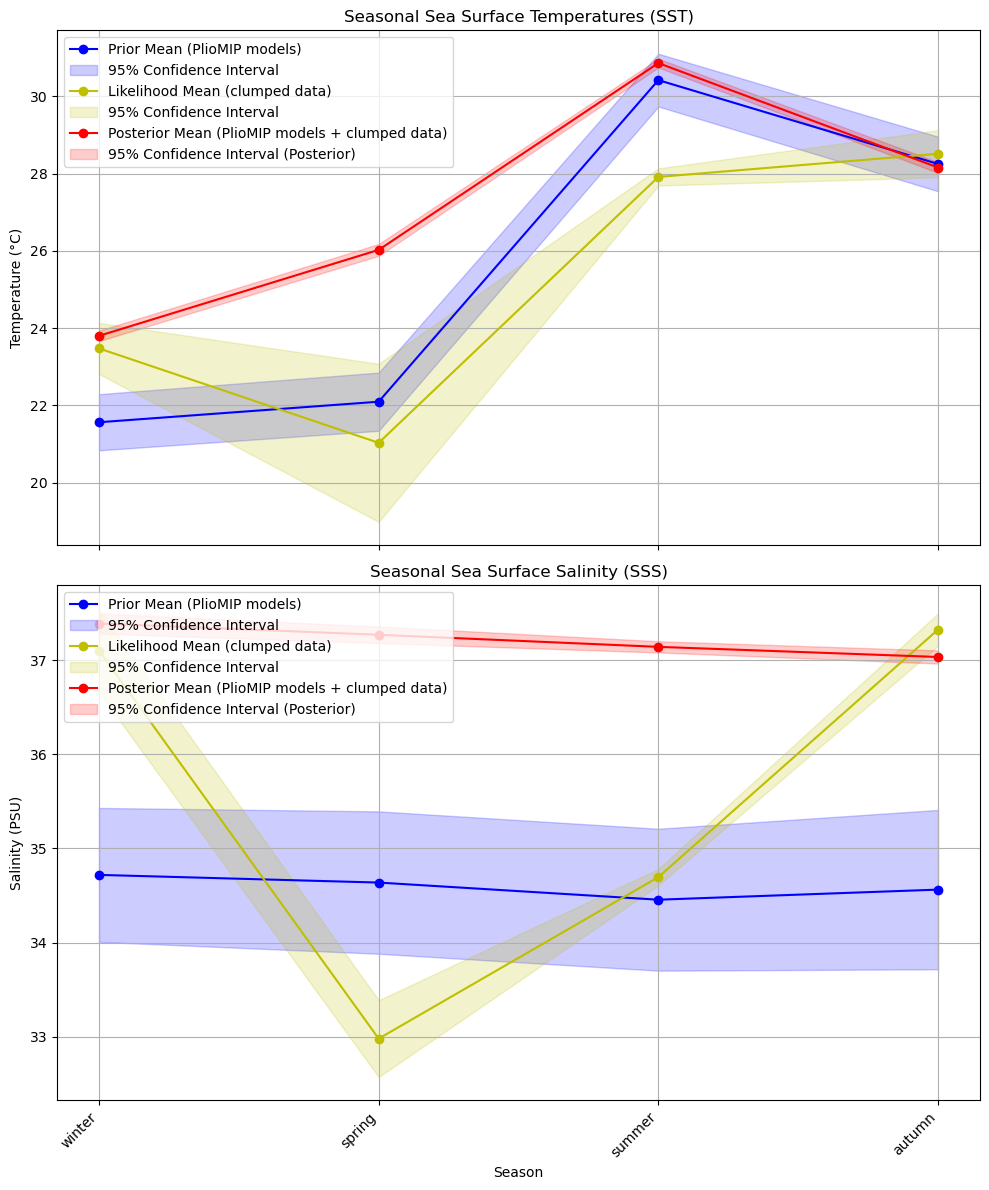

In [55]:
# (Priors are identical to the seasonal priors above)
# Convert likelihood D47 to temp
mu_likelihood_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC[var_start_D47_seasonal:var_end_D47_seasonal], sD47 = std_likelihood_seasonalSC[var_start_D47_seasonal:var_end_D47_seasonal], return_covar = True)[0]
cov_likelihood_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC[var_start_D47_seasonal:var_end_D47_seasonal], sD47 = std_likelihood_seasonalSC[var_start_D47_seasonal:var_end_D47_seasonal], return_covar = True)[1]

# Convert likelihood d18Oc and temperature to d18Ow (curently not implemented in data tracking function)
mu_likelihood_d18Ow_seasonalSC_T = mu_likelihood_seasonalSC[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] - (20.6 - mu_likelihood_seasonalSC_T) / 4.34 + 0.27
std_likelihood_d18Ow_seasonalSC_T = std_likelihood_seasonalSC[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] + (1 / 4.34) ** 2 * np.sqrt(np.diag(cov_likelihood_seasonalSC_T))

# Convert likelihood d18Ow to SSS (currently not implemented in data tracking function)
mu_likelihood_SSS_d18Ow_seasonalSC_T = (mu_likelihood_d18Ow_seasonalSC_T + 9.300) / 0.274
std_likelihood_SSS_d18Ow_seasonalSC_T = std_likelihood_d18Ow_seasonalSC_T / (0.274 ** 2)

# Convert posterior D47 to temp
mu_post_SST_D47_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_seasonalSC, sD47 = cov_post_SST_D47_seasonalSC, return_covar = True)[0]
cov_post_SST_D47_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_seasonalSC, sD47 = cov_post_SST_D47_seasonalSC, return_covar = True)[1]

# Convert posterior d18Oc and temperature to d18Ow
mu_post_d18Ow_seasonalSC_T = mu_post_d18Oc_seasonalSC - (20.6 - mu_post_SST_D47_seasonalSC_T) / 4.34 + 0.27
cov_post_d18Ow_seasonalSC_T = cov_post_d18Oc_seasonalSC + (1 / 4.34) ** 2 * cov_post_SST_D47_seasonalSC_T

# Convert posterior d18Ow to SSS
mu_post_SSS_d18Ow_seasonalSC_T = (mu_post_d18Ow_seasonalSC_T + 9.300) / 0.274
cov_post_SSS_d18Ow_seasonalSC_T = cov_post_d18Ow_seasonalSC_T / (0.274 ** 2)

# Plot in temperature domain
std_prior_SST_D47_seasonal_T = np.sqrt(np.diag(cov_prior_SST_D47_seasonal_T))
std_prior_SSS_d18Ow_seasonal_T = np.sqrt(np.diag(cov_prior_SSS_d18Ow_seasonal_T))
std_likelihood_seasonalSC_T = np.sqrt(np.diag(cov_likelihood_seasonalSC_T))
std_post_SST_D47_seasonalSC_T = np.sqrt(np.diag(cov_post_SST_D47_seasonalSC_T))
std_post_SSS_d18Ow_seasonalSC_T = np.sqrt(np.diag(cov_post_SSS_d18Ow_seasonalSC_T))

# Initiate plot
fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# FIRST PANEL: SST Results
# PRIOR
axs[0].plot(seasons_scale, mu_prior_SST_D47_seasonal_T, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[0].fill_between(seasons_scale,
    mu_prior_SST_D47_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_SST_D47_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_T / np.sqrt(n_models_seasonal),
    color='b', alpha=0.2, label='95% Confidence Interval')

# LIKELIHOOD
axs[0].plot(seasons_scale, mu_likelihood_seasonalSC_T, label='Likelihood Mean (clumped data)', color='y', marker='o')
axs[0].fill_between(seasons_scale,
    mu_likelihood_seasonalSC_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC_D47) * std_likelihood_seasonalSC_T / np.sqrt(n_update_seasonalSC_D47),
    mu_likelihood_seasonalSC_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC_D47) * std_likelihood_seasonalSC_T / np.sqrt(n_update_seasonalSC_D47),
    color='y', alpha=0.2, label='95% Confidence Interval')

# POSTERIOR
axs[0].plot(seasons_scale, mu_post_SST_D47_seasonalSC_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[0].fill_between(seasons_scale,
    mu_post_SST_D47_seasonalSC_T - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_D47 + n_models_seasonal)) * std_post_SST_D47_seasonalSC_T / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal),
    mu_post_SST_D47_seasonalSC_T + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_D47 + n_models_seasonal)) * std_post_SST_D47_seasonalSC_T / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)')

# Layout for SST panel
axs[0].set_title('Seasonal Sea Surface Temperatures (SST)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].legend(loc='upper left')
axs[0].grid(True)

# SECOND PANEL: SSS Results
# PRIOR
axs[1].plot(seasons_scale, mu_prior_SSS_d18Ow_seasonal_T, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[1].fill_between(seasons_scale,
    mu_prior_SSS_d18Ow_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_SSS_d18Ow_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal),
    color='b', alpha=0.2, label='95% Confidence Interval')

# LIKELIHOOD
axs[1].plot(seasons_scale, mu_likelihood_SSS_d18Ow_seasonalSC_T, label='Likelihood Mean (clumped data)', color='y', marker='o')
axs[1].fill_between(seasons_scale,
    mu_likelihood_SSS_d18Ow_seasonalSC_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC_d18Oc) * std_likelihood_SSS_d18Ow_seasonalSC_T / np.sqrt(n_update_seasonalSC_d18Oc),
    mu_likelihood_SSS_d18Ow_seasonalSC_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC_d18Oc) * std_likelihood_SSS_d18Ow_seasonalSC_T / np.sqrt(n_update_seasonalSC_d18Oc),
    color='y', alpha=0.2, label='95% Confidence Interval')

# POSTERIOR
axs[1].plot(seasons_scale, mu_post_SSS_d18Ow_seasonalSC_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[1].fill_between(seasons_scale,
    mu_post_SSS_d18Ow_seasonalSC_T - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_d18Oc + n_models_seasonal)) * std_post_SSS_d18Ow_seasonalSC_T / np.sqrt(n_update_seasonalSC_d18Oc + n_models_seasonal),
    mu_post_SSS_d18Ow_seasonalSC_T + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_d18Oc + n_models_seasonal)) * std_post_SSS_d18Ow_seasonalSC_T / np.sqrt(n_update_seasonalSC_d18Oc + n_models_seasonal),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)')

# Layout for SSS panel
axs[1].set_title('Seasonal Sea Surface Salinity (SSS)')
axs[1].set_xlabel('Season')
axs[1].set_ylabel('Salinity (PSU)')
axs[1].legend(loc='upper left')
axs[1].grid(True)

# Shared x-axis labels
plt.xticks(seasons_scale, seasons, rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Plot SAT and precipitation prior and posterior

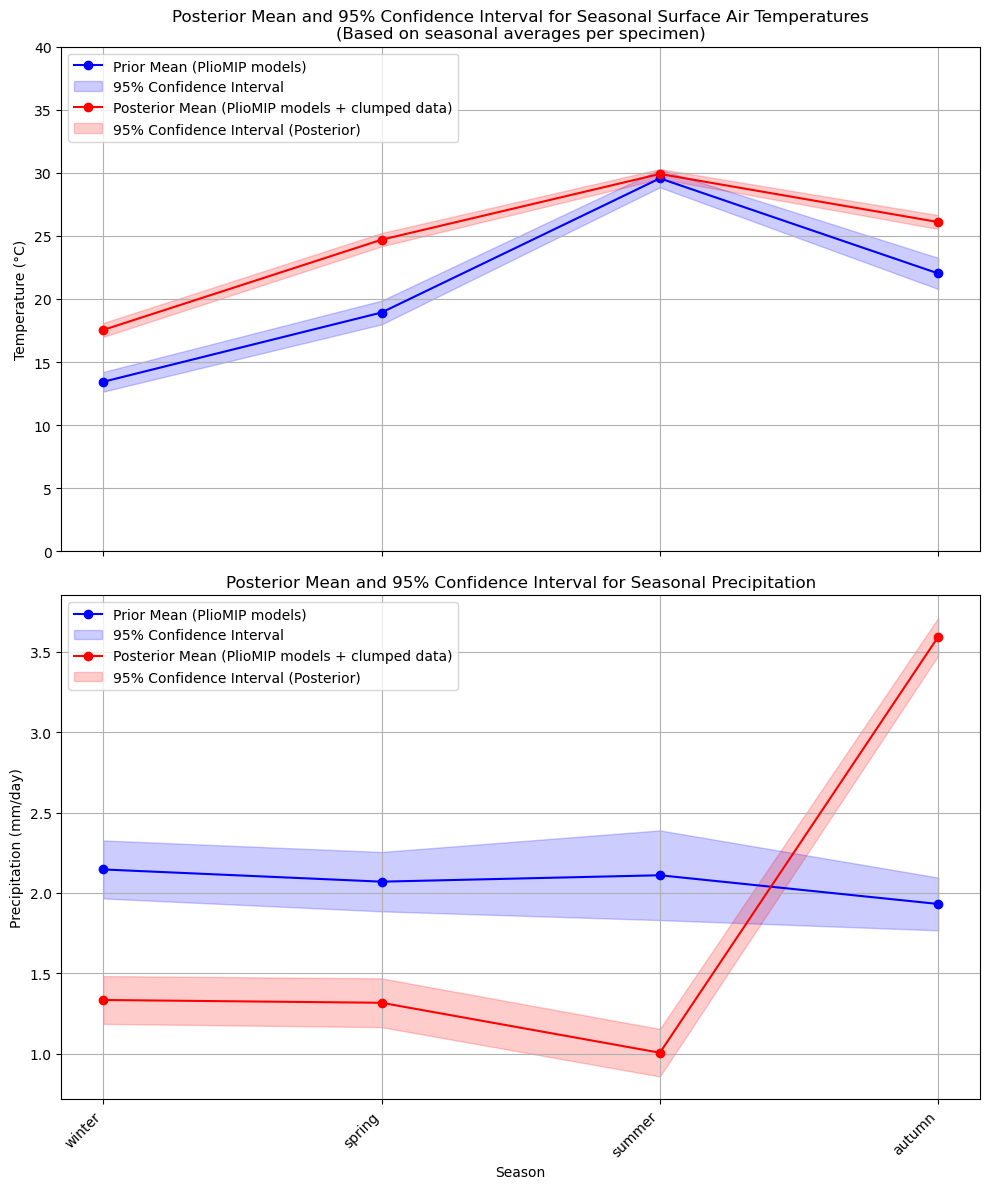

In [56]:
# Convert posterior D47 to temp
mu_post_SAT_D47_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_seasonalSC, sD47 = cov_post_SAT_D47_seasonalSC, return_covar = True)[0]
cov_post_SAT_D47_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_seasonalSC, sD47 = cov_post_SAT_D47_seasonalSC, return_covar = True)[1]

# Convert posterior SAT-D47 back to temperature
std_post_SAT_D47_seasonalSC_T = np.nan_to_num(np.sqrt(np.diag(cov_post_SAT_D47_seasonalSC_T)))

fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# --- SAT prior and posterior ---
# PRIOR
axs[0].plot(seasons_scale, mu_prior_SAT_seasonal_original, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[0].fill_between(
    seasons_scale,
    mu_prior_SAT_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    color='b', alpha=0.2, label='95% Confidence Interval'
)

# POSTERIOR
axs[0].plot(seasons_scale, mu_post_SAT_D47_seasonalSC_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[0].fill_between(
    seasons_scale,
    mu_post_SAT_D47_seasonalSC_T - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_D47 + n_models_seasonal)) * std_post_SAT_D47_seasonalSC_T / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal),
    mu_post_SAT_D47_seasonalSC_T + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_D47 + n_models_seasonal)) * std_post_SAT_D47_seasonalSC_T / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)'
)

axs[0].set_title('Posterior Mean and 95% Confidence Interval for Seasonal Surface Air Temperatures\n(Based on seasonal averages per specimen)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_ylim(0, 40)
axs[0].legend(loc='upper left')
axs[0].grid(True)

# --- Precipitation prior and posterior ---
# PRIOR
axs[1].plot(seasons_scale, mu_prior_precip_seasonal_original, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[1].fill_between(
    seasons_scale,
    mu_prior_precip_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_precip_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    color='b', alpha=0.2, label='95% Confidence Interval'
)

# POSTERIOR
axs[1].plot(seasons_scale, mu_post_precip_seasonalSC, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[1].fill_between(
    seasons_scale,
    mu_post_precip_seasonalSC - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_D47 + n_models_seasonal)) * np.sqrt(np.diag(cov_post_precip_seasonalSC)) / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal),
    mu_post_precip_seasonalSC + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_D47 + n_models_seasonal)) * np.sqrt(np.diag(cov_post_precip_seasonalSC)) / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)'
)

axs[1].set_title('Posterior Mean and 95% Confidence Interval for Seasonal Precipitation')
axs[1].set_xlabel('Season')
axs[1].set_ylabel('Precipitation (mm/day)')
axs[1].legend(loc='upper left')
axs[1].grid(True)

plt.xticks(seasons_scale, seasons, rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Plot SAT, SST, SSS and precipitation posterior

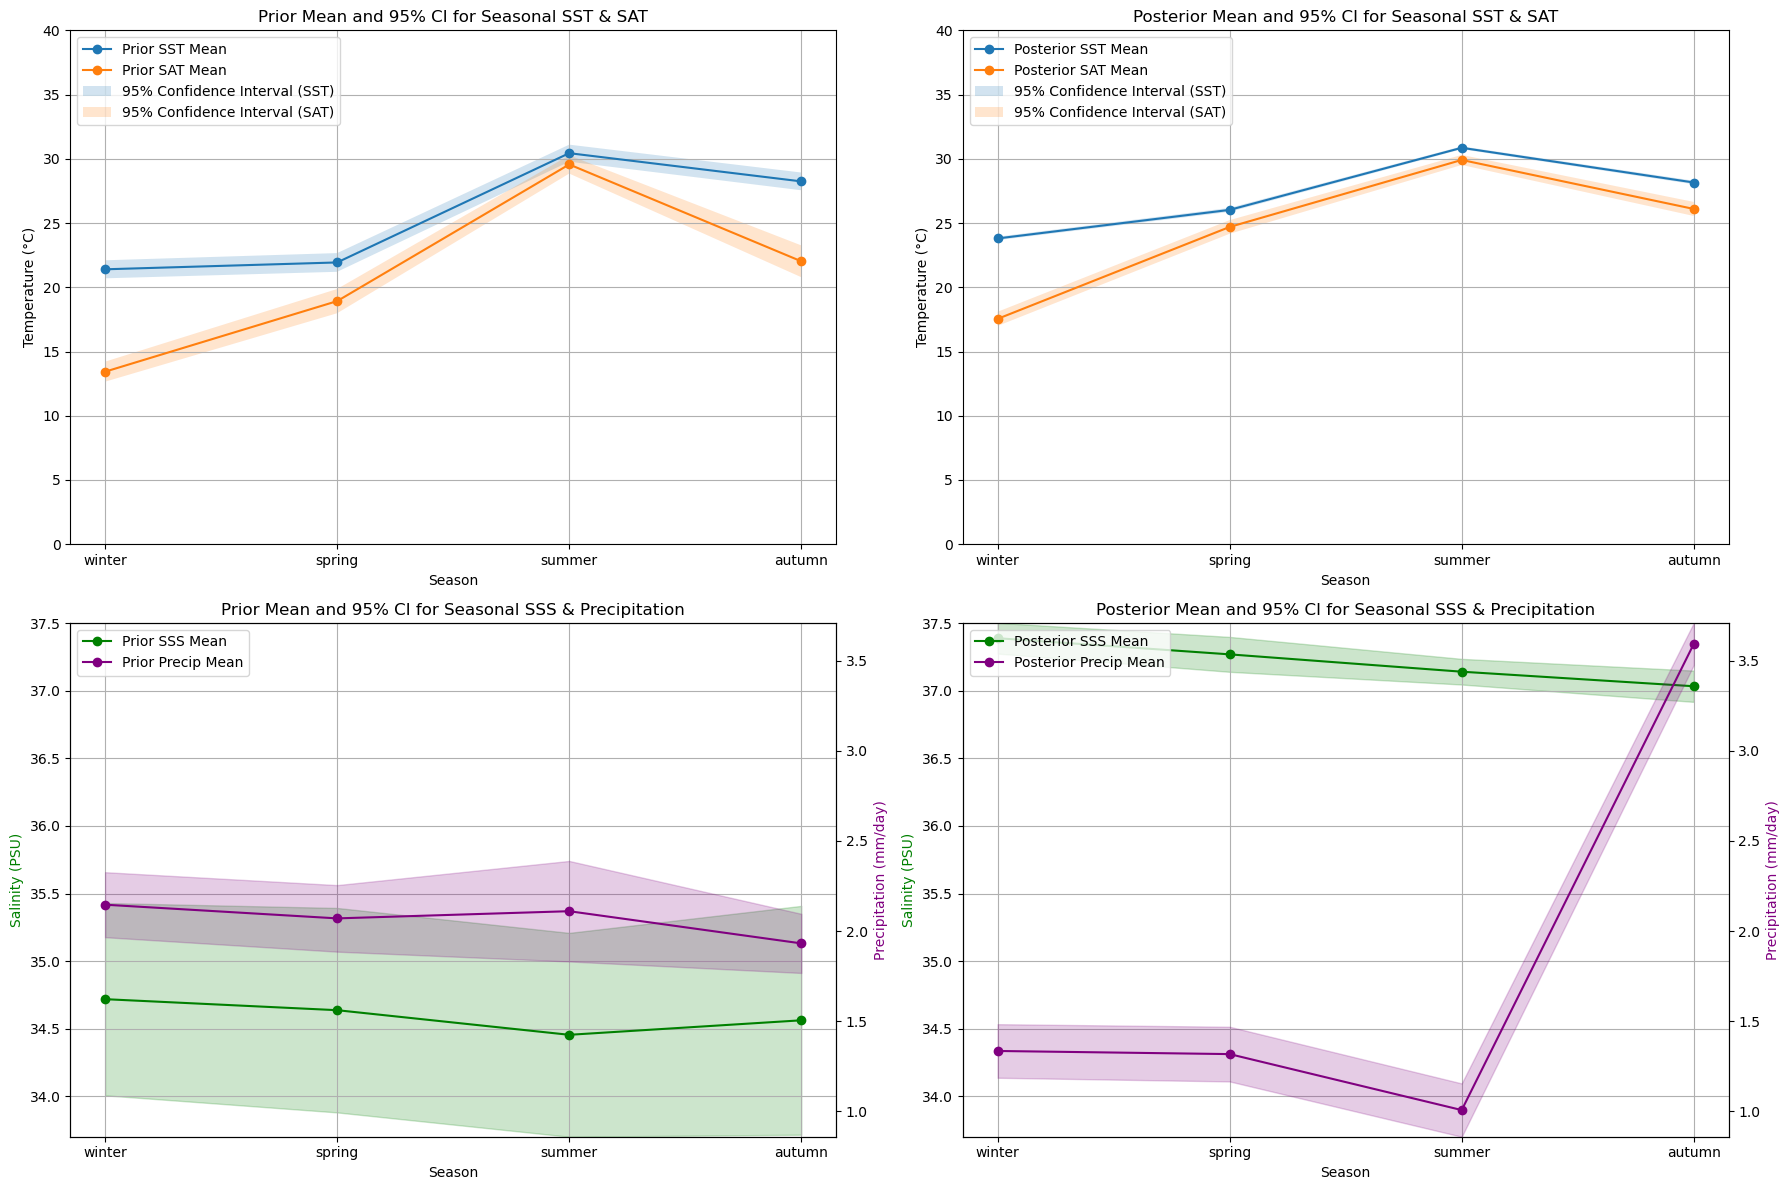

In [57]:
# Create a figure with two rows and two columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --- SST & SAT Prior and Posterior ---
# Prior SST & SAT
axes[0, 0].plot(seasons_scale, mu_prior_SST_seasonal, label='Prior SST Mean', marker='o')
axes[0, 0].plot(seasons_scale, mu_prior_SAT_seasonal, label='Prior SAT Mean', marker='o')
axes[0, 0].fill_between(
    seasons_scale,
    mu_prior_SST_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SST_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, label='95% Confidence Interval (SST)'
)
axes[0, 0].fill_between(
    seasons_scale,
    mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, label='95% Confidence Interval (SAT)'
)
axes[0, 0].set_xticks(seasons_scale)
axes[0, 0].set_xticklabels(seasons)
axes[0, 0].set_title('Prior Mean and 95% CI for Seasonal SST & SAT')
axes[0, 0].set_xlabel('Season')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_ylim(0, 40)
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True)

# Posterior SST & SAT
axes[0, 1].plot(seasons_scale, mu_post_SST_D47_seasonalSC_T, label='Posterior SST Mean', marker='o')
axes[0, 1].plot(seasons_scale, mu_post_SAT_D47_seasonalSC_T, label='Posterior SAT Mean', marker='o')
axes[0, 1].fill_between(
    seasons_scale,
    mu_post_SST_D47_seasonalSC_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC_D47 + n_models_seasonal) * std_post_SST_D47_seasonalSC_T / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal),
    mu_post_SST_D47_seasonalSC_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC_D47 + n_models_seasonal) * std_post_SST_D47_seasonalSC_T / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal),
    alpha=0.2, label='95% Confidence Interval (SST)'
)
axes[0, 1].fill_between(
    seasons_scale,
    mu_post_SAT_D47_seasonalSC_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC_D47 + n_models_seasonal) * std_post_SAT_D47_seasonalSC_T / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal),
    mu_post_SAT_D47_seasonalSC_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC_D47 + n_models_seasonal) * std_post_SAT_D47_seasonalSC_T / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal),
    alpha=0.2, label='95% Confidence Interval (SAT)'
)
axes[0, 1].set_xticks(seasons_scale)
axes[0, 1].set_xticklabels(seasons)
axes[0, 1].set_title('Posterior Mean and 95% CI for Seasonal SST & SAT')
axes[0, 1].set_xlabel('Season')
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].set_ylim(0, 40)
axes[0, 1].legend(loc='upper left')
axes[0, 1].grid(True)

# --- SSS & Precipitation Prior and Posterior (Shared Plot, Twin Axes) ---

# Get y-limits for SSS and precipitation (prior and posterior) to keep them consistent
sss_min = min(np.min(mu_prior_SSS_d18Ow_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal)),
              np.min(mu_post_SSS_d18Ow_seasonalSC_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC_D47 + n_models_seasonal) * std_post_SSS_d18Ow_seasonalSC_T / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal)))
sss_max = max(np.max(mu_prior_SSS_d18Ow_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal)),
              np.max(mu_post_SSS_d18Ow_seasonalSC_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC_D47 + n_models_seasonal) * std_post_SSS_d18Ow_seasonalSC_T / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal)))
precip_min = min(np.min(mu_prior_precip_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal)),
                 np.min(mu_post_precip_seasonalSC - stats.t.ppf(1 - 0.025, n_update_seasonalSC_D47 + n_models_seasonal) * np.sqrt(np.diag(cov_post_precip_seasonalSC)) / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal)))
precip_max = max(np.max(mu_prior_precip_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal)),
                 np.max(mu_post_precip_seasonalSC + stats.t.ppf(1 - 0.025, n_update_seasonalSC_D47 + n_models_seasonal) * np.sqrt(np.diag(cov_post_precip_seasonalSC)) / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal)))

# --- Prior SSS & Precipitation ---
ax1 = axes[1, 0]
ax2 = ax1.twinx()
lns1 = ax1.plot(seasons_scale, mu_prior_SSS_d18Ow_seasonal_T, label='Prior SSS Mean', marker='o', color="green")
ax1.fill_between(
    seasons_scale,
    mu_prior_SSS_d18Ow_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_SSS_d18Ow_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal),
    color="green", alpha=0.2, label='95% CI (SSS)'
)
lns2 = ax2.plot(seasons_scale, mu_prior_precip_seasonal_original, label='Prior Precip Mean', marker='o', color="purple")
ax2.fill_between(
    seasons_scale,
    mu_prior_precip_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_precip_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    color="purple", alpha=0.2, label='95% CI (Precip)'
)
ax1.set_xticks(seasons_scale)
ax1.set_xticklabels(seasons)
ax1.set_title('Prior Mean and 95% CI for Seasonal SSS & Precipitation')
ax1.set_xlabel('Season')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + lns2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# --- Posterior SSS & Precipitation ---
ax1 = axes[1, 1]
ax2 = ax1.twinx()
lns1 = ax1.plot(seasons_scale, mu_post_SSS_d18Ow_seasonalSC_T, label='Posterior SSS Mean', marker='o', color="green")
ax1.fill_between(
    seasons_scale,
    mu_post_SSS_d18Ow_seasonalSC_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC_D47 + n_models_seasonal) * std_post_SSS_d18Ow_seasonalSC_T / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal),
    mu_post_SSS_d18Ow_seasonalSC_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC_D47 + n_models_seasonal) * std_post_SSS_d18Ow_seasonalSC_T / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal),
    color="green", alpha=0.2, label='95% CI (SSS)'
)
lns2 = ax2.plot(seasons_scale, mu_post_precip_seasonalSC, label='Posterior Precip Mean', marker='o', color="purple")
ax2.fill_between(
    seasons_scale,
    mu_post_precip_seasonalSC - stats.t.ppf(1 - 0.025, n_update_seasonalSC_D47 + n_models_seasonal) * np.sqrt(np.diag(cov_post_precip_seasonalSC)) / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal),
    mu_post_precip_seasonalSC + stats.t.ppf(1 - 0.025, n_update_seasonalSC_D47 + n_models_seasonal) * np.sqrt(np.diag(cov_post_precip_seasonalSC)) / np.sqrt(n_update_seasonalSC_D47 + n_models_seasonal),
    color="purple", alpha=0.2, label='95% CI (Precip)'
)
ax1.set_xticks(seasons_scale)
ax1.set_xticklabels(seasons)
ax1.set_title('Posterior Mean and 95% CI for Seasonal SSS & Precipitation')
ax1.set_xlabel('Season')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + lns2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

plt.tight_layout()
plt.show()

## Seasonal posterior in temperature and salinity domains with data based on ShellChron (ignore ShellChron uncertainty)
* Aggregate data and model outcomes in 4 seasonal bins
* Ignore sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

### Convert seasonal prior, likelihood and posterior to temperature and salinity and plot

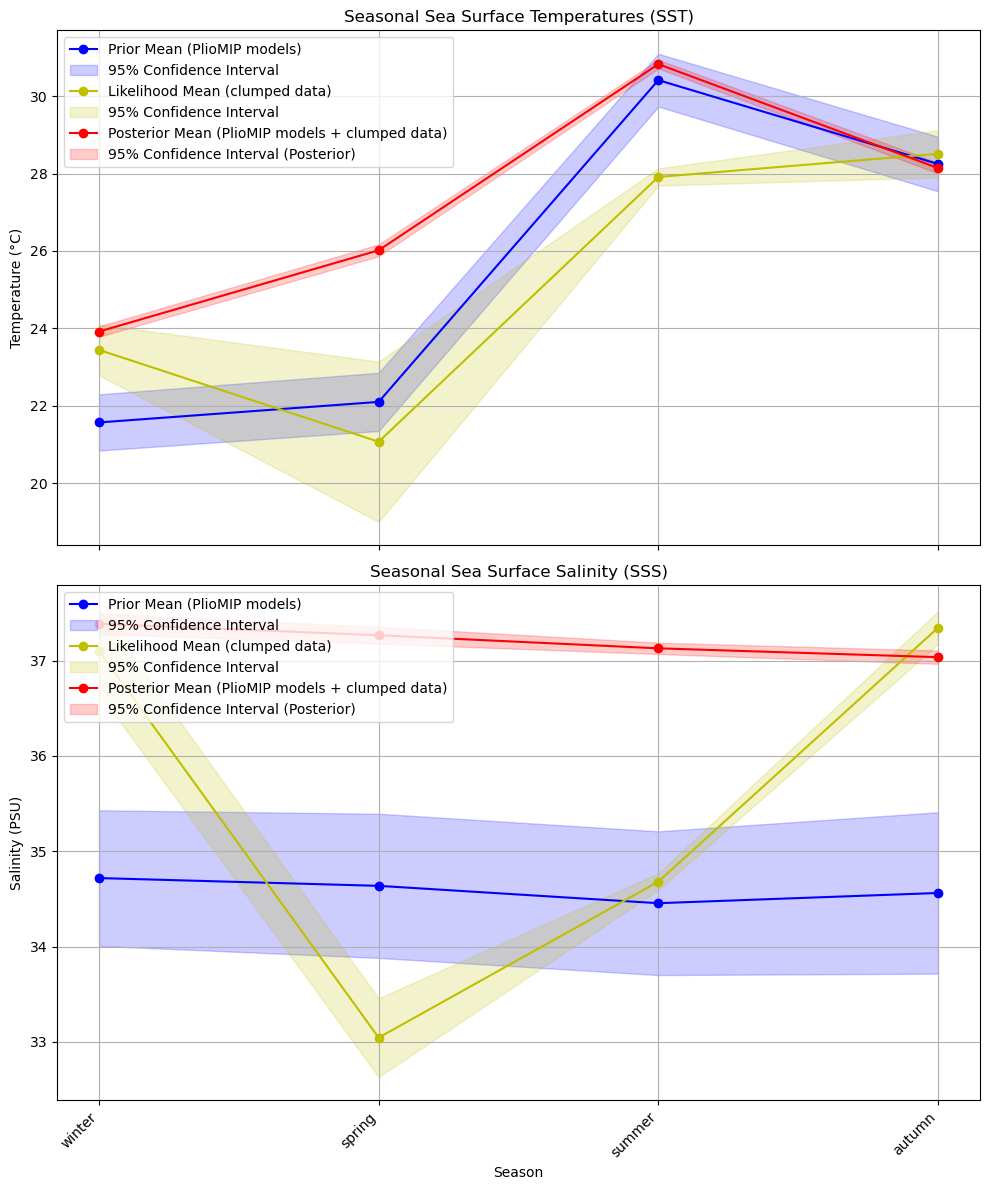

In [58]:
# (Priors are identical to the seasonal priors above)
# Convert likelihood D47 to temp
mu_likelihood_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC_noerr[var_start_D47_seasonal:var_end_D47_seasonal], sD47 = std_likelihood_seasonalSC_noerr[var_start_D47_seasonal:var_end_D47_seasonal], return_covar = True)[0]
cov_likelihood_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC_noerr[var_start_D47_seasonal:var_end_D47_seasonal], sD47 = std_likelihood_seasonalSC_noerr[var_start_D47_seasonal:var_end_D47_seasonal], return_covar = True)[1]

# Convert likelihood d18Oc and temperature to d18Ow (curently not implemented in data tracking function)
mu_likelihood_d18Ow_seasonalSC_noerr_T = mu_likelihood_seasonalSC_noerr[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] - (20.6 - mu_likelihood_seasonalSC_noerr_T) / 4.34 + 0.27
std_likelihood_d18Ow_seasonalSC_noerr_T = std_likelihood_seasonalSC_noerr[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] + (1 / 4.34) ** 2 * np.sqrt(np.diag(cov_likelihood_seasonalSC_noerr_T))

# Convert likelihood d18Ow to SSS (currently not implemented in data tracking function)
mu_likelihood_SSS_d18Ow_seasonalSC_noerr_T = (mu_likelihood_d18Ow_seasonalSC_noerr_T + 9.300) / 0.274
std_likelihood_SSS_d18Ow_seasonalSC_noerr_T = std_likelihood_d18Ow_seasonalSC_noerr_T / (0.274 ** 2)

# Convert posterior D47 to temp
mu_post_SST_D47_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_seasonalSC_noerr, sD47 = cov_post_SST_D47_seasonalSC_noerr, return_covar = True)[0]
cov_post_SST_D47_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_seasonalSC_noerr, sD47 = cov_post_SST_D47_seasonalSC_noerr, return_covar = True)[1]

# Convert posterior d18Oc and temperature to d18Ow
mu_post_d18Ow_seasonalSC_noerr_T = mu_post_d18Oc_seasonalSC_noerr - (20.6 - mu_post_SST_D47_seasonalSC_noerr_T) / 4.34 + 0.27
cov_post_d18Ow_seasonalSC_noerr_T = cov_post_d18Oc_seasonalSC_noerr + (1 / 4.34) ** 2 * cov_post_SST_D47_seasonalSC_noerr_T

# Convert posterior d18Ow to SSS
mu_post_SSS_d18Ow_seasonalSC_noerr_T = (mu_post_d18Ow_seasonalSC_noerr_T + 9.300) / 0.274
cov_post_SSS_d18Ow_seasonalSC_noerr_T = cov_post_d18Ow_seasonalSC_noerr_T / (0.274 ** 2)

# Plot in temperature domain
std_prior_SST_D47_seasonal_T = np.sqrt(np.diag(cov_prior_SST_D47_seasonal_T))
std_prior_SSS_d18Ow_seasonal_T = np.sqrt(np.diag(cov_prior_SSS_d18Ow_seasonal_T))
std_likelihood_seasonalSC_noerr_T = np.sqrt(np.diag(cov_likelihood_seasonalSC_noerr_T))
std_post_SST_D47_seasonalSC_noerr_T = np.sqrt(np.diag(cov_post_SST_D47_seasonalSC_noerr_T))
std_post_SSS_d18Ow_seasonalSC_noerr_T = np.sqrt(np.diag(cov_post_SSS_d18Ow_seasonalSC_noerr_T))
# Initiate plot
fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# FIRST PANEL: SST Results
# PRIOR
axs[0].plot(seasons_scale, mu_prior_SST_D47_seasonal_T, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[0].fill_between(seasons_scale,
    mu_prior_SST_D47_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_SST_D47_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_T / np.sqrt(n_models_seasonal),
    color='b', alpha=0.2, label='95% Confidence Interval')

# LIKELIHOOD
axs[0].plot(seasons_scale, mu_likelihood_seasonalSC_noerr_T, label='Likelihood Mean (clumped data)', color='y', marker='o')
axs[0].fill_between(seasons_scale,
    mu_likelihood_seasonalSC_noerr_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_D47) * std_likelihood_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_D47),
    mu_likelihood_seasonalSC_noerr_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_D47) * std_likelihood_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_D47),
    color='y', alpha=0.2, label='95% Confidence Interval')

# POSTERIOR
axs[0].plot(seasons_scale, mu_post_SST_D47_seasonalSC_noerr_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[0].fill_between(seasons_scale,
    mu_post_SST_D47_seasonalSC_noerr_T - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr_D47 + n_models_seasonal)) * std_post_SST_D47_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal),
    mu_post_SST_D47_seasonalSC_noerr_T + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr_D47 + n_models_seasonal)) * std_post_SST_D47_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)')

# Layout for SST panel
axs[0].set_title('Seasonal Sea Surface Temperatures (SST)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].legend(loc='upper left')
axs[0].grid(True)

# SECOND PANEL: SSS Results
# PRIOR
axs[1].plot(seasons_scale, mu_prior_SSS_d18Ow_seasonal_T, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[1].fill_between(seasons_scale,
    mu_prior_SSS_d18Ow_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_SSS_d18Ow_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal),
    color='b', alpha=0.2, label='95% Confidence Interval')

# LIKELIHOOD
axs[1].plot(seasons_scale, mu_likelihood_SSS_d18Ow_seasonalSC_noerr_T, label='Likelihood Mean (clumped data)', color='y', marker='o')
axs[1].fill_between(seasons_scale,
    mu_likelihood_SSS_d18Ow_seasonalSC_noerr_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_d18Oc) * std_likelihood_SSS_d18Ow_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_d18Oc),
    mu_likelihood_SSS_d18Ow_seasonalSC_noerr_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_d18Oc) * std_likelihood_SSS_d18Ow_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_d18Oc),
    color='y', alpha=0.2, label='95% Confidence Interval')

# POSTERIOR
axs[1].plot(seasons_scale, mu_post_SSS_d18Ow_seasonalSC_noerr_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[1].fill_between(seasons_scale,
    mu_post_SSS_d18Ow_seasonalSC_noerr_T - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr_d18Oc + n_models_seasonal)) * std_post_SSS_d18Ow_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_d18Oc + n_models_seasonal),
    mu_post_SSS_d18Ow_seasonalSC_noerr_T + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr_d18Oc + n_models_seasonal)) * std_post_SSS_d18Ow_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_d18Oc + n_models_seasonal),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)')

# Layout for SSS panel
axs[1].set_title('Seasonal Sea Surface Salinity (SSS)')
axs[1].set_xlabel('Season')
axs[1].set_ylabel('Salinity (PSU)')
axs[1].legend(loc='upper left')
axs[1].grid(True)

# Shared x-axis labels
plt.xticks(seasons_scale, seasons, rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Plot SAT and precipitation prior and posterior

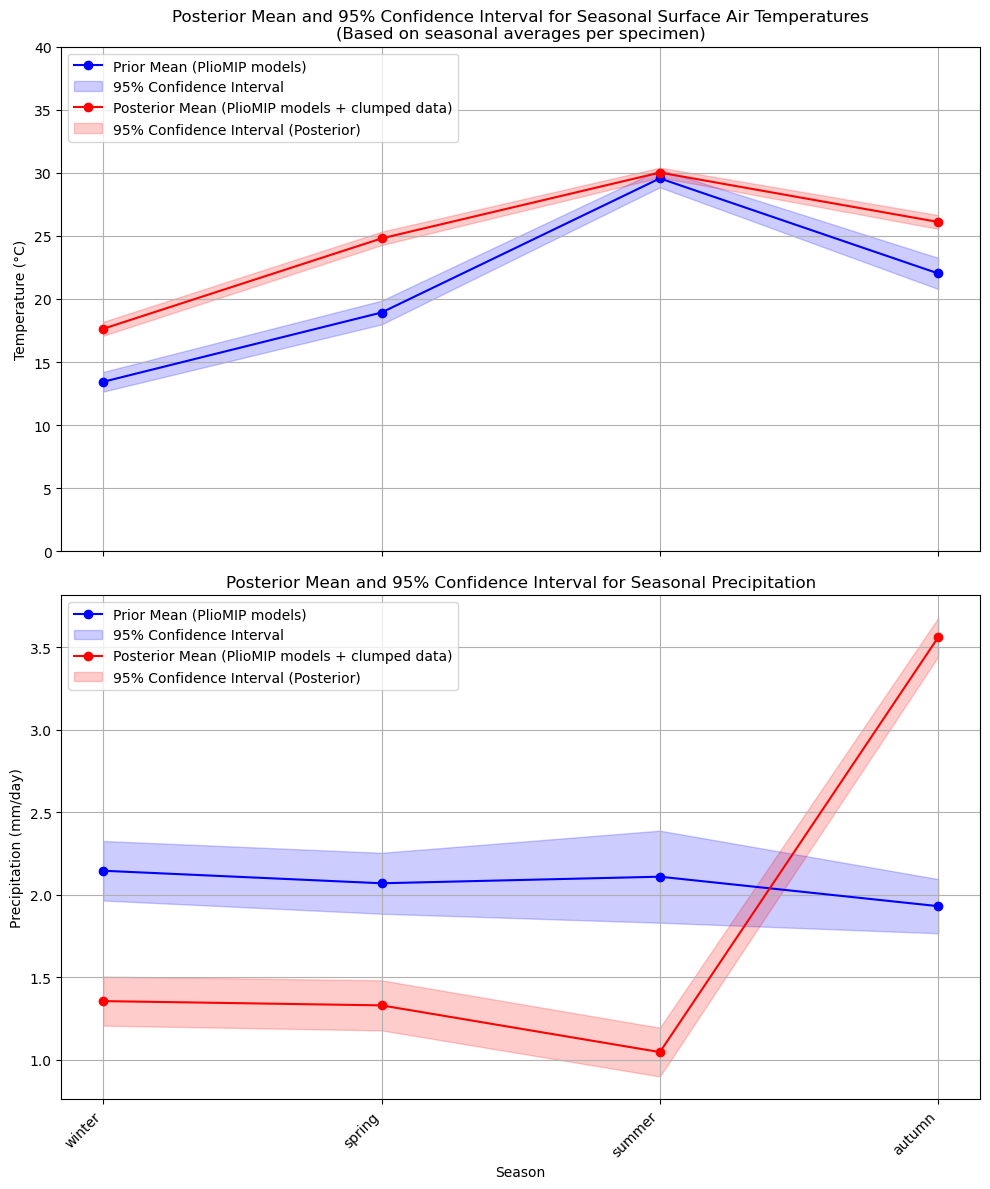

In [59]:
# Convert posterior D47 to temp
mu_post_SAT_D47_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_seasonalSC_noerr, sD47 = cov_post_SAT_D47_seasonalSC_noerr, return_covar = True)[0]
cov_post_SAT_D47_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_seasonalSC_noerr, sD47 = cov_post_SAT_D47_seasonalSC_noerr, return_covar = True)[1]

# Convert posterior SAT-D47 back to temperature
std_post_SAT_D47_seasonalSC_noerr_T = np.nan_to_num(np.sqrt(np.diag(cov_post_SAT_D47_seasonalSC_noerr_T)))

fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# --- SAT prior and posterior ---
# PRIOR
axs[0].plot(seasons_scale, mu_prior_SAT_seasonal_original, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[0].fill_between(
    seasons_scale,
    mu_prior_SAT_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    color='b', alpha=0.2, label='95% Confidence Interval'
)

# POSTERIOR
axs[0].plot(seasons_scale, mu_post_SAT_D47_seasonalSC_noerr_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[0].fill_between(
    seasons_scale,
    mu_post_SAT_D47_seasonalSC_noerr_T - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr_D47 + n_models_seasonal)) * std_post_SAT_D47_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal),
    mu_post_SAT_D47_seasonalSC_noerr_T + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr_D47 + n_models_seasonal)) * std_post_SAT_D47_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)'
)

axs[0].set_title('Posterior Mean and 95% Confidence Interval for Seasonal Surface Air Temperatures\n(Based on seasonal averages per specimen)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_ylim(0, 40)
axs[0].legend(loc='upper left')
axs[0].grid(True)

# --- Precipitation prior and posterior ---
# PRIOR
axs[1].plot(seasons_scale, mu_prior_precip_seasonal_original, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[1].fill_between(
    seasons_scale,
    mu_prior_precip_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_precip_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    color='b', alpha=0.2, label='95% Confidence Interval'
)

# POSTERIOR
axs[1].plot(seasons_scale, mu_post_precip_seasonalSC_noerr, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[1].fill_between(
    seasons_scale,
    mu_post_precip_seasonalSC_noerr - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr_D47 + n_models_seasonal)) * np.sqrt(np.diag(cov_post_precip_seasonalSC_noerr)) / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal),
    mu_post_precip_seasonalSC_noerr + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr_D47 + n_models_seasonal)) * np.sqrt(np.diag(cov_post_precip_seasonalSC_noerr)) / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)'
)

axs[1].set_title('Posterior Mean and 95% Confidence Interval for Seasonal Precipitation')
axs[1].set_xlabel('Season')
axs[1].set_ylabel('Precipitation (mm/day)')
axs[1].legend(loc='upper left')
axs[1].grid(True)

plt.xticks(seasons_scale, seasons, rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Plot SAT, SST, SSS and precipitation and posterior

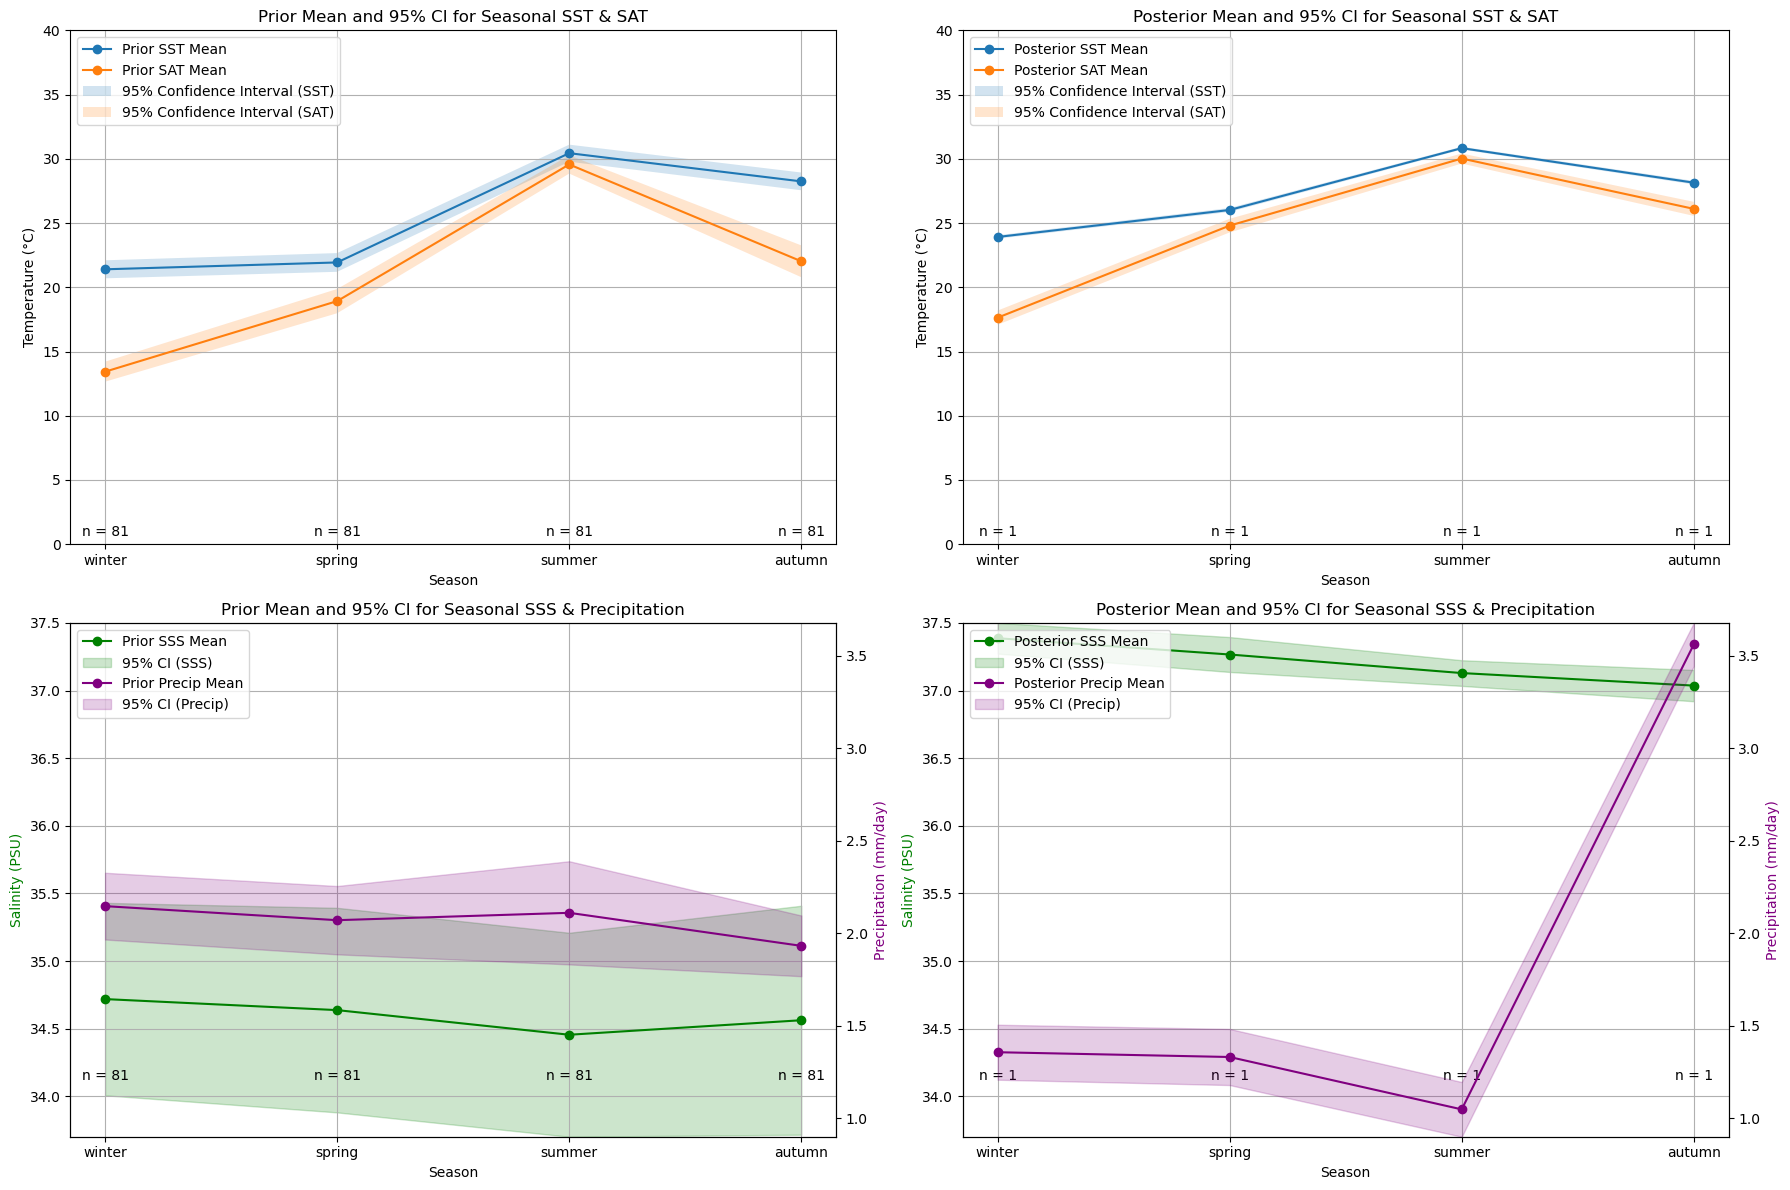

In [60]:
# Create a figure with two rows and two columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --- SST & SAT Prior and Posterior ---
# Prior SST & SAT
axes[0, 0].plot(seasons_scale, mu_prior_SST_seasonal, label='Prior SST Mean', marker='o')
axes[0, 0].plot(seasons_scale, mu_prior_SAT_seasonal, label='Prior SAT Mean', marker='o')
axes[0, 0].fill_between(
    seasons_scale,
    mu_prior_SST_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SST_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, label='95% Confidence Interval (SST)'
)
axes[0, 0].fill_between(
    seasons_scale,
    mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    alpha=0.2, label='95% Confidence Interval (SAT)'
)
axes[0, 0].set_xticks(seasons_scale)
axes[0, 0].set_xticklabels(seasons)
axes[0, 0].set_title('Prior Mean and 95% CI for Seasonal SST & SAT')
axes[0, 0].set_xlabel('Season')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_ylim(0, 40)
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True)

# Posterior SST & SAT
axes[0, 1].plot(seasons_scale, mu_post_SST_D47_seasonalSC_noerr_T, label='Posterior SST Mean', marker='o')
axes[0, 1].plot(seasons_scale, mu_post_SAT_D47_seasonalSC_noerr_T, label='Posterior SAT Mean', marker='o')
axes[0, 1].fill_between(
    seasons_scale,
    mu_post_SST_D47_seasonalSC_noerr_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_D47 + n_models_seasonal) * std_post_SST_D47_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal),
    mu_post_SST_D47_seasonalSC_noerr_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_D47 + n_models_seasonal) * std_post_SST_D47_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal),
    alpha=0.2, label='95% Confidence Interval (SST)'
)
axes[0, 1].fill_between(
    seasons_scale,
    mu_post_SAT_D47_seasonalSC_noerr_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_D47 + n_models_seasonal) * std_post_SAT_D47_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal),
    mu_post_SAT_D47_seasonalSC_noerr_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_D47 + n_models_seasonal) * std_post_SAT_D47_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal),
    alpha=0.2, label='95% Confidence Interval (SAT)'
)
axes[0, 1].set_xticks(seasons_scale)
axes[0, 1].set_xticklabels(seasons)
axes[0, 1].set_title('Posterior Mean and 95% CI for Seasonal SST & SAT')
axes[0, 1].set_xlabel('Season')
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].set_ylim(0, 40)
axes[0, 1].legend(loc='upper left')
axes[0, 1].grid(True)

# --- SSS & Precipitation Prior and Posterior (Shared Plot, Twin Axes) ---

# Get y-limits for SSS and precipitation (prior and posterior) to keep them consistent
sss_min = min(np.min(mu_prior_SSS_d18Ow_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal)),
              np.min(mu_post_SSS_d18Ow_seasonalSC_noerr_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_D47 + n_models_seasonal) * std_post_SSS_d18Ow_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal)))
sss_max = max(np.max(mu_prior_SSS_d18Ow_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal)),
              np.max(mu_post_SSS_d18Ow_seasonalSC_noerr_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_D47 + n_models_seasonal) * std_post_SSS_d18Ow_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal)))
precip_min = min(np.min(mu_prior_precip_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal)),
                 np.min(mu_post_precip_seasonalSC_noerr - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_D47 + n_models_seasonal) * np.sqrt(np.diag(cov_post_precip_seasonalSC_noerr)) / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal)))
precip_max = max(np.max(mu_prior_precip_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal)),
                 np.max(mu_post_precip_seasonalSC_noerr + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_D47 + n_models_seasonal) * np.sqrt(np.diag(cov_post_precip_seasonalSC_noerr)) / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal)))

# --- Prior SSS & Precipitation ---
ax1 = axes[1, 0]
ax2 = ax1.twinx()
lns1 = ax1.plot(seasons_scale, mu_prior_SSS_d18Ow_seasonal_T, label='Prior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    seasons_scale,
    mu_prior_SSS_d18Ow_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_SSS_d18Ow_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_models_seasonal),
    color="green", alpha=0.2, label='95% CI (SSS)'
)
lns2 = ax2.plot(seasons_scale, mu_prior_precip_seasonal_original, label='Prior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    seasons_scale,
    mu_prior_precip_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_precip_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_precip_seasonal / np.sqrt(n_models_seasonal),
    color="purple", alpha=0.2, label='95% CI (Precip)'
)
ax1.set_xticks(seasons_scale)
ax1.set_xticklabels(seasons)
ax1.set_title('Prior Mean and 95% CI for Seasonal SSS & Precipitation')
ax1.set_xlabel('Season')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# --- Posterior SSS & Precipitation ---
ax1 = axes[1, 1]
ax2 = ax1.twinx()
lns1 = ax1.plot(seasons_scale, mu_post_SSS_d18Ow_seasonalSC_noerr_T, label='Posterior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    seasons_scale,
    mu_post_SSS_d18Ow_seasonalSC_noerr_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_D47 + n_models_seasonal) * std_post_SSS_d18Ow_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal),
    mu_post_SSS_d18Ow_seasonalSC_noerr_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_D47 + n_models_seasonal) * std_post_SSS_d18Ow_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal),
    color="green", alpha=0.2, label='95% CI (SSS)'
)
lns2 = ax2.plot(seasons_scale, mu_post_precip_seasonalSC_noerr, label='Posterior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    seasons_scale,
    mu_post_precip_seasonalSC_noerr - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_D47 + n_models_seasonal) * np.sqrt(np.diag(cov_post_precip_seasonalSC_noerr)) / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal),
    mu_post_precip_seasonalSC_noerr + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr_D47 + n_models_seasonal) * np.sqrt(np.diag(cov_post_precip_seasonalSC_noerr)) / np.sqrt(n_update_seasonalSC_noerr_D47 + n_models_seasonal),
    color="purple", alpha=0.2, label='95% CI (Precip)'
)
ax1.set_xticks(seasons_scale)
ax1.set_xticklabels(seasons)
ax1.set_title('Posterior Mean and 95% CI for Seasonal SSS & Precipitation')
ax1.set_xlabel('Season')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# Add "n = x" labels below each x-tick for each subplot to show the number of model values or updates
# Prior SST & SAT
for i, season in enumerate(seasons):
    axes[0, 0].text(
        seasons_scale[i], axes[0, 0].get_ylim()[0] + 1.5,  # adjust location as needed
        f"n = {n_models_seasonal[i] if hasattr(n_models_seasonal, '__getitem__') else n_models_seasonal}",
        ha='center', va='top', fontsize=10
    )

# Posterior SST & SAT
for i, season in enumerate(seasons):
    axes[0, 1].text(
        seasons_scale[i], axes[0, 1].get_ylim()[0] + 1.5,
        f"n = {int(n_update_seasonal_aggregated_D47[i]) if hasattr(n_update_seasonal_aggregated_D47, '__getitem__') else n_update_seasonal_aggregated_D47}",
        ha='center', va='top', fontsize=10
    )

# Prior SSS & Precipitation
for i, season in enumerate(seasons):
    axes[1, 0].text(
        seasons_scale[i], axes[1, 0].get_ylim()[0] + 0.5,
        f"n = {n_models_seasonal[i] if hasattr(n_models_seasonal, '__getitem__') else n_models_seasonal}",
        ha='center', va='top', fontsize=10
    )

# Posterior SSS & Precipitation
for i, season in enumerate(seasons):
    axes[1, 1].text(
        seasons_scale[i], axes[1, 1].get_ylim()[0] + 0.5,
        f"n = {int(n_update_seasonal_aggregated_D47[i]) if hasattr(n_update_seasonal_aggregated_D47, '__getitem__') else n_update_seasonal_aggregated_D47}",
        ha='center', va='top', fontsize=10
    )

plt.tight_layout()
plt.show()

# POSTERIOR - MONTHLY

## Monthly posterior in temperature and salinity domains with aggregated data
* Data and model outcomes assembled per month
* Ignore sclero-dating uncertainty
* D47 data aggregated in monthly bins prior to assembly

### Convert monthly prior, likelihood and posterior to temperature and salinity and plot

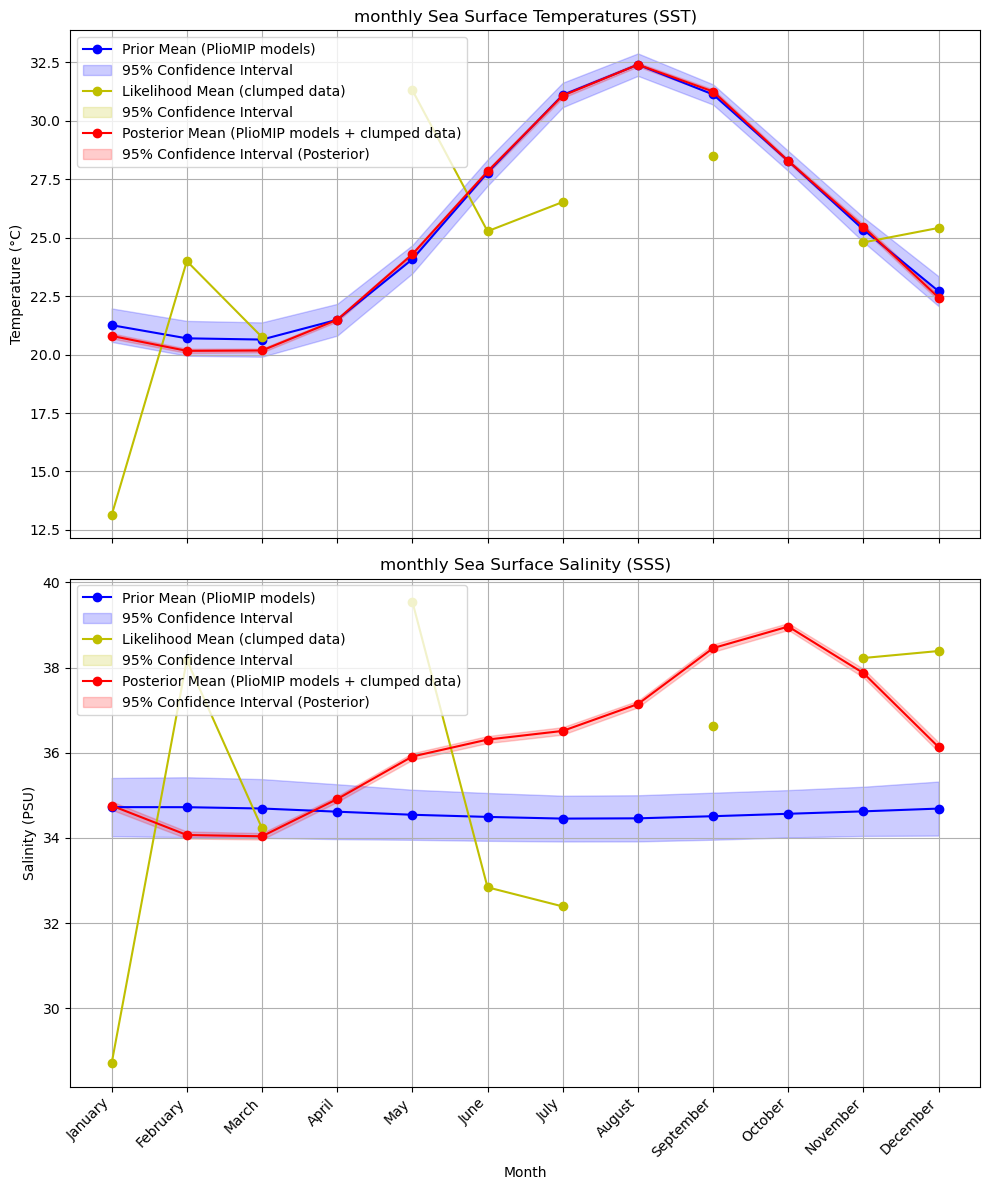

In [61]:
# Convert prior D47 to temp
mu_prior_SST_D47_monthly_T = D47c.OGLS23.T47(D47 = mu_prior_SST_D47_monthly_original, sD47 = cov_prior_SST_D47_monthly_original, return_covar = True)[0]
cov_prior_SST_D47_monthly_T = D47c.OGLS23.T47(D47 = mu_prior_SST_D47_monthly_original, sD47 = cov_prior_SST_D47_monthly_original, return_covar = True)[1]

# Convert prior d18Oc and temperature to d18Ow
mu_prior_d18Ow_monthly_T = mu_prior_d18Oc_monthly_original - (20.6 - mu_prior_SST_D47_monthly_T) / 4.34 + 0.27
cov_prior_d18Ow_monthly_T = cov_prior_d18Oc_monthly_original + (1 / 4.34) ** 2 * cov_prior_SST_D47_monthly_T

# Convert prior d18Ow to SSS
mu_prior_SSS_d18Ow_monthly_T = (mu_prior_d18Ow_monthly_T + 9.300) / 0.274
cov_prior_SSS_d18Ow_monthly_T = cov_prior_d18Ow_monthly_T / (0.274 ** 2)

# Convert likelihood D47 to temp
mu_likelihood_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly], sD47 = std_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly], return_covar = True)[0]
cov_likelihood_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly], sD47 = std_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly], return_covar = True)[1]

# Convert likelihood d18Oc and temperature to d18Ow (curently not implemented in data tracking function)
mu_likelihood_d18Ow_monthly_aggregated_T = mu_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly] - (20.6 - mu_likelihood_monthly_aggregated_T) / 4.34 + 0.27
std_likelihood_d18Ow_monthly_aggregated_T = std_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly] + (1 / 4.34) ** 2 * np.sqrt(np.diag(cov_likelihood_monthly_aggregated_T))

# Convert likelihood d18Ow to SSS (currently not implemented in data tracking function)
mu_likelihood_SSS_d18Ow_monthly_aggregated_T = (mu_likelihood_d18Ow_monthly_aggregated_T + 9.300) / 0.274
std_likelihood_SSS_d18Ow_monthly_aggregated_T = std_likelihood_d18Ow_monthly_aggregated_T / (0.274 ** 2)

# Convert posterior D47 to temp
mu_post_SST_D47_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_monthly_aggregated, sD47 = cov_post_SST_D47_monthly_aggregated, return_covar = True)[0]
cov_post_SST_D47_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_monthly_aggregated, sD47 = cov_post_SST_D47_monthly_aggregated, return_covar = True)[1]

# Convert posterior d18Oc and temperature to d18Ow
mu_post_d18Ow_monthly_aggregated_T = mu_post_d18Oc_monthly_aggregated - (20.6 - mu_post_SST_D47_monthly_aggregated_T) / 4.34 + 0.27
cov_post_d18Ow_monthly_aggregated_T = cov_post_d18Oc_monthly_aggregated + (1 / 4.34) ** 2 * cov_post_SST_D47_monthly_aggregated_T

# Convert posterior d18Ow to SSS
mu_post_SSS_d18Ow_monthly_aggregated_T = (mu_post_d18Ow_monthly_aggregated_T + 9.300) / 0.274
cov_post_SSS_d18Ow_monthly_aggregated_T = cov_post_d18Ow_monthly_aggregated_T / (0.274 ** 2)

# Plot in temperature domain
std_prior_SST_D47_monthly_T = np.sqrt(np.diag(cov_prior_SST_D47_monthly_T))
std_prior_SSS_d18Ow_monthly_T = np.sqrt(np.diag(cov_prior_SSS_d18Ow_monthly_T))
std_likelihood_monthly_aggregated_T = np.sqrt(np.diag(cov_likelihood_monthly_aggregated_T))
std_post_SST_D47_monthly_aggregated_T = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_T))
std_post_SSS_d18Ow_monthly_aggregated_T = np.sqrt(np.diag(cov_post_SSS_d18Ow_monthly_aggregated_T))

# Initiate plot
fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# FIRST PANEL: SST Results
# PRIOR
axs[0].plot(months_scale, mu_prior_SST_D47_monthly_T, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[0].fill_between(months_scale,
    mu_prior_SST_D47_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_T / np.sqrt(n_models_monthly),
    mu_prior_SST_D47_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_T / np.sqrt(n_models_monthly),
    color='b', alpha=0.2, label='95% Confidence Interval')

# LIKELIHOOD
axs[0].plot(months_scale, mu_likelihood_monthly_aggregated_T, label='Likelihood Mean (clumped data)', color='y', marker='o')
axs[0].fill_between(months_scale,
    mu_likelihood_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47) * std_likelihood_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47),
    mu_likelihood_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47) * std_likelihood_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47),
    color='y', alpha=0.2, label='95% Confidence Interval')

# POSTERIOR
axs[0].plot(months_scale, mu_post_SST_D47_monthly_aggregated_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[0].fill_between(months_scale,
    mu_post_SST_D47_monthly_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_D47 + n_models_monthly)) * std_post_SST_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly),
    mu_post_SST_D47_monthly_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_D47 + n_models_monthly)) * std_post_SST_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)')

# Layout for SST panel
axs[0].set_title('monthly Sea Surface Temperatures (SST)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].legend(loc='upper left')
axs[0].grid(True)

# SECOND PANEL: SSS Results
# PRIOR
axs[1].plot(months_scale, mu_prior_SSS_d18Ow_monthly_T, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[1].fill_between(months_scale,
    mu_prior_SSS_d18Ow_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly),
    mu_prior_SSS_d18Ow_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly),
    color='b', alpha=0.2, label='95% Confidence Interval')

# LIKELIHOOD
axs[1].plot(months_scale, mu_likelihood_SSS_d18Ow_monthly_aggregated_T, label='Likelihood Mean (clumped data)', color='y', marker='o')
axs[1].fill_between(months_scale,
    mu_likelihood_SSS_d18Ow_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_d18Oc) * std_likelihood_SSS_d18Ow_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_d18Oc),
    mu_likelihood_SSS_d18Ow_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_d18Oc) * std_likelihood_SSS_d18Ow_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_d18Oc),
    color='y', alpha=0.2, label='95% Confidence Interval')

# POSTERIOR
axs[1].plot(months_scale, mu_post_SSS_d18Ow_monthly_aggregated_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[1].fill_between(months_scale,
    mu_post_SSS_d18Ow_monthly_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_d18Oc + n_models_monthly)) * std_post_SSS_d18Ow_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_d18Oc + n_models_monthly),
    mu_post_SSS_d18Ow_monthly_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_d18Oc + n_models_monthly)) * std_post_SSS_d18Ow_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_d18Oc + n_models_monthly),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)')

# Layout for SSS panel
axs[1].set_title('monthly Sea Surface Salinity (SSS)')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Salinity (PSU)')
axs[1].legend(loc='upper left')
axs[1].grid(True)

# Shared x-axis labels
plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Plot SAT and precipitation prior and posterior

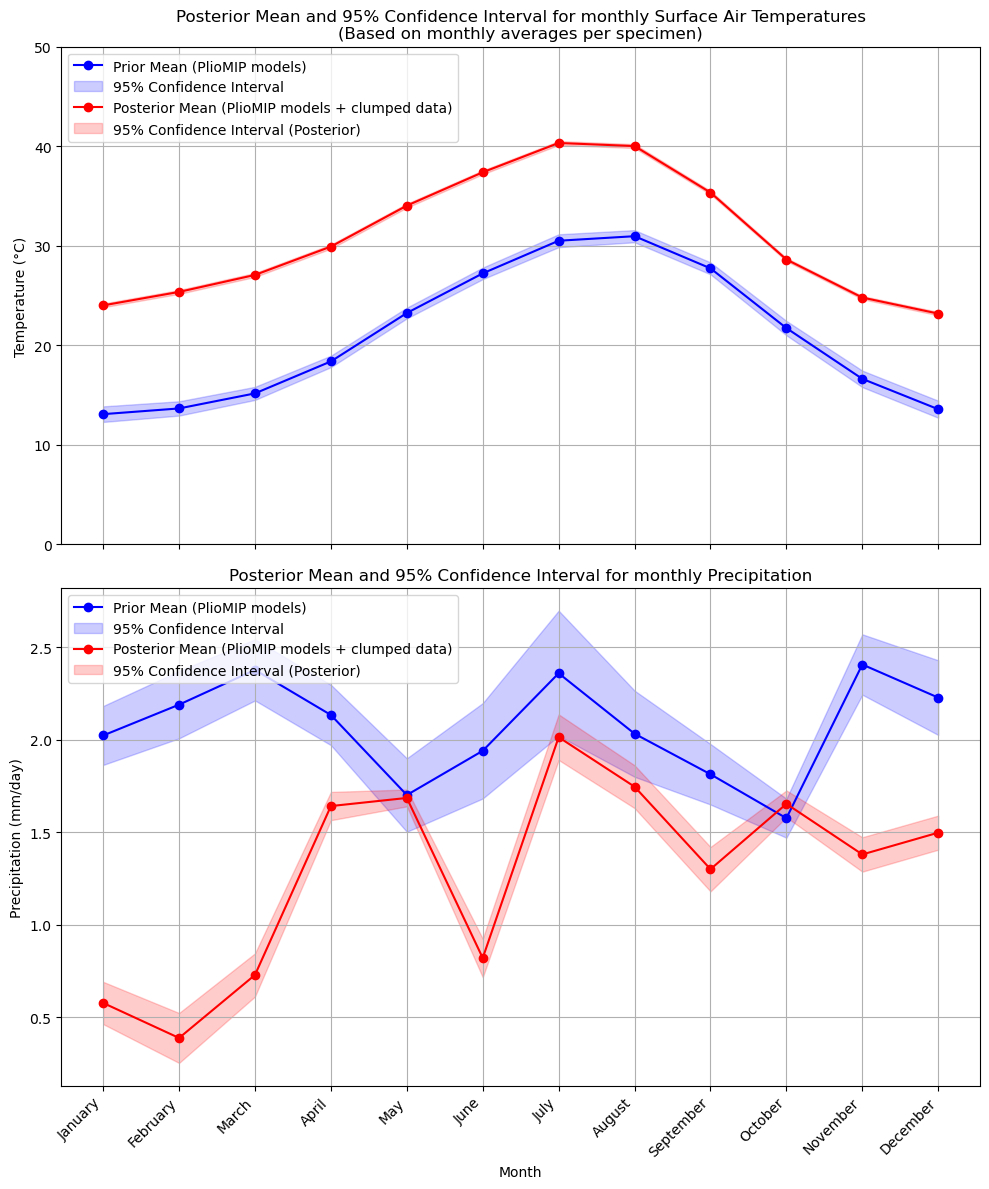

In [62]:
# Convert posterior D47 to temp
mu_post_SAT_D47_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_monthly_aggregated, sD47 = cov_post_SAT_D47_monthly_aggregated, return_covar = True)[0]
cov_post_SAT_D47_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_monthly_aggregated, sD47 = cov_post_SAT_D47_monthly_aggregated, return_covar = True)[1]

# Convert posterior SAT-D47 back to temperature
std_post_SAT_D47_monthly_aggregated_T = np.nan_to_num(np.sqrt(np.diag(cov_post_SAT_D47_monthly_aggregated_T)))

fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# --- SAT prior and posterior ---
# PRIOR
axs[0].plot(months_scale, mu_prior_SAT_monthly_original, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[0].fill_between(
    months_scale,
    mu_prior_SAT_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    mu_prior_SAT_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    color='b', alpha=0.2, label='95% Confidence Interval'
)

# POSTERIOR
axs[0].plot(months_scale, mu_post_SAT_D47_monthly_aggregated_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[0].fill_between(
    months_scale,
    mu_post_SAT_D47_monthly_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_D47 + n_models_monthly)) * std_post_SAT_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly),
    mu_post_SAT_D47_monthly_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_D47 + n_models_monthly)) * std_post_SAT_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)'
)

axs[0].set_title('Posterior Mean and 95% Confidence Interval for monthly Surface Air Temperatures\n(Based on monthly averages per specimen)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_ylim(0, 50)
axs[0].legend(loc='upper left')
axs[0].grid(True)

# --- Precipitation prior and posterior ---
# PRIOR
axs[1].plot(months_scale, mu_prior_precip_monthly_original, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[1].fill_between(
    months_scale,
    mu_prior_precip_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    mu_prior_precip_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    color='b', alpha=0.2, label='95% Confidence Interval'
)

# POSTERIOR
axs[1].plot(months_scale, mu_post_precip_monthly_aggregated, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[1].fill_between(
    months_scale,
    mu_post_precip_monthly_aggregated - stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_D47 + n_models_monthly)) * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)) / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly),
    mu_post_precip_monthly_aggregated + stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_D47 + n_models_monthly)) * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)) / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)'
)

axs[1].set_title('Posterior Mean and 95% Confidence Interval for monthly Precipitation')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Precipitation (mm/day)')
axs[1].legend(loc='upper left')
axs[1].grid(True)

plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Plot SAT, SST, SSS and precipitation posterior

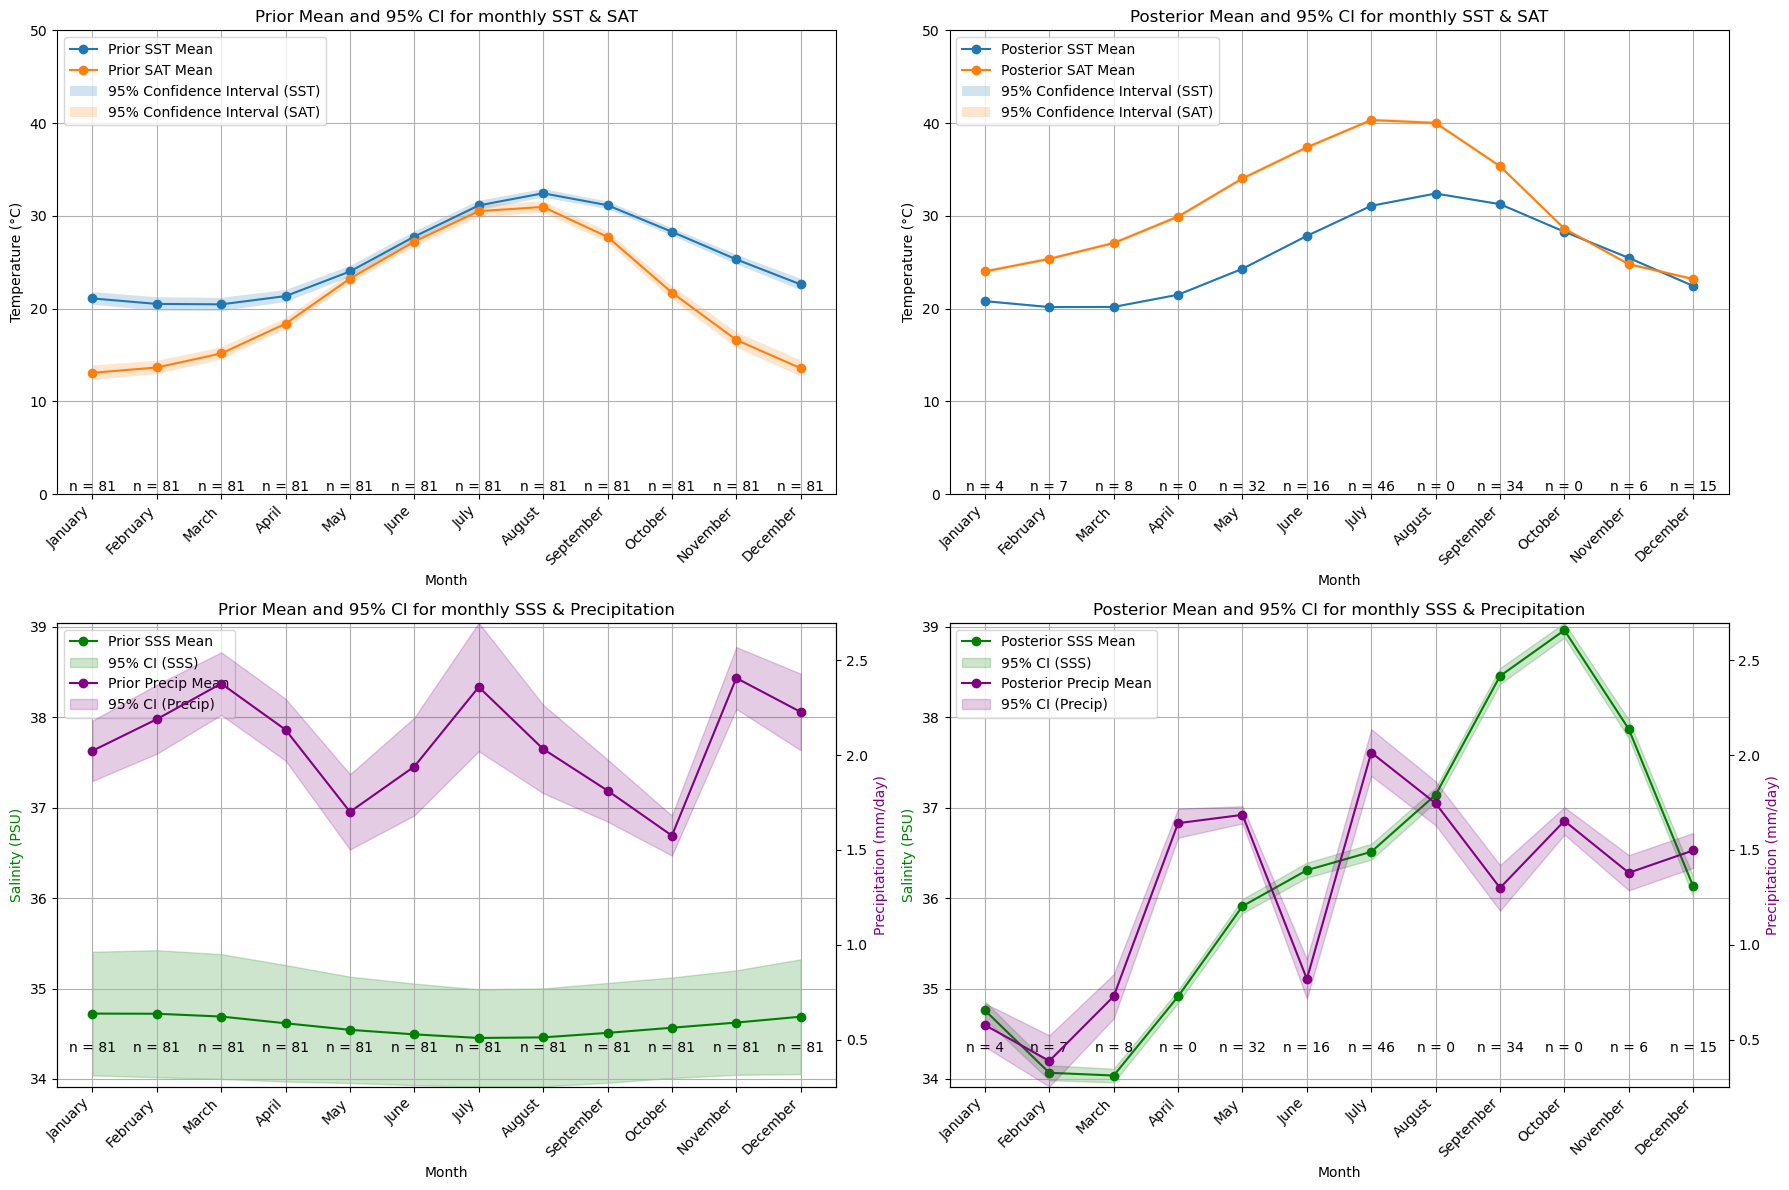

In [63]:
# Create a figure with two rows and two columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --- SST & SAT Prior and Posterior ---
# Prior SST & SAT
axes[0, 0].plot(months_scale, mu_prior_SST_monthly, label='Prior SST Mean', marker='o')
axes[0, 0].plot(months_scale, mu_prior_SAT_monthly, label='Prior SAT Mean', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_prior_SST_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
    mu_prior_SST_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, label='95% Confidence Interval (SST)'
)
axes[0, 0].fill_between(
    months_scale,
    mu_prior_SAT_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    mu_prior_SAT_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, label='95% Confidence Interval (SAT)'
)
axes[0, 0].set_xticks(months_scale)
axes[0, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 0].set_title('Prior Mean and 95% CI for monthly SST & SAT')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_ylim(0, 50)
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True)

# Posterior SST & SAT
axes[0, 1].plot(months_scale, mu_post_SST_D47_monthly_aggregated_T, label='Posterior SST Mean', marker='o')
axes[0, 1].plot(months_scale, mu_post_SAT_D47_monthly_aggregated_T, label='Posterior SAT Mean', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_post_SST_D47_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_models_monthly) * std_post_SST_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly),
    mu_post_SST_D47_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_models_monthly) * std_post_SST_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly),
    alpha=0.2, label='95% Confidence Interval (SST)'
)
axes[0, 1].fill_between(
    months_scale,
    mu_post_SAT_D47_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_models_monthly) * std_post_SAT_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly),
    mu_post_SAT_D47_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_models_monthly) * std_post_SAT_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly),
    alpha=0.2, label='95% Confidence Interval (SAT)'
)
axes[0, 1].set_xticks(months_scale)
axes[0, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 1].set_title('Posterior Mean and 95% CI for monthly SST & SAT')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].set_ylim(0, 50)
axes[0, 1].legend(loc='upper left')
axes[0, 1].grid(True)

# --- SSS & Precipitation Prior and Posterior (Shared Plot, Twin Axes) ---

# Get y-limits for SSS and precipitation (prior and posterior) to keep them consistent
sss_min = min(np.min(mu_prior_SSS_d18Ow_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly)),
              np.min(mu_post_SSS_d18Ow_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_models_monthly) * std_post_SSS_d18Ow_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly)))
sss_max = max(np.max(mu_prior_SSS_d18Ow_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly)),
              np.max(mu_post_SSS_d18Ow_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_models_monthly) * std_post_SSS_d18Ow_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly)))
precip_min = min(np.min(mu_prior_precip_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly)),
                 np.min(mu_post_precip_monthly_aggregated - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_models_monthly) * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)) / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly)))
precip_max = max(np.max(mu_prior_precip_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly)),
                 np.max(mu_post_precip_monthly_aggregated + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_models_monthly) * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)) / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly)))

# --- Prior SSS & Precipitation ---
ax1 = axes[1, 0]
ax2 = ax1.twinx()
lns1 = ax1.plot(months_scale, mu_prior_SSS_d18Ow_monthly_T, label='Prior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    months_scale,
    mu_prior_SSS_d18Ow_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly),
    mu_prior_SSS_d18Ow_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly),
    color="green", alpha=0.2, label='95% CI (SSS)'
)
lns2 = ax2.plot(months_scale, mu_prior_precip_monthly_original, label='Prior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    months_scale,
    mu_prior_precip_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    mu_prior_precip_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    color="purple", alpha=0.2, label='95% CI (Precip)'
)
ax1.set_xticks(months_scale)
ax1.set_xticklabels(month_names, rotation=45, ha="right")
ax1.set_title('Prior Mean and 95% CI for monthly SSS & Precipitation')
ax1.set_xlabel('Month')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# --- Posterior SSS & Precipitation ---
ax1 = axes[1, 1]
ax2 = ax1.twinx()
lns1 = ax1.plot(months_scale, mu_post_SSS_d18Ow_monthly_aggregated_T, label='Posterior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    months_scale,
    mu_post_SSS_d18Ow_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_models_monthly) * std_post_SSS_d18Ow_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly),
    mu_post_SSS_d18Ow_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_models_monthly) * std_post_SSS_d18Ow_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly),
    color="green", alpha=0.2, label='95% CI (SSS)'
)
lns2 = ax2.plot(months_scale, mu_post_precip_monthly_aggregated, label='Posterior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    months_scale,
    mu_post_precip_monthly_aggregated - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_models_monthly) * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)) / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly),
    mu_post_precip_monthly_aggregated + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_models_monthly) * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)) / np.sqrt(n_update_monthly_aggregated_D47 + n_models_monthly),
    color="purple", alpha=0.2, label='95% CI (Precip)'
)
ax1.set_xticks(months_scale)
ax1.set_xticklabels(month_names, rotation=45, ha="right")
ax1.set_title('Posterior Mean and 95% CI for monthly SSS & Precipitation')
ax1.set_xlabel('Month')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# Add "n = x" labels below each x-tick for each subplot to show the number of model values or updates
# Prior SST & SAT
for i, month in enumerate(month_names):
    axes[0, 0].text(
        months_scale[i], axes[0, 0].get_ylim()[0] + 1.5,  # adjust location as needed
        f"n = {n_models_monthly[i] if hasattr(n_models_monthly, '__getitem__') else n_models_monthly}",
        ha='center', va='top', fontsize=10
    )

# Posterior SST & SAT
for i, month in enumerate(month_names):
    axes[0, 1].text(
        months_scale[i], axes[0, 1].get_ylim()[0] + 1.5,
        f"n = {int(n_update_monthlySC_D47[i]) if hasattr(n_update_monthlySC_D47, '__getitem__') else n_update_monthlySC_D47}",
        ha='center', va='top', fontsize=10
    )

# Prior SSS & Precipitation
for i, month in enumerate(month_names):
    axes[1, 0].text(
        months_scale[i], axes[1, 0].get_ylim()[0] + 0.5,
        f"n = {n_models_monthly[i] if hasattr(n_models_monthly, '__getitem__') else n_models_monthly}",
        ha='center', va='top', fontsize=10
    )

# Posterior SSS & Precipitation
for i, month in enumerate(month_names):
    axes[1, 1].text(
        months_scale[i], axes[1, 1].get_ylim()[0] + 0.5,
        f"n = {int(n_update_monthlySC_D47[i]) if hasattr(n_update_monthlySC_D47, '__getitem__') else n_update_monthlySC_D47}",
        ha='center', va='top', fontsize=10
    )
    
plt.tight_layout()
plt.show()

### Plot SAT, SST, SSS and precipitation posterior with uncertainty as 2 standard deviations

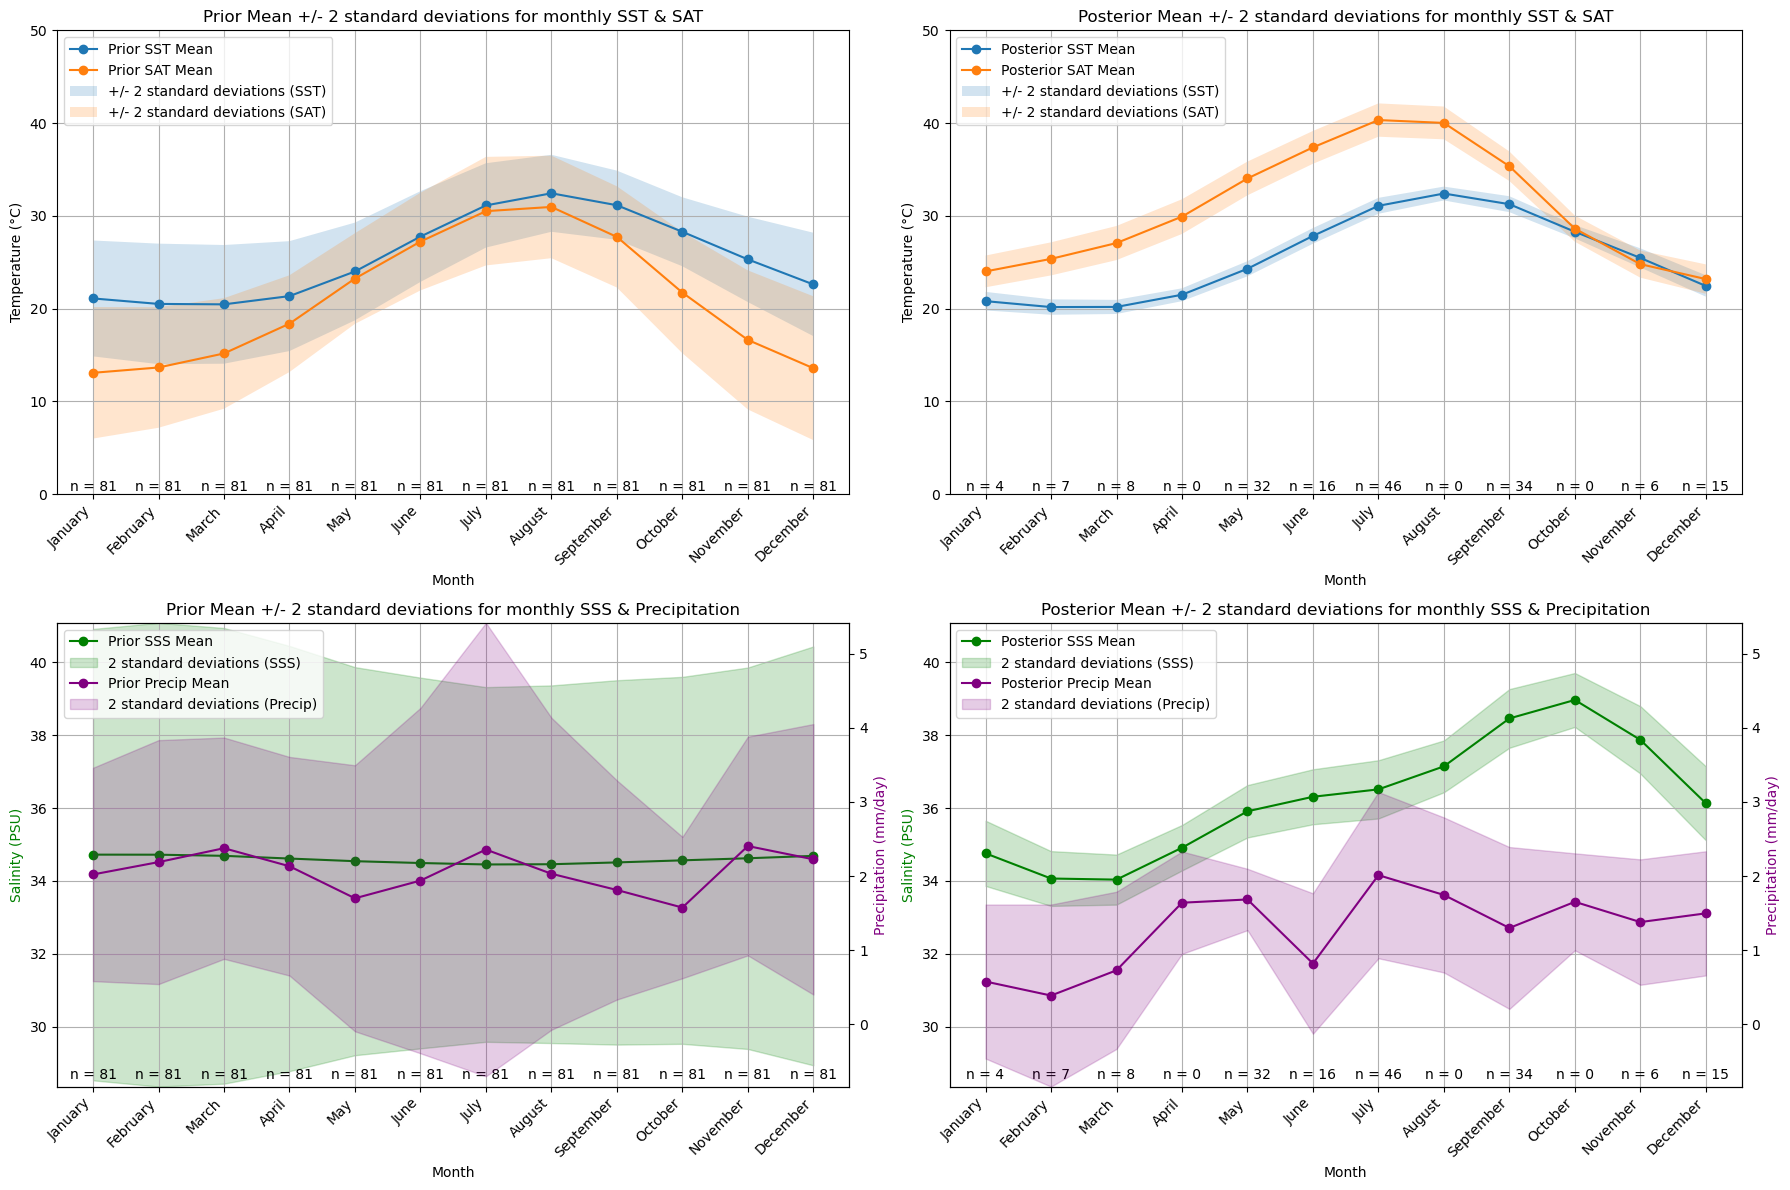

In [64]:
# Create a figure with two rows and two columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --- SST & SAT Prior and Posterior ---
# Prior SST & SAT
axes[0, 0].plot(months_scale, mu_prior_SST_monthly, label='Prior SST Mean', marker='o')
axes[0, 0].plot(months_scale, mu_prior_SAT_monthly, label='Prior SAT Mean', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_prior_SST_monthly - 2 * std_prior_SST_monthly,
    mu_prior_SST_monthly + 2 * std_prior_SST_monthly,
    alpha=0.2, label='+/- 2 standard deviations (SST)'
)
axes[0, 0].fill_between(
    months_scale,
    mu_prior_SAT_monthly - 2 * std_prior_SAT_monthly,
    mu_prior_SAT_monthly + 2 * std_prior_SAT_monthly,
    alpha=0.2, label='+/- 2 standard deviations (SAT)'
)
axes[0, 0].set_xticks(months_scale)
axes[0, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 0].set_title('Prior Mean +/- 2 standard deviations for monthly SST & SAT')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_ylim(0, 50)
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True)

# Posterior SST & SAT
axes[0, 1].plot(months_scale, mu_post_SST_D47_monthly_aggregated_T, label='Posterior SST Mean', marker='o')
axes[0, 1].plot(months_scale, mu_post_SAT_D47_monthly_aggregated_T, label='Posterior SAT Mean', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_post_SST_D47_monthly_aggregated_T - 2 * std_post_SST_D47_monthly_aggregated_T,
    mu_post_SST_D47_monthly_aggregated_T + 2 * std_post_SST_D47_monthly_aggregated_T,
    alpha=0.2, label='+/- 2 standard deviations (SST)'
)
axes[0, 1].fill_between(
    months_scale,
    mu_post_SAT_D47_monthly_aggregated_T - 2 * std_post_SAT_D47_monthly_aggregated_T,
    mu_post_SAT_D47_monthly_aggregated_T + 2 * std_post_SAT_D47_monthly_aggregated_T,
    alpha=0.2, label='+/- 2 standard deviations (SAT)'
)
axes[0, 1].set_xticks(months_scale)
axes[0, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 1].set_title('Posterior Mean +/- 2 standard deviations for monthly SST & SAT')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].set_ylim(0, 50)
axes[0, 1].legend(loc='upper left')
axes[0, 1].grid(True)

# --- SSS & Precipitation Prior and Posterior (Shared Plot, Twin Axes) ---

# Get y-limits for SSS and precipitation (prior and posterior) to keep them consistent
sss_min = min(np.min(mu_prior_SSS_d18Ow_monthly_T - 2 * std_prior_SSS_d18Ow_monthly_T),
              np.min(mu_post_SSS_d18Ow_monthly_aggregated_T - 2 * std_post_SSS_d18Ow_monthly_aggregated_T))
sss_max = max(np.max(mu_prior_SSS_d18Ow_monthly_T + 2 * std_prior_SSS_d18Ow_monthly_T),
              np.max(mu_post_SSS_d18Ow_monthly_aggregated_T + 2 * std_post_SSS_d18Ow_monthly_aggregated_T))
precip_min = min(np.min(mu_prior_precip_monthly_original - 2 * std_prior_precip_monthly),
                 np.min(mu_post_precip_monthly_aggregated - 2 * np.sqrt(np.diag(cov_post_precip_monthly_aggregated))))
precip_max = max(np.max(mu_prior_precip_monthly_original + 2 * std_prior_precip_monthly),
                 np.max(mu_post_precip_monthly_aggregated + 2 * np.sqrt(np.diag(cov_post_precip_monthly_aggregated))))

# --- Prior SSS & Precipitation ---
ax1 = axes[1, 0]
ax2 = ax1.twinx()
lns1 = ax1.plot(months_scale, mu_prior_SSS_d18Ow_monthly_T, label='Prior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    months_scale,
    mu_prior_SSS_d18Ow_monthly_T - 2 * std_prior_SSS_d18Ow_monthly_T,
    mu_prior_SSS_d18Ow_monthly_T + 2 * std_prior_SSS_d18Ow_monthly_T,
    color="green", alpha=0.2, label='2 standard deviations (SSS)'
)
lns2 = ax2.plot(months_scale, mu_prior_precip_monthly_original, label='Prior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    months_scale,
    mu_prior_precip_monthly_original - 2 * std_prior_precip_monthly,
    mu_prior_precip_monthly_original + 2 * std_prior_precip_monthly,
    color="purple", alpha=0.2, label='2 standard deviations (Precip)'
)
ax1.set_xticks(months_scale)
ax1.set_xticklabels(month_names, rotation=45, ha="right")
ax1.set_title('Prior Mean +/- 2 standard deviations for monthly SSS & Precipitation')
ax1.set_xlabel('Month')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# --- Posterior SSS & Precipitation ---
ax1 = axes[1, 1]
ax2 = ax1.twinx()
lns1 = ax1.plot(months_scale, mu_post_SSS_d18Ow_monthly_aggregated_T, label='Posterior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    months_scale,
    mu_post_SSS_d18Ow_monthly_aggregated_T - 2 * std_post_SSS_d18Ow_monthly_aggregated_T,
    mu_post_SSS_d18Ow_monthly_aggregated_T + 2 * std_post_SSS_d18Ow_monthly_aggregated_T,
    color="green", alpha=0.2, label='2 standard deviations (SSS)'
)
lns2 = ax2.plot(months_scale, mu_post_precip_monthly_aggregated, label='Posterior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    months_scale,
    mu_post_precip_monthly_aggregated - 2 * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)),
    mu_post_precip_monthly_aggregated + 2 * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)),
    color="purple", alpha=0.2, label='2 standard deviations (Precip)'
)
ax1.set_xticks(months_scale)
ax1.set_xticklabels(month_names, rotation=45, ha="right")
ax1.set_title('Posterior Mean +/- 2 standard deviations for monthly SSS & Precipitation')
ax1.set_xlabel('Month')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# Add "n = x" labels below each x-tick for each subplot to show the number of model values or updates
# Prior SST & SAT
for i, month in enumerate(month_names):
    axes[0, 0].text(
        months_scale[i], axes[0, 0].get_ylim()[0] + 1.5,  # adjust location as needed
        f"n = {n_models_monthly[i] if hasattr(n_models_monthly, '__getitem__') else n_models_monthly}",
        ha='center', va='top', fontsize=10
    )

# Posterior SST & SAT
for i, month in enumerate(month_names):
    axes[0, 1].text(
        months_scale[i], axes[0, 1].get_ylim()[0] + 1.5,
        f"n = {int(n_update_monthlySC_D47[i]) if hasattr(n_update_monthlySC_D47, '__getitem__') else n_update_monthlySC_D47}",
        ha='center', va='top', fontsize=10
    )

# Prior SSS & Precipitation
for i, month in enumerate(month_names):
    axes[1, 0].text(
        months_scale[i], axes[1, 0].get_ylim()[0] + 0.5,
        f"n = {n_models_monthly[i] if hasattr(n_models_monthly, '__getitem__') else n_models_monthly}",
        ha='center', va='top', fontsize=10
    )

# Posterior SSS & Precipitation
for i, month in enumerate(month_names):
    axes[1, 1].text(
        months_scale[i], axes[1, 1].get_ylim()[0] + 0.5,
        f"n = {int(n_update_monthlySC_D47[i]) if hasattr(n_update_monthlySC_D47, '__getitem__') else n_update_monthlySC_D47}",
        ha='center', va='top', fontsize=10
    )
    
plt.tight_layout()
plt.show()

## Monthly posterior in temperature and salinity domains with data based on ShellChron (including ShellChron uncertainty)
* Data and model outcomes aggregated per month
* Including sclero-dating uncertainty
* D47 data treated as individual datapoints

### Convert monthly prior, likelihood and posterior to temperature and salinity and plot

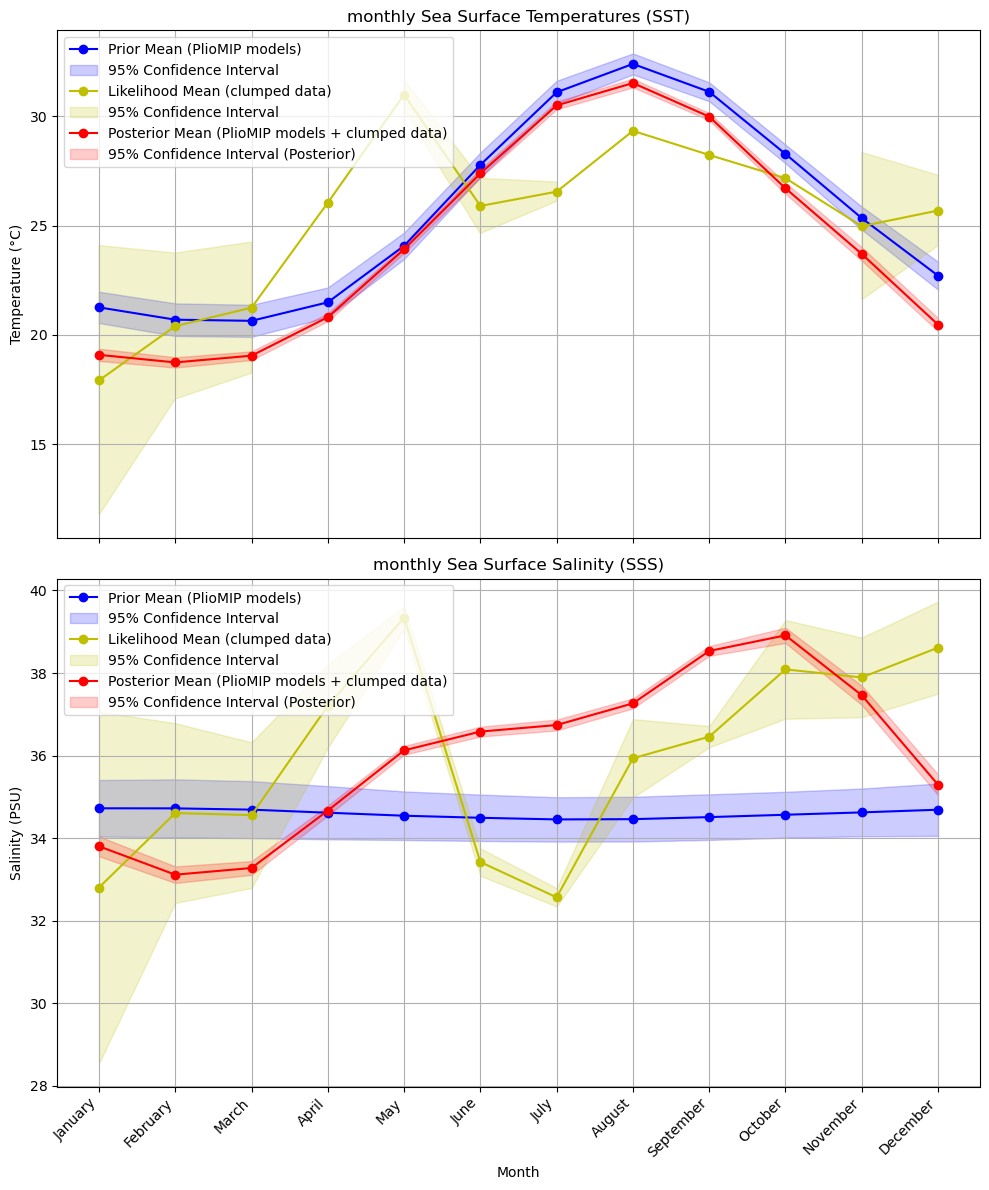

In [65]:
# (Prior is identical to the monthly prior above)

# Convert likelihood D47 to temp
mu_likelihood_monthlySC_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthlySC[var_start_D47_monthly:var_end_D47_monthly], sD47 = std_likelihood_monthlySC[var_start_D47_monthly:var_end_D47_monthly], return_covar = True)[0]
cov_likelihood_monthlySC_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthlySC[var_start_D47_monthly:var_end_D47_monthly], sD47 = std_likelihood_monthlySC[var_start_D47_monthly:var_end_D47_monthly], return_covar = True)[1]

# Convert likelihood d18Oc and temperature to d18Ow (curently not implemented in data tracking function)
mu_likelihood_d18Ow_monthlySC_T = mu_likelihood_monthlySC[var_start_d18Oc_monthly:var_end_d18Oc_monthly] - (20.6 - mu_likelihood_monthlySC_T) / 4.34 + 0.27
std_likelihood_d18Ow_monthlySC_T = std_likelihood_monthlySC[var_start_d18Oc_monthly:var_end_d18Oc_monthly] + (1 / 4.34) ** 2 * np.sqrt(np.diag(cov_likelihood_monthlySC_T))

# Convert likelihood d18Ow to SSS (currently not implemented in data tracking function)
mu_likelihood_SSS_d18Ow_monthlySC_T = (mu_likelihood_d18Ow_monthlySC_T + 9.300) / 0.274
std_likelihood_SSS_d18Ow_monthlySC_T = std_likelihood_d18Ow_monthlySC_T / (0.274 ** 2)

# Convert posterior D47 to temp
mu_post_SST_D47_monthlySC_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_monthlySC, sD47 = cov_post_SST_D47_monthlySC, return_covar = True)[0]
cov_post_SST_D47_monthlySC_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_monthlySC, sD47 = cov_post_SST_D47_monthlySC, return_covar = True)[1]

# Convert posterior d18Oc and temperature to d18Ow
mu_post_d18Ow_monthlySC_T = mu_post_d18Oc_monthlySC - (20.6 - mu_post_SST_D47_monthlySC_T) / 4.34 + 0.27
cov_post_d18Ow_monthlySC_T = cov_post_d18Oc_monthlySC + (1 / 4.34) ** 2 * cov_post_SST_D47_monthlySC_T

# Convert posterior d18Ow to SSS
mu_post_SSS_d18Ow_monthlySC_T = (mu_post_d18Ow_monthlySC_T + 9.300) / 0.274
cov_post_SSS_d18Ow_monthlySC_T = cov_post_d18Ow_monthlySC_T / (0.274 ** 2)

# Plot in temperature domain
std_prior_SST_D47_monthly_T = np.sqrt(np.diag(cov_prior_SST_D47_monthly_T))
std_prior_SSS_d18Ow_monthly_T = np.sqrt(np.diag(cov_prior_SSS_d18Ow_monthly_T))
std_likelihood_monthlySC_T = np.sqrt(np.diag(cov_likelihood_monthlySC_T))
std_post_SST_D47_monthlySC_T = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_T))
std_post_SSS_d18Ow_monthlySC_T = np.sqrt(np.diag(cov_post_SSS_d18Ow_monthlySC_T))

# Initiate plot
fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# FIRST PANEL: SST Results
# PRIOR
axs[0].plot(months_scale, mu_prior_SST_D47_monthly_T, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[0].fill_between(months_scale,
    mu_prior_SST_D47_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_T / np.sqrt(n_models_monthly),
    mu_prior_SST_D47_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_T / np.sqrt(n_models_monthly),
    color='b', alpha=0.2, label='95% Confidence Interval')

# LIKELIHOOD
axs[0].plot(months_scale, mu_likelihood_monthlySC_T, label='Likelihood Mean (clumped data)', color='y', marker='o')
axs[0].fill_between(months_scale,
    mu_likelihood_monthlySC_T - stats.t.ppf(1 - 0.025, n_update_monthlySC_D47) * std_likelihood_monthlySC_T / np.sqrt(n_update_monthlySC_D47),
    mu_likelihood_monthlySC_T + stats.t.ppf(1 - 0.025, n_update_monthlySC_D47) * std_likelihood_monthlySC_T / np.sqrt(n_update_monthlySC_D47),
    color='y', alpha=0.2, label='95% Confidence Interval')

# POSTERIOR
axs[0].plot(months_scale, mu_post_SST_D47_monthlySC_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[0].fill_between(months_scale,
    mu_post_SST_D47_monthlySC_T - stats.t.ppf(1 - 0.025, (n_update_monthlySC_D47 + n_models_monthly)) * std_post_SST_D47_monthlySC_T / np.sqrt(n_update_monthlySC_D47 + n_models_monthly),
    mu_post_SST_D47_monthlySC_T + stats.t.ppf(1 - 0.025, (n_update_monthlySC_D47 + n_models_monthly)) * std_post_SST_D47_monthlySC_T / np.sqrt(n_update_monthlySC_D47 + n_models_monthly),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)')

# Layout for SST panel
axs[0].set_title('monthly Sea Surface Temperatures (SST)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].legend(loc='upper left')
axs[0].grid(True)

# SECOND PANEL: SSS Results
# PRIOR
axs[1].plot(months_scale, mu_prior_SSS_d18Ow_monthly_T, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[1].fill_between(months_scale,
    mu_prior_SSS_d18Ow_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly),
    mu_prior_SSS_d18Ow_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly),
    color='b', alpha=0.2, label='95% Confidence Interval')

# LIKELIHOOD
axs[1].plot(months_scale, mu_likelihood_SSS_d18Ow_monthlySC_T, label='Likelihood Mean (clumped data)', color='y', marker='o')
axs[1].fill_between(months_scale,
    mu_likelihood_SSS_d18Ow_monthlySC_T - stats.t.ppf(1 - 0.025, n_update_monthlySC_d18Oc) * std_likelihood_SSS_d18Ow_monthlySC_T / np.sqrt(n_update_monthlySC_d18Oc),
    mu_likelihood_SSS_d18Ow_monthlySC_T + stats.t.ppf(1 - 0.025, n_update_monthlySC_d18Oc) * std_likelihood_SSS_d18Ow_monthlySC_T / np.sqrt(n_update_monthlySC_d18Oc),
    color='y', alpha=0.2, label='95% Confidence Interval')

# POSTERIOR
axs[1].plot(months_scale, mu_post_SSS_d18Ow_monthlySC_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[1].fill_between(months_scale,
    mu_post_SSS_d18Ow_monthlySC_T - stats.t.ppf(1 - 0.025, (n_update_monthlySC_d18Oc + n_models_monthly)) * std_post_SSS_d18Ow_monthlySC_T / np.sqrt(n_update_monthlySC_d18Oc + n_models_monthly),
    mu_post_SSS_d18Ow_monthlySC_T + stats.t.ppf(1 - 0.025, (n_update_monthlySC_d18Oc + n_models_monthly)) * std_post_SSS_d18Ow_monthlySC_T / np.sqrt(n_update_monthlySC_d18Oc + n_models_monthly),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)')

# Layout for SSS panel
axs[1].set_title('monthly Sea Surface Salinity (SSS)')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Salinity (PSU)')
axs[1].legend(loc='upper left')
axs[1].grid(True)

# Shared x-axis labels
plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Plot SAT and precipitation prior and posterior

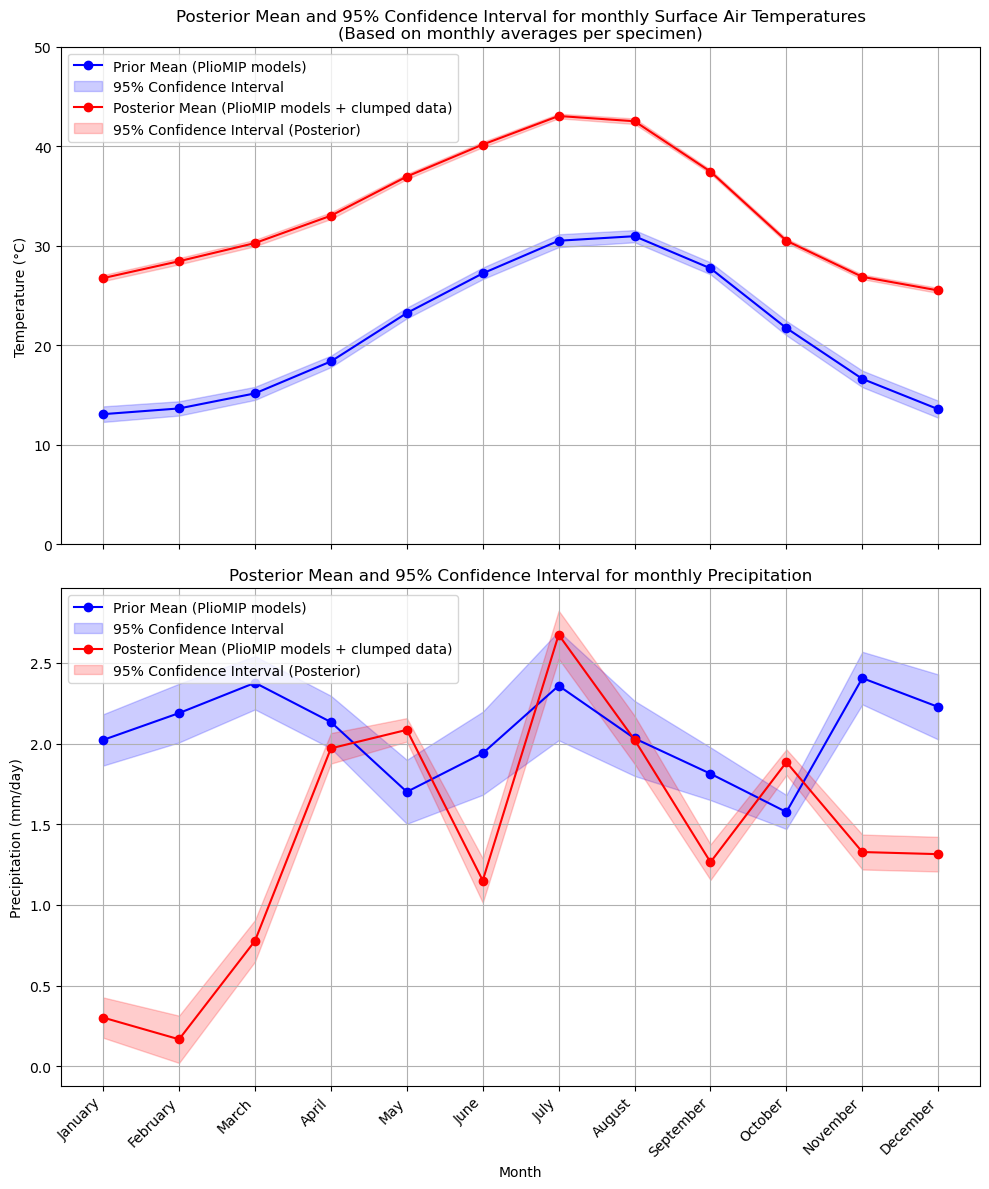

In [66]:
# Convert posterior D47 to temp
mu_post_SAT_D47_monthlySC_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_monthlySC, sD47 = cov_post_SAT_D47_monthlySC, return_covar = True)[0]
cov_post_SAT_D47_monthlySC_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_monthlySC, sD47 = cov_post_SAT_D47_monthlySC, return_covar = True)[1]

# Convert posterior SAT-D47 back to temperature
std_post_SAT_D47_monthlySC_T = np.nan_to_num(np.sqrt(np.diag(cov_post_SAT_D47_monthlySC_T)))

fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# --- SAT prior and posterior ---
# PRIOR
axs[0].plot(months_scale, mu_prior_SAT_monthly_original, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[0].fill_between(
    months_scale,
    mu_prior_SAT_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    mu_prior_SAT_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    color='b', alpha=0.2, label='95% Confidence Interval'
)

# POSTERIOR
axs[0].plot(months_scale, mu_post_SAT_D47_monthlySC_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[0].fill_between(
    months_scale,
    mu_post_SAT_D47_monthlySC_T - stats.t.ppf(1 - 0.025, (n_update_monthlySC_D47 + n_models_monthly)) * std_post_SAT_D47_monthlySC_T / np.sqrt(n_update_monthlySC_D47 + n_models_monthly),
    mu_post_SAT_D47_monthlySC_T + stats.t.ppf(1 - 0.025, (n_update_monthlySC_D47 + n_models_monthly)) * std_post_SAT_D47_monthlySC_T / np.sqrt(n_update_monthlySC_D47 + n_models_monthly),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)'
)

axs[0].set_title('Posterior Mean and 95% Confidence Interval for monthly Surface Air Temperatures\n(Based on monthly averages per specimen)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_ylim(0, 50)
axs[0].legend(loc='upper left')
axs[0].grid(True)

# --- Precipitation prior and posterior ---
# PRIOR
axs[1].plot(months_scale, mu_prior_precip_monthly_original, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[1].fill_between(
    months_scale,
    mu_prior_precip_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    mu_prior_precip_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    color='b', alpha=0.2, label='95% Confidence Interval'
)

# POSTERIOR
axs[1].plot(months_scale, mu_post_precip_monthlySC, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[1].fill_between(
    months_scale,
    mu_post_precip_monthlySC - stats.t.ppf(1 - 0.025, (n_update_monthlySC_D47 + n_models_monthly)) * np.sqrt(np.diag(cov_post_precip_monthlySC)) / np.sqrt(n_update_monthlySC_D47 + n_models_monthly),
    mu_post_precip_monthlySC + stats.t.ppf(1 - 0.025, (n_update_monthlySC_D47 + n_models_monthly)) * np.sqrt(np.diag(cov_post_precip_monthlySC)) / np.sqrt(n_update_monthlySC_D47 + n_models_monthly),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)'
)

axs[1].set_title('Posterior Mean and 95% Confidence Interval for monthly Precipitation')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Precipitation (mm/day)')
axs[1].legend(loc='upper left')
axs[1].grid(True)

plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Plot SAT, SST, SSS and precipitation posterior

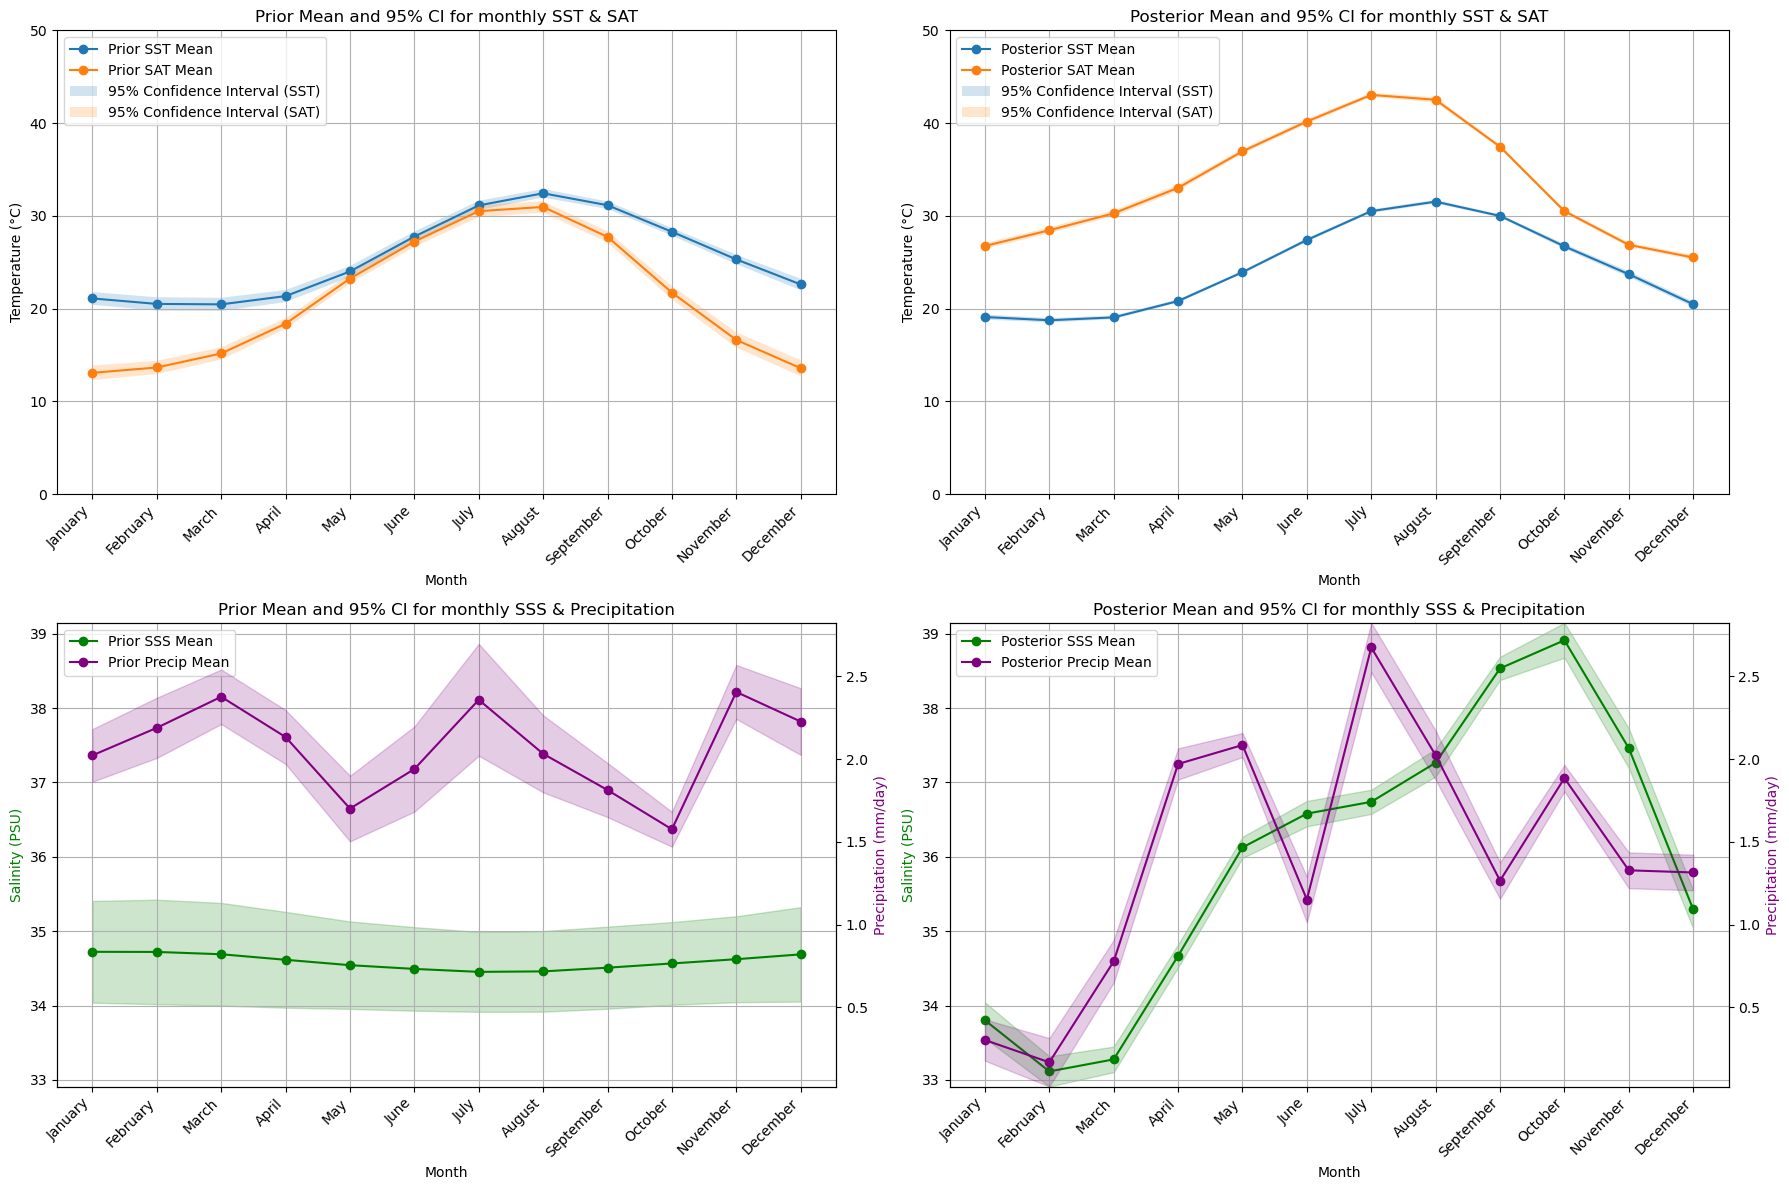

In [67]:
# Create a figure with two rows and two columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --- SST & SAT Prior and Posterior ---
# Prior SST & SAT
axes[0, 0].plot(months_scale, mu_prior_SST_monthly, label='Prior SST Mean', marker='o')
axes[0, 0].plot(months_scale, mu_prior_SAT_monthly, label='Prior SAT Mean', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_prior_SST_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
    mu_prior_SST_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, label='95% Confidence Interval (SST)'
)
axes[0, 0].fill_between(
    months_scale,
    mu_prior_SAT_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    mu_prior_SAT_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, label='95% Confidence Interval (SAT)'
)
axes[0, 0].set_xticks(months_scale)
axes[0, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 0].set_title('Prior Mean and 95% CI for monthly SST & SAT')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_ylim(0, 50)
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True)

# Posterior SST & SAT
axes[0, 1].plot(months_scale, mu_post_SST_D47_monthlySC_T, label='Posterior SST Mean', marker='o')
axes[0, 1].plot(months_scale, mu_post_SAT_D47_monthlySC_T, label='Posterior SAT Mean', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_post_SST_D47_monthlySC_T - stats.t.ppf(1 - 0.025, n_update_monthlySC_D47 + n_models_monthly) * std_post_SST_D47_monthlySC_T / np.sqrt(n_update_monthlySC_D47 + n_models_monthly),
    mu_post_SST_D47_monthlySC_T + stats.t.ppf(1 - 0.025, n_update_monthlySC_D47 + n_models_monthly) * std_post_SST_D47_monthlySC_T / np.sqrt(n_update_monthlySC_D47 + n_models_monthly),
    alpha=0.2, label='95% Confidence Interval (SST)'
)
axes[0, 1].fill_between(
    months_scale,
    mu_post_SAT_D47_monthlySC_T - stats.t.ppf(1 - 0.025, n_update_monthlySC_D47 + n_models_monthly) * std_post_SAT_D47_monthlySC_T / np.sqrt(n_update_monthlySC_D47 + n_models_monthly),
    mu_post_SAT_D47_monthlySC_T + stats.t.ppf(1 - 0.025, n_update_monthlySC_D47 + n_models_monthly) * std_post_SAT_D47_monthlySC_T / np.sqrt(n_update_monthlySC_D47 + n_models_monthly),
    alpha=0.2, label='95% Confidence Interval (SAT)'
)
axes[0, 1].set_xticks(months_scale)
axes[0, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 1].set_title('Posterior Mean and 95% CI for monthly SST & SAT')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].set_ylim(0, 50)
axes[0, 1].legend(loc='upper left')
axes[0, 1].grid(True)

# --- SSS & Precipitation Prior and Posterior (Shared Plot, Twin Axes) ---

# Get y-limits for SSS and precipitation (prior and posterior) to keep them consistent
sss_min = min(np.min(mu_prior_SSS_d18Ow_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly)),
              np.min(mu_post_SSS_d18Ow_monthlySC_T - stats.t.ppf(1 - 0.025, n_update_monthlySC_D47 + n_models_monthly) * std_post_SSS_d18Ow_monthlySC_T / np.sqrt(n_update_monthlySC_D47 + n_models_monthly)))
sss_max = max(np.max(mu_prior_SSS_d18Ow_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly)),
              np.max(mu_post_SSS_d18Ow_monthlySC_T + stats.t.ppf(1 - 0.025, n_update_monthlySC_D47 + n_models_monthly) * std_post_SSS_d18Ow_monthlySC_T / np.sqrt(n_update_monthlySC_D47 + n_models_monthly)))
precip_min = min(np.min(mu_prior_precip_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly)),
                 np.min(mu_post_precip_monthlySC - stats.t.ppf(1 - 0.025, n_update_monthlySC_D47 + n_models_monthly) * np.sqrt(np.diag(cov_post_precip_monthlySC)) / np.sqrt(n_update_monthlySC_D47 + n_models_monthly)))
precip_max = max(np.max(mu_prior_precip_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly)),
                 np.max(mu_post_precip_monthlySC + stats.t.ppf(1 - 0.025, n_update_monthlySC_D47 + n_models_monthly) * np.sqrt(np.diag(cov_post_precip_monthlySC)) / np.sqrt(n_update_monthlySC_D47 + n_models_monthly)))

# --- Prior SSS & Precipitation ---
ax1 = axes[1, 0]
ax2 = ax1.twinx()
lns1 = ax1.plot(months_scale, mu_prior_SSS_d18Ow_monthly_T, label='Prior SSS Mean', marker='o', color="green")
ax1.fill_between(
    months_scale,
    mu_prior_SSS_d18Ow_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly),
    mu_prior_SSS_d18Ow_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly),
    color="green", alpha=0.2, label='95% CI (SSS)'
)
lns2 = ax2.plot(months_scale, mu_prior_precip_monthly_original, label='Prior Precip Mean', marker='o', color="purple")
ax2.fill_between(
    months_scale,
    mu_prior_precip_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    mu_prior_precip_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    color="purple", alpha=0.2, label='95% CI (Precip)'
)
ax1.set_xticks(months_scale)
ax1.set_xticklabels(month_names, rotation=45, ha="right")
ax1.set_title('Prior Mean and 95% CI for monthly SSS & Precipitation')
ax1.set_xlabel('Month')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + lns2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# --- Posterior SSS & Precipitation ---
ax1 = axes[1, 1]
ax2 = ax1.twinx()
lns1 = ax1.plot(months_scale, mu_post_SSS_d18Ow_monthlySC_T, label='Posterior SSS Mean', marker='o', color="green")
ax1.fill_between(
    months_scale,
    mu_post_SSS_d18Ow_monthlySC_T - stats.t.ppf(1 - 0.025, n_update_monthlySC_D47 + n_models_monthly) * std_post_SSS_d18Ow_monthlySC_T / np.sqrt(n_update_monthlySC_D47 + n_models_monthly),
    mu_post_SSS_d18Ow_monthlySC_T + stats.t.ppf(1 - 0.025, n_update_monthlySC_D47 + n_models_monthly) * std_post_SSS_d18Ow_monthlySC_T / np.sqrt(n_update_monthlySC_D47 + n_models_monthly),
    color="green", alpha=0.2, label='95% CI (SSS)'
)
lns2 = ax2.plot(months_scale, mu_post_precip_monthlySC, label='Posterior Precip Mean', marker='o', color="purple")
ax2.fill_between(
    months_scale,
    mu_post_precip_monthlySC - stats.t.ppf(1 - 0.025, n_update_monthlySC_D47 + n_models_monthly) * np.sqrt(np.diag(cov_post_precip_monthlySC)) / np.sqrt(n_update_monthlySC_D47 + n_models_monthly),
    mu_post_precip_monthlySC + stats.t.ppf(1 - 0.025, n_update_monthlySC_D47 + n_models_monthly) * np.sqrt(np.diag(cov_post_precip_monthlySC)) / np.sqrt(n_update_monthlySC_D47 + n_models_monthly),
    color="purple", alpha=0.2, label='95% CI (Precip)'
)
ax1.set_xticks(months_scale)
ax1.set_xticklabels(month_names, rotation=45, ha="right")
ax1.set_title('Posterior Mean and 95% CI for monthly SSS & Precipitation')
ax1.set_xlabel('Month')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + lns2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

plt.tight_layout()
plt.show()

## Monthly posterior in temperature and salinity domains with data based on ShellChron (ignoring ShellChron uncertainty)
* Data and model outcomes aggregated per month
* Ignore sclero-dating uncertainty
* D47 data treated as individual datapoints

### Convert monthly prior, likelihood and posterior to temperature and salinity and plot

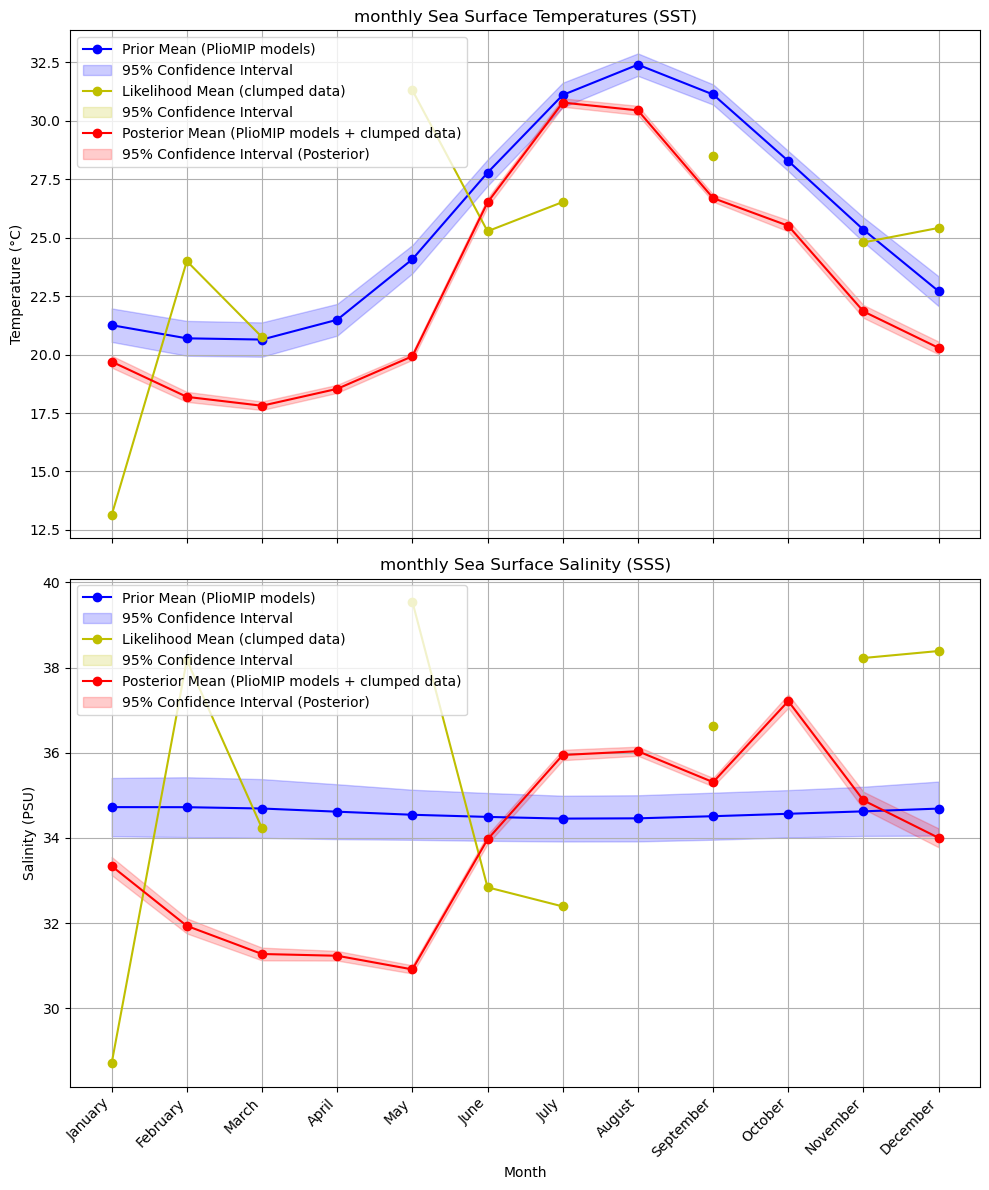

In [68]:
# (Prior is identical to the monthly prior above)
# Convert likelihood D47 to temp
mu_likelihood_monthlySC_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthlySC_noerr[var_start_D47_monthly:var_end_D47_monthly], sD47 = std_likelihood_monthlySC_noerr[var_start_D47_monthly:var_end_D47_monthly], return_covar = True)[0]
cov_likelihood_monthlySC_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthlySC_noerr[var_start_D47_monthly:var_end_D47_monthly], sD47 = std_likelihood_monthlySC_noerr[var_start_D47_monthly:var_end_D47_monthly], return_covar = True)[1]

# Convert likelihood d18Oc and temperature to d18Ow (curently not implemented in data tracking function)
mu_likelihood_d18Ow_monthlySC_noerr_T = mu_likelihood_monthlySC_noerr[var_start_d18Oc_monthly:var_end_d18Oc_monthly] - (20.6 - mu_likelihood_monthlySC_noerr_T) / 4.34 + 0.27
std_likelihood_d18Ow_monthlySC_noerr_T = std_likelihood_monthlySC_noerr[var_start_d18Oc_monthly:var_end_d18Oc_monthly] + (1 / 4.34) ** 2 * np.sqrt(np.diag(cov_likelihood_monthlySC_noerr_T))

# Convert likelihood d18Ow to SSS (currently not implemented in data tracking function)
mu_likelihood_SSS_d18Ow_monthlySC_noerr_T = (mu_likelihood_d18Ow_monthlySC_noerr_T + 9.300) / 0.274
std_likelihood_SSS_d18Ow_monthlySC_noerr_T = std_likelihood_d18Ow_monthlySC_noerr_T / (0.274 ** 2)

# Convert posterior D47 to temp
mu_post_SST_D47_monthlySC_noerr_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_monthlySC_noerr, sD47 = cov_post_SST_D47_monthlySC_noerr, return_covar = True)[0]
cov_post_SST_D47_monthlySC_noerr_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_monthlySC_noerr, sD47 = cov_post_SST_D47_monthlySC_noerr, return_covar = True)[1]

# Convert posterior d18Oc and temperature to d18Ow
mu_post_d18Ow_monthlySC_noerr_T = mu_post_d18Oc_monthlySC_noerr - (20.6 - mu_post_SST_D47_monthlySC_noerr_T) / 4.34 + 0.27
cov_post_d18Ow_monthlySC_noerr_T = cov_post_d18Oc_monthlySC_noerr + (1 / 4.34) ** 2 * cov_post_SST_D47_monthlySC_noerr_T

# Convert posterior d18Ow to SSS
mu_post_SSS_d18Ow_monthlySC_noerr_T = (mu_post_d18Ow_monthlySC_noerr_T + 9.300) / 0.274
cov_post_SSS_d18Ow_monthlySC_noerr_T = cov_post_d18Ow_monthlySC_noerr_T / (0.274 ** 2)

# Plot in temperature domain
std_prior_SST_D47_monthly_T = np.sqrt(np.diag(cov_prior_SST_D47_monthly_T))
std_prior_SSS_d18Ow_monthly_T = np.sqrt(np.diag(cov_prior_SSS_d18Ow_monthly_T))
std_likelihood_monthlySC_noerr_T = np.sqrt(np.diag(cov_likelihood_monthlySC_noerr_T))
std_post_SST_D47_monthlySC_noerr_T = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_noerr_T))
std_post_SSS_d18Ow_monthlySC_noerr_T = np.sqrt(np.diag(cov_post_SSS_d18Ow_monthlySC_noerr_T))

# Initiate plot
fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# FIRST PANEL: SST Results
# PRIOR
axs[0].plot(months_scale, mu_prior_SST_D47_monthly_T, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[0].fill_between(months_scale,
    mu_prior_SST_D47_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_T / np.sqrt(n_models_monthly),
    mu_prior_SST_D47_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_T / np.sqrt(n_models_monthly),
    color='b', alpha=0.2, label='95% Confidence Interval')

# LIKELIHOOD
axs[0].plot(months_scale, mu_likelihood_monthlySC_noerr_T, label='Likelihood Mean (clumped data)', color='y', marker='o')
axs[0].fill_between(months_scale,
    mu_likelihood_monthlySC_noerr_T - stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_D47) * std_likelihood_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_D47),
    mu_likelihood_monthlySC_noerr_T + stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_D47) * std_likelihood_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_D47),
    color='y', alpha=0.2, label='95% Confidence Interval')

# POSTERIOR
axs[0].plot(months_scale, mu_post_SST_D47_monthlySC_noerr_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[0].fill_between(months_scale,
    mu_post_SST_D47_monthlySC_noerr_T - stats.t.ppf(1 - 0.025, (n_update_monthlySC_noerr_D47 + n_models_monthly)) * std_post_SST_D47_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly),
    mu_post_SST_D47_monthlySC_noerr_T + stats.t.ppf(1 - 0.025, (n_update_monthlySC_noerr_D47 + n_models_monthly)) * std_post_SST_D47_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)')

# Layout for SST panel
axs[0].set_title('monthly Sea Surface Temperatures (SST)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].legend(loc='upper left')
axs[0].grid(True)

# SECOND PANEL: SSS Results
# PRIOR
axs[1].plot(months_scale, mu_prior_SSS_d18Ow_monthly_T, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[1].fill_between(months_scale,
    mu_prior_SSS_d18Ow_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly),
    mu_prior_SSS_d18Ow_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly),
    color='b', alpha=0.2, label='95% Confidence Interval')

# LIKELIHOOD
axs[1].plot(months_scale, mu_likelihood_SSS_d18Ow_monthlySC_noerr_T, label='Likelihood Mean (clumped data)', color='y', marker='o')
axs[1].fill_between(months_scale,
    mu_likelihood_SSS_d18Ow_monthlySC_noerr_T - stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_d18Oc) * std_likelihood_SSS_d18Ow_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_d18Oc),
    mu_likelihood_SSS_d18Ow_monthlySC_noerr_T + stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_d18Oc) * std_likelihood_SSS_d18Ow_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_d18Oc),
    color='y', alpha=0.2, label='95% Confidence Interval')

# POSTERIOR
axs[1].plot(months_scale, mu_post_SSS_d18Ow_monthlySC_noerr_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[1].fill_between(months_scale,
    mu_post_SSS_d18Ow_monthlySC_noerr_T - stats.t.ppf(1 - 0.025, (n_update_monthlySC_noerr_d18Oc + n_models_monthly)) * std_post_SSS_d18Ow_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_d18Oc + n_models_monthly),
    mu_post_SSS_d18Ow_monthlySC_noerr_T + stats.t.ppf(1 - 0.025, (n_update_monthlySC_noerr_d18Oc + n_models_monthly)) * std_post_SSS_d18Ow_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_d18Oc + n_models_monthly),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)')

# Layout for SSS panel
axs[1].set_title('monthly Sea Surface Salinity (SSS)')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Salinity (PSU)')
axs[1].legend(loc='upper left')
axs[1].grid(True)

# Shared x-axis labels
plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Plot SAT and precipitation prior and posterior

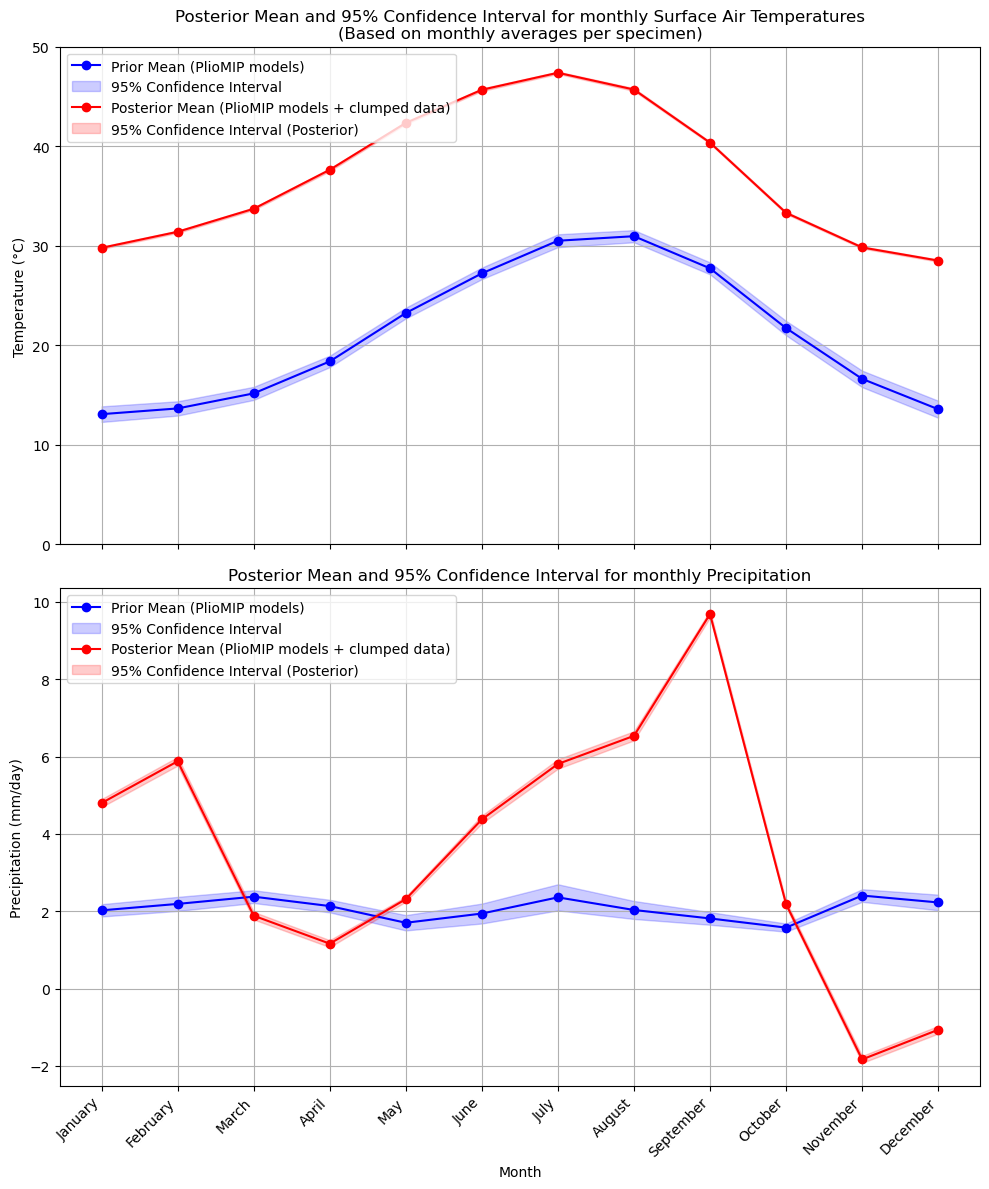

In [69]:
# Convert posterior D47 to temp
mu_post_SAT_D47_monthlySC_noerr_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_monthlySC_noerr, sD47 = cov_post_SAT_D47_monthlySC_noerr, return_covar = True)[0]
cov_post_SAT_D47_monthlySC_noerr_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_monthlySC_noerr, sD47 = cov_post_SAT_D47_monthlySC_noerr, return_covar = True)[1]

# Convert posterior SAT-D47 back to temperature
std_post_SAT_D47_monthlySC_noerr_T = np.nan_to_num(np.sqrt(np.diag(cov_post_SAT_D47_monthlySC_noerr_T)))

fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# --- SAT prior and posterior ---
# PRIOR
axs[0].plot(months_scale, mu_prior_SAT_monthly_original, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[0].fill_between(
    months_scale,
    mu_prior_SAT_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    mu_prior_SAT_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    color='b', alpha=0.2, label='95% Confidence Interval'
)

# POSTERIOR
axs[0].plot(months_scale, mu_post_SAT_D47_monthlySC_noerr_T, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[0].fill_between(
    months_scale,
    mu_post_SAT_D47_monthlySC_noerr_T - stats.t.ppf(1 - 0.025, (n_update_monthlySC_noerr_D47 + n_models_monthly)) * std_post_SAT_D47_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly),
    mu_post_SAT_D47_monthlySC_noerr_T + stats.t.ppf(1 - 0.025, (n_update_monthlySC_noerr_D47 + n_models_monthly)) * std_post_SAT_D47_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)'
)

axs[0].set_title('Posterior Mean and 95% Confidence Interval for monthly Surface Air Temperatures\n(Based on monthly averages per specimen)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_ylim(0, 50)
axs[0].legend(loc='upper left')
axs[0].grid(True)

# --- Precipitation prior and posterior ---
# PRIOR
axs[1].plot(months_scale, mu_prior_precip_monthly_original, label='Prior Mean (PlioMIP models)', color='b', marker='o')
axs[1].fill_between(
    months_scale,
    mu_prior_precip_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    mu_prior_precip_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    color='b', alpha=0.2, label='95% Confidence Interval'
)

# POSTERIOR
axs[1].plot(months_scale, mu_post_precip_monthlySC_noerr, label='Posterior Mean (PlioMIP models + clumped data)', color='r', marker='o')
axs[1].fill_between(
    months_scale,
    mu_post_precip_monthlySC_noerr - stats.t.ppf(1 - 0.025, (n_update_monthlySC_noerr_D47 + n_models_monthly)) * np.sqrt(np.diag(cov_post_precip_monthlySC_noerr)) / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly),
    mu_post_precip_monthlySC_noerr + stats.t.ppf(1 - 0.025, (n_update_monthlySC_noerr_D47 + n_models_monthly)) * np.sqrt(np.diag(cov_post_precip_monthlySC_noerr)) / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)'
)

axs[1].set_title('Posterior Mean and 95% Confidence Interval for monthly Precipitation')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Precipitation (mm/day)')
axs[1].legend(loc='upper left')
axs[1].grid(True)

plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Plot SAT, SST, SSS and precipitation posterior

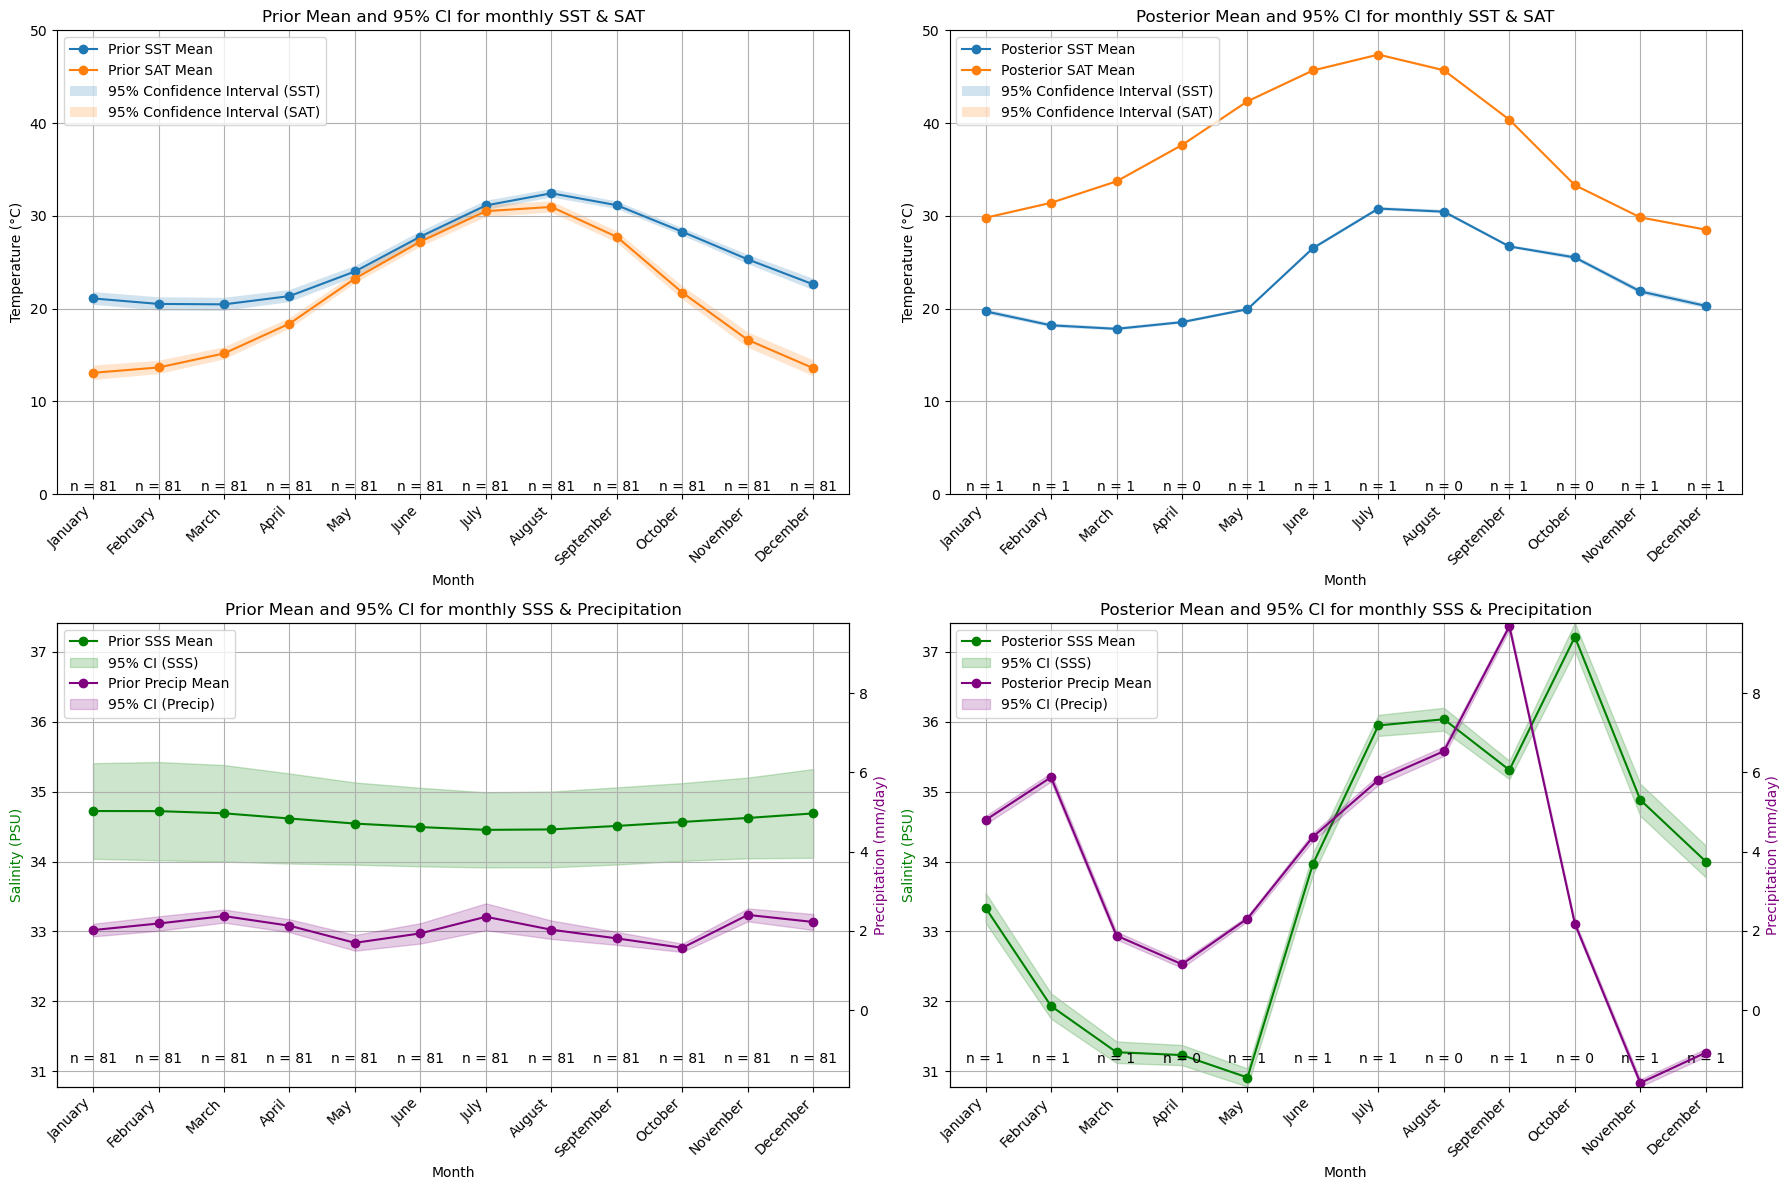

In [70]:
# Create a figure with two rows and two columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --- SST & SAT Prior and Posterior ---
# Prior SST & SAT
axes[0, 0].plot(months_scale, mu_prior_SST_monthly, label='Prior SST Mean', marker='o')
axes[0, 0].plot(months_scale, mu_prior_SAT_monthly, label='Prior SAT Mean', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_prior_SST_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
    mu_prior_SST_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, label='95% Confidence Interval (SST)'
)
axes[0, 0].fill_between(
    months_scale,
    mu_prior_SAT_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    mu_prior_SAT_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, label='95% Confidence Interval (SAT)'
)
axes[0, 0].set_xticks(months_scale)
axes[0, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 0].set_title('Prior Mean and 95% CI for monthly SST & SAT')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_ylim(0, 50)
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True)

# Posterior SST & SAT
axes[0, 1].plot(months_scale, mu_post_SST_D47_monthlySC_noerr_T, label='Posterior SST Mean', marker='o')
axes[0, 1].plot(months_scale, mu_post_SAT_D47_monthlySC_noerr_T, label='Posterior SAT Mean', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_post_SST_D47_monthlySC_noerr_T - stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_D47 + n_models_monthly) * std_post_SST_D47_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly),
    mu_post_SST_D47_monthlySC_noerr_T + stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_D47 + n_models_monthly) * std_post_SST_D47_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly),
    alpha=0.2, label='95% Confidence Interval (SST)'
)
axes[0, 1].fill_between(
    months_scale,
    mu_post_SAT_D47_monthlySC_noerr_T - stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_D47 + n_models_monthly) * std_post_SAT_D47_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly),
    mu_post_SAT_D47_monthlySC_noerr_T + stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_D47 + n_models_monthly) * std_post_SAT_D47_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly),
    alpha=0.2, label='95% Confidence Interval (SAT)'
)
axes[0, 1].set_xticks(months_scale)
axes[0, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 1].set_title('Posterior Mean and 95% CI for monthly SST & SAT')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].set_ylim(0, 50)
axes[0, 1].legend(loc='upper left')
axes[0, 1].grid(True)

# --- SSS & Precipitation Prior and Posterior (Shared Plot, Twin Axes) ---

# Get y-limits for SSS and precipitation (prior and posterior) to keep them consistent
sss_min = min(np.min(mu_prior_SSS_d18Ow_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly)),
              np.min(mu_post_SSS_d18Ow_monthlySC_noerr_T - stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_D47 + n_models_monthly) * std_post_SSS_d18Ow_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly)))
sss_max = max(np.max(mu_prior_SSS_d18Ow_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly)),
              np.max(mu_post_SSS_d18Ow_monthlySC_noerr_T + stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_D47 + n_models_monthly) * std_post_SSS_d18Ow_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly)))
precip_min = min(np.min(mu_prior_precip_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly)),
                 np.min(mu_post_precip_monthlySC_noerr - stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_D47 + n_models_monthly) * np.sqrt(np.diag(cov_post_precip_monthlySC_noerr)) / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly)))
precip_max = max(np.max(mu_prior_precip_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly)),
                 np.max(mu_post_precip_monthlySC_noerr + stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_D47 + n_models_monthly) * np.sqrt(np.diag(cov_post_precip_monthlySC_noerr)) / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly)))

# --- Prior SSS & Precipitation ---
ax1 = axes[1, 0]
ax2 = ax1.twinx()
lns1 = ax1.plot(months_scale, mu_prior_SSS_d18Ow_monthly_T, label='Prior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    months_scale,
    mu_prior_SSS_d18Ow_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly),
    mu_prior_SSS_d18Ow_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_models_monthly),
    color="green", alpha=0.2, label='95% CI (SSS)'
)
lns2 = ax2.plot(months_scale, mu_prior_precip_monthly_original, label='Prior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    months_scale,
    mu_prior_precip_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    mu_prior_precip_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    color="purple", alpha=0.2, label='95% CI (Precip)'
)
ax1.set_xticks(months_scale)
ax1.set_xticklabels(month_names, rotation=45, ha="right")
ax1.set_title('Prior Mean and 95% CI for monthly SSS & Precipitation')
ax1.set_xlabel('Month')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# --- Posterior SSS & Precipitation ---
ax1 = axes[1, 1]
ax2 = ax1.twinx()
lns1 = ax1.plot(months_scale, mu_post_SSS_d18Ow_monthlySC_noerr_T, label='Posterior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    months_scale,
    mu_post_SSS_d18Ow_monthlySC_noerr_T - stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_D47 + n_models_monthly) * std_post_SSS_d18Ow_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly),
    mu_post_SSS_d18Ow_monthlySC_noerr_T + stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_D47 + n_models_monthly) * std_post_SSS_d18Ow_monthlySC_noerr_T / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly),
    color="green", alpha=0.2, label='95% CI (SSS)'
)
lns2 = ax2.plot(months_scale, mu_post_precip_monthlySC_noerr, label='Posterior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    months_scale,
    mu_post_precip_monthlySC_noerr - stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_D47 + n_models_monthly) * np.sqrt(np.diag(cov_post_precip_monthlySC_noerr)) / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly),
    mu_post_precip_monthlySC_noerr + stats.t.ppf(1 - 0.025, n_update_monthlySC_noerr_D47 + n_models_monthly) * np.sqrt(np.diag(cov_post_precip_monthlySC_noerr)) / np.sqrt(n_update_monthlySC_noerr_D47 + n_models_monthly),
    color="purple", alpha=0.2, label='95% CI (Precip)'
)
ax1.set_xticks(months_scale)
ax1.set_xticklabels(month_names, rotation=45, ha="right")
ax1.set_title('Posterior Mean and 95% CI for monthly SSS & Precipitation')
ax1.set_xlabel('Month')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# Add "n = x" labels below each x-tick for each subplot to show the number of model values or updates
# Prior SST & SAT
for i, month in enumerate(month_names):
    axes[0, 0].text(
        months_scale[i], axes[0, 0].get_ylim()[0] + 1.5,  # adjust location as needed
        f"n = {n_models_monthly[i] if hasattr(n_models_monthly, '__getitem__') else n_models_monthly}",
        ha='center', va='top', fontsize=10
    )

# Posterior SST & SAT
for i, month in enumerate(month_names):
    axes[0, 1].text(
        months_scale[i], axes[0, 1].get_ylim()[0] + 1.5,
        f"n = {int(n_update_monthly_aggregated_D47[i]) if hasattr(n_update_monthly_aggregated_D47, '__getitem__') else n_update_monthly_aggregated_D47}",
        ha='center', va='top', fontsize=10
    )

# Prior SSS & Precipitation
for i, month in enumerate(month_names):
    axes[1, 0].text(
        months_scale[i], axes[1, 0].get_ylim()[0] + 0.5,
        f"n = {n_models_monthly[i] if hasattr(n_models_monthly, '__getitem__') else n_models_monthly}",
        ha='center', va='top', fontsize=10
    )

# Posterior SSS & Precipitation
for i, month in enumerate(month_names):
    axes[1, 1].text(
        months_scale[i], axes[1, 1].get_ylim()[0] + 0.5,
        f"n = {int(n_update_monthly_aggregated_D47[i]) if hasattr(n_update_monthly_aggregated_D47, '__getitem__') else n_update_monthly_aggregated_D47}",
        ha='center', va='top', fontsize=10
    )

plt.tight_layout()
plt.show()